<a href="https://colab.research.google.com/github/ramabhinav2001/Aspect-Based-Sentiment-Analysis/blob/main/Aspect_Based_Sentiment_Analysis_CAP_6640_Project_3_Group_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**
In the two groups' project, we found that Transformer's encoder block works very well for text classification problems (extracting span text from context). Therefore, in this project 3, our team aims to test models with the main architectural component being the Transformer's Encoder block.

The problem we are focusing on this time is Aspect Based Sentiment Analysis (abbreviated as ABSA). The data for the problem are two famous data sets restaurant and laptop belonging to the big data bug for the ABSA problem called semeval-absa. Currently, the team has the 2014 data set for both restaurant and laptop, the 2015 restaurant set and the 2016 restaurant set.

The goal of the ABSA problem is most commonly divided into three sub-tasks:
+ Extract aspects (aspects, features, characteristics, ....) of a certain dish, product, place, ... that the comment is referring to.
+ Extract opinion term - word or phrase that the person who wrote the comment describes the aspect above.
+ From aspect and opnion term, we will classify whether the author of the comment has positive, neutral or negative thoughts about the mentioned aspect.

# **Inferencing instructions:**
1. Run import neccessary libraries cell and important class and constant cell.
2. Run the model cell or choose one of the model to run.
3. Run the preparing data in infernce section if inferencing using test dataset
4. Choose the model want to use for inferencing in preparing model in inferencing section.
5. If not use test dataset, you can create a list of reviews for the model then run the inferencing.

**Note:** Try to take sometime to go through the code and fix the path to the place you save model or dataset

**Url to all necessary files:** [Group11_Project3_files](https://drive.google.com/drive/folders/1RWvMnxhIf0RzgpkSL02Q9lCQRdp2DUNq?usp=sharing)

# **Import the necessary libraries**

In [ ]:
!pip install transformers

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00


In [ ]:
import json
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
from os import listdir
from ast import literal_eval
from torch.optim import AdamW
import torch.nn.functional as F
from typing import Optional, Union
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from datasets import Dataset, DatasetDict, load_from_disk
from transformers import DebertaV2Tokenizer, DebertaV2Model, get_linear_schedule_with_warmup, BertTokenizer, BertModel

# **Important class and constant**

In [ ]:
#Constant
pretrained_model_name = 'microsoft/deberta-v3-base' #Plase using debert version 2 or higher for now
MAX_INPUT_LENGTH = 512
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def load_semeval_dataset(file_path, split_fo:Optional[Union[list, str]] = 'all'):
  all_fo = listdir(file_path)
  if split_fo == 'all':
    split_fo = all_fo
  else:
    if type(split_fo) == str:
      split_fo = split_fo.lower()
      if split_fo not in all_fo:
        raise ValueError(f'Cannot find {split_fo} dataset in {file_path})')
      else:
        split_fo = [split_fo]
    elif type(split_fo) == list:
      for i in range(len(split_fo)):
        fo = split_fo[i].lower()
        if fo not in all_fo:
          raise ValueError(f'Cannot find {fo} dataset in {file_path})')
        split_fo[i] = fo
    else:
      raise ValueError('Invalid split type')

  set_list = ['train_triplets.txt', 'dev_triplets.txt', 'test_triplets.txt']
  dataset_dict = {}
  for set_data in set_list:
    text_lines = []
    for fo in split_fo:
      data_path = file_path + '/' + fo + '/' + set_data
      with open(data_path) as ifile:
        text = ifile.read()
      text_lines.extend(text.split('\n'))

    #Convert simple text line to a dataset in dictionary type
    dataset_l = []
    for line in text_lines:
      if line == '':
        continue
      sample = {}
      review, triplet_list = line.split('####')
      triplet_list = literal_eval(triplet_list)
      for i in range(len(triplet_list)):
        triplet_dict = {}
        triplet_dict['aspect'] = triplet_list[i][0]
        triplet_dict['opinion'] = triplet_list[i][1]
        triplet_dict['polarity'] = triplet_list[i][2]
        triplet_list[i] = triplet_dict
      sample['review'] = review
      sample['triplets'] = triplet_list
      dataset_l.append(sample)

    #Convert to huggingface dataset and add to the dataset dict
    hf_dataset = Dataset.from_list(dataset_l)
    set_name = set_data.split('_')[0]
    dataset_dict[set_name] = hf_dataset
  df_datasetdict = DatasetDict(dataset_dict)
  return df_datasetdict

In [ ]:
def myvaltestcollator(batch):
  assert all('a2o_stage1_input_ids' in x for x in batch)
  assert all('a2o_stage1_token_type_ids' in x for x in batch)
  assert all('a2o_stage1_attention_mask' in x for x in batch)
  assert all('o2a_stage1_input_ids' in x for x in batch)
  assert all('o2a_stage1_token_type_ids' in x for x in batch)
  assert all('o2a_stage1_attention_mask' in x for x in batch)
  assert all('ground_truth_aspects' in x for x in batch)
  assert all('ground_truth_opinions' in x for x in batch)
  assert all('ground_truth_aspect_opinion_pairs' in x for x in batch)
  assert all('ground_truth_aspect_polarity_pairs' in x for x in batch)
  assert all('ground_truth_triplets' in x for x in batch)
  a2o_stage1_input_ids = [x['a2o_stage1_input_ids'].unsqueeze(0) for x in batch]
  a2o_stage1_token_type_ids = [x['a2o_stage1_token_type_ids'].unsqueeze(0) for x in batch]
  a2o_stage1_attention_mask = [x['a2o_stage1_attention_mask'].unsqueeze(0) for x in batch]
  o2a_stage1_input_ids = [x['o2a_stage1_input_ids'].unsqueeze(0) for x in batch]
  o2a_stage1_token_type_ids = [x['o2a_stage1_token_type_ids'].unsqueeze(0) for x in batch]
  o2a_stage1_attention_mask = [x['o2a_stage1_attention_mask'].unsqueeze(0) for x in batch]
  return {
      'a2o_stage1_input_ids': torch.cat(a2o_stage1_input_ids, dim=0),
      'a2o_stage1_token_type_ids': torch.cat(a2o_stage1_token_type_ids, dim=0),
      'a2o_stage1_attention_mask': torch.cat(a2o_stage1_attention_mask, dim=0),
      'o2a_stage1_input_ids': torch.cat(o2a_stage1_input_ids, dim=0),
      'o2a_stage1_token_type_ids': torch.cat(o2a_stage1_token_type_ids, dim=0),
      'o2a_stage1_attention_mask': torch.cat(o2a_stage1_attention_mask, dim=0),
      'ground_truth_aspects': [x['ground_truth_aspects'] for x in batch],
      'ground_truth_opinions': [x['ground_truth_opinions'] for x in batch],
      'ground_truth_aspect_opinion_pairs': [x['ground_truth_aspect_opinion_pairs'] for x in batch],
      'ground_truth_aspect_polarity_pairs': [x['ground_truth_aspect_polarity_pairs'] for x in batch],
      'ground_truth_triplets': [x['ground_truth_triplets'] for x in batch]
      }

In [ ]:
def normalize_dimension(tensor):
  #Adjust tensor for calcualting loss
  if len(tensor.size()) == 3:
    tensor = tensor.contiguous().view(-1, tensor.size(2))
  elif len(tensor.size()) == 2:
    tensor = tensor.contiguous().view(-1)

  return tensor

In [ ]:
def calculate_entity_loss(logits_start, logits_end, entity_start, entity_end):
  #Normalize to fit the dimension
  logits_start = normalize_dimension(logits_start)
  logits_end = normalize_dimension(logits_end)
  entity_start = normalize_dimension(entity_start)
  entity_end = normalize_dimension(entity_end)

  #We need weight beause 0 will be more than 1
  weight = torch.tensor([1, 3]).float().to(DEVICE)

  #Calculate loss
  loss_start = F.cross_entropy(logits_start, entity_start.long(), size_average=False, weight=weight, ignore_index=-1)
  loss_end = F.cross_entropy(logits_end, entity_end.long(), size_average=False, weight=weight, ignore_index=-1)
  return 0.5 * (loss_start + loss_end) #Average the loss for the whole entity

In [ ]:
def calculate_polarity_loss(logits, polarity):
  return F.cross_entropy(logits, polarity.long(), size_average=False, ignore_index=-1)

In [ ]:
class DatasetProcessor:
  def __init__(self, tokenizer, device:str='cuda'):
    self.tokenizer = tokenizer
    self.device = device
    #Special token id
    self.pad_token_id = self.tokenizer.pad_token_id
    self.cls_token_id = self.tokenizer.cls_token_id
    self.sep_token_id = self.tokenizer.sep_token_id

  def process_semeval_dataset(self, dataset, kind:str='train'):
    dataset = dataset.map(self.process_semeval_sample)
    if kind != 'train':
      dataset = dataset.map(self.process_dev_sample)
    return dataset

  def process_dev_sample(self, sample):
    #This help create a ground truth feature to help evaluate or test later
    aspects = set([])
    opinions = set([])
    aspect_opinion_pairs = set([])
    aspect_polarity_pairs = set([])
    triplets = set([])
    triplets_text = sample['triplets_text']
    for triplet in triplets_text:
      aspects.add(triplet['aspect'])
      opinions.add(triplet['opinion'])
      aspect_opinion_pairs.add((triplet['aspect'], triplet['opinion']))
      aspect_polarity_pairs.add((triplet['aspect'], triplet['polarity']))
      triplets.add((triplet['aspect'], triplet['opinion'], triplet['polarity']))
    sample['ground_truth'] = {
        'aspects': aspects,
        'opinions': opinions,
        'aspect_opinion_pairs': aspect_opinion_pairs,
        'aspect_polarity_pairs': aspect_polarity_pairs,
        'triplets': triplets
    }
    return sample

  def process_semeval_sample(self, sample):
    review = sample['review']
    triplets = sample['triplets']

    #Splitting review by space blank
    review_tokens = review.split(' ')
    sample['review_tokens'] = review_tokens

    #Gathering aspects and opinions to help fix the label index and more accurate tokenized sentence
    asp_coor_list = []
    opi_coor_list = []
    for triplet in triplets:
      if triplet['aspect'] not in asp_coor_list:
        asp_coor_list.append(triplet['aspect'])
      if triplet['opinion'] not in opi_coor_list:
        opi_coor_list.append(triplet['opinion'])

    #Fix review token to create whole aspects and opinions
    old_review_tokens = review_tokens
    #Joint two term list to process at one time
    term_coor_list = asp_coor_list + opi_coor_list
    term_coor_list = [tuple(x) for x in term_coor_list] #Convert to tuple to remove duplicate
    term_coor_list = list(set(term_coor_list)) #remove duplicate coordinate
    ##Sort term_coor_list by descending order by element[0]
    term_coor_list.sort(key=lambda x: x[0], reverse=True)
    for term_coor in term_coor_list:
      if len(term_coor) == 1:
        continue
      term = ' '.join(review_tokens[term_coor[0]:term_coor[-1]+1])
      review_tokens = review_tokens[:term_coor[0]] + [term] + review_tokens[term_coor[-1]+1:]

    #COnvert review into ids
    review_ids = []
    for token in review_tokens:
      review_ids.extend(self.tokenizer.encode(token, add_special_tokens=False))
    sample['review_ids'] = review_ids

    #Update new coordinate based on ids
    triplets_text = []
    triplets_ids = []
    for triplet in triplets:
      #Processing aspect
      asp_coor = triplet['aspect']
      aspect_text = ' '.join(old_review_tokens[asp_coor[0]:asp_coor[-1]+1])
      aspect_ids = self.tokenizer.encode(aspect_text, add_special_tokens=False)
      if len(aspect_ids) == 1:
        #Find all indices of aspect ids in review ids
        aspect_indices = [i for i, x in enumerate(review_ids) if x in aspect_ids]
        if len(aspect_indices) == 1:
          new_asp_coor = (aspect_indices[0], aspect_indices[0])
        else:
          asp_index = self.find_nearest_index(aspect_indices, asp_coor[0])
          new_asp_coor = (aspect_indices[asp_index], aspect_indices[asp_index])
      else:
        new_asp_coor = self.find_sub_list(aspect_ids, review_ids)

      #Processing opinion
      opi_coor = triplet['opinion']
      opinion_text = ' '.join(old_review_tokens[opi_coor[0]:opi_coor[-1]+1])
      opinion_ids = self.tokenizer.encode(opinion_text, add_special_tokens=False)
      if len(opinion_ids) == 1:
        #Find all indices of opinion ids in review ids
        opinion_indices = [i for i, x in enumerate(review_ids) if x in opinion_ids]
        if len(opinion_indices) == 1:
          new_opi_coor = (opinion_indices[0], opinion_indices[0])
        else:
          opi_index = self.find_nearest_index(opinion_indices, opi_coor[0])
          new_opi_coor = (opinion_indices[opi_index], opinion_indices[opi_index])
      else:
        new_opi_coor = self.find_sub_list(opinion_ids, review_ids)

      #Processing polarity
      pol = triplet['polarity']
      pol = pol.lower()
      pol_ids = {
          'pos': 2,
          'neg': 0,
          'neu': 1
      }
      pol_id = pol_ids[pol]

      #Update triplet
      triplets_text.append({
          'aspect': aspect_text,
          'opinion': opinion_text,
          'polarity': pol
      })
      triplets_ids.append({
          'aspect': new_asp_coor,
          'opinion': new_opi_coor,
          'polarity': pol_id
      })
    sample['triplets_text'] = triplets_text
    sample['triplets_ids'] = triplets_ids

    return sample

  def find_sub_list(self, sl,l):
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            return ind,ind+sll-1

  def find_nearest_index(self, indices, index):
    #Find distance list
    distance_list = [abs(i - index) for i in indices]
    #Find minimum distance
    min_distance = min(distance_list)
    #Find index of minimum distance
    min_index = distance_list.index(min_distance)
    return min_index

  def gather_terms(self, input_ids, answer_start_logits, answer_end_logits,
                   direction:str=None, stage:int=None, prev_stage_terms=None,
                   prev_stage_terms_probs=None, threshold:float=0.5, longest_term_length:int=8):

    terms = []
    terms_probs = []
    filtered_terms_start = []
    filtered_terms_end = []
    filtered_contexts = []
    if stage == 2:
      pairs = [] #Pairs have the shape as (aspect, opinion)
      pairs_probs = []
      pairs_probs_pairs = []


    #Gathering terms of current stage
    for i in range(input_ids.shape[0]):
      input_ids_sep_token_indices = torch.where(input_ids[i] == self.sep_token_id)[0].cpu().tolist()
      context = input_ids[i][input_ids_sep_token_indices[0]+1:input_ids_sep_token_indices[-1]]
      #Convert logits to labels
      answer_start_prob_i = F.softmax(answer_start_logits[i], dim=1)
      answer_end_prob_i = F.softmax(answer_end_logits[i], dim=1)
      answer_start_probs, answer_start_index = torch.max(answer_start_prob_i, dim=1)
      answer_end_probs, answer_end_index = torch.max(answer_end_prob_i, dim=1)
      #Shrink the answer to the postition of the context
      answer_start_probs = answer_start_probs[input_ids_sep_token_indices[0]+1:input_ids_sep_token_indices[-1]].cpu().tolist()
      answer_end_probs = answer_end_probs[input_ids_sep_token_indices[0]+1:input_ids_sep_token_indices[-1]].cpu().tolist()
      answer_start_index = answer_start_index[input_ids_sep_token_indices[0]+1:input_ids_sep_token_indices[-1]]
      answer_end_index = answer_end_index[input_ids_sep_token_indices[0]+1:input_ids_sep_token_indices[-1]]
      #Find where index is one in start and end
      answer_start_label1_indices = torch.where(answer_start_index == 1)[0].cpu().tolist()
      answer_end_label1_indices = torch.where(answer_end_index == 1)[0].cpu().tolist()
      if len(answer_start_label1_indices) == 0 or len(answer_end_label1_indices) == 0:
        continue
      #Filtered to get the right term
      length = answer_start_label1_indices[-1] + 1 if answer_start_label1_indices[-1] >= answer_end_label1_indices[-1] else answer_end_label1_indices[-1] + 1
      filtered_sequence = [0] * length
      for s in answer_start_label1_indices:
        filtered_sequence[s] += 1
      for e in answer_end_label1_indices:
        filtered_sequence[e] += 2
      ##Filtering
      last_start = -1
      for idx in range(len(filtered_sequence)):
        if filtered_sequence[idx] == 1:
          last_start = idx
        elif filtered_sequence[idx] == 2:
          if last_start != -1 and idx - last_start <= longest_term_length:
            filtered_terms_start.append(last_start)
            filtered_terms_end.append(idx)
            term_prob = answer_start_probs[last_start] * answer_end_probs[idx]
            terms_probs.append(term_prob)
            terms.append(self.tokenizer.decode(context[last_start:idx+1]).strip())
            if stage == 1:
              filtered_contexts.append(context)
            elif stage == 2:
              #Gathering pairs
              if prev_stage_terms is not None and len(prev_stage_terms)!=0:
                prev_stage_term = prev_stage_terms[i]
                prev_stage_term_prob = prev_stage_terms_probs[i]
                if prev_stage_term_prob * term_prob >= threshold:
                  if direction.lower() == 'a2o':
                    pairs.append((prev_stage_term, self.tokenizer.decode(context[last_start:idx+1]).strip()))
                    pairs_probs_pairs.append((prev_stage_term_prob, term_prob))
                  elif direction.lower() == 'o2a':
                    pairs.append((self.tokenizer.decode(context[last_start:idx+1]).strip(), prev_stage_term))
                    pairs_probs_pairs.append((term_prob, prev_stage_term_prob))
                  pairs_probs.append(prev_stage_term_prob * term_prob)
                  filtered_contexts.append(context)
          last_start = -1
        elif filtered_sequence[idx] == 3:
          filtered_terms_start.append(idx)
          filtered_terms_end.append(idx)
          term_prob = answer_start_probs[idx] * answer_end_probs[idx]
          terms_probs.append(term_prob)
          terms.append(self.tokenizer.decode(context[idx:idx+1]).strip())
          if stage == 1:
            filtered_contexts.append(context)
          elif stage == 2:
            #Gathering pairs
            if prev_stage_terms is not None and len(prev_stage_terms)!=0:
              prev_stage_term = prev_stage_terms[i]
              prev_stage_term_prob = prev_stage_terms_probs[i]
              if prev_stage_term_prob * term_prob >= threshold:
                if direction.lower() == 'a2o':
                  pairs.append((prev_stage_term, self.tokenizer.decode(context[idx:idx+1]).strip()))
                  pairs_probs_pairs.append((prev_stage_term_prob, term_prob))
                elif direction.lower() == 'o2a':
                  pairs.append((self.tokenizer.decode(context[idx:idx+1]).strip(), prev_stage_term))
                  pairs_probs_pairs.append((term_prob, prev_stage_term_prob))
                pairs_probs.append(prev_stage_term_prob * term_prob)
                filtered_contexts.append(context)
          last_start = -1
    if stage == 1:
      return terms, terms_probs, filtered_contexts
    elif stage == 2:
      return terms, terms_probs, pairs, pairs_probs, pairs_probs_pairs, filtered_contexts

  def create_next_stage_input(self, terms, prev_stage_filtered_contexts, pairs=None, stage:int=None, direction:str=None, max_input_length:int=MAX_INPUT_LENGTH):
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    length_list = []
    if stage == 2:
      if len(terms) == 0:
        if direction.lower() == 'a2o':
          question_text = f'What opinions given the aspect ?'
        elif direction.lower() == 'o2a':
          question_text = f'What aspects does the opinion ?'
        else:
          raise ValueError('Direction must be A2O or O2A')
        question_ids = self.tokenizer.encode(question_text, add_special_tokens=True)
        context_ids = self.tokenizer.encode('No context!', add_special_tokens=False)
        input_ids = question_ids + context_ids
        token_type_ids = [0] * len(question_ids) + [1] * len(context_ids)
        attention_mask = [1] * len(question_ids) + [1] * len(context_ids)
        assert len(input_ids) == len(token_type_ids) == len(attention_mask)
        length_list.append(len(input_ids) + 1)
        input_ids_list.append(input_ids)
        token_type_ids_list.append(token_type_ids)
        attention_mask_list.append(attention_mask)
      else:
        for i in range(len(terms)):
          ##Creating question id for next stage
          if direction.lower() == 'a2o':
            #A2O direction
            question_text = f'What opinions given the aspect {terms[i]}?'
          elif direction.lower() == 'o2a':
            #O2A direction
            question_text = f'What aspects does the opinion {terms[i]} describe?'
          else:
            raise ValueError('Direction must be A2O or O2A')
          question_ids = self.tokenizer.encode(question_text, add_special_tokens=True)
          input_ids = question_ids + prev_stage_filtered_contexts[i].cpu().tolist()
          token_type_ids = [0] * len(question_ids) + [1] * len(prev_stage_filtered_contexts[i])
          attention_mask = [1] * len(question_ids) + [1] * len(prev_stage_filtered_contexts[i])
          assert len(input_ids) == len(token_type_ids) == len(attention_mask)
          length_list.append(len(input_ids) + 1)
          input_ids_list.append(input_ids)
          token_type_ids_list.append(token_type_ids)
          attention_mask_list.append(attention_mask)
    elif stage == 3:
      if len(pairs) == 0:
        question_text = f'What sentiment given the aspect  and the opinion ?'
        question_ids = self.tokenizer.encode(question_text, add_special_tokens=True)
        context = self.tokenizer.encode('No context!', add_special_tokens=False)
        input_ids = question_ids + context
        token_type_ids = [0] * len(question_ids) + [1] * len(context)
        attention_mask = [1] * len(question_ids) + [1] * len(context)
        assert len(input_ids) == len(token_type_ids) == len(attention_mask)
        length_list.append(len(input_ids) + 1)
        input_ids_list.append(input_ids)
        token_type_ids_list.append(token_type_ids)
        attention_mask_list.append(attention_mask)
      else:
        for i in range(len(pairs)):
          ##Creating question id for next stage
          question_text = f'What sentiment given the aspect {pair[0]} and the opinion {pair[1]}?'
          question_ids = self.tokenizer.encode(question_text, add_special_tokens=True)
          input_ids = question_ids + prev_stage_filtered_contexts[i].cpu().tolist()
          token_type_ids = [0] * len(question_ids) + [1] * len(prev_stage_filtered_contexts[i])
          attention_mask = [1] * len(question_ids) + [1] * len(prev_stage_filtered_contexts[i])
          assert len(input_ids) == len(token_type_ids) == len(attention_mask)
          length_list.append(len(input_ids) + 1)
          input_ids_list.append(input_ids)
          token_type_ids_list.append(token_type_ids)
          attention_mask_list.append(attention_mask)

    #Finding max length for padding or truncating
    max_length = max(length_list) if max(length_list) < max_input_length else max_input_length
    input_ids_list, token_type_ids_list, attention_mask_list = self.pad_or_truncate(input_ids_list, token_type_ids_list, attention_mask_list, max_length)

    #Convert to tensor and device
    input_ids = torch.tensor(input_ids_list).to(self.device)
    token_type_ids = torch.tensor(token_type_ids_list).to(self.device)
    attention_mask = torch.tensor(attention_mask_list).to(self.device)
    return input_ids, token_type_ids, attention_mask


  def pad_or_truncate(self, input_ids_list, token_type_ids_list, attention_mask_list, max_length):
    for i in range(len(input_ids_list)):
      if len(input_ids_list[i]) < max_length - 1:
        #Padding
        padding_length = max_length - len(input_ids_list[i]) - 1
        input_ids_list[i] = input_ids_list[i] + [self.sep_token_id] + [self.pad_token_id] * padding_length
        token_type_ids_list[i] = token_type_ids_list[i] + [1] + [0] * padding_length
        attention_mask_list[i] = attention_mask_list[i] + [1] +[0] * padding_length
      elif len(input_ids_list[i]) == max_length - 1:
        #Normal
        input_ids_list[i] = input_ids_list[i] + [self.sep_token_id]
        token_type_ids_list[i] = token_type_ids_list[i] + [1]
        attention_mask_list[i] = attention_mask_list[i] + [1]
      else:
        #Truncate
        input_ids_list[i] = input_ids_list[i][:max_length - 1]
        token_type_ids_list[i] = token_type_ids_list[i][:max_length - 1]
        attention_mask_list[i] = attention_mask_list[i][:max_length - 1]
        input_ids_list[i] = input_ids_list[i] + [self.sep_token_id]
        token_type_ids_list[i] = token_type_ids_list[i] + [1]
        attention_mask_list[i] = attention_mask_list[i] + [1]

      assert len(input_ids_list[i]) == len(token_type_ids_list[i]) == len(attention_mask_list[i]) == max_length

    return input_ids_list, token_type_ids_list, attention_mask_list

  def gather_polarity(self, pairs, polarity_logits):
    #Convert polarity_logits into labels
    polarity_map = {
        0: 'neg',
        1: 'neu',
        2: 'pos'
    }
    tiplets = []
    aspect_polarity_pairs = []
    polarity_labels = torch.argmax(polarity_logits, dim=1)
    polarity_labels = polarity_labels.cpu().tolist()
    for i in range(len(pairs)):
      aspect = pairs[i][0]
      opinion = pairs[i][1]
      polarity = polarity_labels[i]
      if [aspect, polarity_map[polarity]] not in aspect_polarity_pairs:
        aspect_polarity_pairs.append([aspect, polarity_map[polarity]])
      if [aspect, opinion, polarity_map[polarity]] not in tiplets:
        tiplets.append([aspect, opinion, polarity_map[polarity]])
    return tiplets, aspect_polarity_pairs
  def create_input_inference_input(self, review, tokenizer=None, device:str='cuda'):
    """
    Create input for inference
    """
    if tokenizer is None:
        tokenizer = DebertaV2Tokenizer.from_pretrained(pretrained_model_name)
    a2o_question = 'What aspects?'
    o2a_question = 'What opinions?'
    a2o_question_ids = tokenizer.encode(a2o_question, add_special_tokens=True)
    o2a_question_ids = tokenizer.encode(o2a_question, add_special_tokens=True)
    a2o_token_type_ids = [0] * len(a2o_question_ids)
    o2a_token_type_ids = [0] * len(o2a_question_ids)
    review_ids = tokenizer.encode(review, add_special_tokens=False)
    a2o_input_ids = a2o_question_ids + review_ids + [tokenizer.sep_token_id]
    o2a_input_ids = o2a_question_ids + review_ids + [tokenizer.sep_token_id]
    a2o_token_type_ids = a2o_token_type_ids + [1] * len(review_ids) + [1]
    o2a_token_type_ids = o2a_token_type_ids + [1] * len(review_ids) + [1]
    a2o_attention_mask = [1] * len(a2o_input_ids)
    o2a_attention_mask = [1] * len(o2a_input_ids)
    assert len(a2o_input_ids) == len(a2o_token_type_ids) == len(a2o_attention_mask)
    assert len(o2a_input_ids) == len(o2a_token_type_ids) == len(o2a_attention_mask)

    #Convert to tensor
    a2o_input_ids = torch.tensor(a2o_input_ids, dtype=torch.long, device=device).unsqueeze(0)
    a2o_token_type_ids = torch.tensor(a2o_token_type_ids, dtype=torch.long, device=device).unsqueeze(0)
    a2o_attention_mask = torch.tensor(a2o_attention_mask, dtype=torch.long, device=device).unsqueeze(0)
    o2a_input_ids = torch.tensor(o2a_input_ids, dtype=torch.long, device=device).unsqueeze(0)
    o2a_token_type_ids = torch.tensor(o2a_token_type_ids, dtype=torch.long, device=device).unsqueeze(0)
    o2a_attention_mask = torch.tensor(o2a_attention_mask, dtype=torch.long, device=device).unsqueeze(0)
    return a2o_input_ids, a2o_token_type_ids, a2o_attention_mask, o2a_input_ids, o2a_token_type_ids, o2a_attention_mask

In [ ]:
class SemEvalASTEDataset(Dataset):
  def __init__(self, dataset, tokenizer=None, max_length:int=MAX_INPUT_LENGTH, mode:str='train', device:str='cuda'):
    self.dataset = dataset
    self.tokenizer = tokenizer
    self.max_length = max_length
    self.device = device
    self.mode = mode

    #Special token id
    self.cls_token_id = tokenizer.cls_token_id
    self.sep_token_id = tokenizer.sep_token_id
    self.pad_token_id = tokenizer.pad_token_id

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    #Stage 1 input
    ##A2O direction
    a2o_stage1_input_ids, a2o_stage1_token_type_ids, a2o_stage1_attention_mask,\
    a2o_stage1_answer_start, a2o_stage1_answer_end = self.get_stage_1_input(idx, direction='A2O')
    ##O2A direction
    o2a_stage1_input_ids, o2a_stage1_token_type_ids, o2a_stage1_attention_mask,\
    o2a_stage1_answer_start, o2a_stage1_answer_end = self.get_stage_1_input(idx, direction='O2A')

    if self.mode == 'train':
      #Stage 2 input
      ##A2O direction
      a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask,\
      a2o_stage2_answer_start, a2o_stage2_answer_end = self.get_stage_2_input(idx, direction='A2O')
      ##O2A direction
      o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask,\
      o2a_stage2_answer_start, o2a_stage2_answer_end = self.get_stage_2_input(idx, direction='O2A')

      #Stage 3 input
      stage3_input_ids, stage3_token_type_ids, stage3_attention_mask, stage3_answer = self.get_stage_3_input(idx)
      batch_data = {
          'a2o_stage1_input_ids': a2o_stage1_input_ids,
          'a2o_stage1_token_type_ids': a2o_stage1_token_type_ids,
          'a2o_stage1_attention_mask': a2o_stage1_attention_mask,
          'a2o_stage1_answer_start': a2o_stage1_answer_start,
          'a2o_stage1_answer_end': a2o_stage1_answer_end,
          'o2a_stage1_input_ids': o2a_stage1_input_ids,
          'o2a_stage1_token_type_ids': o2a_stage1_token_type_ids,
          'o2a_stage1_attention_mask': o2a_stage1_attention_mask,
          'o2a_stage1_answer_start': o2a_stage1_answer_start,
          'o2a_stage1_answer_end': o2a_stage1_answer_end,
          'a2o_stage2_input_ids': a2o_stage2_input_ids,
          'a2o_stage2_token_type_ids': a2o_stage2_token_type_ids,
          'a2o_stage2_attention_mask': a2o_stage2_attention_mask,
          'a2o_stage2_answer_start': a2o_stage2_answer_start,
          'a2o_stage2_answer_end': a2o_stage2_answer_end,
          'o2a_stage2_input_ids': o2a_stage2_input_ids,
          'o2a_stage2_token_type_ids': o2a_stage2_token_type_ids,
          'o2a_stage2_attention_mask': o2a_stage2_attention_mask,
          'o2a_stage2_answer_start': o2a_stage2_answer_start,
          'o2a_stage2_answer_end': o2a_stage2_answer_end,
          'stage3_input_ids': stage3_input_ids,
          'stage3_token_type_ids': stage3_token_type_ids,
          'stage3_attention_mask': stage3_attention_mask,
          'stage3_answer': stage3_answer
      }
      return batch_data
    else:
      #Grouth truth label
      aspects, opinions, aspect_opinion_pairs, aspect_polarity_pairs, triplets = self.get_ground_truth(idx)
      #ground_truth = self.dataset[idx]['ground_truth']
      batch_data = {
          'a2o_stage1_input_ids': a2o_stage1_input_ids,
          'a2o_stage1_token_type_ids': a2o_stage1_token_type_ids,
          'a2o_stage1_attention_mask': a2o_stage1_attention_mask,
          'o2a_stage1_input_ids': o2a_stage1_input_ids,
          'o2a_stage1_token_type_ids': o2a_stage1_token_type_ids,
          'o2a_stage1_attention_mask': o2a_stage1_attention_mask,
          'ground_truth_aspects': aspects,
          'ground_truth_opinions': opinions,
          'ground_truth_aspect_opinion_pairs': aspect_opinion_pairs,
          'ground_truth_aspect_polarity_pairs': aspect_polarity_pairs,
          'ground_truth_triplets': triplets
      }
      return batch_data

  def get_ground_truth(self, idx):
    #Ground truth list batch
    ground_truth_list = self.dataset[idx]['ground_truth']
    aspects_list = []
    opinions_list = []
    aspect_opinion_pairs_list = []
    aspect_polarity_pairs_list = []
    triplets_list = []
    for i in range(len(ground_truth_list)):
      #Ground truth
      ground_truth = ground_truth_list[i]
      aspects_list.append(ground_truth['aspects'])
      opinions_list.append(ground_truth['opinions'])
      aspect_opinion_pairs_list.append(ground_truth['aspect_opinion_pairs'])
      aspect_polarity_pairs_list.append(ground_truth['aspect_polarity_pairs'])
      triplets_list.append(ground_truth['triplets'])
    return aspects_list, opinions_list, aspect_opinion_pairs_list, aspect_polarity_pairs_list, triplets_list


  def get_stage_3_input(self, idx):
    #Review
    review_ids_list = self.dataset[idx]['review_ids']
    triplets_list = self.dataset[idx]['triplets_ids']
    triplets_text_list = self.dataset[idx]['triplets_text']

    #List to keep data
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    answer_list = []
    length_list = []

    for i in range(len(review_ids_list)):
      #review
      review_ids = review_ids_list[i]
      #triplet
      triplets = triplets_list[i]
      #triplet text
      triplets_text = triplets_text_list[i]
      for j in range(len(triplets_text)):
        triplet_text = triplets_text[j]
        triplet = triplets[j]
        aspect = triplet_text['aspect']
        opinion = triplet_text['opinion']
        question = f"What sentiment given the aspect {aspect} and the opinion {opinion}?"
        question_ids = tokenizer.encode(question)
        input_ids = question_ids + review_ids
        token_type_ids = [0] * len(question_ids) + [1] * len(review_ids)
        attention_mask = [1] * len(input_ids)
        answer = triplet['polarity']
        assert len(input_ids) == len(token_type_ids) == len(attention_mask)
        input_ids_list.append(input_ids)
        token_type_ids_list.append(token_type_ids)
        attention_mask_list.append(attention_mask)
        answer_list.append(answer)
        length_list.append(len(input_ids) + 1) #1 stand for the final [SEP] token which we haven't added yet

    #Calculate max length to decide for padding or truncating
    max_length = max(length_list) if max(length_list) < self.max_length else self.max_length

    #Padding or truncating
    input_ids_list, token_type_ids_list, attention_mask_list =\
    self.padding_or_truncating(input_ids_list, token_type_ids_list, attention_mask_list, max_length=max_length)

    #Convert to tensor and device
    input_ids = torch.tensor(input_ids_list).to(self.device)
    token_type_ids = torch.tensor(token_type_ids_list).to(self.device)
    attention_mask = torch.tensor(attention_mask_list).to(self.device)
    answer = torch.tensor(answer_list).to(self.device)
    return input_ids, token_type_ids, attention_mask, answer


  def get_stage_2_input(self, idx, direction):
    #Review
    review_ids_list = self.dataset[idx]['review_ids']
    triplets_list = self.dataset[idx]['triplets_ids']
    triplets_text_list = self.dataset[idx]['triplets_text']

    #List to keep data
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    answer_start_list = []
    answer_end_list = []
    length_list = []

    #Direction
    if direction == 'A2O':
      for i in range(len(review_ids_list)):
        #review
        review_ids = review_ids_list[i]
        #triplet
        triplets = triplets_list[i]
        #triplet text
        triplets_text = triplets_text_list[i]
        aspect_list, aspect_opinions_map = self.make_pair(triplets_text, triplets, direction)
        for aspect in aspect_list:
          question = f"What opinions given the aspect {aspect}?"
          question_ids = tokenizer.encode(question)
          input_ids = question_ids + review_ids
          token_type_ids = [0] * len(question_ids) + [1] * len(review_ids)
          attention_mask = [1] * len(input_ids)
          answer_start = [0] * len(review_ids)
          answer_end = [0] * len(review_ids)
          for opinion in aspect_opinions_map[aspect]:
            answer_start[opinion[0]] = 1
            answer_end[opinion[-1]] = 1
          answer_start = [-1] * len(question_ids) + answer_start
          answer_end = [-1] * len(question_ids) + answer_end
          assert len(answer_start) == len(answer_end) == len(input_ids) == len(token_type_ids) == len(attention_mask)
          input_ids_list.append(input_ids)
          token_type_ids_list.append(token_type_ids)
          attention_mask_list.append(attention_mask)
          answer_start_list.append(answer_start)
          answer_end_list.append(answer_end)
          length_list.append(len(input_ids) + 1) #1 stand for the final [SEP] token which we haven't added yet
    elif direction == 'O2A':
      for i in range(len(review_ids_list)):
        #review
        review_ids = review_ids_list[i]
        #triplet
        triplets = triplets_list[i]
        #triplet text
        triplets_text = triplets_text_list[i]
        opinion_list, opinion_aspects_map = self.make_pair(triplets_text, triplets, direction)
        for opinion in opinion_list:
          question = f"What aspects does the opinion {opinion} describe?"
          question_ids = tokenizer.encode(question)
          input_ids = question_ids + review_ids
          token_type_ids = [0] * len(question_ids) + [1] * len(review_ids)
          attention_mask = [1] * len(input_ids)
          answer_start = [0] * len(review_ids)
          answer_end = [0] * len(review_ids)
          for aspect in opinion_aspects_map[opinion]:
            answer_start[aspect[0]] = 1
            answer_end[aspect[-1]] = 1
          answer_start = [-1] * len(question_ids) + answer_start
          answer_end = [-1] * len(question_ids) + answer_end
          assert len(answer_start) == len(answer_end) == len(input_ids) == len(token_type_ids) == len(attention_mask)
          input_ids_list.append(input_ids)
          token_type_ids_list.append(token_type_ids)
          attention_mask_list.append(attention_mask)
          answer_start_list.append(answer_start)
          answer_end_list.append(answer_end)
          length_list.append(len(input_ids) + 1) #1 stand for the final [SEP] token which we haven't added yet
    else:
      raise ValueError('Invalid direction')

    #Find max length to decide for padding or truncating
    max_length = max(length_list) if max(length_list) < self.max_length else self.max_length

    #Padding or truncating
    input_ids_list, token_type_ids_list, attention_mask_list, answer_start_list, answer_end_list =\
    self.padding_or_truncating(input_ids_list, token_type_ids_list, attention_mask_list, answer_start_list, answer_end_list, max_length)

    #Convert to tensor and device
    input_ids = torch.tensor(input_ids_list).to(self.device)
    token_type_ids = torch.tensor(token_type_ids_list).to(self.device)
    attention_mask = torch.tensor(attention_mask_list).to(self.device)
    answer_start = torch.tensor(answer_start_list).to(self.device)
    answer_end = torch.tensor(answer_end_list).to(self.device)
    return input_ids, token_type_ids, attention_mask, answer_start, answer_end


  def make_pair(self, triplets_text, triplets, direction):
    if direction == 'A2O':
      aspect_list = []
      aspect_check = []
      aspect_opinions_map = {}
      for i in range(len(triplets)):
        if triplets[i]['aspect'] not in aspect_check:
          aspect_check.append(triplets[i]['aspect'])
          aspect = triplets_text[i]['aspect']
          aspect_list.append(aspect)
          if aspect not in aspect_opinions_map:
            aspect_opinions_map[aspect] = [triplets[i]['opinion']]
          else:
            aspect_opinions_map[aspect].append(triplets[i]['opinion'])
      return aspect_list, aspect_opinions_map
    else:
      opinion_list = []
      opinion_check = []
      opinion_aspects_map = {}
      for i in range(len(triplets)):
        if triplets[i]['opinion'] not in opinion_check:
          opinion_check.append(triplets[i]['opinion'])
          opinion = triplets_text[i]['opinion']
          opinion_list.append(opinion)
          if opinion not in opinion_aspects_map:
            opinion_aspects_map[opinion] = [triplets[i]['aspect']]
          else:
            opinion_aspects_map[opinion].append(triplets[i]['aspect'])
      return opinion_list, opinion_aspects_map

  def get_stage_1_input(self, idx, direction):
    #Review
    review_ids_list = self.dataset[idx]['review_ids']
    triplets_list = self.dataset[idx]['triplets_ids']

    #List to keep data
    input_ids_list = []
    length_list = []
    token_type_ids_list = []
    attention_mask_list = []
    answer_start_list = []
    answer_end_list = []

    #Question
    ##Dirction
    if direction == 'A2O':
      question_ids = tokenizer.encode('What aspects?')
    elif direction == 'O2A':
      question_ids = tokenizer.encode('What opinions?')
    else:
      raise ValueError('Invalid direction')

    #Iterate through review_ids_list
    for i in range(len(review_ids_list)):
      #Review
      review_ids = review_ids_list[i]
      #Triplet
      triplets = triplets_list[i]
      #Input
      input_ids = question_ids + review_ids
      token_type_ids = [0] * len(question_ids) + [1] * len(review_ids)
      attention_mask = [1] * len(input_ids)
      answer_start = [0] * len(review_ids)
      answer_end = [0] * len(review_ids)
      for triplet in triplets:
        if direction == 'A2O':
          answer_start[triplet['aspect'][0]] = 1
          answer_end[triplet['aspect'][-1]] = 1
        elif direction == 'O2A':
          answer_start[triplet['opinion'][0]] = 1
          answer_end[triplet['opinion'][-1]] = 1
      answer_start = [-1] * len(question_ids) + answer_start
      answer_end = [-1] * len(question_ids) + answer_end
      assert len(answer_start) == len(answer_end) == len(input_ids) == len(token_type_ids) == len(attention_mask)
      input_ids_list.append(input_ids)
      token_type_ids_list.append(token_type_ids)
      attention_mask_list.append(attention_mask)
      answer_start_list.append(answer_start)
      answer_end_list.append(answer_end)
      length_list.append(len(input_ids) + 1)

    #Finding max length to padding or truncating
    max_length = max(length_list) if max(length_list) < self.max_length else self.max_length

    #Padding or truncating
    input_ids_list, token_type_ids_list, attention_mask_list, answer_start_list, answer_end_list = \
    self.padding_or_truncating(input_ids_list, token_type_ids_list, attention_mask_list, answer_start_list, answer_end_list, max_length)

    #Convert to tensor and device
    input_ids = torch.tensor(input_ids_list).to(self.device)
    token_type_ids = torch.tensor(token_type_ids_list).to(self.device)
    attention_mask = torch.tensor(attention_mask_list).to(self.device)
    answer_start = torch.tensor(answer_start_list).to(self.device)
    answer_end = torch.tensor(answer_end_list).to(self.device)
    return input_ids, token_type_ids, attention_mask, answer_start, answer_end

  def padding_or_truncating(self, input_ids_list, token_type_ids_list, attention_mask_list, start_list=None, end_list=None, max_length:int=512):
    #Iterate through input_ids_list
    for i in range(len(input_ids_list)):
      if len(input_ids_list[i]) + 1 < max_length:
        #Padding
        ##Calculate padding length
        padding_length = max_length - len(input_ids_list[i]) - 1
        input_ids_list[i] = input_ids_list[i] + [self.sep_token_id] + [self.pad_token_id] * padding_length
        token_type_ids_list[i] = token_type_ids_list[i] + [1] + [0] * padding_length
        attention_mask_list[i] = attention_mask_list[i] + [1] + [0] * padding_length
        if start_list is not None:
          start_list[i] = start_list[i] + [-1] + [-1] * padding_length
        if end_list is not None:
          end_list[i] = end_list[i] + [-1] + [-1] * padding_length
      elif len(input_ids_list[i]) + 1 == max_length:
        #normal
        input_ids_list[i] = input_ids_list[i] + [self.sep_token_id]
        token_type_ids_list[i] = token_type_ids_list[i] + [1]
        attention_mask_list[i] = attention_mask_list[i] + [1]
        if start_list is not None:
          start_list[i] = start_list[i] + [-1]
        if end_list is not None:
          end_list[i] = end_list[i] + [-1]
      else:
        #Truncating
        input_ids_list[i] = input_ids_list[i][:max_length - 1] + [self.sep_token_id]
        token_type_ids_list[i] = token_type_ids_list[i][:max_length - 1] + [1]
        attention_mask_list[i] = attention_mask_list[i][:max_length - 1] + [1]
        if start_list is not None:
          start_list[i] = start_list[i][:max_length - 1] + [-1]
        if end_list is not None:
          end_list[i] = end_list[i][:max_length - 1] + [-1]
      if start_list is not None and end_list is not None:
        assert len(input_ids_list[i]) == len(token_type_ids_list[i]) == len(attention_mask_list[i]) == len(start_list[i]) == len(end_list[i]) == max_length
      else:
        assert len(input_ids_list[i]) == len(token_type_ids_list[i]) == len(attention_mask_list[i]) == max_length
    if start_list is not None and end_list is not None:
      return input_ids_list, token_type_ids_list, attention_mask_list, start_list, end_list
    else:
      return input_ids_list, token_type_ids_list, attention_mask_list

# **I. Data**

## **1. Data Preprocessing**

### **a. Creating Raw Dataset**

Because this is a pratical dataset and has also been preprocessed and labelled by the author, when reading the input data, there is no need to further process the sentences.
However, we still need to separate the triplet label from the text sentence (because in the data downloaded, the label is attached to the review sentence in the form: review####triplet_list).

In [ ]:
#Loading the dataset
#Path to where saving the semeval dataset
#Should using Version 2 because version 1 is not triplets dataset
semeval_file_path = '/content/drive/MyDrive/CAP_6640-Project_3/data/SemEval-Triplet-data-master/ASTE-Data-V2-EMNLP2020'
semeval_datasetdict = load_semeval_dataset(semeval_file_path, split_fo='16res')
semeval_datasetdict.save_to_disk('/content/drive/MyDrive/CAP_6640-Project_3/data/16res_semeval_aste_dataset')

Saving the dataset (0/1 shards):   0%|          | 0/857 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/210 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/326 [00:00<?, ? examples/s]

### **b. Processing Dataset**

#### **b.1. Removing duplicate data (for merging all dataset)**

Checking to see if there are sample in test and dev dataset that already in training dataset and remove them.

In [ ]:
#Reading the raw dataset
semeval_datasetdict = load_from_disk('/content/drive/MyDrive/CAP_6640-Project_3/data/all_semeval_aste_dataset')

#Splitiing to train val test
raw_train_semeval_dataset = semeval_datasetdict['train']
raw_dev_semeval_dataset = semeval_datasetdict['dev']
raw_test_semeval_dataset = semeval_datasetdict['test']

In [ ]:
#Dev dataset
train_reviews = raw_train_semeval_dataset['review']
dev_reviews = raw_dev_semeval_dataset['review']

#Triplets
train_triplets = raw_train_semeval_dataset['triplets']
dev_triplets = raw_dev_semeval_dataset['triplets']

duplicated_reviews_postitions = []
for i in range(len(dev_reviews)):
  if dev_reviews[i] in train_reviews:
    idx = train_reviews.index(dev_reviews[i])
    if dev_triplets[i] == train_triplets[idx]:
      duplicated_reviews_postitions.append(i)
print(duplicated_reviews_postitions)

[1, 3, 4, 6, 7, 8, 9, 11, 13, 14, 15, 16, 19, 21, 22, 24, 26, 27, 28, 29, 30, 31, 32, 34, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 82, 83, 84, 85, 87, 88, 89, 91, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 140, 141, 142, 143, 144, 145, 211, 212, 214, 215, 216, 218, 219, 220, 221, 223, 225, 228, 231, 232, 233, 234, 236, 237, 239, 240, 241, 243, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 289, 290, 291, 293, 294, 295, 296, 297, 298, 299, 300, 301, 303, 304, 305, 306, 309, 310, 311, 312, 313, 314, 315, 316, 318, 319, 320, 321, 322, 324, 325, 3

In [ ]:
#Filtered out duplicated dev dataset
dev_dataset_index_list = range(len(raw_dev_semeval_dataset['review']))
dev_dataset_index_list = [i for i in dev_dataset_index_list if i not in duplicated_reviews_postitions]
raw_dev_semeval_dataset = raw_dev_semeval_dataset.select(dev_dataset_index_list)
raw_dev_semeval_dataset

Dataset({
    features: ['review', 'triplets'],
    num_rows: 573
})

In [ ]:
#Test dataset
#First filter out the duplicate with train
train_reviews = raw_train_semeval_dataset['review']
train_triplets = raw_train_semeval_dataset['triplets']
test_reviews = raw_test_semeval_dataset['review']
test_triplets = raw_test_semeval_dataset['triplets']

duplicated_reviews_postitions = []
for i in range(len(test_reviews)):
  if test_reviews[i] in train_reviews:
    idx = train_reviews.index(test_reviews[i])
    if test_triplets[i] == train_triplets[idx]:
      duplicated_reviews_postitions.append(i)
print(duplicated_reviews_postitions)

[264, 327, 328, 329, 330, 331, 332, 335, 336, 339, 340, 341, 344, 345, 347, 348, 349, 351, 352, 354, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 367, 368, 369, 371, 372, 373, 374, 375, 377, 378, 380, 381, 384, 386, 387, 388, 390, 391, 393, 395, 396, 397, 400, 401, 403, 404, 405, 406, 407, 408, 409, 411, 412, 413, 414, 416, 417, 418, 419, 420, 421, 422, 424, 426, 427, 428, 430, 431, 432, 433, 434, 436, 438, 439, 440, 441, 442, 443, 444, 445, 446, 448, 450, 451, 453, 454, 455, 456, 457, 459, 460, 462, 463, 464, 465, 466, 467, 468, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 499, 500, 501, 502, 503, 504, 506, 507, 509, 510, 511, 512, 513, 514, 515, 517, 518, 519, 520, 521, 523, 525, 526, 527, 528, 529, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 543, 544, 545, 546, 547, 549, 551, 554, 555, 556, 557, 559, 560, 561, 562, 563, 564, 566, 567, 569, 570, 571, 572, 573, 575, 577, 579, 581,

In [ ]:
#Filtered out duplicated test dataset (on train first)
test_dataset_index_list = range(len(raw_test_semeval_dataset['review']))
test_dataset_index_list = [i for i in test_dataset_index_list if i not in duplicated_reviews_postitions]
raw_test_semeval_dataset = raw_test_semeval_dataset.select(test_dataset_index_list)
raw_test_semeval_dataset

Dataset({
    features: ['review', 'triplets'],
    num_rows: 1208
})

In [ ]:
#Secondly filtered out duplicate samples in test and dev
dev_reviews = raw_dev_semeval_dataset['review']
dev_triplets = raw_dev_semeval_dataset['triplets']
test_reviews = raw_test_semeval_dataset['review']
test_triplets = raw_test_semeval_dataset['triplets']

duplicated_reviews_postitions = []
for i in range(len(test_reviews)):
  if test_reviews[i] in dev_reviews:
    idx = dev_reviews.index(test_reviews[i])
    if test_triplets[i] == dev_triplets[idx]:
      duplicated_reviews_postitions.append(i)
print(duplicated_reviews_postitions)

[325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 354, 355, 356, 357, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 539]


In [ ]:
#Filtered out duplicated test dataset (on dev)
test_dataset_index_list = range(len(raw_test_semeval_dataset['review']))
test_dataset_index_list = [i for i in test_dataset_index_list if i not in duplicated_reviews_postitions]
raw_test_semeval_dataset = raw_test_semeval_dataset.select(test_dataset_index_list)
raw_test_semeval_dataset

Dataset({
    features: ['review', 'triplets'],
    num_rows: 1146
})

In [ ]:
#save to disk
semeval_datasetdict = DatasetDict({
    'train': raw_train_semeval_dataset,
    'dev': raw_dev_semeval_dataset,
    'test': raw_test_semeval_dataset,
    })
semeval_datasetdict.save_to_disk('/content/drive/MyDrive/CAP_6640-Project_3/data/semeval_aste_dataset')

Saving the dataset (0/1 shards):   0%|          | 0/3634 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/573 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1146 [00:00<?, ? examples/s]

#### **b.2. Other Preprocessing**

Next we will handle tokenizing the review sentence, creating a suitable label position for the tokenized review sentence.

In [ ]:
#Reading the raw dataset
semeval_datasetdict = load_from_disk('/content/drive/MyDrive/CAP_6640-Project_3/data/16res_semeval_aste_dataset')

#Splitiing to train val test
raw_train_semeval_dataset = semeval_datasetdict['train']
raw_dev_semeval_dataset = semeval_datasetdict['dev']
raw_test_semeval_dataset = semeval_datasetdict['test']

In [ ]:
pretrained_model_name = 'microsoft/deberta-v3-xsmall'
#First loading the tokenizer
tokenizer = DebertaV2Tokenizer.from_pretrained(pretrained_model_name)

#Test the tokenizer
tokenizer.tokenize('This is a test sentence', add_special_tokens=True)

Keyword arguments {'add_special_tokens': True} not recognized.


['▁This', '▁is', '▁a', '▁test', '▁sentence']

In [ ]:
#First loading the tokenizer
tokenizer = DebertaV2Tokenizer.from_pretrained(pretrained_model_name)

#Test the tokenizer
tokenizer.tokenize('This is a test sentence', add_special_tokens=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

Keyword arguments {'add_special_tokens': True} not recognized.


['▁This', '▁is', '▁a', '▁test', '▁sentence']

In [ ]:
#Initialize data helper to process dataset
data_helper = DatasetProcessor(tokenizer=tokenizer)

In [ ]:
#Running the process
processed_train_semeval_dataset = data_helper.process_semeval_dataset(dataset=raw_train_semeval_dataset, kind='train')
processed_dev_semeval_dataset = data_helper.process_semeval_dataset(dataset=raw_dev_semeval_dataset, kind='dev')
processed_test_semeval_dataset = data_helper.process_semeval_dataset(dataset=raw_test_semeval_dataset, kind='test')

Map:   0%|          | 0/857 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

Map:   0%|          | 0/326 [00:00<?, ? examples/s]

Map:   0%|          | 0/326 [00:00<?, ? examples/s]

In [ ]:
#Wrap everything to DatasetDict and save
processed_semeval_datasetdict = DatasetDict({
    'train': processed_train_semeval_dataset,
    'dev': processed_dev_semeval_dataset,
    'test': processed_test_semeval_dataset
})

#Save to disk
processed_semeval_datasetdict.save_to_disk('/content/drive/MyDrive/CAP_6640-Project_3/data/16res_processed_semeval_aste_dataset_xsmall')

Saving the dataset (0/1 shards):   0%|          | 0/857 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/210 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/326 [00:00<?, ? examples/s]

## **2. Dataset Brief Analysis**

In this section we will analyze the data set and see the distribution of the number of tokens throughout the data.

In [ ]:
#Loading the processed dataset
processed_semeval_datasetdict = load_from_disk('/content/drive/MyDrive/CAP_6640-Project_3/data/processed_semeval_aste_dataset')

#Split into train dev test set
processed_train_semeval_dataset = processed_semeval_datasetdict['train']
processed_dev_semeval_dataset = processed_semeval_datasetdict['dev']
processed_test_semeval_dataset = processed_semeval_datasetdict['test']

In [ ]:
#We only need review ids to analyze in this step
train_review_ids = processed_train_semeval_dataset['review_ids']
dev_review_ids = processed_dev_semeval_dataset['review_ids']
test_review_ids = processed_test_semeval_dataset['review_ids']

#Combine all into one list
review_ids = train_review_ids + dev_review_ids + test_review_ids

#Create dataframe with reviwe tokens and count for each review
review_ids_df = pd.DataFrame({
    'review_ids': review_ids
})
review_ids_df['id_count'] = review_ids_df['review_ids'].apply(lambda x: len(x))

#SOme example
review_ids_df.head()

,review_ids,id_count
0,"[32666, 292, 1404, 2185, 291, 427, 264, 282, 2...",17
1,"[345, 366, 343, 332, 654, 265, 381, 366, 2525,...",33
2,"[279, 645, 284, 31042, 341, 461, 2172, 289, 46...",15
3,"[10269, 291, 470, 1084]",4
4,"[273, 286, 8959, 288, 19453, 366, 386, 631, 36...",18


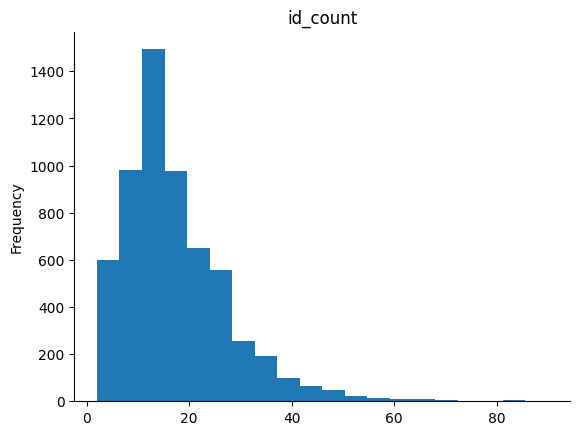

In [ ]:
review_ids_df['id_count'].plot(kind='hist', bins=20, title='id_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
#How long is the longest review?
review_ids_df['id_count'].max()

90

The maximum number of tokens in the review sentence (after being encoded using a tokenizer) is 90. This number is not too large; we can use 512 tokens to train the model. In addition, our team also applies dynamic padding to help the model learn various input string lengths.

# **II. Model**

## **BMRC (baseline)**

In [ ]:
class BMRC(nn.Module):
  def __init__(self, pretrained_model_name:str=pretrained_model_name, pretrained_model=None):
    super(BMRC, self).__init__()
    if pretrained_model is not None:
      self.pretrained_model = pretrained_model
    else:
      self.pretrained_model = BertModel.from_pretrained(pretrained_model_name)

    #Classifier
    self.start_classifier = nn.Linear(self.pretrained_model.config.hidden_size, 2)
    self.end_classifier = nn.Linear(self.pretrained_model.config.hidden_size, 2)
    self.polarity_classifier = nn.Linear(self.pretrained_model.config.hidden_size, 3)

    #Init linear weight
    self.init_linear_params()

  def forward(self, input_ids, attention_mask, token_type_ids, state:int=1):
    features = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)[0]
    if state == 1 or state == 2:
      start_logits = self.start_classifier(features)
      end_logits = self.end_classifier(features)
      return start_logits, end_logits
    else:
      polarity_logits = self.polarity_classifier(features[:, 0, :])
      return polarity_logits

  def init_linear_params(self):
    for param in self.start_classifier.parameters():
      if param.dim() > 1:
        nn.init.xavier_uniform_(param)

    for param in self.end_classifier.parameters():
      if param.dim() > 1:
        nn.init.xavier_uniform_(param)

    for param in self.polarity_classifier.parameters():
      if param.dim() > 1:
        nn.init.xavier_uniform_(param)

  def fine_tune(self, do_fine_tune:bool=True):
    for param in self.pretrained_model.parameters():
      param.requires_grad = do_fine_tune

## **1. ASTE I Model**

In [ ]:
class ASTEModelI(nn.Module):
  def __init__(self, pretrained_model_name:str=pretrained_model_name, pretrained_model=None):
    super(ASTEModelI, self).__init__()
    if pretrained_model is not None:
      self.pretrained_model = pretrained_model
    else:
      self.pretrained_model = DebertaV2Model.from_pretrained(pretrained_model_name)

    #Classifier
    self.start_classifier = nn.Linear(self.pretrained_model.config.hidden_size, 2)
    self.end_classifier = nn.Linear(self.pretrained_model.config.hidden_size, 2)
    self.polarity_classifier = nn.Linear(self.pretrained_model.config.hidden_size, 3)

    #Init linear weight
    self.init_linear_params()

  def forward(self, input_ids, attention_mask, token_type_ids, state:int=1):
    features = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)[0]
    if state == 1 or state == 2:
      start_logits = self.start_classifier(features)
      end_logits = self.end_classifier(features)
      return start_logits, end_logits
    else:
      polarity_logits = self.polarity_classifier(features[:, 0, :])
      return polarity_logits

  def init_linear_params(self):
    for param in self.start_classifier.parameters():
      if param.dim() > 1:
        nn.init.xavier_uniform_(param)

    for param in self.end_classifier.parameters():
      if param.dim() > 1:
        nn.init.xavier_uniform_(param)

    for param in self.polarity_classifier.parameters():
      if param.dim() > 1:
        nn.init.xavier_uniform_(param)

  def fine_tune(self, do_fine_tune:bool=True):
    for param in self.pretrained_model.parameters():
      param.requires_grad = do_fine_tune

## **2. ASTE II Model**

In [ ]:
class ASTEModelII(nn.Module):
  def __init__(self, pretrained_model_name:str=pretrained_model_name, pretrained_model=None):
    super(ASTEModelII, self).__init__()
    if pretrained_model is not None:
      self.pretrained_model_1 = pretrained_model
      self.pretrained_model_2 = pretrained_model
    else:
      self.pretrained_model_1 = DebertaV2Model.from_pretrained(pretrained_model_name)
      self.pretrained_model_2 = DebertaV2Model.from_pretrained(pretrained_model_name)

    #Classifier
    self.start_classifier = nn.Linear(self.pretrained_model_1.config.hidden_size, 2)
    self.end_classifier = nn.Linear(self.pretrained_model_1.config.hidden_size, 2)
    self.polarity_classifier = nn.Linear(self.pretrained_model_1.config.hidden_size, 3)

    #Init linear weight
    self.init_linear_params()

  def forward(self, input_ids, attention_mask, token_type_ids, state:int=1):
    if state == 1:
      features = self.pretrained_model_1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)[0]
      start_logits = self.start_classifier(features)
      end_logits = self.end_classifier(features)
      return start_logits, end_logits
    elif state == 2:
      features = self.pretrained_model_2(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)[0]
      start_logits = self.start_classifier(features)
      end_logits = self.end_classifier(features)
      return start_logits, end_logits
    else:
      features = self.pretrained_model_2(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)[0]
      polarity_logits = self.polarity_classifier(features[:, 0, :])
      return polarity_logits

  def init_linear_params(self):
    for param in self.start_classifier.parameters():
      if param.dim() > 1:
        nn.init.xavier_uniform_(param)

    for param in self.end_classifier.parameters():
      if param.dim() > 1:
        nn.init.xavier_uniform_(param)

    for param in self.polarity_classifier.parameters():
      if param.dim() > 1:
        nn.init.xavier_uniform_(param)

  def fine_tune(self, do_fine_tune:bool=True):
    for param in self.pretrained_model_1.parameters():
      param.requires_grad = do_fine_tune

    for param in self.pretrained_model_2.parameters():
      param.requires_grad = do_fine_tune

## **3. ASTE III Model**

In [ ]:
class ASTEModelIII(nn.Module):
  def __init__(self, pretrained_model_name:str=pretrained_model_name, pretrained_model=None):
    super(ASTEModelIII, self).__init__()
    if pretrained_model is not None:
      self.pretrained_model_1 = pretrained_model
      self.pretrained_model_2 = pretrained_model
      self.pretrained_model_3 = pretrained_model
    else:
      self.pretrained_model_1 = DebertaV2Model.from_pretrained(pretrained_model_name)
      self.pretrained_model_2 = DebertaV2Model.from_pretrained(pretrained_model_name)
      self.pretrained_model_3 = DebertaV2Model.from_pretrained(pretrained_model_name)

    #Classifier
    self.start_classifier = nn.Linear(self.pretrained_model_1.config.hidden_size, 2)
    self.end_classifier = nn.Linear(self.pretrained_model_1.config.hidden_size, 2)
    self.polarity_classifier = nn.Linear(self.pretrained_model_1.config.hidden_size, 3)

    #Init linear weight
    self.init_linear_params()

  def forward(self, input_ids, attention_mask, token_type_ids, state:int=1):
    if state == 1:
      features = self.pretrained_model_1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)[0]
      start_logits = self.start_classifier(features)
      end_logits = self.end_classifier(features)
      return start_logits, end_logits
    elif state == 2:
      features = self.pretrained_model_2(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)[0]
      start_logits = self.start_classifier(features)
      end_logits = self.end_classifier(features)
      return start_logits, end_logits
    else:
      features = self.pretrained_model_3(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)[0]
      polarity_logits = self.polarity_classifier(features[:, 0, :])
      return polarity_logits

  def init_linear_params(self):
    for param in self.start_classifier.parameters():
      if param.dim() > 1:
        nn.init.xavier_uniform_(param)

    for param in self.end_classifier.parameters():
      if param.dim() > 1:
        nn.init.xavier_uniform_(param)

    for param in self.polarity_classifier.parameters():
      if param.dim() > 1:
        nn.init.xavier_uniform_(param)

  def fine_tune(self, do_fine_tune:bool=True):
    for param in self.pretrained_model_1.parameters():
      param.requires_grad = do_fine_tune

    for param in self.pretrained_model_2.parameters():
      param.requires_grad = do_fine_tune

    for param in self.pretrained_model_3.parameters():
      param.requires_grad = do_fine_tune

# **III. Training and Evaluating**

## **1. Preparing training data**

### **BMRC (baseline)**

**Step 1:** As other project first we create the Tokenizer

In [ ]:
#In this experiment we want to try the extreme small deberta
pretrained_model_name = 'google-bert/bert-base-cased'

In [ ]:
#Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)

#Test the tokenizer
tokenizer('I love you!')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

{'input_ids': [101, 146, 1567, 1128, 106, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

**Step 2:** Reading the dataset

In [ ]:
#Reading the dataset
processed_semeval_datasetdict = load_from_disk('/content/drive/MyDrive/CAP_6640-Project_3/data/processed_semeval_aste_dataset_bmrc')

#For training we need train and dev set
processed_train_semeval_dataset = processed_semeval_datasetdict['train']
processed_dev_semeval_dataset = processed_semeval_datasetdict['dev']

**Step 3:** Creating dataset for training

In [ ]:
#Creating dataset for training and evaluating
train_dataset = SemEvalASTEDataset(processed_train_semeval_dataset, tokenizer=tokenizer,
                                   max_length=MAX_INPUT_LENGTH, mode='train', device=DEVICE)
dev_dataset = SemEvalASTEDataset(processed_dev_semeval_dataset, tokenizer=tokenizer,
                                 max_length=MAX_INPUT_LENGTH, mode='dev', device=DEVICE)

**Step 4:**  Creating dataloader

In [ ]:
BATCH_SIZE = 4
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=1, shuffle=False, collate_fn=myvaltestcollator)

### **a. ASTE I Model**

**Step 1:** As other project first we create the Tokenizer

In [ ]:
pretrained_model_name = 'microsoft/deberta-v3-xsmall'

In [ ]:
#Initialize tokenizer
tokenizer = DebertaV2Tokenizer.from_pretrained(pretrained_model_name)

#Test the tokenizer
tokenizer('I love you!')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

{'input_ids': [1, 273, 472, 274, 300, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

**Step 2:** Reading the dataset

In [ ]:
#Reading the dataset
processed_semeval_datasetdict = load_from_disk('/content/drive/MyDrive/CAP_6640-Project_3/data/all_processed_semeval_aste_dataset_xsmall')

#For training we need train and dev set
processed_train_semeval_dataset = processed_semeval_datasetdict['train']
processed_dev_semeval_dataset = processed_semeval_datasetdict['dev']

**Step 3:** Creating dataset for training

In [ ]:
#Creating dataset for training and evaluating
train_dataset = SemEvalASTEDataset(processed_train_semeval_dataset, tokenizer=tokenizer,
                                   max_length=MAX_INPUT_LENGTH, mode='train', device=DEVICE)
dev_dataset = SemEvalASTEDataset(processed_dev_semeval_dataset, tokenizer=tokenizer,
                                 max_length=MAX_INPUT_LENGTH, mode='dev', device=DEVICE)

**Step 4:**  Creating dataloader

In [ ]:
BATCH_SIZE = 4
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=1, shuffle=False, collate_fn=myvaltestcollator)

### **b. ASTEII Model**

**Step 1:** As other project first we create the Tokenizer

In [ ]:
#In this experiment we want to try the extreme small deberta
pretrained_model_name = 'microsoft/deberta-v3-xsmall'

In [ ]:
#Initialize tokenizer
tokenizer = DebertaV2Tokenizer.from_pretrained(pretrained_model_name)

#Test the tokenizer
tokenizer('I love you!')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

{'input_ids': [1, 273, 472, 274, 300, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

**Step 2:** Reading the dataset

In [ ]:
#Reading the dataset
processed_semeval_datasetdict = load_from_disk('/content/drive/MyDrive/CAP_6640-Project_3/data/16res_processed_semeval_aste_dataset')

#For training we need train and dev set
processed_train_semeval_dataset = processed_semeval_datasetdict['train']
processed_dev_semeval_dataset = processed_semeval_datasetdict['dev']

**Step 3:** Creating dataset for training

In [ ]:
#Creating dataset for training and evaluating
train_dataset = SemEvalASTEDataset(processed_train_semeval_dataset, tokenizer=tokenizer,
                                   max_length=MAX_INPUT_LENGTH, mode='train', device=DEVICE)
dev_dataset = SemEvalASTEDataset(processed_dev_semeval_dataset, tokenizer=tokenizer,
                                 max_length=MAX_INPUT_LENGTH, mode='dev', device=DEVICE)

**Step 4:**  Creating dataloader

In [ ]:
BATCH_SIZE = 4
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=1, shuffle=False, collate_fn=myvaltestcollator)

### **c. ASTE III Model**

**Step 1:** As other project first we create the Tokenizer

In [ ]:
#In this experiment we want to try the extreme small deberta
pretrained_model_name = 'microsoft/deberta-v3-xsmall'

In [ ]:
#Initialize tokenizer
tokenizer = DebertaV2Tokenizer.from_pretrained(pretrained_model_name)

#Test the tokenizer
tokenizer('I love you!')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

{'input_ids': [1, 273, 472, 274, 300, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

**Step 2:** Reading the dataset

In [ ]:
#Reading the dataset
processed_semeval_datasetdict = load_from_disk('/content/drive/MyDrive/CAP_6640-Project_3/data/16res_processed_semeval_aste_dataset_xsmall')

#For training we need train and dev set
processed_train_semeval_dataset = processed_semeval_datasetdict['train']
processed_dev_semeval_dataset = processed_semeval_datasetdict['dev']

**Step 3:** Creating dataset for training

In [ ]:
#Creating dataset for training and evaluating
train_dataset = SemEvalASTEDataset(processed_train_semeval_dataset, tokenizer=tokenizer,
                                   max_length=MAX_INPUT_LENGTH, mode='train', device=DEVICE)
dev_dataset = SemEvalASTEDataset(processed_dev_semeval_dataset, tokenizer=tokenizer,
                                 max_length=MAX_INPUT_LENGTH, mode='dev', device=DEVICE)

**Step 4:**  Creating dataloader

In [ ]:
BATCH_SIZE = 4
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=1, shuffle=False, collate_fn=myvaltestcollator)

## **2. Training and validating process**

### **BMRC (baseline)**

In [ ]:
#Model parameters
pretrained_model_name = 'google-bert/bert-base-cased' #Can change to other
pretrained_model = None #If want to load a specific model
do_fine_tune = True #If want to fine tune the pre-trained model or not

In [ ]:
#Initial the transformers model
model = BMRC(pretrained_model_name=pretrained_model_name, pretrained_model=pretrained_model)

#Push model to DEVICE
model.to(DEVICE)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

BMRC(
  (pretrained_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
#Check fine tune
model.fine_tune(do_fine_tune)

In [ ]:
#Training parameters

#Optimizer
betas = (0.9, 0.999) #Adam optimizer betas
eps = 1e-8 #Adam optimizer eps
weight_decay = 0.01 #Adam optimizer weight decay

#Training process
num_epochs = 40 #Default: 20
max_train_steps = len(train_dataloader) * num_epochs #If other please fix this to other number
checkpoint_steps = 400 #Default is 1000
model_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint' #use to save state dict
specific_model_state_path = '' #Use to load a specific model state dict
preload = False #True if want to continue training from previous trained model
beta = 1 #Weight on the sentiment loss .Default is 1
threshold = 0.8 #Threshold for choosing aspect and opinion

#Learning rate scheduler
warmup_steps = 0.1 * max_train_steps #Default

In [ ]:
#Optimizer as in transformer paper
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5, eps=eps, betas=betas)

In [ ]:
#Initialize the scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=max_train_steps
)

In [ ]:
#Initialize the data helper
data_helper = DatasetProcessor(tokenizer)

In [ ]:
tracker = {
    'train_loss': [],
    'dev_loss': [],
    'aspect_f1': [],
    'opinion_f1': [],
    'aspect_opinion_pair_f1': [],
    'aspect_polarity_pair_f1': [],
    'triplet_f1': [],
    'current_aspect_f1': 0,
    'current_opinion_f1': 0,
    'current_aspect_opinion_pair_f1': 0,
    'current_aspect_polarity_pair_f1': 0,
    'current_triplet_f1': 0,
    'completed_steps': 0
}

In [ ]:
#Training!

print("***** Running training *****")
print(f"  Num examples = {train_dataset.__len__()}")
print(f"  Num Epochs = {num_epochs}")
print(f"  Total train batch size = {BATCH_SIZE}")
print(f"  Total optimization steps = {max_train_steps}")

progress_bar = tqdm(range(max_train_steps))
completed_steps = 0
starting_epoch = 0
if preload:
  print('Preloading the state of model and optimizer')
  checkpoint = torch.load(specific_model_state_path)
  starting_epoch = checkpoint['epoch'] + 1
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  model.load_state_dict(checkpoint['model_state_dict'])
  scheduler.load_state_dict(checkpoint['scheduler'])
  loss = checkpoint['loss']
  aspect_f1 = checkpoint['aspect_f1']
  opinion_f1 = checkpoint['opinion_f1']
  aspect_opinion_pair_f1 = checkpoint['aspect_opinion_pair_f1']
  aspect_polarity_pair_f1 = checkpoint['aspect_polarity_pair_f1']
  triplet_f1 = checkpoint['triplet_f1']
  completed_steps = checkpoint['completed_steps']

for epoch in range(starting_epoch, num_epochs):
  model.train()
  total_loss = 0
  active_dataloader = train_dataloader
  print(f'\nProcessing epoch: {epoch}')
  for step, batch in enumerate(active_dataloader):
    #Getting the input
    a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
    a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
    a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
    a2o_stage1_answer_start = batch['a2o_stage1_answer_start']
    a2o_stage1_answer_end = batch['a2o_stage1_answer_end']
    o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
    o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
    o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
    o2a_stage1_answer_start = batch['o2a_stage1_answer_start']
    o2a_stage1_answer_end = batch['o2a_stage1_answer_end']
    a2o_stage2_input_ids = batch['a2o_stage2_input_ids']
    a2o_stage2_token_type_ids = batch['a2o_stage2_token_type_ids']
    a2o_stage2_attention_mask = batch['a2o_stage2_attention_mask']
    a2o_stage2_answer_start = batch['a2o_stage2_answer_start']
    a2o_stage2_answer_end = batch['a2o_stage2_answer_end']
    o2a_stage2_input_ids = batch['o2a_stage2_input_ids']
    o2a_stage2_token_type_ids = batch['o2a_stage2_token_type_ids']
    o2a_stage2_attention_mask = batch['o2a_stage2_attention_mask']
    o2a_stage2_answer_start = batch['o2a_stage2_answer_start']
    o2a_stage2_answer_end = batch['o2a_stage2_answer_end']
    stage3_input_ids = batch['stage3_input_ids']
    stage3_token_type_ids = batch['stage3_token_type_ids']
    stage3_attention_mask = batch['stage3_attention_mask']
    stage3_answer = batch['stage3_answer']


    #Input into model
    #Stage 1: Extracting a2o: aspect; o2a: opnion
    ##A2O
    a2o_stage1_start_logits, a2o_stage1_end_logits = model(
        input_ids=a2o_stage1_input_ids,
        token_type_ids=a2o_stage1_token_type_ids,
        attention_mask=a2o_stage1_attention_mask,
        state=1
    ) #Tracking the aspect

    a2o_stage1_loss = calculate_entity_loss(a2o_stage1_start_logits, a2o_stage1_end_logits,
                                            a2o_stage1_answer_start, a2o_stage1_answer_end)

    ##O2A
    o2a_stage1_start_logits, o2a_stage1_end_logits = model(
        input_ids=o2a_stage1_input_ids,
        token_type_ids=o2a_stage1_token_type_ids,
        attention_mask=o2a_stage1_attention_mask,
        state=1
    ) #Tracking the opinion

    o2a_stage1_loss = calculate_entity_loss(o2a_stage1_start_logits, o2a_stage1_end_logits,
                                            o2a_stage1_answer_start, o2a_stage1_answer_end)

    #Stage 2: Extracting a2o: opinion; o2a: aspect
    ##A2O
    a2o_stage2_start_logits, a2o_stage2_end_logits = model(
        input_ids=a2o_stage2_input_ids,
        token_type_ids=a2o_stage2_token_type_ids,
        attention_mask=a2o_stage2_attention_mask,
        state=2
    )

    a2o_stage2_loss = calculate_entity_loss(a2o_stage2_start_logits, a2o_stage2_end_logits,
                                            a2o_stage2_answer_start, a2o_stage2_answer_end)

    ##O2A
    o2a_stage2_start_logits, o2a_stage2_end_logits = model(
        input_ids=o2a_stage2_input_ids,
        token_type_ids=o2a_stage2_token_type_ids,
        attention_mask=o2a_stage2_attention_mask,
        state=2
    )

    o2a_stage2_loss = calculate_entity_loss(o2a_stage2_start_logits, o2a_stage2_end_logits,
                                            o2a_stage2_answer_start, o2a_stage2_answer_end)

    #Stage 3: Sentiment classification
    stage3_polarity_logits = model(
        input_ids=stage3_input_ids,
        token_type_ids=stage3_token_type_ids,
        attention_mask=stage3_attention_mask,
        state=3
    )

    stage3_polarity_loss = calculate_polarity_loss(stage3_polarity_logits, stage3_answer)

    ##Compute loss
    loss = a2o_stage1_loss + o2a_stage1_loss + a2o_stage2_loss + o2a_stage2_loss + beta*stage3_polarity_loss


    total_loss += loss.detach().float()

    #Back-propagation
    loss.backward()

    #Update weights
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


    progress_bar.update(1)
    completed_steps += 1
    if isinstance(checkpoint_steps, int):
      if completed_steps % checkpoint_steps == 0:
        specific_model_state_path = model_path + f'/by_steps/bmrc_alldata_step_{completed_steps}'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            }, specific_model_state_path)

    if completed_steps >= max_train_steps:
      break

  print(f"\nepoch {epoch} ---- loss: {total_loss/len(train_dataloader)}")
  tracker['train_loss'].append(total_loss/len(train_dataloader))
  ##Validation
  print('Validating...')
  model.eval()
  eval_total_loss = 0

  #Count match
  match_aspects_num = 0
  match_opinions_num = 0
  match_aspect_opinion_pairs_num = 0
  match_aspect_polarity_pairs_num = 0
  match_triplets_num = 0

  #Count target
  target_aspects_num = 0
  target_opinions_num = 0
  target_aspect_opinion_pairs_num = 0
  target_aspect_polarity_pairs_num = 0
  target_triplets_num = 0

  #Count predict
  predicted_aspects_num = 0
  predicted_opinions_num = 0
  predicted_aspect_opinion_pairs_num = 0
  predicted_aspect_polarity_pairs_num = 0
  predicted_triplets_num = 0
  for step, batch in enumerate(dev_dataloader):
    a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
    a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
    a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
    o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
    o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
    o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
    ground_truth_aspects = batch['ground_truth_aspects']
    ground_truth_opinions = batch['ground_truth_opinions']
    ground_truth_aspect_opinion_pairs = batch['ground_truth_aspect_opinion_pairs']
    ground_truth_aspect_polarity_pairs = batch['ground_truth_aspect_polarity_pairs']
    ground_truth_triplets = batch['ground_truth_triplets']
    with torch.no_grad():
      #Stage 1:
      ##A2O -> Extracting aspects
      a2o_stage1_start_logits, a2o_stage1_end_logits = model(
          input_ids=a2o_stage1_input_ids,
          token_type_ids=a2o_stage1_token_type_ids,
          attention_mask=a2o_stage1_attention_mask,
          state=1
      )

      ###Gathering the aspects for creating next stage input
      predicted_aspects, predicted_aspects_probs, a2o_stage1_filtered_contexts = data_helper.gather_terms(
          input_ids=a2o_stage1_input_ids,
          answer_start_logits=a2o_stage1_start_logits,
          answer_end_logits=a2o_stage1_end_logits,
          stage=1,
          direction='A2O',
          )

      ##O2A -> Extracting opinions
      o2a_stage1_start_logits, o2a_stage1_end_logits = model(
          input_ids=o2a_stage1_input_ids,
          token_type_ids=o2a_stage1_token_type_ids,
          attention_mask=o2a_stage1_attention_mask,
          state=1
      )

      ###Gathering the opinions for creating next stage input
      predicted_opinions, predicted_opinions_probs, o2a_stage1_filtered_contexts = data_helper.gather_terms(
          input_ids=o2a_stage1_input_ids,
          answer_start_logits=o2a_stage1_start_logits,
          answer_end_logits=o2a_stage1_end_logits,
          stage=1,
          direction='O2A',
          )

      #Stage 2
      ##A2O -> Extracting opinions based on previous aspect
      a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask = data_helper.create_next_stage_input(
          terms=predicted_aspects,
          prev_stage_filtered_contexts=a2o_stage1_filtered_contexts,
          stage=2,
          direction='A2O'
      )

      a2o_stage2_start_logits, a2o_stage2_end_logits = model(
          input_ids=a2o_stage2_input_ids,
          token_type_ids=a2o_stage2_token_type_ids,
          attention_mask=a2o_stage2_attention_mask,
          state=2
      )

      stage2_predicted_opinions, stage2_predicted_opinions_probs, a2o_predicted_pairs, a2o_predicted_pairs_probs, a2o_pairs_probs_pairs, a2o_stage2_filtered_contexts =\
      data_helper.gather_terms(
          input_ids=a2o_stage2_input_ids,
          answer_start_logits=a2o_stage2_start_logits,
          answer_end_logits=a2o_stage2_end_logits,
          prev_stage_terms = predicted_aspects,
          prev_stage_terms_probs = predicted_aspects_probs,
          stage=2,
          direction='A2O',
          threshold=threshold
      )

      ##O2A -> Extracting aspects based on previous opinions
      o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask = data_helper.create_next_stage_input(
          terms=predicted_opinions,
          prev_stage_filtered_contexts=o2a_stage1_filtered_contexts,
          stage=2,
          direction='O2A'
      )

      o2a_stage2_start_logits, o2a_stage2_end_logits = model(
          input_ids=o2a_stage2_input_ids,
          token_type_ids=o2a_stage2_token_type_ids,
          attention_mask=o2a_stage2_attention_mask,
          state=2
      )

      stage2_predicted_aspects, stage2_predicted_aspects_probs, o2a_predicted_pairs, o2a_predicted_pairs_probs, o2a_pairs_probs_pairs, o2a_stage2_filtered_contexts =\
      data_helper.gather_terms(
          input_ids=o2a_stage2_input_ids,
          answer_start_logits=o2a_stage2_start_logits,
          answer_end_logits=o2a_stage2_end_logits,
          prev_stage_terms = predicted_opinions,
          prev_stage_terms_probs = predicted_opinions_probs,
          stage=2,
          direction='O2A',
          threshold=threshold
      )

      #Stage 3: Polarity classification
      final_predicted_aspects = []
      final_predicted_aspects_probs = []
      final_predicted_opinions = []
      final_predicted_opinions_probs = []
      final_predicted_aspect_opinion_pairs = []
      final_stage2_filtered_contexts = []
      final_predicted_aspect_opinion_pairs_probs = []
      all_pairs = a2o_predicted_pairs + o2a_predicted_pairs
      all_stage2_filtered_contexts = a2o_stage2_filtered_contexts + o2a_stage2_filtered_contexts
      all_pairs_probs_pairs = a2o_pairs_probs_pairs + o2a_pairs_probs_pairs
      all_predicted_aspect_opinion_pairs_probs = a2o_predicted_pairs_probs + o2a_predicted_pairs_probs
      for i in range(len(all_pairs)):
        pair = all_pairs[i]
        stage2_filtered_context = all_stage2_filtered_contexts[i]
        pairs_probs_pair = all_pairs_probs_pairs[i]
        predicted_aspect_opinion_pairs_probs = all_predicted_aspect_opinion_pairs_probs[i]
        if pair[0] not in final_predicted_aspects:
          final_predicted_aspects.append(pair[0])
          final_predicted_aspects_probs.append(pairs_probs_pair[0])
        if pair[1] not in final_predicted_opinions:
          final_predicted_opinions.append(pair[1])
          final_predicted_opinions_probs.append(pairs_probs_pair[1])
        if pair not in final_predicted_aspect_opinion_pairs:
          final_predicted_aspect_opinion_pairs.append(pair)
          final_stage2_filtered_contexts.append(stage2_filtered_context)
          final_predicted_aspect_opinion_pairs_probs.append(predicted_aspect_opinion_pairs_probs)

      ##Creating input for stage 3
      stage3_input_ids, stage3_token_type_ids, stage3_attention_mask = data_helper.create_next_stage_input(
          terms=None,
          pairs=final_predicted_aspect_opinion_pairs,
          prev_stage_filtered_contexts=final_stage2_filtered_contexts,
          stage=3
      )

      ##Run through model
      polarity_logits = model(
          input_ids=stage3_input_ids,
          token_type_ids=stage3_token_type_ids,
          attention_mask=stage3_attention_mask,
          state=3
      )

      final_predicted_triplets, final_predicted_aspect_polarity_pairs = data_helper.gather_polarity(
          pairs=final_predicted_aspect_opinion_pairs,
          polarity_logits=polarity_logits
      )


    #Count data for calculate f1 later
    target_aspects_num += len(ground_truth_aspects[0])
    target_opinions_num += len(ground_truth_opinions[0])
    target_aspect_opinion_pairs_num += len(ground_truth_aspect_opinion_pairs[0])
    target_aspect_polarity_pairs_num += len(ground_truth_aspect_polarity_pairs[0])
    target_triplets_num += len(ground_truth_triplets[0])

    #Count the precdicted
    predicted_aspects_num += len(final_predicted_aspects)
    predicted_opinions_num += len(final_predicted_opinions)
    predicted_aspect_opinion_pairs_num += len(final_predicted_aspect_opinion_pairs)
    predicted_aspect_polarity_pairs_num += len(final_predicted_aspect_polarity_pairs)
    predicted_triplets_num += len(final_predicted_triplets)

    #Count the match data
    ##Aspects
    for aspect in final_predicted_aspects:
      for ground_truth_aspect in ground_truth_aspects[0]:
        if aspect == ground_truth_aspect:
          match_aspects_num += 1

    ##Opinion
    for opinion in final_predicted_opinions:
      for ground_truth_opinion in ground_truth_opinions[0]:
        if opinion == ground_truth_opinion:
          match_opinions_num += 1

    ##Aspect-Opinion
    for aspect_opinion_pair in final_predicted_aspect_opinion_pairs:
      for ground_truth_aspect_opinion_pair in ground_truth_aspect_opinion_pairs[0]:
        if list(aspect_opinion_pair) == ground_truth_aspect_opinion_pair:
          match_aspect_opinion_pairs_num += 1

    ##Aspect-Polarity
    for aspect_polarity_pair in final_predicted_aspect_polarity_pairs:
      for ground_truth_aspect_polarity_pair in ground_truth_aspect_polarity_pairs[0]:
        if aspect_polarity_pair == ground_truth_aspect_polarity_pair:
          match_aspect_polarity_pairs_num += 1

    ##Triplets
    for triplet in final_predicted_triplets:
      for ground_truth_triplet in ground_truth_triplets[0]:
        if triplet == ground_truth_triplet:
          match_triplets_num += 1

    if step % 100 == 0:
      print(f'Step: {step}')
      print(f'Predicted aspects: {final_predicted_aspects}')
      print(f'Reference aspects: {ground_truth_aspects}')
      print(f'Predicted opinions: {final_predicted_opinions}')
      print(f'Reference opinions: {ground_truth_opinions}')
      print(f'Predicted aspect-opinion pairs: {final_predicted_aspect_opinion_pairs}')
      print(f'Reference aspect-opinion pairs: {ground_truth_aspect_opinion_pairs}')
      print(f'Predicted aspect-polarity pairs: {final_predicted_aspect_polarity_pairs}')
      print(f'Reference aspect-polarity pairs: {ground_truth_aspect_polarity_pairs}')
      print(f'Predicted triplets: {final_predicted_triplets}')
      print(f'Reference triplets: {ground_truth_triplets}')

  #Calculate F1-score
  ##Aspect
  precision_aspects = match_aspects_num / (predicted_aspects_num + 1e-6)
  recall_aspects = match_aspects_num / (target_aspects_num + 1e-6)
  f1_aspects = 2 * precision_aspects * recall_aspects / (precision_aspects + recall_aspects + 1e-6)

  ##Opinion
  precision_opinions = match_opinions_num / (predicted_opinions_num + 1e-6)
  recall_opinions = match_opinions_num / (target_opinions_num + 1e-6)
  f1_opinions = 2 * precision_opinions * recall_opinions / (precision_opinions + recall_opinions + 1e-6)

  ##Aspect-Opinion
  aspect_opinion_precision = match_aspect_opinion_pairs_num / (predicted_aspect_opinion_pairs_num + 1e-6)
  aspect_opinion_recall = match_aspect_opinion_pairs_num / (target_aspect_opinion_pairs_num + 1e-6)
  aspect_opinion_f1 = 2 * aspect_opinion_precision * aspect_opinion_recall / (aspect_opinion_precision + aspect_opinion_recall + 1e-6)

  ##Aspect-Polarity
  aspect_polarity_precision = match_aspect_polarity_pairs_num / (predicted_aspect_polarity_pairs_num + 1e-6)
  aspect_polarity_recall = match_aspect_polarity_pairs_num / (target_aspect_polarity_pairs_num + 1e-6)
  aspect_polarity_f1 = 2 * aspect_polarity_precision * aspect_polarity_recall / (aspect_polarity_precision + aspect_polarity_recall + 1e-6)

  #Triplet
  triplet_precision = match_triplets_num / (predicted_triplets_num + 1e-6)
  triplet_recall = match_triplets_num / (target_triplets_num + 1e-6)
  triplet_f1 = 2 * triplet_precision * triplet_recall / (triplet_precision + triplet_recall + 1e-6)

  #Print F1 - result
  print(f'\nResults of epoch {epoch}:')
  print(f'\tAspect Precision: {precision_aspects}')
  print(f'\tAspect Recall: {recall_aspects}')
  print(f'\tAspect F1: {f1_aspects}')
  print(f'\tOpinion Precision: {precision_opinions}')
  print(f'\tOpinion Recall: {recall_opinions}')
  print(f'\tOpinion F1: {f1_opinions}')
  print(f'\tAspect-Opinion Precision: {aspect_opinion_precision}')
  print(f'\tAspect-Opinion Recall: {aspect_opinion_recall}')
  print(f'\tAspect-Opinion F1: {aspect_opinion_f1}')
  print(f'\tAspect-Polarity Precision: {aspect_polarity_precision}')
  print(f'\tAspect-Polarity Recall: {aspect_polarity_recall}')
  print(f'\tAspect-Polarity F1: {aspect_polarity_f1}')
  print(f'\tTriplet Precision: {triplet_precision}')
  print(f'\tTriplet Recall: {triplet_recall}')
  print(f'\tTriplet F1: {triplet_f1}')

  tracker['aspect_f1'].append(f1_aspects)
  tracker['opinion_f1'].append(f1_opinions)
  tracker['aspect_opinion_pair_f1'].append(aspect_opinion_f1)
  tracker['aspect_polarity_pair_f1'].append(aspect_polarity_f1)
  tracker['triplet_f1'].append(triplet_f1)

  #Save model
  if f1_aspects > tracker['current_aspect_f1']:
    tracker['current_aspect_f1'] = f1_aspects
    specific_model_state_path = model_path + f'/by_metric/bmrc_alldata_aspect_f1_{f1_aspects}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'aspect_f1': f1_aspects,
            'opinion_f1': f1_opinions,
            'aspect_opinion_pair_f1': aspect_opinion_f1,
            'aspect_polarity_pair_f1': aspect_polarity_f1,
            'triplet_f1': triplet_f1
            }, specific_model_state_path)

  if f1_opinions > tracker['current_opinion_f1']:
    tracker['current_opinion_f1'] = f1_opinions
    specific_model_state_path = model_path + f'/by_metric/bmrc_alldata_opinion_f1_{f1_opinions}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'aspect_f1': f1_aspects,
            'opinion_f1': f1_opinions,
            'aspect_opinion_pair_f1': aspect_opinion_f1,
            'aspect_polarity_pair_f1': aspect_polarity_f1,
            'triplet_f1': triplet_f1
            }, specific_model_state_path)

  if aspect_opinion_f1 > tracker['current_aspect_opinion_pair_f1']:
    tracker['current_aspect_opinion_pair_f1'] = aspect_opinion_f1
    specific_model_state_path = model_path + f'/by_metric/bmrc_alldata_aspect_opinion_pair_f1_{aspect_opinion_f1}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'aspect_f1': f1_aspects,
            'opinion_f1': f1_opinions,
            'aspect_opinion_pair_f1': aspect_opinion_f1,
            'aspect_polarity_pair_f1': aspect_polarity_f1,
            'triplet_f1': triplet_f1
            }, specific_model_state_path)

  if aspect_polarity_f1 > tracker['current_aspect_polarity_pair_f1']:
    tracker['current_aspect_polarity_pair_f1'] = aspect_polarity_f1
    specific_model_state_path = model_path + f'/by_metric/bmrc_alldata_aspect_polarity_pair_f1_{aspect_polarity_f1}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'aspect_f1': f1_aspects,
            'opinion_f1': f1_opinions,
            'aspect_opinion_pair_f1': aspect_opinion_f1,
            'aspect_polarity_pair_f1': aspect_polarity_f1,
            'triplet_f1': triplet_f1
            }, specific_model_state_path)

  if triplet_f1 > tracker['current_triplet_f1']:
    tracker['current_triplet_f1'] = triplet_f1
    specific_model_state_path = model_path + f'/by_metric/bmrc_alldata_triplet_f1_{triplet_f1}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'aspect_f1': f1_aspects,
            'opinion_f1': f1_opinions,
            'aspect_opinion_pair_f1': aspect_opinion_f1,
            'aspect_polarity_pair_f1': aspect_polarity_f1,
            'triplet_f1': triplet_f1
            }, specific_model_state_path)

  if completed_steps >= max_train_steps:
    break

***** Running training *****
  Num examples = 3634
  Num Epochs = 40
  Total train batch size = 4
  Total optimization steps = 36360


  0%|          | 0/36360 [00:00<?, ?it/s]


Processing epoch: 0


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  2%|▎         | 909/36360 [03:15<1:41:37,  5.81it/s]


epoch 0 ---- loss: 108.26493835449219
Validating...
Step: 0
Predicted aspects: ['food']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('food', 'sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'pos']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'pos'], ['food', 'sweet', 'pos']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opinion pairs: [('lobster roll', 'recommend')]
Reference aspect-opinion pairs: [[['lobster', 'fresh'], ['lobster 

  3%|▎         | 910/36360 [04:06<152:12:02, 15.46s/it]


Processing epoch: 1


  5%|▌         | 1818/36360 [07:12<1:40:11,  5.75it/s]


epoch 1 ---- loss: 36.672725677490234
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'pos'], ['Thai fusion stuff', 'pos']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'pos'], ['Thai fusion stuff', 'sweet', 'pos']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opinion pairs: [('lobster roll', 're

  5%|▌         | 1819/36360 [08:00<140:40:59, 14.66s/it]


Processing epoch: 2


  8%|▊         | 2727/36360 [11:06<1:31:55,  6.10it/s]


epoch 2 ---- loss: 24.313886642456055
Validating...
Step: 0
Predicted aspects: ['food']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opinion pairs: [('lobster roll', 'recommend')]
Reference aspect-opinion pairs: [[['lobster', 'fresh'], ['lobster roll', 'recommend']]]
Predicted aspect-polarity pairs:

  8%|▊         | 2728/36360 [11:56<140:34:57, 15.05s/it]


Processing epoch: 3


 10%|█         | 3636/36360 [15:23<1:28:41,  6.15it/s]


epoch 3 ---- loss: 16.636457443237305
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opinion pairs: [('lobste

 10%|█         | 3637/36360 [16:11<132:53:41, 14.62s/it]


Processing epoch: 4


 12%|█▎        | 4545/36360 [19:04<1:30:19,  5.87it/s]


epoch 4 ---- loss: 12.447794914245605
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opinion pairs: [('lobster roll', 're

 13%|█▎        | 4546/36360 [19:55<136:56:19, 15.50s/it]


Processing epoch: 5


 15%|█▌        | 5454/36360 [22:35<1:26:57,  5.92it/s]


epoch 5 ---- loss: 8.934488296508789
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo', 'lobster']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['

 15%|█▌        | 5455/36360 [23:18<111:33:28, 12.99s/it]


Processing epoch: 6


 18%|█▊        | 6363/36360 [25:58<1:26:20,  5.79it/s]


epoch 6 ---- loss: 7.303582191467285
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opinion pairs: [('lobster roll', 'rec

 18%|█▊        | 6364/36360 [26:30<79:53:15,  9.59s/it]


Results of epoch 6:
	Aspect Precision: 0.8575539556006418
	Aspect Recall: 0.6970760225765192
	Aspect F1: 0.7690317624003182
	Opinion Precision: 0.8356353579618296
	Opinion Recall: 0.6930125994352662
	Opinion F1: 0.7576701358397132
	Aspect-Opinion Precision: 0.7543859639669349
	Aspect-Opinion Recall: 0.608080807466585
	Aspect-Opinion F1: 0.6733775810752893
	Aspect-Polarity Precision: 0.6892086321018581
	Aspect-Polarity Recall: 0.5602339174734107
	Aspect-Polarity F1: 0.6180640206597092
	Triplet Precision: 0.6140350869498307
	Triplet Recall: 0.49494949444954595
	Triplet F1: 0.5480979391573405

Processing epoch: 7


 20%|██        | 7272/36360 [29:12<1:21:19,  5.96it/s]


epoch 7 ---- loss: 6.030499458312988
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opinion pairs: [('lobster

 20%|██        | 7273/36360 [29:44<77:22:05,  9.58s/it]


Results of epoch 7:
	Aspect Precision: 0.8660714272826318
	Aspect Recall: 0.6807017535898225
	Aspect F1: 0.7622784845720677
	Opinion Precision: 0.8448519028986574
	Opinion Recall: 0.6861397472094619
	Opinion F1: 0.7572687838094847
	Aspect-Opinion Precision: 0.7741083213023668
	Aspect-Opinion Recall: 0.5919191913212938
	Aspect-Opinion F1: 0.670863846992947
	Aspect-Polarity Precision: 0.7098214275151467
	Aspect-Polarity Recall: 0.5578947361895968
	Aspect-Polarity F1: 0.6247539267954837
	Triplet Precision: 0.6380449132918825
	Triplet Recall: 0.487878787385981
	Triplet F1: 0.5529474189654524

Processing epoch: 8


 22%|██▎       | 8181/36360 [32:23<1:17:53,  6.03it/s]


epoch 8 ---- loss: 4.9885334968566895
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo', 'lobster']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend', 'not to much', 'fresh']
Reference opinions: [['fresh', 'recommend']

 23%|██▎       | 8182/36360 [33:13<119:28:39, 15.26s/it]


Processing epoch: 9


 25%|██▌       | 9090/36360 [35:53<1:15:02,  6.06it/s]


epoch 9 ---- loss: 4.309858322143555
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opinion pairs: [('lobster

 25%|██▌       | 9091/36360 [36:25<73:13:09,  9.67s/it]


Results of epoch 9:
	Aspect Precision: 0.8236842094425207
	Aspect Recall: 0.7321637418337266
	Aspect F1: 0.775231698912799
	Opinion Precision: 0.8161209057731474
	Opinion Recall: 0.7422680403868637
	Opinion F1: 0.7774440112882846
	Aspect-Opinion Precision: 0.7186788146712086
	Aspect-Opinion Recall: 0.6373737367299255
	Aspect-Opinion F1: 0.67558836617083
	Aspect-Polarity Precision: 0.6749999991118422
	Aspect-Polarity Recall: 0.5999999992982457
	Aspect-Polarity F1: 0.6352936185908116
	Triplet Precision: 0.5933940767728997
	Triplet Recall: 0.5262626257310479
	Triplet F1: 0.5578153470250543

Processing epoch: 10


 28%|██▊       | 9999/36360 [39:04<1:13:44,  5.96it/s]


epoch 10 ---- loss: 3.7726259231567383
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'lobster']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend', 'fresh']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opi

 28%|██▊       | 10000/36360 [39:36<70:50:34,  9.68s/it]


Results of epoch 10:
	Aspect Precision: 0.8264248693958227
	Aspect Recall: 0.7461988295366095
	Aspect F1: 0.7842650196982617
	Opinion Precision: 0.805790107592533
	Opinion Recall: 0.7651775478062113
	Opinion F1: 0.7849583713274773
	Aspect-Opinion Precision: 0.7135076244950898
	Aspect-Opinion Recall: 0.6616161609478625
	Aspect-Opinion F1: 0.6865823092169904
	Aspect-Polarity Precision: 0.6683937815176246
	Aspect-Polarity Recall: 0.6035087712239664
	Aspect-Polarity F1: 0.6342957512901858
	Triplet Precision: 0.5838779950066688
	Triplet Recall: 0.5414141408672585
	Triplet F1: 0.5618443638551612

Processing epoch: 11


 30%|███       | 10908/36360 [42:18<1:10:14,  6.04it/s]


epoch 11 ---- loss: 3.401705265045166
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opinion pairs: [('lobste

 30%|███       | 10909/36360 [42:55<80:55:37, 11.45s/it]


Processing epoch: 12


 32%|███▎      | 11817/36360 [45:35<1:08:18,  5.99it/s]


epoch 12 ---- loss: 3.080131769180298
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opinion pairs: [('lobste

 33%|███▎      | 11818/36360 [46:17<87:39:09, 12.86s/it]


Processing epoch: 13


 35%|███▌      | 12726/36360 [48:57<1:05:43,  5.99it/s]


epoch 13 ---- loss: 2.8699681758880615
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'lobster']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend', 'fresh']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opi

 35%|███▌      | 12727/36360 [49:32<69:18:57, 10.56s/it]


Processing epoch: 14


 38%|███▊      | 13635/36360 [52:13<1:02:36,  6.05it/s]


epoch 14 ---- loss: 2.6608076095581055
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend', 'fresh']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opinion pairs:

 38%|███▊      | 13636/36360 [52:51<72:53:12, 11.55s/it]


Processing epoch: 15


 40%|████      | 14544/36360 [55:31<1:00:41,  5.99it/s]


epoch 15 ---- loss: 2.6071910858154297
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'lobster']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend', 'fresh']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opi

 40%|████      | 14545/36360 [56:06<64:07:50, 10.58s/it]


Processing epoch: 16


 42%|████▎     | 15453/36360 [58:46<58:08,  5.99it/s]


epoch 16 ---- loss: 1.9958055019378662
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend', 'fresh']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opinion pairs:

 43%|████▎     | 15454/36360 [59:18<56:16:29,  9.69s/it]


Results of epoch 16:
	Aspect Precision: 0.8090575265495012
	Aspect Recall: 0.7730994143004685
	Aspect F1: 0.7906693557721332
	Opinion Precision: 0.8014101048162043
	Opinion Recall: 0.7812142029997546
	Opinion F1: 0.7911827938274647
	Aspect-Opinion Precision: 0.6966292127715739
	Aspect-Opinion Recall: 0.6888888881930415
	Aspect-Opinion F1: 0.6927369294799198
	Aspect-Polarity Precision: 0.6083231326703511
	Aspect-Polarity Recall: 0.581286549027735
	Aspect-Polarity F1: 0.5944971072030654
	Triplet Precision: 0.5291113375596411
	Triplet Recall: 0.5232323227038057
	Triplet F1: 0.526154908318614

Processing epoch: 17


 45%|████▌     | 16362/36360 [1:01:58<54:23,  6.13it/s]


epoch 17 ---- loss: 2.0422472953796387
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend', 'fresh']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opinion pairs:

 45%|████▌     | 16363/36360 [1:02:30<54:09:43,  9.75s/it]


Results of epoch 17:
	Aspect Precision: 0.8009478663495878
	Aspect Recall: 0.7906432739290722
	Aspect F1: 0.7957617121510409
	Opinion Precision: 0.7722222213641975
	Opinion Recall: 0.7961053828223306
	Opinion F1: 0.7839814507265567
	Aspect-Opinion Precision: 0.6657032748885324
	Aspect-Opinion Recall: 0.6979797972747679
	Aspect-Opinion F1: 0.6814590656833686
	Aspect-Polarity Precision: 0.6398104257822151
	Aspect-Polarity Recall: 0.6315789466297322
	Aspect-Polarity F1: 0.6356675392966106
	Triplet Precision: 0.5472061651761019
	Triplet Recall: 0.573737373157841
	Triplet F1: 0.560157290655146

Processing epoch: 18


 48%|████▊     | 17271/36360 [1:05:15<52:58,  6.01it/s]


epoch 18 ---- loss: 2.096944570541382
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend', 'fresh']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opinion pairs: 

 48%|████▊     | 17272/36360 [1:05:47<51:20:25,  9.68s/it]


Results of epoch 18:
	Aspect Precision: 0.8188679234982793
	Aspect Recall: 0.7614035078813994
	Aspect F1: 0.7890904087959082
	Opinion Precision: 0.7865566028460418
	Opinion Recall: 0.764032072435244
	Opinion F1: 0.7751302371480964
	Aspect-Opinion Precision: 0.6787190075633068
	Aspect-Opinion Recall: 0.6636363629660239
	Aspect-Opinion F1: 0.6710924513698361
	Aspect-Polarity Precision: 0.6616352192935406
	Aspect-Polarity Recall: 0.6152046776430354
	Aspect-Polarity F1: 0.6375752574644866
	Triplet Precision: 0.5547520655426115
	Triplet Recall: 0.5424242418763392
	Triplet F1: 0.5485183963367977

Processing epoch: 19


 50%|█████     | 18180/36360 [1:08:39<1:00:08,  5.04it/s]


epoch 19 ---- loss: 1.964860439300537
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neu'], ['Thai fusion stuff', 'neu']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neu'], ['Thai fusion stuff', 'sweet', 'neu']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opinion pairs: [('lobster roll', 're

 50%|█████     | 18181/36360 [1:09:15<55:36:23, 11.01s/it]


Results of epoch 19:
	Aspect Precision: 0.842312745279484
	Aspect Recall: 0.7497076014623303
	Aspect F1: 0.7933163323934301
	Opinion Precision: 0.8203517577633772
	Opinion Recall: 0.7479954172417006
	Opinion F1: 0.7825039938356713
	Aspect-Opinion Precision: 0.7381489833655204
	Aspect-Opinion Recall: 0.6606060599387817
	Aspect-Opinion F1: 0.6972276457830179
	Aspect-Polarity Precision: 0.685939552318082
	Aspect-Polarity Recall: 0.6105263150754078
	Aspect-Polarity F1: 0.6460391048530029
	Triplet Precision: 0.612866816464033
	Triplet Recall: 0.5484848479308234
	Triplet F1: 0.5788907589156461

Processing epoch: 20


 52%|█████▎    | 19089/36360 [1:12:09<1:00:18,  4.77it/s]


epoch 20 ---- loss: 1.6708976030349731
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'lobster']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend', 'fresh']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opi

 55%|█████▌    | 19998/36360 [1:15:35<46:07,  5.91it/s]


epoch 21 ---- loss: 1.5206260681152344
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend', 'fresh']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opinio

 55%|█████▌    | 19999/36360 [1:16:08<44:40:30,  9.83s/it]


Results of epoch 21:
	Aspect Precision: 0.7907253260514562
	Aspect Recall: 0.7777777768680961
	Aspect F1: 0.7841976123171743
	Opinion Precision: 0.7877412022840622
	Opinion Recall: 0.7949599074513632
	Opinion F1: 0.7913335926089681
	Aspect-Opinion Precision: 0.6669950732344876
	Aspect-Opinion Recall: 0.683838383147638
	Aspect-Opinion F1: 0.6753112201027327
	Aspect-Polarity Precision: 0.642092745966596
	Aspect-Polarity Recall: 0.6315789466297322
	Aspect-Polarity F1: 0.636791952113717
	Triplet Precision: 0.5527093590613701
	Triplet Recall: 0.5666666660942761
	Triplet F1: 0.5596004970262114

Processing epoch: 22


 57%|█████▊    | 20907/36360 [1:19:04<45:15,  5.69it/s]


epoch 22 ---- loss: 1.6820873022079468
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'lobster']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend', 'fresh']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opi

 58%|█████▊    | 20908/36360 [1:19:37<43:56:54, 10.24s/it]


Results of epoch 22:
	Aspect Precision: 0.8203821645600228
	Aspect Recall: 0.753216373388051
	Aspect F1: 0.7853653536120068
	Opinion Precision: 0.8146341453480072
	Opinion Recall: 0.7651775478062113
	Opinion F1: 0.7891312184003925
	Aspect-Opinion Precision: 0.7107258930544682
	Aspect-Opinion Recall: 0.6626262619569432
	Aspect-Opinion F1: 0.6858332688459573
	Aspect-Polarity Precision: 0.6713375787626273
	Aspect-Polarity Recall: 0.6163742682849424
	Aspect-Polarity F1: 0.6426824269568123
	Triplet Precision: 0.5893824478988272
	Triplet Recall: 0.5494949489399041
	Triplet F1: 0.5687396986600347

Processing epoch: 23


 60%|██████    | 21816/36360 [1:22:28<43:47,  5.53it/s]


epoch 23 ---- loss: 1.425994873046875
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'lobster']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend', 'fresh']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opin

 60%|██████    | 21817/36360 [1:23:01<40:03:44,  9.92s/it]


Results of epoch 23:
	Aspect Precision: 0.7861339591232268
	Aspect Recall: 0.7824561394357238
	Aspect F1: 0.7842902376533714
	Opinion Precision: 0.7676991141950231
	Opinion Recall: 0.7949599074513632
	Opinion F1: 0.781091226904212
	Aspect-Opinion Precision: 0.663751214126578
	Aspect-Opinion Recall: 0.6898989892021222
	Aspect-Opinion F1: 0.6765720601903279
	Aspect-Polarity Precision: 0.63572267845391
	Aspect-Polarity Recall: 0.6327485372716392
	Aspect-Polarity F1: 0.6342316211822379
	Triplet Precision: 0.5432458692485462
	Triplet Recall: 0.5646464640761146
	Triplet F1: 0.5537389746261038

Processing epoch: 24


 62%|██████▎   | 22725/36360 [1:25:49<38:42,  5.87it/s]


epoch 24 ---- loss: 1.4379948377609253
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend', 'fresh']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opinio

 63%|██████▎   | 22726/36360 [1:26:21<36:30:12,  9.64s/it]


Results of epoch 24:
	Aspect Precision: 0.7768691579709472
	Aspect Recall: 0.7777777768680961
	Aspect F1: 0.7773227018972507
	Opinion Precision: 0.7829021363521911
	Opinion Recall: 0.797250858193298
	Opinion F1: 0.7900108498826217
	Aspect-Opinion Precision: 0.6582768628671085
	Aspect-Opinion Recall: 0.6868686861748802
	Aspect-Opinion F1: 0.6722684071246704
	Aspect-Polarity Precision: 0.6355140179491658
	Aspect-Polarity Recall: 0.6362573091973599
	Aspect-Polarity F1: 0.635884946364228
	Triplet Precision: 0.5401742492350684
	Triplet Recall: 0.563636363067034
	Triplet F1: 0.5516554561812153

Processing epoch: 25


 65%|██████▌   | 23634/36360 [1:29:09<38:39,  5.49it/s]


epoch 25 ---- loss: 1.3603906631469727
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opinion pairs: 

 65%|██████▌   | 23635/36360 [1:29:43<36:11:57, 10.24s/it]


Results of epoch 25:
	Aspect Precision: 0.7909738707945678
	Aspect Recall: 0.778947367510003
	Aspect F1: 0.7849140542018298
	Opinion Precision: 0.7926689567094285
	Opinion Recall: 0.7926689567094285
	Opinion F1: 0.792668456709744
	Aspect-Opinion Precision: 0.6830985908620738
	Aspect-Opinion Recall: 0.6858585851657995
	Aspect-Opinion F1: 0.6844753057640148
	Aspect-Polarity Precision: 0.6437054624184021
	Aspect-Polarity Recall: 0.6339181279135461
	Aspect-Polarity F1: 0.6387738068785559
	Triplet Precision: 0.5613682086907764
	Triplet Recall: 0.563636363067034
	Triplet F1: 0.5624994994354405

Processing epoch: 26


 68%|██████▊   | 24543/36360 [1:32:28<36:37,  5.38it/s]


epoch 26 ---- loss: 1.3712260723114014
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo', 'fresh lobster']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend', 'fresh']
Reference opinions: [['fresh', 'recommend']]
Predic

 68%|██████▊   | 24544/36360 [1:33:00<32:05:31,  9.78s/it]


Results of epoch 26:
	Aspect Precision: 0.7871581441294195
	Aspect Recall: 0.7742690049423754
	Aspect F1: 0.7806598764722908
	Opinion Precision: 0.795110592787997
	Opinion Recall: 0.7823596783707221
	Opinion F1: 0.7886831018936281
	Aspect-Opinion Precision: 0.6845298274170578
	Aspect-Opinion Recall: 0.683838383147638
	Aspect-Opinion F1: 0.6841834305874726
	Aspect-Polarity Precision: 0.6409036853259171
	Aspect-Polarity Recall: 0.6304093559878253
	Aspect-Polarity F1: 0.6356127068320895
	Triplet Precision: 0.5601617790089365
	Triplet Recall: 0.5595959590307111
	Triplet F1: 0.5598782260643654

Processing epoch: 27


 70%|███████   | 25452/36360 [1:35:50<37:43,  4.82it/s]


epoch 27 ---- loss: 1.2517861127853394
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opinion pairs: 

 70%|███████   | 25453/36360 [1:36:25<32:32:48, 10.74s/it]


Results of epoch 27:
	Aspect Precision: 0.7956730759667391
	Aspect Recall: 0.7742690049423754
	Aspect F1: 0.7848246325356694
	Opinion Precision: 0.7928653615732274
	Opinion Recall: 0.7892325305965263
	Opinion F1: 0.7910442752141524
	Aspect-Opinion Precision: 0.6921508657572366
	Aspect-Opinion Recall: 0.6858585851657995
	Aspect-Opinion F1: 0.6889898595348972
	Aspect-Polarity Precision: 0.6478365376828887
	Aspect-Polarity Recall: 0.6304093559878253
	Aspect-Polarity F1: 0.6390036487133602
	Triplet Precision: 0.5677879708789113
	Triplet Recall: 0.5626262620579533
	Triplet F1: 0.5651948317559763

Processing epoch: 28


 72%|███████▎  | 26361/36360 [1:39:15<27:23,  6.08it/s]


epoch 28 ---- loss: 1.2030643224716187
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo', 'lobster']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend', 'fresh']
Reference opinions: [['fresh', 'recommend']]
Predicted as

 73%|███████▎  | 26362/36360 [1:39:46<26:44:00,  9.63s/it]


Results of epoch 28:
	Aspect Precision: 0.7795823656849392
	Aspect Recall: 0.7859649113614445
	Aspect F1: 0.7827601281009298
	Opinion Precision: 0.7918088728193301
	Opinion Recall: 0.797250858193298
	Opinion F1: 0.7945200470443975
	Aspect-Opinion Precision: 0.6811881181374375
	Aspect-Opinion Recall: 0.6949494942475257
	Aspect-Opinion F1: 0.6879994993623634
	Aspect-Polarity Precision: 0.6322505793129344
	Aspect-Polarity Recall: 0.6374268998392668
	Aspect-Polarity F1: 0.6348276879704653
	Triplet Precision: 0.5603960390491128
	Triplet Recall: 0.5717171711396797
	Triplet F1: 0.5659994994844416

Processing epoch: 29


 75%|███████▌  | 27270/36360 [1:42:37<27:54,  5.43it/s]


epoch 29 ---- loss: 1.0826808214187622
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo', 'lobster']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend', 'fresh']
Reference opinions: [['fresh', 'recommend']]
Predicted as

 78%|███████▊  | 28179/36360 [1:46:01<23:30,  5.80it/s]


epoch 30 ---- loss: 1.1591005325317383
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo', 'lobster']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend', 'fresh']
Reference opinions: [['fresh', 'recommend']]
Predicted as

 78%|███████▊  | 28180/36360 [1:46:33<22:09:29,  9.75s/it]


Results of epoch 30:
	Aspect Precision: 0.7976047894639464
	Aspect Recall: 0.778947367510003
	Aspect F1: 0.7881651796109751
	Opinion Precision: 0.782312924283092
	Opinion Recall: 0.7903780059674937
	Opinion F1: 0.7863242854421569
	Aspect-Opinion Precision: 0.6870611828615234
	Aspect-Opinion Recall: 0.6919191912202837
	Aspect-Opinion F1: 0.6894811299114683
	Aspect-Polarity Precision: 0.6419161668959088
	Aspect-Polarity Recall: 0.6269005840621046
	Aspect-Polarity F1: 0.6343190259469647
	Triplet Precision: 0.5606820455760461
	Triplet Recall: 0.5646464640761146
	Triplet F1: 0.5626567717100647

Processing epoch: 31


 80%|████████  | 29088/36360 [1:49:23<20:28,  5.92it/s]


epoch 31 ---- loss: 1.0797823667526245
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'lobster']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend', 'fresh']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opi

 80%|████████  | 29089/36360 [1:50:02<23:31:42, 11.65s/it]


Processing epoch: 32


 82%|████████▎ | 29997/36360 [1:52:50<17:31,  6.05it/s]


epoch 32 ---- loss: 1.0343754291534424
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'lobster']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend', 'fresh']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opi

 83%|████████▎ | 29998/36360 [1:53:22<17:08:31,  9.70s/it]


Results of epoch 32:
	Aspect Precision: 0.8033373053595503
	Aspect Recall: 0.7883040926452584
	Aspect F1: 0.795749203946041
	Opinion Precision: 0.782366070555395
	Opinion Recall: 0.8029782350481349
	Opinion F1: 0.7925376563397406
	Aspect-Opinion Precision: 0.6900990092177237
	Aspect-Opinion Recall: 0.7040404033292521
	Aspect-Opinion F1: 0.6969994993533587
	Aspect-Polarity Precision: 0.6555423114951819
	Aspect-Polarity Recall: 0.6432748530488014
	Aspect-Polarity F1: 0.6493501486289914
	Triplet Precision: 0.569306930129399
	Triplet Recall: 0.580808080221406
	Triplet F1: 0.5749994994754346

Processing epoch: 33


 85%|████████▌ | 30906/36360 [1:56:18<16:26,  5.53it/s]


epoch 33 ---- loss: 1.022810935974121
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'lobster']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend', 'fresh']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opin

 85%|████████▌ | 30907/36360 [1:56:53<15:49:30, 10.45s/it]


Results of epoch 33:
	Aspect Precision: 0.7935560849718901
	Aspect Recall: 0.7777777768680961
	Aspect F1: 0.7855872132396426
	Opinion Precision: 0.7829977619876982
	Opinion Recall: 0.8018327596771675
	Opinion F1: 0.7923028381668017
	Aspect-Opinion Precision: 0.6804326443653563
	Aspect-Opinion Recall: 0.6989898982838486
	Aspect-Opinion F1: 0.6895859468376526
	Aspect-Polarity Precision: 0.644391407345595
	Aspect-Polarity Recall: 0.6315789466297322
	Aspect-Polarity F1: 0.6379203498583421
	Triplet Precision: 0.5555555550092866
	Triplet Recall: 0.570707070130599
	Triplet F1: 0.5630288966399833

Processing epoch: 34


 88%|████████▊ | 31815/36360 [1:59:38<13:28,  5.62it/s]


epoch 34 ---- loss: 1.007449984550476
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'lobster']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend', 'fresh']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opin

 88%|████████▊ | 31816/36360 [2:00:10<12:28:13,  9.88s/it]


Results of epoch 34:
	Aspect Precision: 0.7903981255381755
	Aspect Recall: 0.7894736832871653
	Aspect F1: 0.7899351339502413
	Opinion Precision: 0.7823204411245078
	Opinion Recall: 0.8109965626449066
	Opinion F1: 0.7963999492101919
	Aspect-Opinion Precision: 0.6756237997354857
	Aspect-Opinion Recall: 0.711111110392817
	Aspect-Opinion F1: 0.6929128854725688
	Aspect-Polarity Precision: 0.6393442615464353
	Aspect-Polarity Recall: 0.6385964904811737
	Aspect-Polarity F1: 0.6389696572399186
	Triplet Precision: 0.5499040301824337
	Triplet Recall: 0.5787878782032446
	Triplet F1: 0.5639758777255419

Processing epoch: 35


 90%|█████████ | 32724/36360 [2:02:58<11:02,  5.49it/s]


epoch 35 ---- loss: 0.9955334663391113
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'lobster']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend', 'fresh']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opi

 90%|█████████ | 32725/36360 [2:03:34<11:09:31, 11.05s/it]


Processing epoch: 36


 92%|█████████▎| 33633/36360 [2:06:25<07:48,  5.82it/s]


epoch 36 ---- loss: 0.9572535157203674
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'lobster']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend', 'fresh']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opi

 93%|█████████▎| 33634/36360 [2:06:58<7:34:24, 10.00s/it]


Results of epoch 36:
	Aspect Precision: 0.7934272291156957
	Aspect Recall: 0.7906432739290722
	Aspect F1: 0.7920323051664379
	Opinion Precision: 0.7895322931074251
	Opinion Recall: 0.8121420380158739
	Opinion F1: 0.8006770824820169
	Aspect-Opinion Precision: 0.6844660187529455
	Aspect-Opinion Recall: 0.7121212114018978
	Aspect-Opinion F1: 0.6980193014855063
	Aspect-Polarity Precision: 0.6431924875079901
	Aspect-Polarity Recall: 0.6409356717649876
	Aspect-Polarity F1: 0.6420615964962958
	Triplet Precision: 0.5582524266424733
	Triplet Recall: 0.580808080221406
	Triplet F1: 0.5693064303258971

Processing epoch: 37


 95%|█████████▌| 34542/36360 [2:09:43<05:14,  5.78it/s]


epoch 37 ---- loss: 0.9173361659049988
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'lobster']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend', 'fresh']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opi

 95%|█████████▌| 34543/36360 [2:10:15<5:00:10,  9.91s/it]


Results of epoch 37:
	Aspect Precision: 0.7873831766502533
	Aspect Recall: 0.7883040926452584
	Aspect F1: 0.7878428655319395
	Opinion Precision: 0.7860310412571718
	Opinion Recall: 0.8121420380158739
	Opinion F1: 0.7988727386702592
	Aspect-Opinion Precision: 0.6792270524838385
	Aspect-Opinion Recall: 0.7101010093837363
	Aspect-Opinion F1: 0.6943204872158452
	Aspect-Polarity Precision: 0.6355140179491658
	Aspect-Polarity Recall: 0.6362573091973599
	Aspect-Polarity F1: 0.635884946364228
	Triplet Precision: 0.551690820723004
	Triplet Recall: 0.5767676761850832
	Triplet F1: 0.5639501169743188

Processing epoch: 38


 98%|█████████▊| 35451/36360 [2:12:59<02:35,  5.83it/s]


epoch 38 ---- loss: 0.9574118852615356
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'lobster']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend', 'fresh']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opi

 98%|█████████▊| 35452/36360 [2:13:34<2:43:21, 10.80s/it]


Processing epoch: 39


100%|██████████| 36360/36360 [2:16:18<00:00,  5.87it/s]


epoch 39 ---- loss: 0.9025173783302307
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'lobster']
Reference aspects: [['lobster roll', 'lobster']]
Predicted opinions: ['recommend', 'fresh']
Reference opinions: [['fresh', 'recommend']]
Predicted aspect-opi

In [ ]:
for i in range(len(tracker['train_loss'])):
  tracker['train_loss'][i] = tracker['train_loss'][i].item()

In [ ]:
with open('/content/drive/MyDrive/CAP_6640-Project_3/tracker/asteI_16res_finetuning_deberta_0.8_tracker.json', 'w') as ofile:
  json.dump(tracker, ofile)

### **a. ASTE I Model**

In [ ]:
#Model parameters
pretrained_model_name = 'microsoft/deberta-v3-xsmall' #Can change to other
pretrained_model = None #If want to load a specific model
do_fine_tune = True #If want to fine tune the pre-trained model or not

In [ ]:
#Initial the transformers model
model = ASTEModelI(pretrained_model_name=pretrained_model_name, pretrained_model=pretrained_model)

#Push model to DEVICE
model.to(DEVICE)

pytorch_model.bin:   0%|          | 0.00/241M [00:00<?, ?B/s]

ASTEModelI(
  (pretrained_model): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 384, padding_idx=0)
      (LayerNorm): LayerNorm((384,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=384, out_features=384, bias=True)
              (key_proj): Linear(in_features=384, out_features=384, bias=True)
              (value_proj): Linear(in_features=384, out_features=384, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-07, elementwise_affine=True)
        

In [ ]:
#Check fine tune
model.fine_tune(do_fine_tune)

In [ ]:
#Training parameters

#Optimizer
betas = (0.9, 0.999) #Adam optimizer betas
eps = 1e-8 #Adam optimizer eps
weight_decay = 0.01 #Adam optimizer weight decay

#Training process
num_epochs = 40 #Default: 20
max_train_steps = len(train_dataloader) * num_epochs #If other please fix this to other number
checkpoint_steps = 400 #Default is 1000
model_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint' #use to save state dict
specific_model_state_path = '' #Use to load a specific model state dict
preload = False #True if want to continue training from previous trained model
beta = 1 #Weight on the sentiment loss .Default is 1
threshold = 0.8 #Threshold for choosing aspect and opinion

#Learning rate scheduler
warmup_steps = 0.1 * max_train_steps #Default

In [ ]:
#Optimizer as in transformer paper
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5, eps=eps, betas=betas)

In [ ]:
#Initialize the scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=max_train_steps
)

In [ ]:
#Initialize the data helper
data_helper = DatasetProcessor(tokenizer)

In [ ]:
tracker = {
    'train_loss': [],
    'dev_loss': [],
    'aspect_f1': [],
    'opinion_f1': [],
    'aspect_opinion_pair_f1': [],
    'aspect_polarity_pair_f1': [],
    'triplet_f1': [],
    'current_aspect_f1': 0,
    'current_opinion_f1': 0,
    'current_aspect_opinion_pair_f1': 0,
    'current_aspect_polarity_pair_f1': 0,
    'current_triplet_f1': 0,
    'completed_steps': 0
}

In [ ]:
#Training!

print("***** Running training *****")
print(f"  Num examples = {train_dataset.__len__()}")
print(f"  Num Epochs = {num_epochs}")
print(f"  Total train batch size = {BATCH_SIZE}")
print(f"  Total optimization steps = {max_train_steps}")

progress_bar = tqdm(range(max_train_steps))
completed_steps = 0
starting_epoch = 0
if preload:
  print('Preloading the state of model and optimizer')
  checkpoint = torch.load(specific_model_state_path)
  starting_epoch = checkpoint['epoch'] + 1
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  model.load_state_dict(checkpoint['model_state_dict'])
  scheduler.load_state_dict(checkpoint['scheduler'])
  loss = checkpoint['loss']
  aspect_f1 = checkpoint['aspect_f1']
  opinion_f1 = checkpoint['opinion_f1']
  aspect_opinion_pair_f1 = checkpoint['aspect_opinion_pair_f1']
  aspect_polarity_pair_f1 = checkpoint['aspect_polarity_pair_f1']
  triplet_f1 = checkpoint['triplet_f1']
  completed_steps = checkpoint['completed_steps']

for epoch in range(starting_epoch, num_epochs):
  model.train()
  total_loss = 0
  active_dataloader = train_dataloader
  print(f'\nProcessing epoch: {epoch}')
  for step, batch in enumerate(active_dataloader):
    #Getting the input
    a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
    a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
    a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
    a2o_stage1_answer_start = batch['a2o_stage1_answer_start']
    a2o_stage1_answer_end = batch['a2o_stage1_answer_end']
    o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
    o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
    o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
    o2a_stage1_answer_start = batch['o2a_stage1_answer_start']
    o2a_stage1_answer_end = batch['o2a_stage1_answer_end']
    a2o_stage2_input_ids = batch['a2o_stage2_input_ids']
    a2o_stage2_token_type_ids = batch['a2o_stage2_token_type_ids']
    a2o_stage2_attention_mask = batch['a2o_stage2_attention_mask']
    a2o_stage2_answer_start = batch['a2o_stage2_answer_start']
    a2o_stage2_answer_end = batch['a2o_stage2_answer_end']
    o2a_stage2_input_ids = batch['o2a_stage2_input_ids']
    o2a_stage2_token_type_ids = batch['o2a_stage2_token_type_ids']
    o2a_stage2_attention_mask = batch['o2a_stage2_attention_mask']
    o2a_stage2_answer_start = batch['o2a_stage2_answer_start']
    o2a_stage2_answer_end = batch['o2a_stage2_answer_end']
    stage3_input_ids = batch['stage3_input_ids']
    stage3_token_type_ids = batch['stage3_token_type_ids']
    stage3_attention_mask = batch['stage3_attention_mask']
    stage3_answer = batch['stage3_answer']


    #Input into model
    #Stage 1: Extracting a2o: aspect; o2a: opnion
    ##A2O
    a2o_stage1_start_logits, a2o_stage1_end_logits = model(
        input_ids=a2o_stage1_input_ids,
        token_type_ids=a2o_stage1_token_type_ids,
        attention_mask=a2o_stage1_attention_mask,
        state=1
    ) #Tracking the aspect

    a2o_stage1_loss = calculate_entity_loss(a2o_stage1_start_logits, a2o_stage1_end_logits,
                                            a2o_stage1_answer_start, a2o_stage1_answer_end)

    ##O2A
    o2a_stage1_start_logits, o2a_stage1_end_logits = model(
        input_ids=o2a_stage1_input_ids,
        token_type_ids=o2a_stage1_token_type_ids,
        attention_mask=o2a_stage1_attention_mask,
        state=1
    ) #Tracking the opinion

    o2a_stage1_loss = calculate_entity_loss(o2a_stage1_start_logits, o2a_stage1_end_logits,
                                            o2a_stage1_answer_start, o2a_stage1_answer_end)

    #Stage 2: Extracting a2o: opinion; o2a: aspect
    ##A2O
    a2o_stage2_start_logits, a2o_stage2_end_logits = model(
        input_ids=a2o_stage2_input_ids,
        token_type_ids=a2o_stage2_token_type_ids,
        attention_mask=a2o_stage2_attention_mask,
        state=2
    )

    a2o_stage2_loss = calculate_entity_loss(a2o_stage2_start_logits, a2o_stage2_end_logits,
                                            a2o_stage2_answer_start, a2o_stage2_answer_end)

    ##O2A
    o2a_stage2_start_logits, o2a_stage2_end_logits = model(
        input_ids=o2a_stage2_input_ids,
        token_type_ids=o2a_stage2_token_type_ids,
        attention_mask=o2a_stage2_attention_mask,
        state=2
    )

    o2a_stage2_loss = calculate_entity_loss(o2a_stage2_start_logits, o2a_stage2_end_logits,
                                            o2a_stage2_answer_start, o2a_stage2_answer_end)

    #Stage 3: Sentiment classification
    stage3_polarity_logits = model(
        input_ids=stage3_input_ids,
        token_type_ids=stage3_token_type_ids,
        attention_mask=stage3_attention_mask,
        state=3
    )

    stage3_polarity_loss = calculate_polarity_loss(stage3_polarity_logits, stage3_answer)

    ##Compute loss
    loss = a2o_stage1_loss + o2a_stage1_loss + a2o_stage2_loss + o2a_stage2_loss + beta*stage3_polarity_loss


    total_loss += loss.detach().float()

    #Back-propagation
    loss.backward()

    #Update weights
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


    progress_bar.update(1)
    completed_steps += 1
    if isinstance(checkpoint_steps, int):
      if completed_steps % checkpoint_steps == 0:
        specific_model_state_path = model_path + f'/by_steps/asteIxsmall_alldata_step_{completed_steps}'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            }, specific_model_state_path)

    if completed_steps >= max_train_steps:
      break

  print(f"\nepoch {epoch} ---- loss: {total_loss/len(train_dataloader)}")
  tracker['train_loss'].append(total_loss/len(train_dataloader))
  ##Validation
  print('Validating...')
  model.eval()
  eval_total_loss = 0

  #Count match
  match_aspects_num = 0
  match_opinions_num = 0
  match_aspect_opinion_pairs_num = 0
  match_aspect_polarity_pairs_num = 0
  match_triplets_num = 0

  #Count target
  target_aspects_num = 0
  target_opinions_num = 0
  target_aspect_opinion_pairs_num = 0
  target_aspect_polarity_pairs_num = 0
  target_triplets_num = 0

  #Count predict
  predicted_aspects_num = 0
  predicted_opinions_num = 0
  predicted_aspect_opinion_pairs_num = 0
  predicted_aspect_polarity_pairs_num = 0
  predicted_triplets_num = 0
  for step, batch in enumerate(dev_dataloader):
    a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
    a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
    a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
    o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
    o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
    o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
    ground_truth_aspects = batch['ground_truth_aspects']
    ground_truth_opinions = batch['ground_truth_opinions']
    ground_truth_aspect_opinion_pairs = batch['ground_truth_aspect_opinion_pairs']
    ground_truth_aspect_polarity_pairs = batch['ground_truth_aspect_polarity_pairs']
    ground_truth_triplets = batch['ground_truth_triplets']
    with torch.no_grad():
      #Stage 1:
      ##A2O -> Extracting aspects
      a2o_stage1_start_logits, a2o_stage1_end_logits = model(
          input_ids=a2o_stage1_input_ids,
          token_type_ids=a2o_stage1_token_type_ids,
          attention_mask=a2o_stage1_attention_mask,
          state=1
      )

      ###Gathering the aspects for creating next stage input
      predicted_aspects, predicted_aspects_probs, a2o_stage1_filtered_contexts = data_helper.gather_terms(
          input_ids=a2o_stage1_input_ids,
          answer_start_logits=a2o_stage1_start_logits,
          answer_end_logits=a2o_stage1_end_logits,
          stage=1,
          direction='A2O',
          )

      ##O2A -> Extracting opinions
      o2a_stage1_start_logits, o2a_stage1_end_logits = model(
          input_ids=o2a_stage1_input_ids,
          token_type_ids=o2a_stage1_token_type_ids,
          attention_mask=o2a_stage1_attention_mask,
          state=1
      )

      ###Gathering the opinions for creating next stage input
      predicted_opinions, predicted_opinions_probs, o2a_stage1_filtered_contexts = data_helper.gather_terms(
          input_ids=o2a_stage1_input_ids,
          answer_start_logits=o2a_stage1_start_logits,
          answer_end_logits=o2a_stage1_end_logits,
          stage=1,
          direction='O2A',
          )

      #Stage 2
      ##A2O -> Extracting opinions based on previous aspect
      a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask = data_helper.create_next_stage_input(
          terms=predicted_aspects,
          prev_stage_filtered_contexts=a2o_stage1_filtered_contexts,
          stage=2,
          direction='A2O'
      )

      a2o_stage2_start_logits, a2o_stage2_end_logits = model(
          input_ids=a2o_stage2_input_ids,
          token_type_ids=a2o_stage2_token_type_ids,
          attention_mask=a2o_stage2_attention_mask,
          state=2
      )

      stage2_predicted_opinions, stage2_predicted_opinions_probs, a2o_predicted_pairs, a2o_predicted_pairs_probs, a2o_pairs_probs_pairs, a2o_stage2_filtered_contexts =\
      data_helper.gather_terms(
          input_ids=a2o_stage2_input_ids,
          answer_start_logits=a2o_stage2_start_logits,
          answer_end_logits=a2o_stage2_end_logits,
          prev_stage_terms = predicted_aspects,
          prev_stage_terms_probs = predicted_aspects_probs,
          stage=2,
          direction='A2O',
          threshold=threshold
      )

      ##O2A -> Extracting aspects based on previous opinions
      o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask = data_helper.create_next_stage_input(
          terms=predicted_opinions,
          prev_stage_filtered_contexts=o2a_stage1_filtered_contexts,
          stage=2,
          direction='O2A'
      )

      o2a_stage2_start_logits, o2a_stage2_end_logits = model(
          input_ids=o2a_stage2_input_ids,
          token_type_ids=o2a_stage2_token_type_ids,
          attention_mask=o2a_stage2_attention_mask,
          state=2
      )

      stage2_predicted_aspects, stage2_predicted_aspects_probs, o2a_predicted_pairs, o2a_predicted_pairs_probs, o2a_pairs_probs_pairs, o2a_stage2_filtered_contexts =\
      data_helper.gather_terms(
          input_ids=o2a_stage2_input_ids,
          answer_start_logits=o2a_stage2_start_logits,
          answer_end_logits=o2a_stage2_end_logits,
          prev_stage_terms = predicted_opinions,
          prev_stage_terms_probs = predicted_opinions_probs,
          stage=2,
          direction='O2A',
          threshold=threshold
      )

      #Stage 3: Polarity classification
      final_predicted_aspects = []
      final_predicted_aspects_probs = []
      final_predicted_opinions = []
      final_predicted_opinions_probs = []
      final_predicted_aspect_opinion_pairs = []
      final_stage2_filtered_contexts = []
      final_predicted_aspect_opinion_pairs_probs = []
      all_pairs = a2o_predicted_pairs + o2a_predicted_pairs
      all_stage2_filtered_contexts = a2o_stage2_filtered_contexts + o2a_stage2_filtered_contexts
      all_pairs_probs_pairs = a2o_pairs_probs_pairs + o2a_pairs_probs_pairs
      all_predicted_aspect_opinion_pairs_probs = a2o_predicted_pairs_probs + o2a_predicted_pairs_probs
      for i in range(len(all_pairs)):
        pair = all_pairs[i]
        stage2_filtered_context = all_stage2_filtered_contexts[i]
        pairs_probs_pair = all_pairs_probs_pairs[i]
        predicted_aspect_opinion_pairs_probs = all_predicted_aspect_opinion_pairs_probs[i]
        if pair[0] not in final_predicted_aspects:
          final_predicted_aspects.append(pair[0])
          final_predicted_aspects_probs.append(pairs_probs_pair[0])
        if pair[1] not in final_predicted_opinions:
          final_predicted_opinions.append(pair[1])
          final_predicted_opinions_probs.append(pairs_probs_pair[1])
        if pair not in final_predicted_aspect_opinion_pairs:
          final_predicted_aspect_opinion_pairs.append(pair)
          final_stage2_filtered_contexts.append(stage2_filtered_context)
          final_predicted_aspect_opinion_pairs_probs.append(predicted_aspect_opinion_pairs_probs)

      ##Creating input for stage 3
      stage3_input_ids, stage3_token_type_ids, stage3_attention_mask = data_helper.create_next_stage_input(
          terms=None,
          pairs=final_predicted_aspect_opinion_pairs,
          prev_stage_filtered_contexts=final_stage2_filtered_contexts,
          stage=3
      )

      ##Run through model
      polarity_logits = model(
          input_ids=stage3_input_ids,
          token_type_ids=stage3_token_type_ids,
          attention_mask=stage3_attention_mask,
          state=3
      )

      final_predicted_triplets, final_predicted_aspect_polarity_pairs = data_helper.gather_polarity(
          pairs=final_predicted_aspect_opinion_pairs,
          polarity_logits=polarity_logits
      )


    #Count data for calculate f1 later
    target_aspects_num += len(ground_truth_aspects[0])
    target_opinions_num += len(ground_truth_opinions[0])
    target_aspect_opinion_pairs_num += len(ground_truth_aspect_opinion_pairs[0])
    target_aspect_polarity_pairs_num += len(ground_truth_aspect_polarity_pairs[0])
    target_triplets_num += len(ground_truth_triplets[0])

    #Count the precdicted
    predicted_aspects_num += len(final_predicted_aspects)
    predicted_opinions_num += len(final_predicted_opinions)
    predicted_aspect_opinion_pairs_num += len(final_predicted_aspect_opinion_pairs)
    predicted_aspect_polarity_pairs_num += len(final_predicted_aspect_polarity_pairs)
    predicted_triplets_num += len(final_predicted_triplets)

    #Count the match data
    ##Aspects
    for aspect in final_predicted_aspects:
      for ground_truth_aspect in ground_truth_aspects[0]:
        if aspect == ground_truth_aspect:
          match_aspects_num += 1

    ##Opinion
    for opinion in final_predicted_opinions:
      for ground_truth_opinion in ground_truth_opinions[0]:
        if opinion == ground_truth_opinion:
          match_opinions_num += 1

    ##Aspect-Opinion
    for aspect_opinion_pair in final_predicted_aspect_opinion_pairs:
      for ground_truth_aspect_opinion_pair in ground_truth_aspect_opinion_pairs[0]:
        if list(aspect_opinion_pair) == ground_truth_aspect_opinion_pair:
          match_aspect_opinion_pairs_num += 1

    ##Aspect-Polarity
    for aspect_polarity_pair in final_predicted_aspect_polarity_pairs:
      for ground_truth_aspect_polarity_pair in ground_truth_aspect_polarity_pairs[0]:
        if aspect_polarity_pair == ground_truth_aspect_polarity_pair:
          match_aspect_polarity_pairs_num += 1

    ##Triplets
    for triplet in final_predicted_triplets:
      for ground_truth_triplet in ground_truth_triplets[0]:
        if triplet == ground_truth_triplet:
          match_triplets_num += 1

    if step % 100 == 0:
      print(f'Step: {step}')
      print(f'Predicted aspects: {final_predicted_aspects}')
      print(f'Reference aspects: {ground_truth_aspects}')
      print(f'Predicted opinions: {final_predicted_opinions}')
      print(f'Reference opinions: {ground_truth_opinions}')
      print(f'Predicted aspect-opinion pairs: {final_predicted_aspect_opinion_pairs}')
      print(f'Reference aspect-opinion pairs: {ground_truth_aspect_opinion_pairs}')
      print(f'Predicted aspect-polarity pairs: {final_predicted_aspect_polarity_pairs}')
      print(f'Reference aspect-polarity pairs: {ground_truth_aspect_polarity_pairs}')
      print(f'Predicted triplets: {final_predicted_triplets}')
      print(f'Reference triplets: {ground_truth_triplets}')

  #Calculate F1-score
  ##Aspect
  precision_aspects = match_aspects_num / (predicted_aspects_num + 1e-6)
  recall_aspects = match_aspects_num / (target_aspects_num + 1e-6)
  f1_aspects = 2 * precision_aspects * recall_aspects / (precision_aspects + recall_aspects + 1e-6)

  ##Opinion
  precision_opinions = match_opinions_num / (predicted_opinions_num + 1e-6)
  recall_opinions = match_opinions_num / (target_opinions_num + 1e-6)
  f1_opinions = 2 * precision_opinions * recall_opinions / (precision_opinions + recall_opinions + 1e-6)

  ##Aspect-Opinion
  aspect_opinion_precision = match_aspect_opinion_pairs_num / (predicted_aspect_opinion_pairs_num + 1e-6)
  aspect_opinion_recall = match_aspect_opinion_pairs_num / (target_aspect_opinion_pairs_num + 1e-6)
  aspect_opinion_f1 = 2 * aspect_opinion_precision * aspect_opinion_recall / (aspect_opinion_precision + aspect_opinion_recall + 1e-6)

  ##Aspect-Polarity
  aspect_polarity_precision = match_aspect_polarity_pairs_num / (predicted_aspect_polarity_pairs_num + 1e-6)
  aspect_polarity_recall = match_aspect_polarity_pairs_num / (target_aspect_polarity_pairs_num + 1e-6)
  aspect_polarity_f1 = 2 * aspect_polarity_precision * aspect_polarity_recall / (aspect_polarity_precision + aspect_polarity_recall + 1e-6)

  #Triplet
  triplet_precision = match_triplets_num / (predicted_triplets_num + 1e-6)
  triplet_recall = match_triplets_num / (target_triplets_num + 1e-6)
  triplet_f1 = 2 * triplet_precision * triplet_recall / (triplet_precision + triplet_recall + 1e-6)

  #Print F1 - result
  print(f'\nResults of epoch {epoch}:')
  print(f'\tAspect Precision: {precision_aspects}')
  print(f'\tAspect Recall: {recall_aspects}')
  print(f'\tAspect F1: {f1_aspects}')
  print(f'\tOpinion Precision: {precision_opinions}')
  print(f'\tOpinion Recall: {recall_opinions}')
  print(f'\tOpinion F1: {f1_opinions}')
  print(f'\tAspect-Opinion Precision: {aspect_opinion_precision}')
  print(f'\tAspect-Opinion Recall: {aspect_opinion_recall}')
  print(f'\tAspect-Opinion F1: {aspect_opinion_f1}')
  print(f'\tAspect-Polarity Precision: {aspect_polarity_precision}')
  print(f'\tAspect-Polarity Recall: {aspect_polarity_recall}')
  print(f'\tAspect-Polarity F1: {aspect_polarity_f1}')
  print(f'\tTriplet Precision: {triplet_precision}')
  print(f'\tTriplet Recall: {triplet_recall}')
  print(f'\tTriplet F1: {triplet_f1}')

  tracker['aspect_f1'].append(f1_aspects)
  tracker['opinion_f1'].append(f1_opinions)
  tracker['aspect_opinion_pair_f1'].append(aspect_opinion_f1)
  tracker['aspect_polarity_pair_f1'].append(aspect_polarity_f1)
  tracker['triplet_f1'].append(triplet_f1)

  #Save model
  if f1_aspects > tracker['current_aspect_f1']:
    tracker['current_aspect_f1'] = f1_aspects
    specific_model_state_path = model_path + f'/by_metric/asteIxsmall_alldata_aspect_f1_{f1_aspects}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'aspect_f1': f1_aspects,
            'opinion_f1': f1_opinions,
            'aspect_opinion_pair_f1': aspect_opinion_f1,
            'aspect_polarity_pair_f1': aspect_polarity_f1,
            'triplet_f1': triplet_f1
            }, specific_model_state_path)

  if f1_opinions > tracker['current_opinion_f1']:
    tracker['current_opinion_f1'] = f1_opinions
    specific_model_state_path = model_path + f'/by_metric/asteIxsmall_alldata_opinion_f1_{f1_opinions}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'aspect_f1': f1_aspects,
            'opinion_f1': f1_opinions,
            'aspect_opinion_pair_f1': aspect_opinion_f1,
            'aspect_polarity_pair_f1': aspect_polarity_f1,
            'triplet_f1': triplet_f1
            }, specific_model_state_path)

  if aspect_opinion_f1 > tracker['current_aspect_opinion_pair_f1']:
    tracker['current_aspect_opinion_pair_f1'] = aspect_opinion_f1
    specific_model_state_path = model_path + f'/by_metric/asteIxsmall_alldata_aspect_opinion_pair_f1_{aspect_opinion_f1}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'aspect_f1': f1_aspects,
            'opinion_f1': f1_opinions,
            'aspect_opinion_pair_f1': aspect_opinion_f1,
            'aspect_polarity_pair_f1': aspect_polarity_f1,
            'triplet_f1': triplet_f1
            }, specific_model_state_path)

  if aspect_polarity_f1 > tracker['current_aspect_polarity_pair_f1']:
    tracker['current_aspect_polarity_pair_f1'] = aspect_polarity_f1
    specific_model_state_path = model_path + f'/by_metric/asteIxsmall_alldata_aspect_polarity_pair_f1_{aspect_polarity_f1}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'aspect_f1': f1_aspects,
            'opinion_f1': f1_opinions,
            'aspect_opinion_pair_f1': aspect_opinion_f1,
            'aspect_polarity_pair_f1': aspect_polarity_f1,
            'triplet_f1': triplet_f1
            }, specific_model_state_path)

  if triplet_f1 > tracker['current_triplet_f1']:
    tracker['current_triplet_f1'] = triplet_f1
    specific_model_state_path = model_path + f'/by_metric/asteIxsmall_alldata_triplet_f1_{triplet_f1}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'aspect_f1': f1_aspects,
            'opinion_f1': f1_opinions,
            'aspect_opinion_pair_f1': aspect_opinion_f1,
            'aspect_polarity_pair_f1': aspect_polarity_f1,
            'triplet_f1': triplet_f1
            }, specific_model_state_path)

  if completed_steps >= max_train_steps:
    break

***** Running training *****
  Num examples = 3634
  Num Epochs = 40
  Total train batch size = 4
  Total optimization steps = 36360


  0%|          | 0/36360 [00:00<?, ?it/s]


Processing epoch: 0


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  2%|▎         | 909/36360 [05:54<3:14:49,  3.03it/s]


epoch 0 ---- loss: 192.99725341796875
Validating...
Step: 0
Predicted aspects: []
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: []
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: []
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: []
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: []
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: []
Reference aspects: [['lobster', 'lobster roll']]
Predicted opinions: []
Reference opinions: [['recommend', 'fresh']]
Predicted aspect-opinion pairs: []
Reference aspect-opinion pairs: [[['lobster', 'fresh'], ['lobster roll', 'recommend']]]
Predicted aspect-polarity pairs: []
Reference aspect-polarity pairs: [[['lobster roll', 'pos'], ['lobster', 'pos']]]
Predicted triplets: []
Reference triplets: [

  5%|▌         | 1818/36360 [13:01<3:06:56,  3.08it/s]


epoch 1 ---- loss: 62.03044509887695
Validating...
Step: 0
Predicted aspects: ['food']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'pos']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'pos']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Reference aspects: [['lobster', 'lobster roll']]
Predicted opinions: ['recommend']
Reference opinions: [['recommend', 'fresh']]
Predicted aspect-opinion pairs: [('lobster roll', 'recommend')]
Reference aspect-opinion pairs: [[['lobster', 'fresh'], ['lobster roll', 'recommend']]]
Predicted aspect-polarity pairs: 

  8%|▊         | 2727/36360 [19:57<3:00:48,  3.10it/s]


epoch 2 ---- loss: 38.83637237548828
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff', 'serve']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('serve', 'sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg'], ['serve', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['serve', 'sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Reference aspects: [['lobster', 'lobster roll']]
Predicted opinions: ['recommend', 'fresh']
Reference opinio

 10%|█         | 3636/36360 [27:14<2:55:52,  3.10it/s]


epoch 3 ---- loss: 27.039535522460938
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff', 'serve']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet'), ('serve', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg'], ['serve', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg'], ['serve', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Reference aspects: [['lobster', 'lobster roll']]
Predicted opinions: ['recommend']
Refe

 12%|█▎        | 4545/36360 [34:13<2:47:21,  3.17it/s]


epoch 4 ---- loss: 20.618057250976562
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Reference aspects: [['lobster', 'lobster roll']]
Predicted opinions: ['recommend']
Reference opinions: [['recommend', 'fresh']]
Predicted aspect-opinion pairs: [('lobste

 15%|█▌        | 5454/36360 [41:17<2:46:56,  3.09it/s]


epoch 5 ---- loss: 15.82016372680664
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Reference aspects: [['lobster', 'lobster roll']]
Predicted opinions: ['recommend']
Reference opinions: [['recommend', 'fresh']]
Predicted aspect-opinion pairs: [('lobster

 18%|█▊        | 6363/36360 [48:04<2:38:08,  3.16it/s]


epoch 6 ---- loss: 12.944165229797363
Validating...
Step: 0
Predicted aspects: ['food', 'serve', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('serve', 'too sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['serve', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['serve', 'too sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo']
Reference aspects: [['lobster', 'lobster roll']]
Predicted opinions: ['recommen

 20%|██        | 7272/36360 [55:47<2:47:20,  2.90it/s]


epoch 7 ---- loss: 10.394253730773926
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff', 'serve']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet'), ('serve', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg'], ['serve', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg'], ['serve', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Reference aspects: [['lobster', 'lobster roll']]
Predicted opinions: ['recommend']
Refe

 22%|██▎       | 8181/36360 [1:01:48<2:28:12,  3.17it/s]


epoch 8 ---- loss: 9.176302909851074
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Reference aspects: [['lobster', 'lobster roll']]
Predicted opinions: ['recommend']
Referen

 25%|██▌       | 9090/36360 [1:07:50<2:24:46,  3.14it/s]


epoch 9 ---- loss: 7.997917175292969
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo', 'lobster']
Reference aspects: [['lobster', 'lobster roll']]
Predicted opinions: ['

 28%|██▊       | 9999/36360 [1:13:54<2:20:35,  3.12it/s]


epoch 10 ---- loss: 7.0113749504089355
Validating...
Step: 0
Predicted aspects: ['food', 'serve', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('serve', 'too sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['serve', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['serve', 'too sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'lobster']
Reference aspects: [['lobster', 'lobster roll']]
Predicted opinions: ['reco

 30%|███       | 10908/36360 [1:19:59<2:15:32,  3.13it/s]


epoch 11 ---- loss: 5.873012542724609
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff', 'serve']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('serve', 'too sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg'], ['serve', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['serve', 'too sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'lobste

 32%|███▎      | 11817/36360 [1:26:00<2:10:58,  3.12it/s]


epoch 12 ---- loss: 5.540416240692139
Validating...
Step: 0
Predicted aspects: ['food', 'serve', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('serve', 'too sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['serve', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['serve', 'too sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Reference aspects: [['lobster', 'lobster roll']]
Predicted opinions: ['recommend']
Refe

 35%|███▌      | 12726/36360 [1:32:01<2:07:31,  3.09it/s]


epoch 13 ---- loss: 4.828047752380371
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff', 'serve']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet'), ('serve', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg'], ['serve', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg'], ['serve', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo']
Reference aspects: [['lobster', 'lobster roll']]
Predicted opinions: ['recommen

 38%|███▊      | 13635/36360 [1:38:06<2:00:37,  3.14it/s]


epoch 14 ---- loss: 4.439497947692871
Validating...
Step: 0
Predicted aspects: ['food', 'serve', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('serve', 'too sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['serve', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['serve', 'too sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Reference aspects: [['lobster', 'lobster roll']]
Predicted opinions: ['recommend']
Refe

 40%|████      | 14544/36360 [1:44:07<1:55:29,  3.15it/s]


epoch 15 ---- loss: 4.067683696746826
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo', 'lobster']
Reference aspects: [['lobster', 'lobster roll']]
Predicted opinions: [

 42%|████▎     | 15453/36360 [1:50:08<1:52:33,  3.10it/s]


epoch 16 ---- loss: 3.6198904514312744
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff', 'serve']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('serve', 'too sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg'], ['serve', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['serve', 'too sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo'

 45%|████▌     | 16362/36360 [1:56:09<1:46:02,  3.14it/s]


epoch 17 ---- loss: 3.3272507190704346
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff', 'serve']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('serve', 'too sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'pos'], ['Thai fusion stuff', 'pos'], ['serve', 'pos']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'pos'], ['Thai fusion stuff', 'sweet', 'pos'], ['serve', 'too sweet', 'pos'], ['Thai fusion stuff', 'too sweet', 'pos']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Refere

 48%|████▊     | 17271/36360 [2:02:14<1:44:13,  3.05it/s]


epoch 18 ---- loss: 3.2926440238952637
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff', 'serve']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('serve', 'too sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg'], ['serve', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['serve', 'too sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo'

 50%|█████     | 18180/36360 [2:08:16<1:38:41,  3.07it/s]


epoch 19 ---- loss: 3.0411624908447266
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff', 'serve']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('serve', 'too sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg'], ['serve', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['serve', 'too sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'lobst

 52%|█████▎    | 19089/36360 [2:14:18<1:31:54,  3.13it/s]


epoch 20 ---- loss: 2.7692062854766846
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'lobster']
Reference aspects: [['lobster', 'lobster roll']]
Predicted opinions: ['recomm

 55%|█████▌    | 19998/36360 [2:20:20<1:27:13,  3.13it/s]


epoch 21 ---- loss: 2.8080716133117676
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff', 'serve']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('serve', 'too sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg'], ['serve', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['serve', 'too sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo'

 57%|█████▊    | 20907/36360 [2:26:26<1:22:14,  3.13it/s]


epoch 22 ---- loss: 2.521228075027466
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff', 'serve']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('serve', 'too sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg'], ['serve', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['serve', 'too sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo',

 60%|██████    | 21816/36360 [2:32:27<1:17:20,  3.13it/s]


epoch 23 ---- loss: 2.292203903198242
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff', 'serve']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('serve', 'too sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg'], ['serve', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['serve', 'too sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Referen

 62%|██████▎   | 22725/36360 [2:38:29<1:12:29,  3.13it/s]


epoch 24 ---- loss: 2.2469849586486816
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'lobster']
Reference aspects: [['lobster', 'lobster roll']]
Predicted opinions: ['recomm

 65%|██████▌   | 23634/36360 [2:44:40<1:08:56,  3.08it/s]


epoch 25 ---- loss: 2.0732319355010986
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff', 'serve']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('serve', 'too sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg'], ['serve', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['serve', 'too sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'lobst

 68%|██████▊   | 24543/36360 [2:50:42<1:03:50,  3.09it/s]


epoch 26 ---- loss: 1.971313714981079
Validating...
Step: 0
Predicted aspects: ['food', 'serve', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('serve', 'too sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neu'], ['serve', 'neu'], ['Thai fusion stuff', 'neu']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neu'], ['serve', 'too sweet', 'neu'], ['Thai fusion stuff', 'too sweet', 'neu']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'lobster']
Reference aspects: [['lobster', 'lobster roll']]
Predicted opinions: ['recom

 70%|███████   | 25452/36360 [2:56:43<58:02,  3.13it/s]


epoch 27 ---- loss: 1.9147241115570068
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll']
Reference aspects: [['lobster', 'lobster roll']]
Predicted opinions: ['recommend']
Refer

 72%|███████▎  | 26361/36360 [3:02:45<53:06,  3.14it/s]


epoch 28 ---- loss: 1.8860279321670532
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff', 'serve']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('serve', 'too sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg'], ['serve', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['serve', 'too sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'lobst

 75%|███████▌  | 27270/36360 [3:08:53<49:18,  3.07it/s]


epoch 29 ---- loss: 1.807613730430603
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff', 'serve']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet'), ('serve', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg'], ['serve', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg'], ['serve', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo', 'lobster']
Reference aspects: [['lobster', 'lobster roll']]
Predicted opinions:

 78%|███████▊  | 28179/36360 [3:14:55<43:35,  3.13it/s]


epoch 30 ---- loss: 1.7822688817977905
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff', 'serve']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('serve', 'too sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg'], ['serve', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['serve', 'too sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'lobst

 80%|████████  | 29088/36360 [3:20:57<39:00,  3.11it/s]


epoch 31 ---- loss: 1.5277990102767944
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff', 'serve']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('serve', 'too sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg'], ['serve', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['serve', 'too sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo'

 82%|████████▎ | 29997/36360 [3:27:00<33:41,  3.15it/s]


epoch 32 ---- loss: 1.54794442653656
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff', 'serve']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('serve', 'too sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg'], ['serve', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['serve', 'too sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo']


 85%|████████▌ | 30906/36360 [3:33:06<33:31,  2.71it/s]


epoch 33 ---- loss: 1.490100383758545
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff', 'serve']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('serve', 'too sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg'], ['serve', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['serve', 'too sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo']

 88%|████████▊ | 31815/36360 [3:39:07<24:18,  3.12it/s]


epoch 34 ---- loss: 1.4285881519317627
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff', 'serve']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('serve', 'too sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg'], ['serve', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['serve', 'too sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo'

 90%|█████████ | 32724/36360 [3:45:08<19:10,  3.16it/s]


epoch 35 ---- loss: 1.3154019117355347
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff', 'serve']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('serve', 'too sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg'], ['serve', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['serve', 'too sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo'

 92%|█████████▎| 33633/36360 [3:51:12<14:46,  3.08it/s]


epoch 36 ---- loss: 1.3230232000350952
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff', 'serve']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('serve', 'too sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg'], ['serve', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['serve', 'too sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo'

 95%|█████████▌| 34542/36360 [3:57:13<09:41,  3.13it/s]


epoch 37 ---- loss: 1.3183517456054688
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff', 'serve']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('serve', 'too sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg'], ['serve', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['serve', 'too sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'lobst

 98%|█████████▊| 35451/36360 [4:03:14<04:47,  3.16it/s]


epoch 38 ---- loss: 1.2693500518798828
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff', 'serve']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('serve', 'too sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg'], ['serve', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['serve', 'too sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo'

100%|██████████| 36360/36360 [4:09:15<00:00,  3.16it/s]


epoch 39 ---- loss: 1.2027088403701782
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff', 'serve']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['average', 'too sweet']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('serve', 'too sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg'], ['serve', 'neg']]
Reference aspect-polarity pairs: [[['Thai fusion stuff', 'neg'], ['food', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['serve', 'too sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['lobster roll', 'mayo'

In [ ]:
for i in range(len(tracker['train_loss'])):
  tracker['train_loss'][i] = tracker['train_loss'][i].item()

In [ ]:
with open('/content/drive/MyDrive/CAP_6640-Project_3/tracker/asteIxsmall_alldata_finetuning_deberta_0.8_tracker.json', 'w') as ofile:
  json.dump(tracker, ofile)

### **b. ASTEModelI (no fine-tuning)**

In [ ]:
#Model parameters
pretrained_model_name = 'microsoft/deberta-v3-base' #Can change to other
pretrained_model = None #If want to load a specific model
do_fine_tune = False #If want to fine tune the pre-trained model or not

In [ ]:
#Initial the transformers model
model = ASTEModelI(pretrained_model_name=pretrained_model_name, pretrained_model=pretrained_model)

#Push model to DEVICE
model.to(DEVICE)

In [ ]:
#Check fine tune
model.fine_tune(do_fine_tune)

In [ ]:
#Training parameters

#Optimizer
betas = (0.9, 0.999) #Adam optimizer betas
eps = 1e-8 #Adam optimizer eps
weight_decay = 0.01 #Adam optimizer weight decay

#Training process
num_epochs = 64 #Default: 20
max_train_steps = len(train_dataloader) * num_epochs #If other please fix this to other number
checkpoint_steps = 400 #Default is 1000
model_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint' #use to save state dict
specific_model_state_path = '' #Use to load a specific model state dict
preload = False #True if want to continue training from previous trained model
beta = 1 #Weight on the sentiment loss .Default is 1
threshold = 0.8 #Threshold for choosing aspect and opinion

#Learning rate scheduler
warmup_steps = 0.1 * max_train_steps #Default

In [ ]:
#Optimizer as in transformer paper
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5, eps=eps, betas=betas)

In [ ]:
#Initialize the scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=max_train_steps
)

In [ ]:
#Initialize the data helper
data_helper = DatasetProcessor(tokenizer)

In [ ]:
tracker = {
    'train_loss': [],
    'dev_loss': [],
    'aspect_f1': [],
    'opinion_f1': [],
    'aspect_opinion_pair_f1': [],
    'aspect_polarity_pair_f1': [],
    'triplet_f1': [],
    'current_aspect_f1': 0,
    'current_opinion_f1': 0,
    'current_aspect_opinion_pair_f1': 0,
    'current_aspect_polarity_pair_f1': 0,
    'current_triplet_f1': 0,
    'completed_steps': 0
}

In [ ]:
#Training!

print("***** Running training *****")
print(f"  Num examples = {train_dataset.__len__()}")
print(f"  Num Epochs = {num_epochs}")
print(f"  Total train batch size = {BATCH_SIZE}")
print(f"  Total optimization steps = {max_train_steps}")

progress_bar = tqdm(range(max_train_steps))
completed_steps = 0
starting_epoch = 0
if preload:
  print('Preloading the state of model and optimizer')
  checkpoint = torch.load(specific_model_state_path)
  starting_epoch = checkpoint['epoch'] + 1
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  model.load_state_dict(checkpoint['model_state_dict'])
  scheduler.load_state_dict(checkpoint['scheduler'])
  loss = checkpoint['loss']
  aspect_f1 = checkpoint['aspect_f1']
  opinion_f1 = checkpoint['opinion_f1']
  aspect_opinion_pair_f1 = checkpoint['aspect_opinion_pair_f1']
  aspect_polarity_pair_f1 = checkpoint['aspect_polarity_pair_f1']
  triplet_f1 = checkpoint['triplet_f1']
  completed_steps = checkpoint['completed_steps']

for epoch in range(starting_epoch, num_epochs):
  model.train()
  total_loss = 0
  active_dataloader = train_dataloader
  print(f'\nProcessing epoch: {epoch}')
  for step, batch in enumerate(active_dataloader):
    #Getting the input
    a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
    a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
    a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
    a2o_stage1_answer_start = batch['a2o_stage1_answer_start']
    a2o_stage1_answer_end = batch['a2o_stage1_answer_end']
    o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
    o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
    o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
    o2a_stage1_answer_start = batch['o2a_stage1_answer_start']
    o2a_stage1_answer_end = batch['o2a_stage1_answer_end']
    a2o_stage2_input_ids = batch['a2o_stage2_input_ids']
    a2o_stage2_token_type_ids = batch['a2o_stage2_token_type_ids']
    a2o_stage2_attention_mask = batch['a2o_stage2_attention_mask']
    a2o_stage2_answer_start = batch['a2o_stage2_answer_start']
    a2o_stage2_answer_end = batch['a2o_stage2_answer_end']
    o2a_stage2_input_ids = batch['o2a_stage2_input_ids']
    o2a_stage2_token_type_ids = batch['o2a_stage2_token_type_ids']
    o2a_stage2_attention_mask = batch['o2a_stage2_attention_mask']
    o2a_stage2_answer_start = batch['o2a_stage2_answer_start']
    o2a_stage2_answer_end = batch['o2a_stage2_answer_end']
    stage3_input_ids = batch['stage3_input_ids']
    stage3_token_type_ids = batch['stage3_token_type_ids']
    stage3_attention_mask = batch['stage3_attention_mask']
    stage3_answer = batch['stage3_answer']


    #Input into model
    #Stage 1: Extracting a2o: aspect; o2a: opnion
    ##A2O
    a2o_stage1_start_logits, a2o_stage1_end_logits = model(
        input_ids=a2o_stage1_input_ids,
        token_type_ids=a2o_stage1_token_type_ids,
        attention_mask=a2o_stage1_attention_mask,
        state=1
    ) #Tracking the aspect

    a2o_stage1_loss = calculate_entity_loss(a2o_stage1_start_logits, a2o_stage1_end_logits,
                                            a2o_stage1_answer_start, a2o_stage1_answer_end)

    ##O2A
    o2a_stage1_start_logits, o2a_stage1_end_logits = model(
        input_ids=o2a_stage1_input_ids,
        token_type_ids=o2a_stage1_token_type_ids,
        attention_mask=o2a_stage1_attention_mask,
        state=1
    ) #Tracking the opinion

    o2a_stage1_loss = calculate_entity_loss(o2a_stage1_start_logits, o2a_stage1_end_logits,
                                            o2a_stage1_answer_start, o2a_stage1_answer_end)

    #Stage 2: Extracting a2o: opinion; o2a: aspect
    ##A2O
    a2o_stage2_start_logits, a2o_stage2_end_logits = model(
        input_ids=a2o_stage2_input_ids,
        token_type_ids=a2o_stage2_token_type_ids,
        attention_mask=a2o_stage2_attention_mask,
        state=2
    )

    a2o_stage2_loss = calculate_entity_loss(a2o_stage2_start_logits, a2o_stage2_end_logits,
                                            a2o_stage2_answer_start, a2o_stage2_answer_end)

    ##O2A
    o2a_stage2_start_logits, o2a_stage2_end_logits = model(
        input_ids=o2a_stage2_input_ids,
        token_type_ids=o2a_stage2_token_type_ids,
        attention_mask=o2a_stage2_attention_mask,
        state=2
    )

    o2a_stage2_loss = calculate_entity_loss(o2a_stage2_start_logits, o2a_stage2_end_logits,
                                            o2a_stage2_answer_start, o2a_stage2_answer_end)

    #Stage 3: Sentiment classification
    stage3_polarity_logits = model(
        input_ids=stage3_input_ids,
        token_type_ids=stage3_token_type_ids,
        attention_mask=stage3_attention_mask,
        state=3
    )

    stage3_polarity_loss = calculate_polarity_loss(stage3_polarity_logits, stage3_answer)

    ##Compute loss
    loss = a2o_stage1_loss + o2a_stage1_loss + a2o_stage2_loss + o2a_stage2_loss + beta*stage3_polarity_loss


    total_loss += loss.detach().float()

    #Back-propagation
    loss.backward()

    #Update weights
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


    progress_bar.update(1)
    completed_steps += 1
    if isinstance(checkpoint_steps, int):
      if completed_steps % checkpoint_steps == 0:
        specific_model_state_path = model_path + f'/by_steps/asteI_nofinetune_step_{completed_steps}'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            }, specific_model_state_path)

    if completed_steps >= max_train_steps:
      break

  print(f"\nepoch {epoch} ---- loss: {total_loss/len(train_dataloader)}")
  tracker['train_loss'].append(total_loss/len(train_dataloader))
  ##Validation
  print('Validating...')
  model.eval()
  eval_total_loss = 0

  #Count match
  match_aspects_num = 0
  match_opinions_num = 0
  match_aspect_opinion_pairs_num = 0
  match_aspect_polarity_pairs_num = 0
  match_triplets_num = 0

  #Count target
  target_aspects_num = 0
  target_opinions_num = 0
  target_aspect_opinion_pairs_num = 0
  target_aspect_polarity_pairs_num = 0
  target_triplets_num = 0

  #Count predict
  predicted_aspects_num = 0
  predicted_opinions_num = 0
  predicted_aspect_opinion_pairs_num = 0
  predicted_aspect_polarity_pairs_num = 0
  predicted_triplets_num = 0
  for step, batch in enumerate(dev_dataloader):
    a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
    a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
    a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
    o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
    o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
    o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
    ground_truth_aspects = batch['ground_truth_aspects']
    ground_truth_opinions = batch['ground_truth_opinions']
    ground_truth_aspect_opinion_pairs = batch['ground_truth_aspect_opinion_pairs']
    ground_truth_aspect_polarity_pairs = batch['ground_truth_aspect_polarity_pairs']
    ground_truth_triplets = batch['ground_truth_triplets']
    with torch.no_grad():
      #Stage 1:
      ##A2O -> Extracting aspects
      a2o_stage1_start_logits, a2o_stage1_end_logits = model(
          input_ids=a2o_stage1_input_ids,
          token_type_ids=a2o_stage1_token_type_ids,
          attention_mask=a2o_stage1_attention_mask,
          state=1
      )

      ###Gathering the aspects for creating next stage input
      predicted_aspects, predicted_aspects_probs, a2o_stage1_filtered_contexts = data_helper.gather_terms(
          input_ids=a2o_stage1_input_ids,
          answer_start_logits=a2o_stage1_start_logits,
          answer_end_logits=a2o_stage1_end_logits,
          stage=1,
          direction='A2O',
          )

      ##O2A -> Extracting opinions
      o2a_stage1_start_logits, o2a_stage1_end_logits = model(
          input_ids=o2a_stage1_input_ids,
          token_type_ids=o2a_stage1_token_type_ids,
          attention_mask=o2a_stage1_attention_mask,
          state=1
      )

      ###Gathering the opinions for creating next stage input
      predicted_opinions, predicted_opinions_probs, o2a_stage1_filtered_contexts = data_helper.gather_terms(
          input_ids=o2a_stage1_input_ids,
          answer_start_logits=o2a_stage1_start_logits,
          answer_end_logits=o2a_stage1_end_logits,
          stage=1,
          direction='O2A',
          )

      #Stage 2
      ##A2O -> Extracting opinions based on previous aspect
      a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask = data_helper.create_next_stage_input(
          terms=predicted_aspects,
          prev_stage_filtered_contexts=a2o_stage1_filtered_contexts,
          stage=2,
          direction='A2O'
      )

      a2o_stage2_start_logits, a2o_stage2_end_logits = model(
          input_ids=a2o_stage2_input_ids,
          token_type_ids=a2o_stage2_token_type_ids,
          attention_mask=a2o_stage2_attention_mask,
          state=2
      )

      stage2_predicted_opinions, stage2_predicted_opinions_probs, a2o_predicted_pairs, a2o_predicted_pairs_probs, a2o_pairs_probs_pairs, a2o_stage2_filtered_contexts =\
      data_helper.gather_terms(
          input_ids=a2o_stage2_input_ids,
          answer_start_logits=a2o_stage2_start_logits,
          answer_end_logits=a2o_stage2_end_logits,
          prev_stage_terms = predicted_aspects,
          prev_stage_terms_probs = predicted_aspects_probs,
          stage=2,
          direction='A2O',
          threshold=threshold
      )

      ##O2A -> Extracting aspects based on previous opinions
      o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask = data_helper.create_next_stage_input(
          terms=predicted_opinions,
          prev_stage_filtered_contexts=o2a_stage1_filtered_contexts,
          stage=2,
          direction='O2A'
      )

      o2a_stage2_start_logits, o2a_stage2_end_logits = model(
          input_ids=o2a_stage2_input_ids,
          token_type_ids=o2a_stage2_token_type_ids,
          attention_mask=o2a_stage2_attention_mask,
          state=2
      )

      stage2_predicted_aspects, stage2_predicted_aspects_probs, o2a_predicted_pairs, o2a_predicted_pairs_probs, o2a_pairs_probs_pairs, o2a_stage2_filtered_contexts =\
      data_helper.gather_terms(
          input_ids=o2a_stage2_input_ids,
          answer_start_logits=o2a_stage2_start_logits,
          answer_end_logits=o2a_stage2_end_logits,
          prev_stage_terms = predicted_opinions,
          prev_stage_terms_probs = predicted_opinions_probs,
          stage=2,
          direction='O2A',
          threshold=threshold
      )

      #Stage 3: Polarity classification
      final_predicted_aspects = []
      final_predicted_aspects_probs = []
      final_predicted_opinions = []
      final_predicted_opinions_probs = []
      final_predicted_aspect_opinion_pairs = []
      final_stage2_filtered_contexts = []
      final_predicted_aspect_opinion_pairs_probs = []
      all_pairs = a2o_predicted_pairs + o2a_predicted_pairs
      all_stage2_filtered_contexts = a2o_stage2_filtered_contexts + o2a_stage2_filtered_contexts
      all_pairs_probs_pairs = a2o_pairs_probs_pairs + o2a_pairs_probs_pairs
      all_predicted_aspect_opinion_pairs_probs = a2o_predicted_pairs_probs + o2a_predicted_pairs_probs
      for i in range(len(all_pairs)):
        pair = all_pairs[i]
        stage2_filtered_context = all_stage2_filtered_contexts[i]
        pairs_probs_pair = all_pairs_probs_pairs[i]
        predicted_aspect_opinion_pairs_probs = all_predicted_aspect_opinion_pairs_probs[i]
        if pair[0] not in final_predicted_aspects:
          final_predicted_aspects.append(pair[0])
          final_predicted_aspects_probs.append(pairs_probs_pair[0])
        if pair[1] not in final_predicted_opinions:
          final_predicted_opinions.append(pair[1])
          final_predicted_opinions_probs.append(pairs_probs_pair[1])
        if pair not in final_predicted_aspect_opinion_pairs:
          final_predicted_aspect_opinion_pairs.append(pair)
          final_stage2_filtered_contexts.append(stage2_filtered_context)
          final_predicted_aspect_opinion_pairs_probs.append(predicted_aspect_opinion_pairs_probs)

      ##Creating input for stage 3
      stage3_input_ids, stage3_token_type_ids, stage3_attention_mask = data_helper.create_next_stage_input(
          terms=None,
          pairs=final_predicted_aspect_opinion_pairs,
          prev_stage_filtered_contexts=final_stage2_filtered_contexts,
          stage=3
      )

      ##Run through model
      polarity_logits = model(
          input_ids=stage3_input_ids,
          token_type_ids=stage3_token_type_ids,
          attention_mask=stage3_attention_mask,
          state=3
      )

      final_predicted_triplets, final_predicted_aspect_polarity_pairs = data_helper.gather_polarity(
          pairs=final_predicted_aspect_opinion_pairs,
          polarity_logits=polarity_logits
      )


    #Count data for calculate f1 later
    target_aspects_num += len(ground_truth_aspects[0])
    target_opinions_num += len(ground_truth_opinions[0])
    target_aspect_opinion_pairs_num += len(ground_truth_aspect_opinion_pairs[0])
    target_aspect_polarity_pairs_num += len(ground_truth_aspect_polarity_pairs[0])
    target_triplets_num += len(ground_truth_triplets[0])

    #Count the precdicted
    predicted_aspects_num += len(final_predicted_aspects)
    predicted_opinions_num += len(final_predicted_opinions)
    predicted_aspect_opinion_pairs_num += len(final_predicted_aspect_opinion_pairs)
    predicted_aspect_polarity_pairs_num += len(final_predicted_aspect_polarity_pairs)
    predicted_triplets_num += len(final_predicted_triplets)

    #Count the match data
    ##Aspects
    for aspect in final_predicted_aspects:
      for ground_truth_aspect in ground_truth_aspects[0]:
        if aspect == ground_truth_aspect:
          match_aspects_num += 1

    ##Opinion
    for opinion in final_predicted_opinions:
      for ground_truth_opinion in ground_truth_opinions[0]:
        if opinion == ground_truth_opinion:
          match_opinions_num += 1

    ##Aspect-Opinion
    for aspect_opinion_pair in final_predicted_aspect_opinion_pairs:
      for ground_truth_aspect_opinion_pair in ground_truth_aspect_opinion_pairs[0]:
        if list(aspect_opinion_pair) == ground_truth_aspect_opinion_pair:
          match_aspect_opinion_pairs_num += 1

    ##Aspect-Polarity
    for aspect_polarity_pair in final_predicted_aspect_polarity_pairs:
      for ground_truth_aspect_polarity_pair in ground_truth_aspect_polarity_pairs[0]:
        if aspect_polarity_pair == ground_truth_aspect_polarity_pair:
          match_aspect_polarity_pairs_num += 1

    ##Triplets
    for triplet in final_predicted_triplets:
      for ground_truth_triplet in ground_truth_triplets[0]:
        if triplet == ground_truth_triplet:
          match_triplets_num += 1

    if step % 100 == 0:
      print(f'Step: {step}')
      print(f'Predicted aspects: {final_predicted_aspects}')
      print(f'Reference aspects: {ground_truth_aspects}')
      print(f'Predicted opinions: {final_predicted_opinions}')
      print(f'Reference opinions: {ground_truth_opinions}')
      print(f'Predicted aspect-opinion pairs: {final_predicted_aspect_opinion_pairs}')
      print(f'Reference aspect-opinion pairs: {ground_truth_aspect_opinion_pairs}')
      print(f'Predicted aspect-polarity pairs: {final_predicted_aspect_polarity_pairs}')
      print(f'Reference aspect-polarity pairs: {ground_truth_aspect_polarity_pairs}')
      print(f'Predicted triplets: {final_predicted_triplets}')
      print(f'Reference triplets: {ground_truth_triplets}')

  #Calculate F1-score
  ##Aspect
  precision_aspects = match_aspects_num / (predicted_aspects_num + 1e-6)
  recall_aspects = match_aspects_num / (target_aspects_num + 1e-6)
  f1_aspects = 2 * precision_aspects * recall_aspects / (precision_aspects + recall_aspects + 1e-6)

  ##Opinion
  precision_opinions = match_opinions_num / (predicted_opinions_num + 1e-6)
  recall_opinions = match_opinions_num / (target_opinions_num + 1e-6)
  f1_opinions = 2 * precision_opinions * recall_opinions / (precision_opinions + recall_opinions + 1e-6)

  ##Aspect-Opinion
  aspect_opinion_precision = match_aspect_opinion_pairs_num / (predicted_aspect_opinion_pairs_num + 1e-6)
  aspect_opinion_recall = match_aspect_opinion_pairs_num / (target_aspect_opinion_pairs_num + 1e-6)
  aspect_opinion_f1 = 2 * aspect_opinion_precision * aspect_opinion_recall / (aspect_opinion_precision + aspect_opinion_recall + 1e-6)

  ##Aspect-Polarity
  aspect_polarity_precision = match_aspect_polarity_pairs_num / (predicted_aspect_polarity_pairs_num + 1e-6)
  aspect_polarity_recall = match_aspect_polarity_pairs_num / (target_aspect_polarity_pairs_num + 1e-6)
  aspect_polarity_f1 = 2 * aspect_polarity_precision * aspect_polarity_recall / (aspect_polarity_precision + aspect_polarity_recall + 1e-6)

  #Triplet
  triplet_precision = match_triplets_num / (predicted_triplets_num + 1e-6)
  triplet_recall = match_triplets_num / (target_triplets_num + 1e-6)
  triplet_f1 = 2 * triplet_precision * triplet_recall / (triplet_precision + triplet_recall + 1e-6)

  #Print F1 - result
  print(f'\nResults of epoch {epoch}:')
  print(f'\tAspect F1: {f1_aspects}')
  print(f'\tOpinion F1: {f1_opinions}')
  print(f'\tAspect-Opinion F1: {aspect_opinion_f1}')
  print(f'\tAspect-Polarity F1: {aspect_polarity_f1}')
  print(f'\tTriplet F1: {triplet_f1}')

  tracker['aspect_f1'].append(f1_aspects)
  tracker['opinion_f1'].append(f1_opinions)
  tracker['aspect_opinion_pair_f1'].append(aspect_opinion_f1)
  tracker['aspect_polarity_pair_f1'].append(aspect_polarity_f1)
  tracker['triplet_f1'].append(triplet_f1)

  #Save model
  if f1_aspects > tracker['current_aspect_f1']:
    tracker['current_aspect_f1'] = f1_aspects
    specific_model_state_path = model_path + f'/by_metric/asteI_nofinetune_aspect_f1_{f1_aspects}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'aspect_f1': f1_aspects,
            'opinion_f1': f1_opinions,
            'aspect_opinion_pair_f1': aspect_opinion_f1,
            'aspect_polarity_pair_f1': aspect_polarity_f1,
            'triplet_f1': triplet_f1
            }, specific_model_state_path)

  if f1_opinions > tracker['current_opinion_f1']:
    tracker['current_opinion_f1'] = f1_opinions
    specific_model_state_path = model_path + f'/by_metric/asteI_nofinetune_opinion_f1_{f1_opinions}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'aspect_f1': f1_aspects,
            'opinion_f1': f1_opinions,
            'aspect_opinion_pair_f1': aspect_opinion_f1,
            'aspect_polarity_pair_f1': aspect_polarity_f1,
            'triplet_f1': triplet_f1
            }, specific_model_state_path)

  if aspect_opinion_f1 > tracker['current_aspect_opinion_pair_f1']:
    tracker['current_aspect_opinion_pair_f1'] = aspect_opinion_f1
    specific_model_state_path = model_path + f'/by_metric/asteI_nofinetune_aspect_opinion_pair_f1_{aspect_opinion_f1}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'aspect_f1': f1_aspects,
            'opinion_f1': f1_opinions,
            'aspect_opinion_pair_f1': aspect_opinion_f1,
            'aspect_polarity_pair_f1': aspect_polarity_f1,
            'triplet_f1': triplet_f1
            }, specific_model_state_path)

  if aspect_polarity_f1 > tracker['current_aspect_polarity_pair_f1']:
    tracker['current_aspect_polarity_pair_f1'] = aspect_polarity_f1
    specific_model_state_path = model_path + f'/by_metric/asteI_nofinetune_aspect_polarity_pair_f1_{aspect_polarity_f1}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'aspect_f1': f1_aspects,
            'opinion_f1': f1_opinions,
            'aspect_opinion_pair_f1': aspect_opinion_f1,
            'aspect_polarity_pair_f1': aspect_polarity_f1,
            'triplet_f1': triplet_f1
            }, specific_model_state_path)

  if triplet_f1 > tracker['current_triplet_f1']:
    tracker['current_triplet_f1'] = triplet_f1
    specific_model_state_path = model_path + f'/by_metric/asteI_nofinetune_triplet_f1_{triplet_f1}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'aspect_f1': f1_aspects,
            'opinion_f1': f1_opinions,
            'aspect_opinion_pair_f1': aspect_opinion_f1,
            'aspect_polarity_pair_f1': aspect_polarity_f1,
            'triplet_f1': triplet_f1
            }, specific_model_state_path)

  if completed_steps >= max_train_steps:
    break

In [ ]:
with open('/content/drive/MyDrive/CAP_6640-Project_3/tracker/asteI_nofinetune_deberta_0.8_tracker.json', 'w') as ofile:
  json.dump(tracker, ofile)

### **b. ASTE II Model**

In [ ]:
#Model parameters
pretrained_model_name = 'microsoft/deberta-v3-xsmall' #Can change to other
pretrained_model = None #If want to load a specific model
do_fine_tune = True #If want to fine tune the pre-trained model or not

In [ ]:
#Initial the transformers model
model = ASTEModelII(pretrained_model_name=pretrained_model_name, pretrained_model=pretrained_model)

#Push model to DEVICE
model.to(DEVICE)

pytorch_model.bin:   0%|          | 0.00/241M [00:00<?, ?B/s]

ASTEModelII(
  (pretrained_model_1): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 384, padding_idx=0)
      (LayerNorm): LayerNorm((384,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=384, out_features=384, bias=True)
              (key_proj): Linear(in_features=384, out_features=384, bias=True)
              (value_proj): Linear(in_features=384, out_features=384, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-07, elementwise_affine=True)
     

In [ ]:
#Check fine tune
model.fine_tune(do_fine_tune)

In [ ]:
#Training parameters

#Optimizer
betas = (0.9, 0.999) #Adam optimizer betas
eps = 1e-8 #Adam optimizer eps
weight_decay = 0.01 #Adam optimizer weight decay

#Training process
num_epochs = 40 #Default: 20
max_train_steps = len(train_dataloader) * num_epochs #If other please fix this to other number
checkpoint_steps = 400 #Default is 1000
model_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint' #use to save state dict
specific_model_state_path = '' #Use to load a specific model state dict
preload = False #True if want to continue training from previous trained model
beta = 1 #Weight on the sentiment loss .Default is 1
threshold = 0.8 #Threshold for choosing aspect and opinion

#Learning rate scheduler
warmup_steps = 0.1 * max_train_steps #Default

In [ ]:
#Optimizer as in transformer paper
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5, eps=eps, betas=betas)

In [ ]:
#Initialize the scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=max_train_steps
)

In [ ]:
#Initialize the data helper
data_helper = DatasetProcessor(tokenizer)

In [ ]:
tracker = {
    'train_loss': [],
    'dev_loss': [],
    'aspect_f1': [],
    'opinion_f1': [],
    'aspect_opinion_pair_f1': [],
    'aspect_polarity_pair_f1': [],
    'triplet_f1': [],
    'current_aspect_f1': 0,
    'current_opinion_f1': 0,
    'current_aspect_opinion_pair_f1': 0,
    'current_aspect_polarity_pair_f1': 0,
    'current_triplet_f1': 0,
    'completed_steps': 0
}

In [ ]:
#Training!

print("***** Running training *****")
print(f"  Num examples = {train_dataset.__len__()}")
print(f"  Num Epochs = {num_epochs}")
print(f"  Total train batch size = {BATCH_SIZE}")
print(f"  Total optimization steps = {max_train_steps}")

progress_bar = tqdm(range(max_train_steps))
completed_steps = 0
starting_epoch = 0
if preload:
  print('Preloading the state of model and optimizer')
  checkpoint = torch.load(specific_model_state_path)
  starting_epoch = checkpoint['epoch'] + 1
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  model.load_state_dict(checkpoint['model_state_dict'])
  scheduler.load_state_dict(checkpoint['scheduler'])
  loss = checkpoint['loss']
  aspect_f1 = checkpoint['aspect_f1']
  opinion_f1 = checkpoint['opinion_f1']
  aspect_opinion_pair_f1 = checkpoint['aspect_opinion_pair_f1']
  aspect_polarity_pair_f1 = checkpoint['aspect_polarity_pair_f1']
  triplet_f1 = checkpoint['triplet_f1']
  completed_steps = checkpoint['completed_steps']

for epoch in range(starting_epoch, num_epochs):
  model.train()
  total_loss = 0
  active_dataloader = train_dataloader
  print(f'\nProcessing epoch: {epoch}')
  for step, batch in enumerate(active_dataloader):
    #Getting the input
    a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
    a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
    a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
    a2o_stage1_answer_start = batch['a2o_stage1_answer_start']
    a2o_stage1_answer_end = batch['a2o_stage1_answer_end']
    o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
    o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
    o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
    o2a_stage1_answer_start = batch['o2a_stage1_answer_start']
    o2a_stage1_answer_end = batch['o2a_stage1_answer_end']
    a2o_stage2_input_ids = batch['a2o_stage2_input_ids']
    a2o_stage2_token_type_ids = batch['a2o_stage2_token_type_ids']
    a2o_stage2_attention_mask = batch['a2o_stage2_attention_mask']
    a2o_stage2_answer_start = batch['a2o_stage2_answer_start']
    a2o_stage2_answer_end = batch['a2o_stage2_answer_end']
    o2a_stage2_input_ids = batch['o2a_stage2_input_ids']
    o2a_stage2_token_type_ids = batch['o2a_stage2_token_type_ids']
    o2a_stage2_attention_mask = batch['o2a_stage2_attention_mask']
    o2a_stage2_answer_start = batch['o2a_stage2_answer_start']
    o2a_stage2_answer_end = batch['o2a_stage2_answer_end']
    stage3_input_ids = batch['stage3_input_ids']
    stage3_token_type_ids = batch['stage3_token_type_ids']
    stage3_attention_mask = batch['stage3_attention_mask']
    stage3_answer = batch['stage3_answer']


    #Input into model
    #Stage 1: Extracting a2o: aspect; o2a: opnion
    ##A2O
    a2o_stage1_start_logits, a2o_stage1_end_logits = model(
        input_ids=a2o_stage1_input_ids,
        token_type_ids=a2o_stage1_token_type_ids,
        attention_mask=a2o_stage1_attention_mask,
        state=1
    ) #Tracking the aspect

    a2o_stage1_loss = calculate_entity_loss(a2o_stage1_start_logits, a2o_stage1_end_logits,
                                            a2o_stage1_answer_start, a2o_stage1_answer_end)

    ##O2A
    o2a_stage1_start_logits, o2a_stage1_end_logits = model(
        input_ids=o2a_stage1_input_ids,
        token_type_ids=o2a_stage1_token_type_ids,
        attention_mask=o2a_stage1_attention_mask,
        state=1
    ) #Tracking the opinion

    o2a_stage1_loss = calculate_entity_loss(o2a_stage1_start_logits, o2a_stage1_end_logits,
                                            o2a_stage1_answer_start, o2a_stage1_answer_end)

    #Stage 2: Extracting a2o: opinion; o2a: aspect
    ##A2O
    a2o_stage2_start_logits, a2o_stage2_end_logits = model(
        input_ids=a2o_stage2_input_ids,
        token_type_ids=a2o_stage2_token_type_ids,
        attention_mask=a2o_stage2_attention_mask,
        state=2
    )

    a2o_stage2_loss = calculate_entity_loss(a2o_stage2_start_logits, a2o_stage2_end_logits,
                                            a2o_stage2_answer_start, a2o_stage2_answer_end)

    ##O2A
    o2a_stage2_start_logits, o2a_stage2_end_logits = model(
        input_ids=o2a_stage2_input_ids,
        token_type_ids=o2a_stage2_token_type_ids,
        attention_mask=o2a_stage2_attention_mask,
        state=2
    )

    o2a_stage2_loss = calculate_entity_loss(o2a_stage2_start_logits, o2a_stage2_end_logits,
                                            o2a_stage2_answer_start, o2a_stage2_answer_end)

    #Stage 3: Sentiment classification
    stage3_polarity_logits = model(
        input_ids=stage3_input_ids,
        token_type_ids=stage3_token_type_ids,
        attention_mask=stage3_attention_mask,
        state=3
    )

    stage3_polarity_loss = calculate_polarity_loss(stage3_polarity_logits, stage3_answer)

    ##Compute loss
    loss = a2o_stage1_loss + o2a_stage1_loss + a2o_stage2_loss + o2a_stage2_loss + beta*stage3_polarity_loss


    total_loss += loss.detach().float()

    #Back-propagation
    loss.backward()

    #Update weights
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


    progress_bar.update(1)
    completed_steps += 1
    if isinstance(checkpoint_steps, int):
      if completed_steps % checkpoint_steps == 0:
        specific_model_state_path = model_path + f'/by_steps/asteII_16res_step_{completed_steps}'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            }, specific_model_state_path)

    if completed_steps >= max_train_steps:
      break

  print(f"\nepoch {epoch} ---- loss: {total_loss/len(train_dataloader)}")
  tracker['train_loss'].append(total_loss/len(train_dataloader))
  ##Validation
  print('Validating...')
  model.eval()
  eval_total_loss = 0

  #Count match
  match_aspects_num = 0
  match_opinions_num = 0
  match_aspect_opinion_pairs_num = 0
  match_aspect_polarity_pairs_num = 0
  match_triplets_num = 0

  #Count target
  target_aspects_num = 0
  target_opinions_num = 0
  target_aspect_opinion_pairs_num = 0
  target_aspect_polarity_pairs_num = 0
  target_triplets_num = 0

  #Count predict
  predicted_aspects_num = 0
  predicted_opinions_num = 0
  predicted_aspect_opinion_pairs_num = 0
  predicted_aspect_polarity_pairs_num = 0
  predicted_triplets_num = 0
  for step, batch in enumerate(dev_dataloader):
    a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
    a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
    a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
    o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
    o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
    o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
    ground_truth_aspects = batch['ground_truth_aspects']
    ground_truth_opinions = batch['ground_truth_opinions']
    ground_truth_aspect_opinion_pairs = batch['ground_truth_aspect_opinion_pairs']
    ground_truth_aspect_polarity_pairs = batch['ground_truth_aspect_polarity_pairs']
    ground_truth_triplets = batch['ground_truth_triplets']
    with torch.no_grad():
      #Stage 1:
      ##A2O -> Extracting aspects
      a2o_stage1_start_logits, a2o_stage1_end_logits = model(
          input_ids=a2o_stage1_input_ids,
          token_type_ids=a2o_stage1_token_type_ids,
          attention_mask=a2o_stage1_attention_mask,
          state=1
      )

      ###Gathering the aspects for creating next stage input
      predicted_aspects, predicted_aspects_probs, a2o_stage1_filtered_contexts = data_helper.gather_terms(
          input_ids=a2o_stage1_input_ids,
          answer_start_logits=a2o_stage1_start_logits,
          answer_end_logits=a2o_stage1_end_logits,
          stage=1,
          direction='A2O',
          )

      ##O2A -> Extracting opinions
      o2a_stage1_start_logits, o2a_stage1_end_logits = model(
          input_ids=o2a_stage1_input_ids,
          token_type_ids=o2a_stage1_token_type_ids,
          attention_mask=o2a_stage1_attention_mask,
          state=1
      )

      ###Gathering the opinions for creating next stage input
      predicted_opinions, predicted_opinions_probs, o2a_stage1_filtered_contexts = data_helper.gather_terms(
          input_ids=o2a_stage1_input_ids,
          answer_start_logits=o2a_stage1_start_logits,
          answer_end_logits=o2a_stage1_end_logits,
          stage=1,
          direction='O2A',
          )

      #Stage 2
      ##A2O -> Extracting opinions based on previous aspect
      a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask = data_helper.create_next_stage_input(
          terms=predicted_aspects,
          prev_stage_filtered_contexts=a2o_stage1_filtered_contexts,
          stage=2,
          direction='A2O'
      )

      a2o_stage2_start_logits, a2o_stage2_end_logits = model(
          input_ids=a2o_stage2_input_ids,
          token_type_ids=a2o_stage2_token_type_ids,
          attention_mask=a2o_stage2_attention_mask,
          state=2
      )

      stage2_predicted_opinions, stage2_predicted_opinions_probs, a2o_predicted_pairs, a2o_predicted_pairs_probs, a2o_pairs_probs_pairs, a2o_stage2_filtered_contexts =\
      data_helper.gather_terms(
          input_ids=a2o_stage2_input_ids,
          answer_start_logits=a2o_stage2_start_logits,
          answer_end_logits=a2o_stage2_end_logits,
          prev_stage_terms = predicted_aspects,
          prev_stage_terms_probs = predicted_aspects_probs,
          stage=2,
          direction='A2O',
          threshold=threshold
      )

      ##O2A -> Extracting aspects based on previous opinions
      o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask = data_helper.create_next_stage_input(
          terms=predicted_opinions,
          prev_stage_filtered_contexts=o2a_stage1_filtered_contexts,
          stage=2,
          direction='O2A'
      )

      o2a_stage2_start_logits, o2a_stage2_end_logits = model(
          input_ids=o2a_stage2_input_ids,
          token_type_ids=o2a_stage2_token_type_ids,
          attention_mask=o2a_stage2_attention_mask,
          state=2
      )

      stage2_predicted_aspects, stage2_predicted_aspects_probs, o2a_predicted_pairs, o2a_predicted_pairs_probs, o2a_pairs_probs_pairs, o2a_stage2_filtered_contexts =\
      data_helper.gather_terms(
          input_ids=o2a_stage2_input_ids,
          answer_start_logits=o2a_stage2_start_logits,
          answer_end_logits=o2a_stage2_end_logits,
          prev_stage_terms = predicted_opinions,
          prev_stage_terms_probs = predicted_opinions_probs,
          stage=2,
          direction='O2A',
          threshold=threshold
      )

      #Stage 3: Polarity classification
      final_predicted_aspects = []
      final_predicted_aspects_probs = []
      final_predicted_opinions = []
      final_predicted_opinions_probs = []
      final_predicted_aspect_opinion_pairs = []
      final_stage2_filtered_contexts = []
      final_predicted_aspect_opinion_pairs_probs = []
      all_pairs = a2o_predicted_pairs + o2a_predicted_pairs
      all_stage2_filtered_contexts = a2o_stage2_filtered_contexts + o2a_stage2_filtered_contexts
      all_pairs_probs_pairs = a2o_pairs_probs_pairs + o2a_pairs_probs_pairs
      all_predicted_aspect_opinion_pairs_probs = a2o_predicted_pairs_probs + o2a_predicted_pairs_probs
      for i in range(len(all_pairs)):
        pair = all_pairs[i]
        stage2_filtered_context = all_stage2_filtered_contexts[i]
        pairs_probs_pair = all_pairs_probs_pairs[i]
        predicted_aspect_opinion_pairs_probs = all_predicted_aspect_opinion_pairs_probs[i]
        if pair[0] not in final_predicted_aspects:
          final_predicted_aspects.append(pair[0])
          final_predicted_aspects_probs.append(pairs_probs_pair[0])
        if pair[1] not in final_predicted_opinions:
          final_predicted_opinions.append(pair[1])
          final_predicted_opinions_probs.append(pairs_probs_pair[1])
        if pair not in final_predicted_aspect_opinion_pairs:
          final_predicted_aspect_opinion_pairs.append(pair)
          final_stage2_filtered_contexts.append(stage2_filtered_context)
          final_predicted_aspect_opinion_pairs_probs.append(predicted_aspect_opinion_pairs_probs)

      ##Creating input for stage 3
      stage3_input_ids, stage3_token_type_ids, stage3_attention_mask = data_helper.create_next_stage_input(
          terms=None,
          pairs=final_predicted_aspect_opinion_pairs,
          prev_stage_filtered_contexts=final_stage2_filtered_contexts,
          stage=3
      )

      ##Run through model
      polarity_logits = model(
          input_ids=stage3_input_ids,
          token_type_ids=stage3_token_type_ids,
          attention_mask=stage3_attention_mask,
          state=3
      )

      final_predicted_triplets, final_predicted_aspect_polarity_pairs = data_helper.gather_polarity(
          pairs=final_predicted_aspect_opinion_pairs,
          polarity_logits=polarity_logits
      )


    #Count data for calculate f1 later
    target_aspects_num += len(ground_truth_aspects[0])
    target_opinions_num += len(ground_truth_opinions[0])
    target_aspect_opinion_pairs_num += len(ground_truth_aspect_opinion_pairs[0])
    target_aspect_polarity_pairs_num += len(ground_truth_aspect_polarity_pairs[0])
    target_triplets_num += len(ground_truth_triplets[0])

    #Count the precdicted
    predicted_aspects_num += len(final_predicted_aspects)
    predicted_opinions_num += len(final_predicted_opinions)
    predicted_aspect_opinion_pairs_num += len(final_predicted_aspect_opinion_pairs)
    predicted_aspect_polarity_pairs_num += len(final_predicted_aspect_polarity_pairs)
    predicted_triplets_num += len(final_predicted_triplets)

    #Count the match data
    ##Aspects
    for aspect in final_predicted_aspects:
      for ground_truth_aspect in ground_truth_aspects[0]:
        if aspect == ground_truth_aspect:
          match_aspects_num += 1

    ##Opinion
    for opinion in final_predicted_opinions:
      for ground_truth_opinion in ground_truth_opinions[0]:
        if opinion == ground_truth_opinion:
          match_opinions_num += 1

    ##Aspect-Opinion
    for aspect_opinion_pair in final_predicted_aspect_opinion_pairs:
      for ground_truth_aspect_opinion_pair in ground_truth_aspect_opinion_pairs[0]:
        if list(aspect_opinion_pair) == ground_truth_aspect_opinion_pair:
          match_aspect_opinion_pairs_num += 1

    ##Aspect-Polarity
    for aspect_polarity_pair in final_predicted_aspect_polarity_pairs:
      for ground_truth_aspect_polarity_pair in ground_truth_aspect_polarity_pairs[0]:
        if aspect_polarity_pair == ground_truth_aspect_polarity_pair:
          match_aspect_polarity_pairs_num += 1

    ##Triplets
    for triplet in final_predicted_triplets:
      for ground_truth_triplet in ground_truth_triplets[0]:
        if triplet == ground_truth_triplet:
          match_triplets_num += 1

    if step % 100 == 0:
      print(f'Step: {step}')
      print(f'Predicted aspects: {final_predicted_aspects}')
      print(f'Reference aspects: {ground_truth_aspects}')
      print(f'Predicted opinions: {final_predicted_opinions}')
      print(f'Reference opinions: {ground_truth_opinions}')
      print(f'Predicted aspect-opinion pairs: {final_predicted_aspect_opinion_pairs}')
      print(f'Reference aspect-opinion pairs: {ground_truth_aspect_opinion_pairs}')
      print(f'Predicted aspect-polarity pairs: {final_predicted_aspect_polarity_pairs}')
      print(f'Reference aspect-polarity pairs: {ground_truth_aspect_polarity_pairs}')
      print(f'Predicted triplets: {final_predicted_triplets}')
      print(f'Reference triplets: {ground_truth_triplets}')

  #Calculate F1-score
  ##Aspect
  precision_aspects = match_aspects_num / (predicted_aspects_num + 1e-6)
  recall_aspects = match_aspects_num / (target_aspects_num + 1e-6)
  f1_aspects = 2 * precision_aspects * recall_aspects / (precision_aspects + recall_aspects + 1e-6)

  ##Opinion
  precision_opinions = match_opinions_num / (predicted_opinions_num + 1e-6)
  recall_opinions = match_opinions_num / (target_opinions_num + 1e-6)
  f1_opinions = 2 * precision_opinions * recall_opinions / (precision_opinions + recall_opinions + 1e-6)

  ##Aspect-Opinion
  aspect_opinion_precision = match_aspect_opinion_pairs_num / (predicted_aspect_opinion_pairs_num + 1e-6)
  aspect_opinion_recall = match_aspect_opinion_pairs_num / (target_aspect_opinion_pairs_num + 1e-6)
  aspect_opinion_f1 = 2 * aspect_opinion_precision * aspect_opinion_recall / (aspect_opinion_precision + aspect_opinion_recall + 1e-6)

  ##Aspect-Polarity
  aspect_polarity_precision = match_aspect_polarity_pairs_num / (predicted_aspect_polarity_pairs_num + 1e-6)
  aspect_polarity_recall = match_aspect_polarity_pairs_num / (target_aspect_polarity_pairs_num + 1e-6)
  aspect_polarity_f1 = 2 * aspect_polarity_precision * aspect_polarity_recall / (aspect_polarity_precision + aspect_polarity_recall + 1e-6)

  #Triplet
  triplet_precision = match_triplets_num / (predicted_triplets_num + 1e-6)
  triplet_recall = match_triplets_num / (target_triplets_num + 1e-6)
  triplet_f1 = 2 * triplet_precision * triplet_recall / (triplet_precision + triplet_recall + 1e-6)

  #Print F1 - result
  print(f'\nResults of epoch {epoch}:')
  print(f'\tAspect Precision: {precision_aspects}')
  print(f'\tAspect Recall: {recall_aspects}')
  print(f'\tAspect F1: {f1_aspects}')
  print(f'\tOpinion Precision: {precision_opinions}')
  print(f'\tOpinion Recall: {recall_opinions}')
  print(f'\tOpinion F1: {f1_opinions}')
  print(f'\tAspect-Opinion Precision: {aspect_opinion_precision}')
  print(f'\tAspect-Opinion Recall: {aspect_opinion_recall}')
  print(f'\tAspect-Opinion F1: {aspect_opinion_f1}')
  print(f'\tAspect-Polarity Precision: {aspect_polarity_precision}')
  print(f'\tAspect-Polarity Recall: {aspect_polarity_recall}')
  print(f'\tAspect-Polarity F1: {aspect_polarity_f1}')
  print(f'\tTriplet Precision: {triplet_precision}')
  print(f'\tTriplet Recall: {triplet_recall}')
  print(f'\tTriplet F1: {triplet_f1}')

  tracker['aspect_f1'].append(f1_aspects)
  tracker['opinion_f1'].append(f1_opinions)
  tracker['aspect_opinion_pair_f1'].append(aspect_opinion_f1)
  tracker['aspect_polarity_pair_f1'].append(aspect_polarity_f1)
  tracker['triplet_f1'].append(triplet_f1)

  #Save model
  if f1_aspects > tracker['current_aspect_f1']:
    tracker['current_aspect_f1'] = f1_aspects
    specific_model_state_path = model_path + f'/by_metric/asteII_16res_aspect_f1_{f1_aspects}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'aspect_f1': f1_aspects,
            'opinion_f1': f1_opinions,
            'aspect_opinion_pair_f1': aspect_opinion_f1,
            'aspect_polarity_pair_f1': aspect_polarity_f1,
            'triplet_f1': triplet_f1
            }, specific_model_state_path)

  if f1_opinions > tracker['current_opinion_f1']:
    tracker['current_opinion_f1'] = f1_opinions
    specific_model_state_path = model_path + f'/by_metric/asteII_16res_opinion_f1_{f1_opinions}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'aspect_f1': f1_aspects,
            'opinion_f1': f1_opinions,
            'aspect_opinion_pair_f1': aspect_opinion_f1,
            'aspect_polarity_pair_f1': aspect_polarity_f1,
            'triplet_f1': triplet_f1
            }, specific_model_state_path)

  if aspect_opinion_f1 > tracker['current_aspect_opinion_pair_f1']:
    tracker['current_aspect_opinion_pair_f1'] = aspect_opinion_f1
    specific_model_state_path = model_path + f'/by_metric/asteII_16res_aspect_opinion_pair_f1_{aspect_opinion_f1}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'aspect_f1': f1_aspects,
            'opinion_f1': f1_opinions,
            'aspect_opinion_pair_f1': aspect_opinion_f1,
            'aspect_polarity_pair_f1': aspect_polarity_f1,
            'triplet_f1': triplet_f1
            }, specific_model_state_path)

  if aspect_polarity_f1 > tracker['current_aspect_polarity_pair_f1']:
    tracker['current_aspect_polarity_pair_f1'] = aspect_polarity_f1
    specific_model_state_path = model_path + f'/by_metric/asteII_16res_aspect_polarity_pair_f1_{aspect_polarity_f1}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'aspect_f1': f1_aspects,
            'opinion_f1': f1_opinions,
            'aspect_opinion_pair_f1': aspect_opinion_f1,
            'aspect_polarity_pair_f1': aspect_polarity_f1,
            'triplet_f1': triplet_f1
            }, specific_model_state_path)

  if triplet_f1 > tracker['current_triplet_f1']:
    tracker['current_triplet_f1'] = triplet_f1
    specific_model_state_path = model_path + f'/by_metric/asteII_16res_triplet_f1_{triplet_f1}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'aspect_f1': f1_aspects,
            'opinion_f1': f1_opinions,
            'aspect_opinion_pair_f1': aspect_opinion_f1,
            'aspect_polarity_pair_f1': aspect_polarity_f1,
            'triplet_f1': triplet_f1
            }, specific_model_state_path)

  if completed_steps >= max_train_steps:
    break

***** Running training *****
  Num examples = 857
  Num Epochs = 40
  Total train batch size = 4
  Total optimization steps = 8600


  0%|          | 0/8600 [00:00<?, ?it/s]


Processing epoch: 0


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  2%|▎         | 215/8600 [01:14<49:00,  2.85it/s]


epoch 0 ---- loss: 236.79281616210938
Validating...
Step: 0
Predicted aspects: []
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: []
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: []
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: []
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: []
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: []
Reference aspects: [['wait staff']]
Predicted opinions: []
Reference opinions: [['gorgeous', 'pleasant', 'fun']]
Predicted aspect-opinion pairs: []
Reference aspect-opinion pairs: [[['wait staff', 'pleasant'], ['wait staff', 'gorgeous'], ['wait staff', 'fun']]]
Predicted aspect-polarity pairs: []
Reference aspect-polarity pairs: [[['wait staff', 'pos']]]
Predicted triplets: []
Reference triplets: [

  5%|▌         | 430/8600 [02:55<45:52,  2.97it/s]


epoch 1 ---- loss: 93.56637573242188
Validating...
Step: 0
Predicted aspects: ['food']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'pos']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'pos']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: []
Reference aspects: [['wait staff']]
Predicted opinions: []
Reference opinions: [['gorgeous', 'pleasant', 'fun']]
Predicted aspect-opinion pairs: []
Reference aspect-opinion pairs: [[['wait staff', 'pleasant'], ['wait staff', 'gorgeous'], ['wait staff', 'fun']]]
Predicted aspect-polarity pairs: []
Reference aspect-polarity pai

  8%|▊         | 645/8600 [05:04<44:10,  3.00it/s]


epoch 2 ---- loss: 51.00680923461914
Validating...
Step: 0
Predicted aspects: ['food']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'pos']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'pos']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant']
Reference opinions: [['gorgeous', 'pleasant', 'fun']]
Predicted aspect-opinion pairs: [('staff', 'pleasant')]
Reference aspect-opinion pairs: [[['wait staff', 'pleasant'], ['wait staff', 'gorgeous'], ['wait staff', 'fun']]]
Predicted aspect-polarity p

 10%|█         | 860/8600 [07:21<45:19,  2.85it/s]


epoch 3 ---- loss: 33.51702880859375
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'pos'], ['Thai fusion stuff', 'pos']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'pos'], ['Thai fusion stuff', 'sweet', 'pos']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'gorgeous']
Reference opinions: [['gorgeous', 'pleasant', 'fun']]
Predicted aspect-opinion pairs: [('wait staff', '

 12%|█▎        | 1075/8600 [09:30<42:24,  2.96it/s]


epoch 4 ---- loss: 24.2746524810791
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Reference opinions: [['gorgeous', 'pleasant', 'fun']]
Predicted aspect-opinion pairs: [('wait sta

 15%|█▌        | 1290/8600 [11:44<40:45,  2.99it/s]


epoch 5 ---- loss: 19.49847984313965
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Reference opinions: [['gorgeous', 'pleasant', 'fun']]
Predicted aspect-opinion pairs: [('wait st

 18%|█▊        | 1505/8600 [13:55<38:59,  3.03it/s]


epoch 6 ---- loss: 14.888056755065918
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Ref

 20%|██        | 1720/8600 [16:06<38:22,  2.99it/s]


epoch 7 ---- loss: 11.651060104370117
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous', 'wo

 22%|██▎       | 1935/8600 [17:54<36:46,  3.02it/s]


epoch 8 ---- loss: 9.612643241882324
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous', 'won

 25%|██▌       | 2150/8600 [19:55<36:20,  2.96it/s]


epoch 9 ---- loss: 7.414438247680664
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Refe

 28%|██▊       | 2365/8600 [21:37<34:21,  3.02it/s]


epoch 10 ---- loss: 6.2396368980407715
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 30%|███       | 2580/8600 [23:46<34:18,  2.92it/s]


epoch 11 ---- loss: 5.53619909286499
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Refe

 32%|███▎      | 2795/8600 [25:28<32:02,  3.02it/s]


epoch 12 ---- loss: 4.620495796203613
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Ref

 35%|███▌      | 3010/8600 [27:09<31:32,  2.95it/s]


epoch 13 ---- loss: 4.377225875854492
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Ref

 38%|███▊      | 3225/8600 [28:50<29:17,  3.06it/s]


epoch 14 ---- loss: 3.5365335941314697
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 40%|████      | 3440/8600 [30:27<28:08,  3.06it/s]


epoch 15 ---- loss: 2.7030417919158936
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 42%|████▎     | 3655/8600 [32:14<27:02,  3.05it/s]


epoch 16 ---- loss: 2.1585495471954346
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 45%|████▌     | 3870/8600 [33:56<26:27,  2.98it/s]


epoch 17 ---- loss: 2.3165571689605713
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 48%|████▊     | 4085/8600 [35:40<26:10,  2.88it/s]


epoch 18 ---- loss: 1.480688214302063
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Ref

 50%|█████     | 4300/8600 [37:16<23:40,  3.03it/s]


epoch 19 ---- loss: 1.576066017150879
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Ref

 52%|█████▎    | 4515/8600 [38:58<23:17,  2.92it/s]


epoch 20 ---- loss: 1.9026093482971191
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 55%|█████▌    | 4730/8600 [40:40<21:16,  3.03it/s]


epoch 21 ---- loss: 1.3026772737503052
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 57%|█████▊    | 4945/8600 [42:23<22:11,  2.74it/s]


epoch 22 ---- loss: 1.4359562397003174
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 60%|██████    | 5160/8600 [44:11<18:52,  3.04it/s]


epoch 23 ---- loss: 1.2492302656173706
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 62%|██████▎   | 5375/8600 [45:52<17:48,  3.02it/s]


epoch 24 ---- loss: 1.1982094049453735
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 65%|██████▌   | 5590/8600 [47:35<16:22,  3.06it/s]


epoch 25 ---- loss: 0.9827579259872437
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 68%|██████▊   | 5805/8600 [49:24<15:19,  3.04it/s]


epoch 26 ---- loss: 0.7464331388473511
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 70%|███████   | 6020/8600 [51:16<14:17,  3.01it/s]


epoch 27 ---- loss: 0.6630297899246216
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 72%|███████▎  | 6235/8600 [52:58<13:08,  3.00it/s]


epoch 28 ---- loss: 0.5082783699035645
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 75%|███████▌  | 6450/8600 [54:40<12:00,  2.99it/s]


epoch 29 ---- loss: 0.6517210602760315
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 78%|███████▊  | 6665/8600 [56:22<10:42,  3.01it/s]


epoch 30 ---- loss: 0.6105738878250122
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 80%|████████  | 6880/8600 [58:06<09:52,  2.90it/s]


epoch 31 ---- loss: 0.39992111921310425
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
R

 82%|████████▎ | 7095/8600 [59:42<08:19,  3.02it/s]


epoch 32 ---- loss: 0.4930598735809326
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 85%|████████▌ | 7310/8600 [1:01:23<07:10,  3.00it/s]


epoch 33 ---- loss: 0.542015016078949
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Ref

 88%|████████▊ | 7525/8600 [1:03:12<05:50,  3.07it/s]


epoch 34 ---- loss: 0.3756899833679199
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 90%|█████████ | 7740/8600 [1:04:54<05:02,  2.84it/s]


epoch 35 ---- loss: 0.3864068388938904
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 92%|█████████▎| 7955/8600 [1:06:30<03:40,  2.93it/s]


epoch 36 ---- loss: 0.35321980714797974
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
R

 95%|█████████▌| 8170/8600 [1:08:12<02:21,  3.05it/s]


epoch 37 ---- loss: 0.27575361728668213
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
R

 98%|█████████▊| 8385/8600 [1:09:47<01:10,  3.05it/s]


epoch 38 ---- loss: 0.23582397401332855
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
R

100%|██████████| 8600/8600 [1:11:29<00:00,  2.98it/s]


epoch 39 ---- loss: 0.3057321608066559
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['Thai fusion stuff', 'food']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['food', 'average'], ['Thai fusion stuff', 'too sweet']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

In [ ]:
for i in range(len(tracker['train_loss'])):
  tracker['train_loss'][i] = tracker['train_loss'][i].item()

In [ ]:
with open('/content/drive/MyDrive/CAP_6640-Project_3/tracker/asteII_16res_finetuning_deberta_0.8_tracker.json', 'w') as ofile:
  json.dump(tracker, ofile)

### **c. ASTE III Model**

In [ ]:
#Model parameters
pretrained_model_name = 'microsoft/deberta-v3-xsmall' #Can change to other
pretrained_model = None #If want to load a specific model
do_fine_tune = True #If want to fine tune the pre-trained model or not

In [ ]:
#Initial the transformers model
model = ASTEModelIII(pretrained_model_name=pretrained_model_name, pretrained_model=pretrained_model)

#Push model to DEVICE
model.to(DEVICE)

pytorch_model.bin:   0%|          | 0.00/241M [00:00<?, ?B/s]

ASTEModelIII(
  (pretrained_model_1): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 384, padding_idx=0)
      (LayerNorm): LayerNorm((384,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=384, out_features=384, bias=True)
              (key_proj): Linear(in_features=384, out_features=384, bias=True)
              (value_proj): Linear(in_features=384, out_features=384, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-07, elementwise_affine=True)
    

In [ ]:
#Check fine tune
model.fine_tune(do_fine_tune)

In [ ]:
#Training parameters

#Optimizer
betas = (0.9, 0.999) #Adam optimizer betas
eps = 1e-8 #Adam optimizer eps
weight_decay = 0.01 #Adam optimizer weight decay

#Training process
num_epochs = 40 #Default: 20
max_train_steps = len(train_dataloader) * num_epochs #If other please fix this to other number
checkpoint_steps = 400 #Default is 1000
model_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint' #use to save state dict
specific_model_state_path = '' #Use to load a specific model state dict
preload = False #True if want to continue training from previous trained model
beta = 1 #Weight on the sentiment loss .Default is 1
threshold = 0.8 #Threshold for choosing aspect and opinion

#Learning rate scheduler
warmup_steps = 0.1 * max_train_steps #Default

In [ ]:
#Optimizer as in transformer paper
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5, eps=eps, betas=betas)

In [ ]:
#Initialize the scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=max_train_steps
)

In [ ]:
#Initialize the data helper
data_helper = DatasetProcessor(tokenizer)

In [ ]:
tracker = {
    'train_loss': [],
    'dev_loss': [],
    'aspect_f1': [],
    'opinion_f1': [],
    'aspect_opinion_pair_f1': [],
    'aspect_polarity_pair_f1': [],
    'triplet_f1': [],
    'current_aspect_f1': 0,
    'current_opinion_f1': 0,
    'current_aspect_opinion_pair_f1': 0,
    'current_aspect_polarity_pair_f1': 0,
    'current_triplet_f1': 0,
    'completed_steps': 0
}

In [ ]:
#Training!

print("***** Running training *****")
print(f"  Num examples = {train_dataset.__len__()}")
print(f"  Num Epochs = {num_epochs}")
print(f"  Total train batch size = {BATCH_SIZE}")
print(f"  Total optimization steps = {max_train_steps}")

progress_bar = tqdm(range(max_train_steps))
completed_steps = 0
starting_epoch = 0
if preload:
  print('Preloading the state of model and optimizer')
  checkpoint = torch.load(specific_model_state_path)
  starting_epoch = checkpoint['epoch'] + 1
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  model.load_state_dict(checkpoint['model_state_dict'])
  scheduler.load_state_dict(checkpoint['scheduler'])
  loss = checkpoint['loss']
  aspect_f1 = checkpoint['aspect_f1']
  opinion_f1 = checkpoint['opinion_f1']
  aspect_opinion_pair_f1 = checkpoint['aspect_opinion_pair_f1']
  aspect_polarity_pair_f1 = checkpoint['aspect_polarity_pair_f1']
  triplet_f1 = checkpoint['triplet_f1']
  completed_steps = checkpoint['completed_steps']

for epoch in range(starting_epoch, num_epochs):
  model.train()
  total_loss = 0
  active_dataloader = train_dataloader
  print(f'\nProcessing epoch: {epoch}')
  for step, batch in enumerate(active_dataloader):
    #Getting the input
    a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
    a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
    a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
    a2o_stage1_answer_start = batch['a2o_stage1_answer_start']
    a2o_stage1_answer_end = batch['a2o_stage1_answer_end']
    o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
    o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
    o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
    o2a_stage1_answer_start = batch['o2a_stage1_answer_start']
    o2a_stage1_answer_end = batch['o2a_stage1_answer_end']
    a2o_stage2_input_ids = batch['a2o_stage2_input_ids']
    a2o_stage2_token_type_ids = batch['a2o_stage2_token_type_ids']
    a2o_stage2_attention_mask = batch['a2o_stage2_attention_mask']
    a2o_stage2_answer_start = batch['a2o_stage2_answer_start']
    a2o_stage2_answer_end = batch['a2o_stage2_answer_end']
    o2a_stage2_input_ids = batch['o2a_stage2_input_ids']
    o2a_stage2_token_type_ids = batch['o2a_stage2_token_type_ids']
    o2a_stage2_attention_mask = batch['o2a_stage2_attention_mask']
    o2a_stage2_answer_start = batch['o2a_stage2_answer_start']
    o2a_stage2_answer_end = batch['o2a_stage2_answer_end']
    stage3_input_ids = batch['stage3_input_ids']
    stage3_token_type_ids = batch['stage3_token_type_ids']
    stage3_attention_mask = batch['stage3_attention_mask']
    stage3_answer = batch['stage3_answer']


    #Input into model
    #Stage 1: Extracting a2o: aspect; o2a: opnion
    ##A2O
    a2o_stage1_start_logits, a2o_stage1_end_logits = model(
        input_ids=a2o_stage1_input_ids,
        token_type_ids=a2o_stage1_token_type_ids,
        attention_mask=a2o_stage1_attention_mask,
        state=1
    ) #Tracking the aspect

    a2o_stage1_loss = calculate_entity_loss(a2o_stage1_start_logits, a2o_stage1_end_logits,
                                            a2o_stage1_answer_start, a2o_stage1_answer_end)

    ##O2A
    o2a_stage1_start_logits, o2a_stage1_end_logits = model(
        input_ids=o2a_stage1_input_ids,
        token_type_ids=o2a_stage1_token_type_ids,
        attention_mask=o2a_stage1_attention_mask,
        state=1
    ) #Tracking the opinion

    o2a_stage1_loss = calculate_entity_loss(o2a_stage1_start_logits, o2a_stage1_end_logits,
                                            o2a_stage1_answer_start, o2a_stage1_answer_end)

    #Stage 2: Extracting a2o: opinion; o2a: aspect
    ##A2O
    a2o_stage2_start_logits, a2o_stage2_end_logits = model(
        input_ids=a2o_stage2_input_ids,
        token_type_ids=a2o_stage2_token_type_ids,
        attention_mask=a2o_stage2_attention_mask,
        state=2
    )

    a2o_stage2_loss = calculate_entity_loss(a2o_stage2_start_logits, a2o_stage2_end_logits,
                                            a2o_stage2_answer_start, a2o_stage2_answer_end)

    ##O2A
    o2a_stage2_start_logits, o2a_stage2_end_logits = model(
        input_ids=o2a_stage2_input_ids,
        token_type_ids=o2a_stage2_token_type_ids,
        attention_mask=o2a_stage2_attention_mask,
        state=2
    )

    o2a_stage2_loss = calculate_entity_loss(o2a_stage2_start_logits, o2a_stage2_end_logits,
                                            o2a_stage2_answer_start, o2a_stage2_answer_end)

    #Stage 3: Sentiment classification
    stage3_polarity_logits = model(
        input_ids=stage3_input_ids,
        token_type_ids=stage3_token_type_ids,
        attention_mask=stage3_attention_mask,
        state=3
    )

    stage3_polarity_loss = calculate_polarity_loss(stage3_polarity_logits, stage3_answer)

    ##Compute loss
    loss = a2o_stage1_loss + o2a_stage1_loss + a2o_stage2_loss + o2a_stage2_loss + beta*stage3_polarity_loss


    total_loss += loss.detach().float()

    #Back-propagation
    loss.backward()

    #Update weights
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


    progress_bar.update(1)
    completed_steps += 1
    if isinstance(checkpoint_steps, int):
      if completed_steps % checkpoint_steps == 0:
        specific_model_state_path = model_path + f'/by_steps/asteIII_16res_step_{completed_steps}'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            }, specific_model_state_path)

    if completed_steps >= max_train_steps:
      break

  print(f"\nepoch {epoch} ---- loss: {total_loss/len(train_dataloader)}")
  tracker['train_loss'].append(total_loss/len(train_dataloader))
  ##Validation
  print('Validating...')
  model.eval()
  eval_total_loss = 0

  #Count match
  match_aspects_num = 0
  match_opinions_num = 0
  match_aspect_opinion_pairs_num = 0
  match_aspect_polarity_pairs_num = 0
  match_triplets_num = 0

  #Count target
  target_aspects_num = 0
  target_opinions_num = 0
  target_aspect_opinion_pairs_num = 0
  target_aspect_polarity_pairs_num = 0
  target_triplets_num = 0

  #Count predict
  predicted_aspects_num = 0
  predicted_opinions_num = 0
  predicted_aspect_opinion_pairs_num = 0
  predicted_aspect_polarity_pairs_num = 0
  predicted_triplets_num = 0
  for step, batch in enumerate(dev_dataloader):
    a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
    a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
    a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
    o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
    o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
    o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
    ground_truth_aspects = batch['ground_truth_aspects']
    ground_truth_opinions = batch['ground_truth_opinions']
    ground_truth_aspect_opinion_pairs = batch['ground_truth_aspect_opinion_pairs']
    ground_truth_aspect_polarity_pairs = batch['ground_truth_aspect_polarity_pairs']
    ground_truth_triplets = batch['ground_truth_triplets']
    with torch.no_grad():
      #Stage 1:
      ##A2O -> Extracting aspects
      a2o_stage1_start_logits, a2o_stage1_end_logits = model(
          input_ids=a2o_stage1_input_ids,
          token_type_ids=a2o_stage1_token_type_ids,
          attention_mask=a2o_stage1_attention_mask,
          state=1
      )

      ###Gathering the aspects for creating next stage input
      predicted_aspects, predicted_aspects_probs, a2o_stage1_filtered_contexts = data_helper.gather_terms(
          input_ids=a2o_stage1_input_ids,
          answer_start_logits=a2o_stage1_start_logits,
          answer_end_logits=a2o_stage1_end_logits,
          stage=1,
          direction='A2O',
          )

      ##O2A -> Extracting opinions
      o2a_stage1_start_logits, o2a_stage1_end_logits = model(
          input_ids=o2a_stage1_input_ids,
          token_type_ids=o2a_stage1_token_type_ids,
          attention_mask=o2a_stage1_attention_mask,
          state=1
      )

      ###Gathering the opinions for creating next stage input
      predicted_opinions, predicted_opinions_probs, o2a_stage1_filtered_contexts = data_helper.gather_terms(
          input_ids=o2a_stage1_input_ids,
          answer_start_logits=o2a_stage1_start_logits,
          answer_end_logits=o2a_stage1_end_logits,
          stage=1,
          direction='O2A',
          )

      #Stage 2
      ##A2O -> Extracting opinions based on previous aspect
      a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask = data_helper.create_next_stage_input(
          terms=predicted_aspects,
          prev_stage_filtered_contexts=a2o_stage1_filtered_contexts,
          stage=2,
          direction='A2O'
      )

      a2o_stage2_start_logits, a2o_stage2_end_logits = model(
          input_ids=a2o_stage2_input_ids,
          token_type_ids=a2o_stage2_token_type_ids,
          attention_mask=a2o_stage2_attention_mask,
          state=2
      )

      stage2_predicted_opinions, stage2_predicted_opinions_probs, a2o_predicted_pairs, a2o_predicted_pairs_probs, a2o_pairs_probs_pairs, a2o_stage2_filtered_contexts =\
      data_helper.gather_terms(
          input_ids=a2o_stage2_input_ids,
          answer_start_logits=a2o_stage2_start_logits,
          answer_end_logits=a2o_stage2_end_logits,
          prev_stage_terms = predicted_aspects,
          prev_stage_terms_probs = predicted_aspects_probs,
          stage=2,
          direction='A2O',
          threshold=threshold
      )

      ##O2A -> Extracting aspects based on previous opinions
      o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask = data_helper.create_next_stage_input(
          terms=predicted_opinions,
          prev_stage_filtered_contexts=o2a_stage1_filtered_contexts,
          stage=2,
          direction='O2A'
      )

      o2a_stage2_start_logits, o2a_stage2_end_logits = model(
          input_ids=o2a_stage2_input_ids,
          token_type_ids=o2a_stage2_token_type_ids,
          attention_mask=o2a_stage2_attention_mask,
          state=2
      )

      stage2_predicted_aspects, stage2_predicted_aspects_probs, o2a_predicted_pairs, o2a_predicted_pairs_probs, o2a_pairs_probs_pairs, o2a_stage2_filtered_contexts =\
      data_helper.gather_terms(
          input_ids=o2a_stage2_input_ids,
          answer_start_logits=o2a_stage2_start_logits,
          answer_end_logits=o2a_stage2_end_logits,
          prev_stage_terms = predicted_opinions,
          prev_stage_terms_probs = predicted_opinions_probs,
          stage=2,
          direction='O2A',
          threshold=threshold
      )

      #Stage 3: Polarity classification
      final_predicted_aspects = []
      final_predicted_aspects_probs = []
      final_predicted_opinions = []
      final_predicted_opinions_probs = []
      final_predicted_aspect_opinion_pairs = []
      final_stage2_filtered_contexts = []
      final_predicted_aspect_opinion_pairs_probs = []
      all_pairs = a2o_predicted_pairs + o2a_predicted_pairs
      all_stage2_filtered_contexts = a2o_stage2_filtered_contexts + o2a_stage2_filtered_contexts
      all_pairs_probs_pairs = a2o_pairs_probs_pairs + o2a_pairs_probs_pairs
      all_predicted_aspect_opinion_pairs_probs = a2o_predicted_pairs_probs + o2a_predicted_pairs_probs
      for i in range(len(all_pairs)):
        pair = all_pairs[i]
        stage2_filtered_context = all_stage2_filtered_contexts[i]
        pairs_probs_pair = all_pairs_probs_pairs[i]
        predicted_aspect_opinion_pairs_probs = all_predicted_aspect_opinion_pairs_probs[i]
        if pair[0] not in final_predicted_aspects:
          final_predicted_aspects.append(pair[0])
          final_predicted_aspects_probs.append(pairs_probs_pair[0])
        if pair[1] not in final_predicted_opinions:
          final_predicted_opinions.append(pair[1])
          final_predicted_opinions_probs.append(pairs_probs_pair[1])
        if pair not in final_predicted_aspect_opinion_pairs:
          final_predicted_aspect_opinion_pairs.append(pair)
          final_stage2_filtered_contexts.append(stage2_filtered_context)
          final_predicted_aspect_opinion_pairs_probs.append(predicted_aspect_opinion_pairs_probs)

      ##Creating input for stage 3
      stage3_input_ids, stage3_token_type_ids, stage3_attention_mask = data_helper.create_next_stage_input(
          terms=None,
          pairs=final_predicted_aspect_opinion_pairs,
          prev_stage_filtered_contexts=final_stage2_filtered_contexts,
          stage=3
      )

      ##Run through model
      polarity_logits = model(
          input_ids=stage3_input_ids,
          token_type_ids=stage3_token_type_ids,
          attention_mask=stage3_attention_mask,
          state=3
      )

      final_predicted_triplets, final_predicted_aspect_polarity_pairs = data_helper.gather_polarity(
          pairs=final_predicted_aspect_opinion_pairs,
          polarity_logits=polarity_logits
      )


    #Count data for calculate f1 later
    target_aspects_num += len(ground_truth_aspects[0])
    target_opinions_num += len(ground_truth_opinions[0])
    target_aspect_opinion_pairs_num += len(ground_truth_aspect_opinion_pairs[0])
    target_aspect_polarity_pairs_num += len(ground_truth_aspect_polarity_pairs[0])
    target_triplets_num += len(ground_truth_triplets[0])

    #Count the precdicted
    predicted_aspects_num += len(final_predicted_aspects)
    predicted_opinions_num += len(final_predicted_opinions)
    predicted_aspect_opinion_pairs_num += len(final_predicted_aspect_opinion_pairs)
    predicted_aspect_polarity_pairs_num += len(final_predicted_aspect_polarity_pairs)
    predicted_triplets_num += len(final_predicted_triplets)

    #Count the match data
    ##Aspects
    for aspect in final_predicted_aspects:
      for ground_truth_aspect in ground_truth_aspects[0]:
        if aspect == ground_truth_aspect:
          match_aspects_num += 1

    ##Opinion
    for opinion in final_predicted_opinions:
      for ground_truth_opinion in ground_truth_opinions[0]:
        if opinion == ground_truth_opinion:
          match_opinions_num += 1

    ##Aspect-Opinion
    for aspect_opinion_pair in final_predicted_aspect_opinion_pairs:
      for ground_truth_aspect_opinion_pair in ground_truth_aspect_opinion_pairs[0]:
        if list(aspect_opinion_pair) == ground_truth_aspect_opinion_pair:
          match_aspect_opinion_pairs_num += 1

    ##Aspect-Polarity
    for aspect_polarity_pair in final_predicted_aspect_polarity_pairs:
      for ground_truth_aspect_polarity_pair in ground_truth_aspect_polarity_pairs[0]:
        if aspect_polarity_pair == ground_truth_aspect_polarity_pair:
          match_aspect_polarity_pairs_num += 1

    ##Triplets
    for triplet in final_predicted_triplets:
      for ground_truth_triplet in ground_truth_triplets[0]:
        if triplet == ground_truth_triplet:
          match_triplets_num += 1

    if step % 100 == 0:
      print(f'Step: {step}')
      print(f'Predicted aspects: {final_predicted_aspects}')
      print(f'Reference aspects: {ground_truth_aspects}')
      print(f'Predicted opinions: {final_predicted_opinions}')
      print(f'Reference opinions: {ground_truth_opinions}')
      print(f'Predicted aspect-opinion pairs: {final_predicted_aspect_opinion_pairs}')
      print(f'Reference aspect-opinion pairs: {ground_truth_aspect_opinion_pairs}')
      print(f'Predicted aspect-polarity pairs: {final_predicted_aspect_polarity_pairs}')
      print(f'Reference aspect-polarity pairs: {ground_truth_aspect_polarity_pairs}')
      print(f'Predicted triplets: {final_predicted_triplets}')
      print(f'Reference triplets: {ground_truth_triplets}')

  #Calculate F1-score
  ##Aspect
  precision_aspects = match_aspects_num / (predicted_aspects_num + 1e-6)
  recall_aspects = match_aspects_num / (target_aspects_num + 1e-6)
  f1_aspects = 2 * precision_aspects * recall_aspects / (precision_aspects + recall_aspects + 1e-6)

  ##Opinion
  precision_opinions = match_opinions_num / (predicted_opinions_num + 1e-6)
  recall_opinions = match_opinions_num / (target_opinions_num + 1e-6)
  f1_opinions = 2 * precision_opinions * recall_opinions / (precision_opinions + recall_opinions + 1e-6)

  ##Aspect-Opinion
  aspect_opinion_precision = match_aspect_opinion_pairs_num / (predicted_aspect_opinion_pairs_num + 1e-6)
  aspect_opinion_recall = match_aspect_opinion_pairs_num / (target_aspect_opinion_pairs_num + 1e-6)
  aspect_opinion_f1 = 2 * aspect_opinion_precision * aspect_opinion_recall / (aspect_opinion_precision + aspect_opinion_recall + 1e-6)

  ##Aspect-Polarity
  aspect_polarity_precision = match_aspect_polarity_pairs_num / (predicted_aspect_polarity_pairs_num + 1e-6)
  aspect_polarity_recall = match_aspect_polarity_pairs_num / (target_aspect_polarity_pairs_num + 1e-6)
  aspect_polarity_f1 = 2 * aspect_polarity_precision * aspect_polarity_recall / (aspect_polarity_precision + aspect_polarity_recall + 1e-6)

  #Triplet
  triplet_precision = match_triplets_num / (predicted_triplets_num + 1e-6)
  triplet_recall = match_triplets_num / (target_triplets_num + 1e-6)
  triplet_f1 = 2 * triplet_precision * triplet_recall / (triplet_precision + triplet_recall + 1e-6)

  #Print F1 - result
  print(f'\nResults of epoch {epoch}:')
  print(f'\tAspect Precision: {precision_aspects}')
  print(f'\tAspect Recall: {recall_aspects}')
  print(f'\tAspect F1: {f1_aspects}')
  print(f'\tOpinion Precision: {precision_opinions}')
  print(f'\tOpinion Recall: {recall_opinions}')
  print(f'\tOpinion F1: {f1_opinions}')
  print(f'\tAspect-Opinion Precision: {aspect_opinion_precision}')
  print(f'\tAspect-Opinion Recall: {aspect_opinion_recall}')
  print(f'\tAspect-Opinion F1: {aspect_opinion_f1}')
  print(f'\tAspect-Polarity Precision: {aspect_polarity_precision}')
  print(f'\tAspect-Polarity Recall: {aspect_polarity_recall}')
  print(f'\tAspect-Polarity F1: {aspect_polarity_f1}')
  print(f'\tTriplet Precision: {triplet_precision}')
  print(f'\tTriplet Recall: {triplet_recall}')
  print(f'\tTriplet F1: {triplet_f1}')

  tracker['aspect_f1'].append(f1_aspects)
  tracker['opinion_f1'].append(f1_opinions)
  tracker['aspect_opinion_pair_f1'].append(aspect_opinion_f1)
  tracker['aspect_polarity_pair_f1'].append(aspect_polarity_f1)
  tracker['triplet_f1'].append(triplet_f1)

  #Save model
  if f1_aspects > tracker['current_aspect_f1']:
    tracker['current_aspect_f1'] = f1_aspects
    specific_model_state_path = model_path + f'/by_metric/asteIII_16res_aspect_f1_{f1_aspects}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'aspect_f1': f1_aspects,
            'opinion_f1': f1_opinions,
            'aspect_opinion_pair_f1': aspect_opinion_f1,
            'aspect_polarity_pair_f1': aspect_polarity_f1,
            'triplet_f1': triplet_f1
            }, specific_model_state_path)

  if f1_opinions > tracker['current_opinion_f1']:
    tracker['current_opinion_f1'] = f1_opinions
    specific_model_state_path = model_path + f'/by_metric/asteIII_16res_opinion_f1_{f1_opinions}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'aspect_f1': f1_aspects,
            'opinion_f1': f1_opinions,
            'aspect_opinion_pair_f1': aspect_opinion_f1,
            'aspect_polarity_pair_f1': aspect_polarity_f1,
            'triplet_f1': triplet_f1
            }, specific_model_state_path)

  if aspect_opinion_f1 > tracker['current_aspect_opinion_pair_f1']:
    tracker['current_aspect_opinion_pair_f1'] = aspect_opinion_f1
    specific_model_state_path = model_path + f'/by_metric/asteIII_16res_aspect_opinion_pair_f1_{aspect_opinion_f1}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'aspect_f1': f1_aspects,
            'opinion_f1': f1_opinions,
            'aspect_opinion_pair_f1': aspect_opinion_f1,
            'aspect_polarity_pair_f1': aspect_polarity_f1,
            'triplet_f1': triplet_f1
            }, specific_model_state_path)

  if aspect_polarity_f1 > tracker['current_aspect_polarity_pair_f1']:
    tracker['current_aspect_polarity_pair_f1'] = aspect_polarity_f1
    specific_model_state_path = model_path + f'/by_metric/asteIII_16res_aspect_polarity_pair_f1_{aspect_polarity_f1}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'aspect_f1': f1_aspects,
            'opinion_f1': f1_opinions,
            'aspect_opinion_pair_f1': aspect_opinion_f1,
            'aspect_polarity_pair_f1': aspect_polarity_f1,
            'triplet_f1': triplet_f1
            }, specific_model_state_path)

  if triplet_f1 > tracker['current_triplet_f1']:
    tracker['current_triplet_f1'] = triplet_f1
    specific_model_state_path = model_path + f'/by_metric/asteIII_16res_triplet_f1_{triplet_f1}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0,
            'scheduler': scheduler.state_dict(),
            'completed_steps': completed_steps,
            'aspect_f1': f1_aspects,
            'opinion_f1': f1_opinions,
            'aspect_opinion_pair_f1': aspect_opinion_f1,
            'aspect_polarity_pair_f1': aspect_polarity_f1,
            'triplet_f1': triplet_f1
            }, specific_model_state_path)

  if completed_steps >= max_train_steps:
    break

***** Running training *****
  Num examples = 857
  Num Epochs = 40
  Total train batch size = 4
  Total optimization steps = 8600


  0%|          | 0/8600 [00:00<?, ?it/s]


Processing epoch: 0


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  2%|▎         | 215/8600 [01:16<50:23,  2.77it/s]


epoch 0 ---- loss: 206.84506225585938
Validating...
Step: 0
Predicted aspects: []
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: []
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: []
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: []
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: []
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: []
Reference aspects: [['wait staff']]
Predicted opinions: []
Reference opinions: [['fun', 'pleasant', 'gorgeous']]
Predicted aspect-opinion pairs: []
Reference aspect-opinion pairs: [[['wait staff', 'gorgeous'], ['wait staff', 'pleasant'], ['wait staff', 'fun']]]
Predicted aspect-polarity pairs: []
Reference aspect-polarity pairs: [[['wait staff', 'pos']]]
Predicted triplets: []
Reference triplets: [

  5%|▌         | 430/8600 [03:01<47:55,  2.84it/s]


epoch 1 ---- loss: 89.21861267089844
Validating...
Step: 0
Predicted aspects: ['food']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'pos']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'pos']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: []
Reference aspects: [['wait staff']]
Predicted opinions: []
Reference opinions: [['fun', 'pleasant', 'gorgeous']]
Predicted aspect-opinion pairs: []
Reference aspect-opinion pairs: [[['wait staff', 'gorgeous'], ['wait staff', 'pleasant'], ['wait staff', 'fun']]]
Predicted aspect-polarity pairs: []
Reference aspect-polarity pai

  8%|▊         | 645/8600 [05:31<50:29,  2.63it/s]


epoch 2 ---- loss: 46.03061294555664
Validating...
Step: 0
Predicted aspects: ['food']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: []
Reference aspects: [['wait staff']]
Predicted opinions: []
Reference opinions: [['fun', 'pleasant', 'gorgeous']]
Predicted aspect-opinion pairs: []
Reference aspect-opinion pairs: [[['wait staff', 'gorgeous'], ['wait staff', 'pleasant'], ['wait staff', 'fun']]]
Predicted aspect-polarity pairs: []
Reference aspect-polarity pai

 10%|█         | 860/8600 [08:08<50:24,  2.56it/s]


epoch 3 ---- loss: 31.090145111083984
Validating...
Step: 0
Predicted aspects: ['food']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Reference opinions: [['fun', 'pleasant', 'gorgeous']]
Predicted aspect-opinion pairs: [('wait staff', 'pleasant'), ('wait staff', 'fun'), ('wait staff', 'gorgeous')]
Reference aspect-opinion pairs: [[['wait staff', 'gorgeous']

 12%|█▎        | 1075/8600 [10:38<47:19,  2.65it/s]


epoch 4 ---- loss: 22.728517532348633
Validating...
Step: 0
Predicted aspects: ['food']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Reference opinions: [['fun', 'pleasant', 'gorgeous']]
Predicted aspect-opinion pairs: [('wait staff', 'pleasant'), ('wait staff', 'fun'), ('wait staff', 'gorgeous')]
Reference aspect-opinion pairs: [[['wait staff', 'gorgeous']

 15%|█▌        | 1290/8600 [12:53<41:40,  2.92it/s]


epoch 5 ---- loss: 18.271224975585938
Validating...
Step: 0
Predicted aspects: ['food']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Reference opinions: [['fun', 'pleasant', 'gorgeous']]
Predicted aspect-opinion pairs: [('wait staff', 'pleasant'), ('wait staff', 'fun'), ('wait staff', 'gorgeous')]
Reference aspect-opinion pairs: [[['wait staff', 'gorgeous']

 18%|█▊        | 1505/8600 [15:20<45:38,  2.59it/s]


epoch 6 ---- loss: 13.729012489318848
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Reference opinions: [['fun', 'pleasant', 'gorgeous']]
Predicted aspect-opinion pair

 20%|██        | 1720/8600 [17:36<41:13,  2.78it/s]


epoch 7 ---- loss: 10.433408737182617
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Ref

 22%|██▎       | 1935/8600 [20:05<40:24,  2.75it/s]


epoch 8 ---- loss: 8.71674919128418
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Reference opinions: [['fun', 'pleasant', 'gorgeous']]
Predicted aspect-opinion pairs:

 25%|██▌       | 2150/8600 [22:21<38:20,  2.80it/s]


epoch 9 ---- loss: 6.73910665512085
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Reference opinions: [['fun', 'pleasant', 'gorgeous']]
Predicted aspect-opinion pairs:

 28%|██▊       | 2365/8600 [24:17<37:49,  2.75it/s]


epoch 10 ---- loss: 5.489838123321533
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Reference opinions: [['fun', 'pleasant', 'gorgeous']]
Predicted aspect-opinion pair

 30%|███       | 2580/8600 [26:03<34:26,  2.91it/s]


epoch 11 ---- loss: 4.745429039001465
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Reference opinions: [['fun', 'pleasant', 'gorgeous']]
Predicted aspect-opinion pair

 32%|███▎      | 2795/8600 [27:40<32:43,  2.96it/s]


epoch 12 ---- loss: 3.7973504066467285
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Reference opinions: [['fun', 'pleasant', 'gorgeous']]
Predicted aspect-opinion pai

 35%|███▌      | 3010/8600 [29:37<32:48,  2.84it/s]


epoch 13 ---- loss: 3.0815534591674805
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 38%|███▊      | 3225/8600 [31:33<31:56,  2.80it/s]


epoch 14 ---- loss: 2.4607057571411133
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 40%|████      | 3440/8600 [33:30<30:10,  2.85it/s]


epoch 15 ---- loss: 2.3761346340179443
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 42%|████▎     | 3655/8600 [35:37<28:43,  2.87it/s]


epoch 16 ---- loss: 1.8611299991607666
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 45%|████▌     | 3870/8600 [37:18<26:30,  2.97it/s]


epoch 17 ---- loss: 1.6278718709945679
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 48%|████▊     | 4085/8600 [39:25<26:10,  2.87it/s]


epoch 18 ---- loss: 1.2093967199325562
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 50%|█████     | 4300/8600 [41:03<24:23,  2.94it/s]


epoch 19 ---- loss: 1.4278144836425781
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Reference opinions: [['fun', 'pleasant', 'gorgeous']]
Predicted aspect-opinion pai

 52%|█████▎    | 4515/8600 [42:50<24:34,  2.77it/s]


epoch 20 ---- loss: 1.2900159358978271
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 55%|█████▌    | 4730/8600 [44:29<22:02,  2.93it/s]


epoch 21 ---- loss: 0.859283983707428
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Ref

 57%|█████▊    | 4945/8600 [46:16<21:10,  2.88it/s]


epoch 22 ---- loss: 0.7490122318267822
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 60%|██████    | 5160/8600 [47:54<19:35,  2.93it/s]


epoch 23 ---- loss: 0.797558069229126
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Ref

 62%|██████▎   | 5375/8600 [49:40<19:06,  2.81it/s]


epoch 24 ---- loss: 0.8266781568527222
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 65%|██████▌   | 5590/8600 [51:19<16:47,  2.99it/s]


epoch 25 ---- loss: 0.6076865792274475
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 68%|██████▊   | 5805/8600 [53:05<15:51,  2.94it/s]


epoch 26 ---- loss: 0.9746261239051819
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 70%|███████   | 6020/8600 [54:51<14:29,  2.97it/s]


epoch 27 ---- loss: 0.5673118829727173
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 72%|███████▎  | 6235/8600 [56:39<13:39,  2.89it/s]


epoch 28 ---- loss: 0.6617146730422974
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 75%|███████▌  | 6450/8600 [58:26<12:18,  2.91it/s]


epoch 29 ---- loss: 0.4190371036529541
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 78%|███████▊  | 6665/8600 [1:00:14<10:48,  2.99it/s]


epoch 30 ---- loss: 0.4084245562553406
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 80%|████████  | 6880/8600 [1:02:08<10:07,  2.83it/s]


epoch 31 ---- loss: 0.5139938592910767
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 82%|████████▎ | 7095/8600 [1:03:46<08:24,  2.99it/s]


epoch 32 ---- loss: 0.3736969232559204
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Re

 85%|████████▌ | 7310/8600 [1:05:31<07:18,  2.94it/s]


epoch 33 ---- loss: 0.3267531991004944
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Reference opinions: [['fun', 'pleasant', 'gorgeous']]
Predicted aspect-opinion pai

 88%|████████▊ | 7525/8600 [1:07:23<06:15,  2.87it/s]


epoch 34 ---- loss: 0.24404777586460114
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
R

 90%|█████████ | 7740/8600 [1:09:08<04:54,  2.92it/s]


epoch 35 ---- loss: 0.21522632241249084
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
R

 92%|█████████▎| 7955/8600 [1:10:46<03:37,  2.97it/s]


epoch 36 ---- loss: 0.18777918815612793
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
R

 95%|█████████▌| 8170/8600 [1:12:31<02:35,  2.77it/s]


epoch 37 ---- loss: 0.25441721081733704
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'sweet', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'sweet'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'sweet', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
R

 98%|█████████▊| 8385/8600 [1:14:08<01:13,  2.91it/s]


epoch 38 ---- loss: 0.20054596662521362
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Reference opinions: [['fun', 'pleasant', 'gorgeous']]
Predicted aspect-opinion pa

100%|██████████| 8600/8600 [1:15:55<00:00,  2.84it/s]


epoch 39 ---- loss: 0.2256317436695099
Validating...
Step: 0
Predicted aspects: ['food', 'Thai fusion stuff']
Reference aspects: [['food', 'Thai fusion stuff']]
Predicted opinions: ['average', 'too sweet']
Reference opinions: [['too sweet', 'average']]
Predicted aspect-opinion pairs: [('food', 'average'), ('Thai fusion stuff', 'too sweet')]
Reference aspect-opinion pairs: [[['Thai fusion stuff', 'too sweet'], ['food', 'average']]]
Predicted aspect-polarity pairs: [['food', 'neg'], ['Thai fusion stuff', 'neg']]
Reference aspect-polarity pairs: [[['food', 'neg'], ['Thai fusion stuff', 'neg']]]
Predicted triplets: [['food', 'average', 'neg'], ['Thai fusion stuff', 'too sweet', 'neg']]
Reference triplets: [[['Thai fusion stuff', 'too sweet', 'neg'], ['food', 'average', 'neg']]]
Step: 100
Predicted aspects: ['wait staff']
Reference aspects: [['wait staff']]
Predicted opinions: ['pleasant', 'fun', 'gorgeous']
Reference opinions: [['fun', 'pleasant', 'gorgeous']]
Predicted aspect-opinion pai

In [ ]:
for i in range(len(tracker['train_loss'])):
  tracker['train_loss'][i] = tracker['train_loss'][i].item()

In [ ]:
with open('/content/drive/MyDrive/CAP_6640-Project_3/tracker/asteIII_16res_finetuning_deberta_0.8_tracker.json', 'w') as ofile:
  json.dump(tracker, ofile)

# **IV. Testing**

## **1. Preparing data for testing**

### **BMRC (baseline)**

**Step 1:** As other project first we create the Tokenizer

In [ ]:
#In this experiment we want to try the extreme small deberta
pretrained_model_name = 'google-bert/bert-base-cased'

In [ ]:
#Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)

#Test the tokenizer
tokenizer('I love you!')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

{'input_ids': [101, 146, 1567, 1128, 106, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

**Step 2:** Reading the dataset

In [ ]:
#Reading the dataset
processed_semeval_datasetdict = load_from_disk('/content/drive/MyDrive/CAP_6640-Project_3/data/processed_semeval_aste_dataset_bmrc')

#For training we need train and dev set
processed_test_semeval_dataset = processed_semeval_datasetdict['test']

**Step 3:** Creating dataset for training

In [ ]:
#Creating dataset for training and evaluating
test_dataset = SemEvalASTEDataset(processed_test_semeval_dataset, tokenizer=tokenizer,
                                 max_length=MAX_INPUT_LENGTH, mode='dev', device=DEVICE)

**Step 4:**  Creating dataloader

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=myvaltestcollator)

### **a. ASTE I Model**

In [ ]:
#Define model name
pretrained_model_name = 'microsoft/deberta-v3-base' #Can change to other

#Initialize tokenizer
tokenizer = DebertaV2Tokenizer.from_pretrained(pretrained_model_name)

#Test the tokenizer
tokenizer('I love you!')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

{'input_ids': [1, 273, 472, 274, 300, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

**Step 2:** Reading the dataset

In [ ]:
#Reading the dataset
processed_semeval_datasetdict = load_from_disk('/content/drive/MyDrive/CAP_6640-Project_3/data/processed_semeval_aste_dataset_new')

#For training we need train and dev set
processed_test_semeval_dataset = processed_semeval_datasetdict['test']

In [ ]:
processed_test_semeval_dataset

Dataset({
    features: ['review', 'triplets', 'review_tokens', 'review_ids', 'triplets_text', 'triplets_ids', 'ground_truth'],
    num_rows: 1146
})

**Step 3:** Creating dataset for training

In [ ]:
#Creating dataset for training and evaluating
test_dataset = SemEvalASTEDataset(processed_test_semeval_dataset, tokenizer=tokenizer,
                                 max_length=MAX_INPUT_LENGTH, mode='test', device=DEVICE)

**Step 4:**  Creating dataloader

In [ ]:
#Testing dataloader
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=myvaltestcollator)

### **b. ASTE II Model**

In [ ]:
#Define model name
pretrained_model_name = 'microsoft/deberta-v3-xsmall' #Can change to other

#Initialize tokenizer
tokenizer = DebertaV2Tokenizer.from_pretrained(pretrained_model_name)

#Test the tokenizer
tokenizer('I love you!')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

{'input_ids': [1, 273, 472, 274, 300, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

**Step 2:** Reading the dataset

In [ ]:
#Reading the dataset
processed_semeval_datasetdict = load_from_disk('/content/drive/MyDrive/CAP_6640-Project_3/data/16res_processed_semeval_aste_dataset')

#For training we need train and dev set
processed_test_semeval_dataset = processed_semeval_datasetdict['test']

In [ ]:
processed_test_semeval_dataset

Dataset({
    features: ['review', 'triplets', 'review_tokens', 'review_ids', 'triplets_text', 'triplets_ids', 'ground_truth'],
    num_rows: 326
})

**Step 3:** Creating dataset for training

In [ ]:
#Creating dataset for training and evaluating
test_dataset = SemEvalASTEDataset(processed_test_semeval_dataset, tokenizer=tokenizer,
                                 max_length=MAX_INPUT_LENGTH, mode='test', device=DEVICE)

**Step 4:**  Creating dataloader

In [ ]:
#Testing dataloader
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=myvaltestcollator)

### **c. ASTE III Model**

In [ ]:
#Define model name
pretrained_model_name = 'microsoft/deberta-v3-xsmall' #Can change to other

#Initialize tokenizer
tokenizer = DebertaV2Tokenizer.from_pretrained(pretrained_model_name)

#Test the tokenizer
tokenizer('I love you!')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

{'input_ids': [1, 273, 472, 274, 300, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

**Step 2:** Reading the dataset

In [ ]:
#Reading the dataset
processed_semeval_datasetdict = load_from_disk('/content/drive/MyDrive/CAP_6640-Project_3/data/16res_processed_semeval_aste_dataset_xsmall')

#For training we need train and dev set
processed_test_semeval_dataset = processed_semeval_datasetdict['test']

In [ ]:
processed_test_semeval_dataset

Dataset({
    features: ['review', 'triplets', 'review_tokens', 'review_ids', 'triplets_text', 'triplets_ids', 'ground_truth'],
    num_rows: 326
})

**Step 3:** Creating dataset for training

In [ ]:
#Creating dataset for training and evaluating
test_dataset = SemEvalASTEDataset(processed_test_semeval_dataset, tokenizer=tokenizer,
                                 max_length=MAX_INPUT_LENGTH, mode='test', device=DEVICE)

**Step 4:**  Creating dataloader

In [ ]:
#Testing dataloader
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=myvaltestcollator)

## **2. Testing Process**

### **BMRC (baseline)**

In [ ]:
#Model parameters
pretrained_model_name = 'google-bert/bert-base-cased' #Can change to other
pretrained_model = None

In [ ]:
#Initial the transformers model
model = BMRC(pretrained_model_name=pretrained_model_name, pretrained_model=pretrained_model)

#Push model to DEVICE
model.to(DEVICE)

BMRC(
  (pretrained_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

108,315,655 total parameters.
108,315,655 training parameters.


In [ ]:
#Special parameters
data_helper = DatasetProcessor(tokenizer=tokenizer, device='cuda')
threshold = 0.8

#### **a.1. Best validating aspect F1 score**

In [ ]:
#Loading mode from path
specific_model_state_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint/by_metric/bmrc_alldata_aspect_f1_0.7985734742245729'
checkpoint = torch.load(specific_model_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
##Validation
print('Testing...')
model.eval()
eval_total_loss = 0

#Count match
match_aspects_num = 0
match_opinions_num = 0
match_aspect_opinion_pairs_num = 0
match_aspect_polarity_pairs_num = 0
match_triplets_num = 0

#Count target
target_aspects_num = 0
target_opinions_num = 0
target_aspect_opinion_pairs_num = 0
target_aspect_polarity_pairs_num = 0
target_triplets_num = 0

#Count predict
predicted_aspects_num = 0
predicted_opinions_num = 0
predicted_aspect_opinion_pairs_num = 0
predicted_aspect_polarity_pairs_num = 0
predicted_triplets_num = 0
for step, batch in enumerate(test_dataloader):
  a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
  a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
  a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
  o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
  o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
  o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
  ground_truth_aspects = batch['ground_truth_aspects']
  ground_truth_opinions = batch['ground_truth_opinions']
  ground_truth_aspect_opinion_pairs = batch['ground_truth_aspect_opinion_pairs']
  ground_truth_aspect_polarity_pairs = batch['ground_truth_aspect_polarity_pairs']
  ground_truth_triplets = batch['ground_truth_triplets']
  with torch.no_grad():
    #Stage 1:
    ##A2O -> Extracting aspects
    a2o_stage1_start_logits, a2o_stage1_end_logits = model(
        input_ids=a2o_stage1_input_ids,
        token_type_ids=a2o_stage1_token_type_ids,
        attention_mask=a2o_stage1_attention_mask,
        state=1
    )

    ###Gathering the aspects for creating next stage input
    predicted_aspects, predicted_aspects_probs, a2o_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=a2o_stage1_input_ids,
        answer_start_logits=a2o_stage1_start_logits,
        answer_end_logits=a2o_stage1_end_logits,
        stage=1,
        direction='A2O',
        )

    ##O2A -> Extracting opinions
    o2a_stage1_start_logits, o2a_stage1_end_logits = model(
        input_ids=o2a_stage1_input_ids,
        token_type_ids=o2a_stage1_token_type_ids,
        attention_mask=o2a_stage1_attention_mask,
        state=1
    )

    ###Gathering the opinions for creating next stage input
    predicted_opinions, predicted_opinions_probs, o2a_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=o2a_stage1_input_ids,
        answer_start_logits=o2a_stage1_start_logits,
        answer_end_logits=o2a_stage1_end_logits,
        stage=1,
        direction='O2A',
        )

    #Stage 2
    ##A2O -> Extracting opinions based on previous aspect
    a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_aspects,
        prev_stage_filtered_contexts=a2o_stage1_filtered_contexts,
        stage=2,
        direction='A2O'
    )

    a2o_stage2_start_logits, a2o_stage2_end_logits = model(
        input_ids=a2o_stage2_input_ids,
        token_type_ids=a2o_stage2_token_type_ids,
        attention_mask=a2o_stage2_attention_mask,
        state=2
    )

    stage2_predicted_opinions, stage2_predicted_opinions_probs, a2o_predicted_pairs, a2o_predicted_pairs_probs, a2o_pairs_probs_pairs, a2o_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=a2o_stage2_input_ids,
        answer_start_logits=a2o_stage2_start_logits,
        answer_end_logits=a2o_stage2_end_logits,
        prev_stage_terms = predicted_aspects,
        prev_stage_terms_probs = predicted_aspects_probs,
        stage=2,
        direction='A2O',
        threshold=threshold
    )

    ##O2A -> Extracting aspects based on previous opinions
    o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_opinions,
        prev_stage_filtered_contexts=o2a_stage1_filtered_contexts,
        stage=2,
        direction='O2A'
    )

    o2a_stage2_start_logits, o2a_stage2_end_logits = model(
        input_ids=o2a_stage2_input_ids,
        token_type_ids=o2a_stage2_token_type_ids,
        attention_mask=o2a_stage2_attention_mask,
        state=2
    )

    stage2_predicted_aspects, stage2_predicted_aspects_probs, o2a_predicted_pairs, o2a_predicted_pairs_probs, o2a_pairs_probs_pairs, o2a_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=o2a_stage2_input_ids,
        answer_start_logits=o2a_stage2_start_logits,
        answer_end_logits=o2a_stage2_end_logits,
        prev_stage_terms = predicted_opinions,
        prev_stage_terms_probs = predicted_opinions_probs,
        stage=2,
        direction='O2A',
        threshold=threshold
    )

    #Stage 3: Polarity classification
    final_predicted_aspects = []
    final_predicted_aspects_probs = []
    final_predicted_opinions = []
    final_predicted_opinions_probs = []
    final_predicted_aspect_opinion_pairs = []
    final_stage2_filtered_contexts = []
    final_predicted_aspect_opinion_pairs_probs = []
    all_pairs = a2o_predicted_pairs + o2a_predicted_pairs
    all_stage2_filtered_contexts = a2o_stage2_filtered_contexts + o2a_stage2_filtered_contexts
    all_pairs_probs_pairs = a2o_pairs_probs_pairs + o2a_pairs_probs_pairs
    all_predicted_aspect_opinion_pairs_probs = a2o_predicted_pairs_probs + o2a_predicted_pairs_probs
    for i in range(len(all_pairs)):
      pair = all_pairs[i]
      stage2_filtered_context = all_stage2_filtered_contexts[i]
      pairs_probs_pair = all_pairs_probs_pairs[i]
      predicted_aspect_opinion_pairs_probs = all_predicted_aspect_opinion_pairs_probs[i]
      if pair[0] not in final_predicted_aspects:
        final_predicted_aspects.append(pair[0])
        final_predicted_aspects_probs.append(pairs_probs_pair[0])
      if pair[1] not in final_predicted_opinions:
        final_predicted_opinions.append(pair[1])
        final_predicted_opinions_probs.append(pairs_probs_pair[1])
      if pair not in final_predicted_aspect_opinion_pairs:
        final_predicted_aspect_opinion_pairs.append(pair)
        final_stage2_filtered_contexts.append(stage2_filtered_context)
        final_predicted_aspect_opinion_pairs_probs.append(predicted_aspect_opinion_pairs_probs)

    ##Creating input for stage 3
    stage3_input_ids, stage3_token_type_ids, stage3_attention_mask = data_helper.create_next_stage_input(
        terms=None,
        pairs=final_predicted_aspect_opinion_pairs,
        prev_stage_filtered_contexts=final_stage2_filtered_contexts,
        stage=3
    )

    ##Run through model
    polarity_logits = model(
        input_ids=stage3_input_ids,
        token_type_ids=stage3_token_type_ids,
        attention_mask=stage3_attention_mask,
        state=3
    )

    final_predicted_triplets, final_predicted_aspect_polarity_pairs = data_helper.gather_polarity(
        pairs=final_predicted_aspect_opinion_pairs,
        polarity_logits=polarity_logits
    )


  #Count data for calculate f1 later
  target_aspects_num += len(ground_truth_aspects[0])
  target_opinions_num += len(ground_truth_opinions[0])
  target_aspect_opinion_pairs_num += len(ground_truth_aspect_opinion_pairs[0])
  target_aspect_polarity_pairs_num += len(ground_truth_aspect_polarity_pairs[0])
  target_triplets_num += len(ground_truth_triplets[0])

  #Count the precdicted
  predicted_aspects_num += len(final_predicted_aspects)
  predicted_opinions_num += len(final_predicted_opinions)
  predicted_aspect_opinion_pairs_num += len(final_predicted_aspect_opinion_pairs)
  predicted_aspect_polarity_pairs_num += len(final_predicted_aspect_polarity_pairs)
  predicted_triplets_num += len(final_predicted_triplets)

  #Count the match data
  ##Aspects
  for aspect in final_predicted_aspects:
    for ground_truth_aspect in ground_truth_aspects[0]:
      if aspect == ground_truth_aspect:
        match_aspects_num += 1

  ##Opinion
  for opinion in final_predicted_opinions:
    for ground_truth_opinion in ground_truth_opinions[0]:
      if opinion == ground_truth_opinion:
        match_opinions_num += 1

  ##Aspect-Opinion
  for aspect_opinion_pair in final_predicted_aspect_opinion_pairs:
    for ground_truth_aspect_opinion_pair in ground_truth_aspect_opinion_pairs[0]:
      if list(aspect_opinion_pair) == ground_truth_aspect_opinion_pair:
        match_aspect_opinion_pairs_num += 1

  ##Aspect-Polarity
  for aspect_polarity_pair in final_predicted_aspect_polarity_pairs:
    for ground_truth_aspect_polarity_pair in ground_truth_aspect_polarity_pairs[0]:
      if aspect_polarity_pair == ground_truth_aspect_polarity_pair:
        match_aspect_polarity_pairs_num += 1

  ##Triplets
  for triplet in final_predicted_triplets:
    for ground_truth_triplet in ground_truth_triplets[0]:
      if triplet == ground_truth_triplet:
        match_triplets_num += 1

#Calculate F1-score
##Aspect
precision_aspects = match_aspects_num / (predicted_aspects_num + 1e-6)
recall_aspects = match_aspects_num / (target_aspects_num + 1e-6)
f1_aspects = 2 * precision_aspects * recall_aspects / (precision_aspects + recall_aspects + 1e-6)

##Opinion
precision_opinions = match_opinions_num / (predicted_opinions_num + 1e-6)
recall_opinions = match_opinions_num / (target_opinions_num + 1e-6)
f1_opinions = 2 * precision_opinions * recall_opinions / (precision_opinions + recall_opinions + 1e-6)

##Aspect-Opinion
aspect_opinion_precision = match_aspect_opinion_pairs_num / (predicted_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_recall = match_aspect_opinion_pairs_num / (target_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_f1 = 2 * aspect_opinion_precision * aspect_opinion_recall / (aspect_opinion_precision + aspect_opinion_recall + 1e-6)

##Aspect-Polarity
aspect_polarity_precision = match_aspect_polarity_pairs_num / (predicted_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_recall = match_aspect_polarity_pairs_num / (target_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_f1 = 2 * aspect_polarity_precision * aspect_polarity_recall / (aspect_polarity_precision + aspect_polarity_recall + 1e-6)

#Triplet
triplet_precision = match_triplets_num / (predicted_triplets_num + 1e-6)
triplet_recall = match_triplets_num / (target_triplets_num + 1e-6)
triplet_f1 = 2 * triplet_precision * triplet_recall / (triplet_precision + triplet_recall + 1e-6)

#Print F1 - result
print(f'\tAspect Precision: {precision_aspects}')
print(f'\tAspect Recall: {recall_aspects}')
print(f'\tAspect F1: {f1_aspects}')
print(f'\tOpinion Precision: {precision_opinions}')
print(f'\tOpinion Recall: {recall_opinions}')
print(f'\tOpinion F1: {f1_opinions}')
print(f'\tAspect-Opinion Precision: {aspect_opinion_precision}')
print(f'\tAspect-Opinion Recall: {aspect_opinion_recall}')
print(f'\tAspect-Opinion F1: {aspect_opinion_f1}')
print(f'\tAspect-Polarity Precision: {aspect_polarity_precision}')
print(f'\tAspect-Polarity Recall: {aspect_polarity_recall}')
print(f'\tAspect-Polarity F1: {aspect_polarity_f1}')
print(f'\tTriplet Precision: {triplet_precision}')
print(f'\tTriplet Recall: {triplet_recall}')
print(f'\tTriplet F1: {triplet_f1}')

Testing...
	Aspect Precision: 0.8065410195085693
	Aspect Recall: 0.8248299315051985
	Aspect F1: 0.8155824592472373
	Opinion Precision: 0.8109890105434125
	Opinion Recall: 0.825503355243007
	Opinion F1: 0.8181813177679174
	Aspect-Opinion Precision: 0.7090567805213249
	Aspect-Opinion Recall: 0.7363547754696127
	Aspect-Opinion F1: 0.7224475036582706
	Aspect-Polarity Precision: 0.6990022169074267
	Aspect-Polarity Recall: 0.7148526073045053
	Aspect-Polarity F1: 0.7068380646894058
	Triplet Precision: 0.6259971841267025
	Triplet Recall: 0.6500974655701279
	Triplet F1: 0.6378192464671276


#### **a.2. Best validating opinion F1 score**

In [ ]:
#Loading mode from path
specific_model_state_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint/by_metric/bmrc_alldata_opinion_f1_0.8067983659995555'
checkpoint = torch.load(specific_model_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
##Validation
print('Testing...')
model.eval()
eval_total_loss = 0

#Count match
match_aspects_num = 0
match_opinions_num = 0
match_aspect_opinion_pairs_num = 0
match_aspect_polarity_pairs_num = 0
match_triplets_num = 0

#Count target
target_aspects_num = 0
target_opinions_num = 0
target_aspect_opinion_pairs_num = 0
target_aspect_polarity_pairs_num = 0
target_triplets_num = 0

#Count predict
predicted_aspects_num = 0
predicted_opinions_num = 0
predicted_aspect_opinion_pairs_num = 0
predicted_aspect_polarity_pairs_num = 0
predicted_triplets_num = 0
for step, batch in enumerate(test_dataloader):
  a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
  a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
  a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
  o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
  o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
  o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
  ground_truth_aspects = batch['ground_truth_aspects']
  ground_truth_opinions = batch['ground_truth_opinions']
  ground_truth_aspect_opinion_pairs = batch['ground_truth_aspect_opinion_pairs']
  ground_truth_aspect_polarity_pairs = batch['ground_truth_aspect_polarity_pairs']
  ground_truth_triplets = batch['ground_truth_triplets']
  with torch.no_grad():
    #Stage 1:
    ##A2O -> Extracting aspects
    a2o_stage1_start_logits, a2o_stage1_end_logits = model(
        input_ids=a2o_stage1_input_ids,
        token_type_ids=a2o_stage1_token_type_ids,
        attention_mask=a2o_stage1_attention_mask,
        state=1
    )

    ###Gathering the aspects for creating next stage input
    predicted_aspects, predicted_aspects_probs, a2o_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=a2o_stage1_input_ids,
        answer_start_logits=a2o_stage1_start_logits,
        answer_end_logits=a2o_stage1_end_logits,
        stage=1,
        direction='A2O',
        )

    ##O2A -> Extracting opinions
    o2a_stage1_start_logits, o2a_stage1_end_logits = model(
        input_ids=o2a_stage1_input_ids,
        token_type_ids=o2a_stage1_token_type_ids,
        attention_mask=o2a_stage1_attention_mask,
        state=1
    )

    ###Gathering the opinions for creating next stage input
    predicted_opinions, predicted_opinions_probs, o2a_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=o2a_stage1_input_ids,
        answer_start_logits=o2a_stage1_start_logits,
        answer_end_logits=o2a_stage1_end_logits,
        stage=1,
        direction='O2A',
        )

    #Stage 2
    ##A2O -> Extracting opinions based on previous aspect
    a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_aspects,
        prev_stage_filtered_contexts=a2o_stage1_filtered_contexts,
        stage=2,
        direction='A2O'
    )

    a2o_stage2_start_logits, a2o_stage2_end_logits = model(
        input_ids=a2o_stage2_input_ids,
        token_type_ids=a2o_stage2_token_type_ids,
        attention_mask=a2o_stage2_attention_mask,
        state=2
    )

    stage2_predicted_opinions, stage2_predicted_opinions_probs, a2o_predicted_pairs, a2o_predicted_pairs_probs, a2o_pairs_probs_pairs, a2o_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=a2o_stage2_input_ids,
        answer_start_logits=a2o_stage2_start_logits,
        answer_end_logits=a2o_stage2_end_logits,
        prev_stage_terms = predicted_aspects,
        prev_stage_terms_probs = predicted_aspects_probs,
        stage=2,
        direction='A2O',
        threshold=threshold
    )

    ##O2A -> Extracting aspects based on previous opinions
    o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_opinions,
        prev_stage_filtered_contexts=o2a_stage1_filtered_contexts,
        stage=2,
        direction='O2A'
    )

    o2a_stage2_start_logits, o2a_stage2_end_logits = model(
        input_ids=o2a_stage2_input_ids,
        token_type_ids=o2a_stage2_token_type_ids,
        attention_mask=o2a_stage2_attention_mask,
        state=2
    )

    stage2_predicted_aspects, stage2_predicted_aspects_probs, o2a_predicted_pairs, o2a_predicted_pairs_probs, o2a_pairs_probs_pairs, o2a_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=o2a_stage2_input_ids,
        answer_start_logits=o2a_stage2_start_logits,
        answer_end_logits=o2a_stage2_end_logits,
        prev_stage_terms = predicted_opinions,
        prev_stage_terms_probs = predicted_opinions_probs,
        stage=2,
        direction='O2A',
        threshold=threshold
    )

    #Stage 3: Polarity classification
    final_predicted_aspects = []
    final_predicted_aspects_probs = []
    final_predicted_opinions = []
    final_predicted_opinions_probs = []
    final_predicted_aspect_opinion_pairs = []
    final_stage2_filtered_contexts = []
    final_predicted_aspect_opinion_pairs_probs = []
    all_pairs = a2o_predicted_pairs + o2a_predicted_pairs
    all_stage2_filtered_contexts = a2o_stage2_filtered_contexts + o2a_stage2_filtered_contexts
    all_pairs_probs_pairs = a2o_pairs_probs_pairs + o2a_pairs_probs_pairs
    all_predicted_aspect_opinion_pairs_probs = a2o_predicted_pairs_probs + o2a_predicted_pairs_probs
    for i in range(len(all_pairs)):
      pair = all_pairs[i]
      stage2_filtered_context = all_stage2_filtered_contexts[i]
      pairs_probs_pair = all_pairs_probs_pairs[i]
      predicted_aspect_opinion_pairs_probs = all_predicted_aspect_opinion_pairs_probs[i]
      if pair[0] not in final_predicted_aspects:
        final_predicted_aspects.append(pair[0])
        final_predicted_aspects_probs.append(pairs_probs_pair[0])
      if pair[1] not in final_predicted_opinions:
        final_predicted_opinions.append(pair[1])
        final_predicted_opinions_probs.append(pairs_probs_pair[1])
      if pair not in final_predicted_aspect_opinion_pairs:
        final_predicted_aspect_opinion_pairs.append(pair)
        final_stage2_filtered_contexts.append(stage2_filtered_context)
        final_predicted_aspect_opinion_pairs_probs.append(predicted_aspect_opinion_pairs_probs)

    ##Creating input for stage 3
    stage3_input_ids, stage3_token_type_ids, stage3_attention_mask = data_helper.create_next_stage_input(
        terms=None,
        pairs=final_predicted_aspect_opinion_pairs,
        prev_stage_filtered_contexts=final_stage2_filtered_contexts,
        stage=3
    )

    ##Run through model
    polarity_logits = model(
        input_ids=stage3_input_ids,
        token_type_ids=stage3_token_type_ids,
        attention_mask=stage3_attention_mask,
        state=3
    )

    final_predicted_triplets, final_predicted_aspect_polarity_pairs = data_helper.gather_polarity(
        pairs=final_predicted_aspect_opinion_pairs,
        polarity_logits=polarity_logits
    )


  #Count data for calculate f1 later
  target_aspects_num += len(ground_truth_aspects[0])
  target_opinions_num += len(ground_truth_opinions[0])
  target_aspect_opinion_pairs_num += len(ground_truth_aspect_opinion_pairs[0])
  target_aspect_polarity_pairs_num += len(ground_truth_aspect_polarity_pairs[0])
  target_triplets_num += len(ground_truth_triplets[0])

  #Count the precdicted
  predicted_aspects_num += len(final_predicted_aspects)
  predicted_opinions_num += len(final_predicted_opinions)
  predicted_aspect_opinion_pairs_num += len(final_predicted_aspect_opinion_pairs)
  predicted_aspect_polarity_pairs_num += len(final_predicted_aspect_polarity_pairs)
  predicted_triplets_num += len(final_predicted_triplets)

  #Count the match data
  ##Aspects
  for aspect in final_predicted_aspects:
    for ground_truth_aspect in ground_truth_aspects[0]:
      if aspect == ground_truth_aspect:
        match_aspects_num += 1

  ##Opinion
  for opinion in final_predicted_opinions:
    for ground_truth_opinion in ground_truth_opinions[0]:
      if opinion == ground_truth_opinion:
        match_opinions_num += 1

  ##Aspect-Opinion
  for aspect_opinion_pair in final_predicted_aspect_opinion_pairs:
    for ground_truth_aspect_opinion_pair in ground_truth_aspect_opinion_pairs[0]:
      if list(aspect_opinion_pair) == ground_truth_aspect_opinion_pair:
        match_aspect_opinion_pairs_num += 1

  ##Aspect-Polarity
  for aspect_polarity_pair in final_predicted_aspect_polarity_pairs:
    for ground_truth_aspect_polarity_pair in ground_truth_aspect_polarity_pairs[0]:
      if aspect_polarity_pair == ground_truth_aspect_polarity_pair:
        match_aspect_polarity_pairs_num += 1

  ##Triplets
  for triplet in final_predicted_triplets:
    for ground_truth_triplet in ground_truth_triplets[0]:
      if triplet == ground_truth_triplet:
        match_triplets_num += 1

#Calculate F1-score
##Aspect
precision_aspects = match_aspects_num / (predicted_aspects_num + 1e-6)
recall_aspects = match_aspects_num / (target_aspects_num + 1e-6)
f1_aspects = 2 * precision_aspects * recall_aspects / (precision_aspects + recall_aspects + 1e-6)

##Opinion
precision_opinions = match_opinions_num / (predicted_opinions_num + 1e-6)
recall_opinions = match_opinions_num / (target_opinions_num + 1e-6)
f1_opinions = 2 * precision_opinions * recall_opinions / (precision_opinions + recall_opinions + 1e-6)

##Aspect-Opinion
aspect_opinion_precision = match_aspect_opinion_pairs_num / (predicted_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_recall = match_aspect_opinion_pairs_num / (target_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_f1 = 2 * aspect_opinion_precision * aspect_opinion_recall / (aspect_opinion_precision + aspect_opinion_recall + 1e-6)

##Aspect-Polarity
aspect_polarity_precision = match_aspect_polarity_pairs_num / (predicted_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_recall = match_aspect_polarity_pairs_num / (target_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_f1 = 2 * aspect_polarity_precision * aspect_polarity_recall / (aspect_polarity_precision + aspect_polarity_recall + 1e-6)

#Triplet
triplet_precision = match_triplets_num / (predicted_triplets_num + 1e-6)
triplet_recall = match_triplets_num / (target_triplets_num + 1e-6)
triplet_f1 = 2 * triplet_precision * triplet_recall / (triplet_precision + triplet_recall + 1e-6)

#Print F1 - result
print(f'\tAspect Precision: {precision_aspects}')
print(f'\tAspect Recall: {recall_aspects}')
print(f'\tAspect F1: {f1_aspects}')
print(f'\tOpinion Precision: {precision_opinions}')
print(f'\tOpinion Recall: {recall_opinions}')
print(f'\tOpinion F1: {f1_opinions}')
print(f'\tAspect-Opinion Precision: {aspect_opinion_precision}')
print(f'\tAspect-Opinion Recall: {aspect_opinion_recall}')
print(f'\tAspect-Opinion F1: {aspect_opinion_f1}')
print(f'\tAspect-Polarity Precision: {aspect_polarity_precision}')
print(f'\tAspect-Polarity Recall: {aspect_polarity_recall}')
print(f'\tAspect-Polarity F1: {aspect_polarity_f1}')
print(f'\tTriplet Precision: {triplet_precision}')
print(f'\tTriplet Recall: {triplet_recall}')
print(f'\tTriplet F1: {triplet_f1}')

Testing...
	Aspect Precision: 0.8084522498307067
	Aspect Recall: 0.8350340131320668
	Aspect F1: 0.8215276647593643
	Opinion Precision: 0.8019169324803423
	Opinion Recall: 0.842281878723556
	Opinion F1: 0.8216034278403308
	Aspect-Opinion Precision: 0.7001845015220551
	Aspect-Opinion Recall: 0.7397660815108353
	Aspect-Opinion F1: 0.7194307796580366
	Aspect-Polarity Precision: 0.7102085616299624
	Aspect-Polarity Recall: 0.7335600902870975
	Aspect-Polarity F1: 0.721694982160317
	Triplet Precision: 0.6259225089363827
	Triplet Recall: 0.6613060425627164
	Triplet F1: 0.6431274621586955


#### **a.3. Best validating aspect-opinion pair F1 score**

In [ ]:
#Loading mode from path
specific_model_state_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint/by_metric/bmrc_alldata_aspect_opinion_pair_f1_0.7005644711757708'
checkpoint = torch.load(specific_model_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
##Validation
print('Testing...')
model.eval()
eval_total_loss = 0

#Count match
match_aspects_num = 0
match_opinions_num = 0
match_aspect_opinion_pairs_num = 0
match_aspect_polarity_pairs_num = 0
match_triplets_num = 0

#Count target
target_aspects_num = 0
target_opinions_num = 0
target_aspect_opinion_pairs_num = 0
target_aspect_polarity_pairs_num = 0
target_triplets_num = 0

#Count predict
predicted_aspects_num = 0
predicted_opinions_num = 0
predicted_aspect_opinion_pairs_num = 0
predicted_aspect_polarity_pairs_num = 0
predicted_triplets_num = 0
for step, batch in enumerate(test_dataloader):
  a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
  a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
  a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
  o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
  o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
  o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
  ground_truth_aspects = batch['ground_truth_aspects']
  ground_truth_opinions = batch['ground_truth_opinions']
  ground_truth_aspect_opinion_pairs = batch['ground_truth_aspect_opinion_pairs']
  ground_truth_aspect_polarity_pairs = batch['ground_truth_aspect_polarity_pairs']
  ground_truth_triplets = batch['ground_truth_triplets']
  with torch.no_grad():
    #Stage 1:
    ##A2O -> Extracting aspects
    a2o_stage1_start_logits, a2o_stage1_end_logits = model(
        input_ids=a2o_stage1_input_ids,
        token_type_ids=a2o_stage1_token_type_ids,
        attention_mask=a2o_stage1_attention_mask,
        state=1
    )

    ###Gathering the aspects for creating next stage input
    predicted_aspects, predicted_aspects_probs, a2o_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=a2o_stage1_input_ids,
        answer_start_logits=a2o_stage1_start_logits,
        answer_end_logits=a2o_stage1_end_logits,
        stage=1,
        direction='A2O',
        )

    ##O2A -> Extracting opinions
    o2a_stage1_start_logits, o2a_stage1_end_logits = model(
        input_ids=o2a_stage1_input_ids,
        token_type_ids=o2a_stage1_token_type_ids,
        attention_mask=o2a_stage1_attention_mask,
        state=1
    )

    ###Gathering the opinions for creating next stage input
    predicted_opinions, predicted_opinions_probs, o2a_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=o2a_stage1_input_ids,
        answer_start_logits=o2a_stage1_start_logits,
        answer_end_logits=o2a_stage1_end_logits,
        stage=1,
        direction='O2A',
        )

    #Stage 2
    ##A2O -> Extracting opinions based on previous aspect
    a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_aspects,
        prev_stage_filtered_contexts=a2o_stage1_filtered_contexts,
        stage=2,
        direction='A2O'
    )

    a2o_stage2_start_logits, a2o_stage2_end_logits = model(
        input_ids=a2o_stage2_input_ids,
        token_type_ids=a2o_stage2_token_type_ids,
        attention_mask=a2o_stage2_attention_mask,
        state=2
    )

    stage2_predicted_opinions, stage2_predicted_opinions_probs, a2o_predicted_pairs, a2o_predicted_pairs_probs, a2o_pairs_probs_pairs, a2o_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=a2o_stage2_input_ids,
        answer_start_logits=a2o_stage2_start_logits,
        answer_end_logits=a2o_stage2_end_logits,
        prev_stage_terms = predicted_aspects,
        prev_stage_terms_probs = predicted_aspects_probs,
        stage=2,
        direction='A2O',
        threshold=threshold
    )

    ##O2A -> Extracting aspects based on previous opinions
    o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_opinions,
        prev_stage_filtered_contexts=o2a_stage1_filtered_contexts,
        stage=2,
        direction='O2A'
    )

    o2a_stage2_start_logits, o2a_stage2_end_logits = model(
        input_ids=o2a_stage2_input_ids,
        token_type_ids=o2a_stage2_token_type_ids,
        attention_mask=o2a_stage2_attention_mask,
        state=2
    )

    stage2_predicted_aspects, stage2_predicted_aspects_probs, o2a_predicted_pairs, o2a_predicted_pairs_probs, o2a_pairs_probs_pairs, o2a_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=o2a_stage2_input_ids,
        answer_start_logits=o2a_stage2_start_logits,
        answer_end_logits=o2a_stage2_end_logits,
        prev_stage_terms = predicted_opinions,
        prev_stage_terms_probs = predicted_opinions_probs,
        stage=2,
        direction='O2A',
        threshold=threshold
    )

    #Stage 3: Polarity classification
    final_predicted_aspects = []
    final_predicted_aspects_probs = []
    final_predicted_opinions = []
    final_predicted_opinions_probs = []
    final_predicted_aspect_opinion_pairs = []
    final_stage2_filtered_contexts = []
    final_predicted_aspect_opinion_pairs_probs = []
    all_pairs = a2o_predicted_pairs + o2a_predicted_pairs
    all_stage2_filtered_contexts = a2o_stage2_filtered_contexts + o2a_stage2_filtered_contexts
    all_pairs_probs_pairs = a2o_pairs_probs_pairs + o2a_pairs_probs_pairs
    all_predicted_aspect_opinion_pairs_probs = a2o_predicted_pairs_probs + o2a_predicted_pairs_probs
    for i in range(len(all_pairs)):
      pair = all_pairs[i]
      stage2_filtered_context = all_stage2_filtered_contexts[i]
      pairs_probs_pair = all_pairs_probs_pairs[i]
      predicted_aspect_opinion_pairs_probs = all_predicted_aspect_opinion_pairs_probs[i]
      if pair[0] not in final_predicted_aspects:
        final_predicted_aspects.append(pair[0])
        final_predicted_aspects_probs.append(pairs_probs_pair[0])
      if pair[1] not in final_predicted_opinions:
        final_predicted_opinions.append(pair[1])
        final_predicted_opinions_probs.append(pairs_probs_pair[1])
      if pair not in final_predicted_aspect_opinion_pairs:
        final_predicted_aspect_opinion_pairs.append(pair)
        final_stage2_filtered_contexts.append(stage2_filtered_context)
        final_predicted_aspect_opinion_pairs_probs.append(predicted_aspect_opinion_pairs_probs)

    ##Creating input for stage 3
    stage3_input_ids, stage3_token_type_ids, stage3_attention_mask = data_helper.create_next_stage_input(
        terms=None,
        pairs=final_predicted_aspect_opinion_pairs,
        prev_stage_filtered_contexts=final_stage2_filtered_contexts,
        stage=3
    )

    ##Run through model
    polarity_logits = model(
        input_ids=stage3_input_ids,
        token_type_ids=stage3_token_type_ids,
        attention_mask=stage3_attention_mask,
        state=3
    )

    final_predicted_triplets, final_predicted_aspect_polarity_pairs = data_helper.gather_polarity(
        pairs=final_predicted_aspect_opinion_pairs,
        polarity_logits=polarity_logits
    )


  #Count data for calculate f1 later
  target_aspects_num += len(ground_truth_aspects[0])
  target_opinions_num += len(ground_truth_opinions[0])
  target_aspect_opinion_pairs_num += len(ground_truth_aspect_opinion_pairs[0])
  target_aspect_polarity_pairs_num += len(ground_truth_aspect_polarity_pairs[0])
  target_triplets_num += len(ground_truth_triplets[0])

  #Count the precdicted
  predicted_aspects_num += len(final_predicted_aspects)
  predicted_opinions_num += len(final_predicted_opinions)
  predicted_aspect_opinion_pairs_num += len(final_predicted_aspect_opinion_pairs)
  predicted_aspect_polarity_pairs_num += len(final_predicted_aspect_polarity_pairs)
  predicted_triplets_num += len(final_predicted_triplets)

  #Count the match data
  ##Aspects
  for aspect in final_predicted_aspects:
    for ground_truth_aspect in ground_truth_aspects[0]:
      if aspect == ground_truth_aspect:
        match_aspects_num += 1

  ##Opinion
  for opinion in final_predicted_opinions:
    for ground_truth_opinion in ground_truth_opinions[0]:
      if opinion == ground_truth_opinion:
        match_opinions_num += 1

  ##Aspect-Opinion
  for aspect_opinion_pair in final_predicted_aspect_opinion_pairs:
    for ground_truth_aspect_opinion_pair in ground_truth_aspect_opinion_pairs[0]:
      if list(aspect_opinion_pair) == ground_truth_aspect_opinion_pair:
        match_aspect_opinion_pairs_num += 1

  ##Aspect-Polarity
  for aspect_polarity_pair in final_predicted_aspect_polarity_pairs:
    for ground_truth_aspect_polarity_pair in ground_truth_aspect_polarity_pairs[0]:
      if aspect_polarity_pair == ground_truth_aspect_polarity_pair:
        match_aspect_polarity_pairs_num += 1

  ##Triplets
  for triplet in final_predicted_triplets:
    for ground_truth_triplet in ground_truth_triplets[0]:
      if triplet == ground_truth_triplet:
        match_triplets_num += 1

#Calculate F1-score
##Aspect
precision_aspects = match_aspects_num / (predicted_aspects_num + 1e-6)
recall_aspects = match_aspects_num / (target_aspects_num + 1e-6)
f1_aspects = 2 * precision_aspects * recall_aspects / (precision_aspects + recall_aspects + 1e-6)

##Opinion
precision_opinions = match_opinions_num / (predicted_opinions_num + 1e-6)
recall_opinions = match_opinions_num / (target_opinions_num + 1e-6)
f1_opinions = 2 * precision_opinions * recall_opinions / (precision_opinions + recall_opinions + 1e-6)

##Aspect-Opinion
aspect_opinion_precision = match_aspect_opinion_pairs_num / (predicted_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_recall = match_aspect_opinion_pairs_num / (target_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_f1 = 2 * aspect_opinion_precision * aspect_opinion_recall / (aspect_opinion_precision + aspect_opinion_recall + 1e-6)

##Aspect-Polarity
aspect_polarity_precision = match_aspect_polarity_pairs_num / (predicted_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_recall = match_aspect_polarity_pairs_num / (target_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_f1 = 2 * aspect_polarity_precision * aspect_polarity_recall / (aspect_polarity_precision + aspect_polarity_recall + 1e-6)

#Triplet
triplet_precision = match_triplets_num / (predicted_triplets_num + 1e-6)
triplet_recall = match_triplets_num / (target_triplets_num + 1e-6)
triplet_f1 = 2 * triplet_precision * triplet_recall / (triplet_precision + triplet_recall + 1e-6)

#Print F1 - result
print(f'\tAspect Precision: {precision_aspects}')
print(f'\tAspect Recall: {recall_aspects}')
print(f'\tAspect F1: {f1_aspects}')
print(f'\tOpinion Precision: {precision_opinions}')
print(f'\tOpinion Recall: {recall_opinions}')
print(f'\tOpinion F1: {f1_opinions}')
print(f'\tAspect-Opinion Precision: {aspect_opinion_precision}')
print(f'\tAspect-Opinion Recall: {aspect_opinion_recall}')
print(f'\tAspect-Opinion F1: {aspect_opinion_f1}')
print(f'\tAspect-Polarity Precision: {aspect_polarity_precision}')
print(f'\tAspect-Polarity Recall: {aspect_polarity_recall}')
print(f'\tAspect-Polarity F1: {aspect_polarity_f1}')
print(f'\tTriplet Precision: {triplet_precision}')
print(f'\tTriplet Recall: {triplet_recall}')
print(f'\tTriplet F1: {triplet_f1}')

Testing...
	Aspect Precision: 0.818541548434968
	Aspect Recall: 0.820861677539194
	Aspect F1: 0.8196994712327246
	Opinion Precision: 0.814814814364392
	Opinion Recall: 0.8243847870109704
	Opinion F1: 0.8195713650050748
	Aspect-Opinion Precision: 0.7163461535017567
	Aspect-Opinion Recall: 0.726120857345945
	Aspect-Opinion F1: 0.7211998868959103
	Aspect-Polarity Precision: 0.7201808927528655
	Aspect-Polarity Recall: 0.7222222218127992
	Aspect-Polarity F1: 0.7211996128113112
	Triplet Precision: 0.6399038458462001
	Triplet Recall: 0.6486354772667469
	Triplet F1: 0.6442395771558549


#### **a.4. Best validating aspect-polarity pair F1 score**

In [ ]:
#Loading mode from path
specific_model_state_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint/by_metric/bmrc_alldata_aspect_polarity_pair_f1_0.6514143100063601'
checkpoint = torch.load(specific_model_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
##Validation
print('Testing...')
model.eval()
eval_total_loss = 0

#Count match
match_aspects_num = 0
match_opinions_num = 0
match_aspect_opinion_pairs_num = 0
match_aspect_polarity_pairs_num = 0
match_triplets_num = 0

#Count target
target_aspects_num = 0
target_opinions_num = 0
target_aspect_opinion_pairs_num = 0
target_aspect_polarity_pairs_num = 0
target_triplets_num = 0

#Count predict
predicted_aspects_num = 0
predicted_opinions_num = 0
predicted_aspect_opinion_pairs_num = 0
predicted_aspect_polarity_pairs_num = 0
predicted_triplets_num = 0
for step, batch in enumerate(test_dataloader):
  a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
  a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
  a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
  o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
  o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
  o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
  ground_truth_aspects = batch['ground_truth_aspects']
  ground_truth_opinions = batch['ground_truth_opinions']
  ground_truth_aspect_opinion_pairs = batch['ground_truth_aspect_opinion_pairs']
  ground_truth_aspect_polarity_pairs = batch['ground_truth_aspect_polarity_pairs']
  ground_truth_triplets = batch['ground_truth_triplets']
  with torch.no_grad():
    #Stage 1:
    ##A2O -> Extracting aspects
    a2o_stage1_start_logits, a2o_stage1_end_logits = model(
        input_ids=a2o_stage1_input_ids,
        token_type_ids=a2o_stage1_token_type_ids,
        attention_mask=a2o_stage1_attention_mask,
        state=1
    )

    ###Gathering the aspects for creating next stage input
    predicted_aspects, predicted_aspects_probs, a2o_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=a2o_stage1_input_ids,
        answer_start_logits=a2o_stage1_start_logits,
        answer_end_logits=a2o_stage1_end_logits,
        stage=1,
        direction='A2O',
        )

    ##O2A -> Extracting opinions
    o2a_stage1_start_logits, o2a_stage1_end_logits = model(
        input_ids=o2a_stage1_input_ids,
        token_type_ids=o2a_stage1_token_type_ids,
        attention_mask=o2a_stage1_attention_mask,
        state=1
    )

    ###Gathering the opinions for creating next stage input
    predicted_opinions, predicted_opinions_probs, o2a_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=o2a_stage1_input_ids,
        answer_start_logits=o2a_stage1_start_logits,
        answer_end_logits=o2a_stage1_end_logits,
        stage=1,
        direction='O2A',
        )

    #Stage 2
    ##A2O -> Extracting opinions based on previous aspect
    a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_aspects,
        prev_stage_filtered_contexts=a2o_stage1_filtered_contexts,
        stage=2,
        direction='A2O'
    )

    a2o_stage2_start_logits, a2o_stage2_end_logits = model(
        input_ids=a2o_stage2_input_ids,
        token_type_ids=a2o_stage2_token_type_ids,
        attention_mask=a2o_stage2_attention_mask,
        state=2
    )

    stage2_predicted_opinions, stage2_predicted_opinions_probs, a2o_predicted_pairs, a2o_predicted_pairs_probs, a2o_pairs_probs_pairs, a2o_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=a2o_stage2_input_ids,
        answer_start_logits=a2o_stage2_start_logits,
        answer_end_logits=a2o_stage2_end_logits,
        prev_stage_terms = predicted_aspects,
        prev_stage_terms_probs = predicted_aspects_probs,
        stage=2,
        direction='A2O',
        threshold=threshold
    )

    ##O2A -> Extracting aspects based on previous opinions
    o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_opinions,
        prev_stage_filtered_contexts=o2a_stage1_filtered_contexts,
        stage=2,
        direction='O2A'
    )

    o2a_stage2_start_logits, o2a_stage2_end_logits = model(
        input_ids=o2a_stage2_input_ids,
        token_type_ids=o2a_stage2_token_type_ids,
        attention_mask=o2a_stage2_attention_mask,
        state=2
    )

    stage2_predicted_aspects, stage2_predicted_aspects_probs, o2a_predicted_pairs, o2a_predicted_pairs_probs, o2a_pairs_probs_pairs, o2a_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=o2a_stage2_input_ids,
        answer_start_logits=o2a_stage2_start_logits,
        answer_end_logits=o2a_stage2_end_logits,
        prev_stage_terms = predicted_opinions,
        prev_stage_terms_probs = predicted_opinions_probs,
        stage=2,
        direction='O2A',
        threshold=threshold
    )

    #Stage 3: Polarity classification
    final_predicted_aspects = []
    final_predicted_aspects_probs = []
    final_predicted_opinions = []
    final_predicted_opinions_probs = []
    final_predicted_aspect_opinion_pairs = []
    final_stage2_filtered_contexts = []
    final_predicted_aspect_opinion_pairs_probs = []
    all_pairs = a2o_predicted_pairs + o2a_predicted_pairs
    all_stage2_filtered_contexts = a2o_stage2_filtered_contexts + o2a_stage2_filtered_contexts
    all_pairs_probs_pairs = a2o_pairs_probs_pairs + o2a_pairs_probs_pairs
    all_predicted_aspect_opinion_pairs_probs = a2o_predicted_pairs_probs + o2a_predicted_pairs_probs
    for i in range(len(all_pairs)):
      pair = all_pairs[i]
      stage2_filtered_context = all_stage2_filtered_contexts[i]
      pairs_probs_pair = all_pairs_probs_pairs[i]
      predicted_aspect_opinion_pairs_probs = all_predicted_aspect_opinion_pairs_probs[i]
      if pair[0] not in final_predicted_aspects:
        final_predicted_aspects.append(pair[0])
        final_predicted_aspects_probs.append(pairs_probs_pair[0])
      if pair[1] not in final_predicted_opinions:
        final_predicted_opinions.append(pair[1])
        final_predicted_opinions_probs.append(pairs_probs_pair[1])
      if pair not in final_predicted_aspect_opinion_pairs:
        final_predicted_aspect_opinion_pairs.append(pair)
        final_stage2_filtered_contexts.append(stage2_filtered_context)
        final_predicted_aspect_opinion_pairs_probs.append(predicted_aspect_opinion_pairs_probs)

    ##Creating input for stage 3
    stage3_input_ids, stage3_token_type_ids, stage3_attention_mask = data_helper.create_next_stage_input(
        terms=None,
        pairs=final_predicted_aspect_opinion_pairs,
        prev_stage_filtered_contexts=final_stage2_filtered_contexts,
        stage=3
    )

    ##Run through model
    polarity_logits = model(
        input_ids=stage3_input_ids,
        token_type_ids=stage3_token_type_ids,
        attention_mask=stage3_attention_mask,
        state=3
    )

    final_predicted_triplets, final_predicted_aspect_polarity_pairs = data_helper.gather_polarity(
        pairs=final_predicted_aspect_opinion_pairs,
        polarity_logits=polarity_logits
    )


  #Count data for calculate f1 later
  target_aspects_num += len(ground_truth_aspects[0])
  target_opinions_num += len(ground_truth_opinions[0])
  target_aspect_opinion_pairs_num += len(ground_truth_aspect_opinion_pairs[0])
  target_aspect_polarity_pairs_num += len(ground_truth_aspect_polarity_pairs[0])
  target_triplets_num += len(ground_truth_triplets[0])

  #Count the precdicted
  predicted_aspects_num += len(final_predicted_aspects)
  predicted_opinions_num += len(final_predicted_opinions)
  predicted_aspect_opinion_pairs_num += len(final_predicted_aspect_opinion_pairs)
  predicted_aspect_polarity_pairs_num += len(final_predicted_aspect_polarity_pairs)
  predicted_triplets_num += len(final_predicted_triplets)

  #Count the match data
  ##Aspects
  for aspect in final_predicted_aspects:
    for ground_truth_aspect in ground_truth_aspects[0]:
      if aspect == ground_truth_aspect:
        match_aspects_num += 1

  ##Opinion
  for opinion in final_predicted_opinions:
    for ground_truth_opinion in ground_truth_opinions[0]:
      if opinion == ground_truth_opinion:
        match_opinions_num += 1

  ##Aspect-Opinion
  for aspect_opinion_pair in final_predicted_aspect_opinion_pairs:
    for ground_truth_aspect_opinion_pair in ground_truth_aspect_opinion_pairs[0]:
      if list(aspect_opinion_pair) == ground_truth_aspect_opinion_pair:
        match_aspect_opinion_pairs_num += 1

  ##Aspect-Polarity
  for aspect_polarity_pair in final_predicted_aspect_polarity_pairs:
    for ground_truth_aspect_polarity_pair in ground_truth_aspect_polarity_pairs[0]:
      if aspect_polarity_pair == ground_truth_aspect_polarity_pair:
        match_aspect_polarity_pairs_num += 1

  ##Triplets
  for triplet in final_predicted_triplets:
    for ground_truth_triplet in ground_truth_triplets[0]:
      if triplet == ground_truth_triplet:
        match_triplets_num += 1

#Calculate F1-score
##Aspect
precision_aspects = match_aspects_num / (predicted_aspects_num + 1e-6)
recall_aspects = match_aspects_num / (target_aspects_num + 1e-6)
f1_aspects = 2 * precision_aspects * recall_aspects / (precision_aspects + recall_aspects + 1e-6)

##Opinion
precision_opinions = match_opinions_num / (predicted_opinions_num + 1e-6)
recall_opinions = match_opinions_num / (target_opinions_num + 1e-6)
f1_opinions = 2 * precision_opinions * recall_opinions / (precision_opinions + recall_opinions + 1e-6)

##Aspect-Opinion
aspect_opinion_precision = match_aspect_opinion_pairs_num / (predicted_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_recall = match_aspect_opinion_pairs_num / (target_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_f1 = 2 * aspect_opinion_precision * aspect_opinion_recall / (aspect_opinion_precision + aspect_opinion_recall + 1e-6)

##Aspect-Polarity
aspect_polarity_precision = match_aspect_polarity_pairs_num / (predicted_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_recall = match_aspect_polarity_pairs_num / (target_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_f1 = 2 * aspect_polarity_precision * aspect_polarity_recall / (aspect_polarity_precision + aspect_polarity_recall + 1e-6)

#Triplet
triplet_precision = match_triplets_num / (predicted_triplets_num + 1e-6)
triplet_recall = match_triplets_num / (target_triplets_num + 1e-6)
triplet_f1 = 2 * triplet_precision * triplet_recall / (triplet_precision + triplet_recall + 1e-6)

#Print F1 - result
print(f'\tAspect Precision: {precision_aspects}')
print(f'\tAspect Recall: {recall_aspects}')
print(f'\tAspect F1: {f1_aspects}')
print(f'\tOpinion Precision: {precision_opinions}')
print(f'\tOpinion Recall: {recall_opinions}')
print(f'\tOpinion F1: {f1_opinions}')
print(f'\tAspect-Opinion Precision: {aspect_opinion_precision}')
print(f'\tAspect-Opinion Recall: {aspect_opinion_recall}')
print(f'\tAspect-Opinion F1: {aspect_opinion_f1}')
print(f'\tAspect-Polarity Precision: {aspect_polarity_precision}')
print(f'\tAspect-Polarity Recall: {aspect_polarity_recall}')
print(f'\tAspect-Polarity F1: {aspect_polarity_f1}')
print(f'\tTriplet Precision: {triplet_precision}')
print(f'\tTriplet Recall: {triplet_recall}')
print(f'\tTriplet F1: {triplet_f1}')

Testing...
	Aspect Precision: 0.818541548434968
	Aspect Recall: 0.820861677539194
	Aspect F1: 0.8196994712327246
	Opinion Precision: 0.814814814364392
	Opinion Recall: 0.8243847870109704
	Opinion F1: 0.8195713650050748
	Aspect-Opinion Precision: 0.7163461535017567
	Aspect-Opinion Recall: 0.726120857345945
	Aspect-Opinion F1: 0.7211998868959103
	Aspect-Polarity Precision: 0.7201808927528655
	Aspect-Polarity Recall: 0.7222222218127992
	Aspect-Polarity F1: 0.7211996128113112
	Triplet Precision: 0.6399038458462001
	Triplet Recall: 0.6486354772667469
	Triplet F1: 0.6442395771558549


#### **a.5. Best validating triplet F1 score**

In [ ]:
#Loading mode from path
specific_model_state_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint/by_metric/bmrc_alldata_triplet_f1_0.5814318613962021'
checkpoint = torch.load(specific_model_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
##Validation
print('Testing...')
model.eval()
eval_total_loss = 0

#Count match
match_aspects_num = 0
match_opinions_num = 0
match_aspect_opinion_pairs_num = 0
match_aspect_polarity_pairs_num = 0
match_triplets_num = 0

#Count target
target_aspects_num = 0
target_opinions_num = 0
target_aspect_opinion_pairs_num = 0
target_aspect_polarity_pairs_num = 0
target_triplets_num = 0

#Count predict
predicted_aspects_num = 0
predicted_opinions_num = 0
predicted_aspect_opinion_pairs_num = 0
predicted_aspect_polarity_pairs_num = 0
predicted_triplets_num = 0
for step, batch in enumerate(test_dataloader):
  a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
  a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
  a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
  o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
  o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
  o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
  ground_truth_aspects = batch['ground_truth_aspects']
  ground_truth_opinions = batch['ground_truth_opinions']
  ground_truth_aspect_opinion_pairs = batch['ground_truth_aspect_opinion_pairs']
  ground_truth_aspect_polarity_pairs = batch['ground_truth_aspect_polarity_pairs']
  ground_truth_triplets = batch['ground_truth_triplets']
  with torch.no_grad():
    #Stage 1:
    ##A2O -> Extracting aspects
    a2o_stage1_start_logits, a2o_stage1_end_logits = model(
        input_ids=a2o_stage1_input_ids,
        token_type_ids=a2o_stage1_token_type_ids,
        attention_mask=a2o_stage1_attention_mask,
        state=1
    )

    ###Gathering the aspects for creating next stage input
    predicted_aspects, predicted_aspects_probs, a2o_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=a2o_stage1_input_ids,
        answer_start_logits=a2o_stage1_start_logits,
        answer_end_logits=a2o_stage1_end_logits,
        stage=1,
        direction='A2O',
        )

    ##O2A -> Extracting opinions
    o2a_stage1_start_logits, o2a_stage1_end_logits = model(
        input_ids=o2a_stage1_input_ids,
        token_type_ids=o2a_stage1_token_type_ids,
        attention_mask=o2a_stage1_attention_mask,
        state=1
    )

    ###Gathering the opinions for creating next stage input
    predicted_opinions, predicted_opinions_probs, o2a_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=o2a_stage1_input_ids,
        answer_start_logits=o2a_stage1_start_logits,
        answer_end_logits=o2a_stage1_end_logits,
        stage=1,
        direction='O2A',
        )

    #Stage 2
    ##A2O -> Extracting opinions based on previous aspect
    a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_aspects,
        prev_stage_filtered_contexts=a2o_stage1_filtered_contexts,
        stage=2,
        direction='A2O'
    )

    a2o_stage2_start_logits, a2o_stage2_end_logits = model(
        input_ids=a2o_stage2_input_ids,
        token_type_ids=a2o_stage2_token_type_ids,
        attention_mask=a2o_stage2_attention_mask,
        state=2
    )

    stage2_predicted_opinions, stage2_predicted_opinions_probs, a2o_predicted_pairs, a2o_predicted_pairs_probs, a2o_pairs_probs_pairs, a2o_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=a2o_stage2_input_ids,
        answer_start_logits=a2o_stage2_start_logits,
        answer_end_logits=a2o_stage2_end_logits,
        prev_stage_terms = predicted_aspects,
        prev_stage_terms_probs = predicted_aspects_probs,
        stage=2,
        direction='A2O',
        threshold=threshold
    )

    ##O2A -> Extracting aspects based on previous opinions
    o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_opinions,
        prev_stage_filtered_contexts=o2a_stage1_filtered_contexts,
        stage=2,
        direction='O2A'
    )

    o2a_stage2_start_logits, o2a_stage2_end_logits = model(
        input_ids=o2a_stage2_input_ids,
        token_type_ids=o2a_stage2_token_type_ids,
        attention_mask=o2a_stage2_attention_mask,
        state=2
    )

    stage2_predicted_aspects, stage2_predicted_aspects_probs, o2a_predicted_pairs, o2a_predicted_pairs_probs, o2a_pairs_probs_pairs, o2a_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=o2a_stage2_input_ids,
        answer_start_logits=o2a_stage2_start_logits,
        answer_end_logits=o2a_stage2_end_logits,
        prev_stage_terms = predicted_opinions,
        prev_stage_terms_probs = predicted_opinions_probs,
        stage=2,
        direction='O2A',
        threshold=threshold
    )

    #Stage 3: Polarity classification
    final_predicted_aspects = []
    final_predicted_aspects_probs = []
    final_predicted_opinions = []
    final_predicted_opinions_probs = []
    final_predicted_aspect_opinion_pairs = []
    final_stage2_filtered_contexts = []
    final_predicted_aspect_opinion_pairs_probs = []
    all_pairs = a2o_predicted_pairs + o2a_predicted_pairs
    all_stage2_filtered_contexts = a2o_stage2_filtered_contexts + o2a_stage2_filtered_contexts
    all_pairs_probs_pairs = a2o_pairs_probs_pairs + o2a_pairs_probs_pairs
    all_predicted_aspect_opinion_pairs_probs = a2o_predicted_pairs_probs + o2a_predicted_pairs_probs
    for i in range(len(all_pairs)):
      pair = all_pairs[i]
      stage2_filtered_context = all_stage2_filtered_contexts[i]
      pairs_probs_pair = all_pairs_probs_pairs[i]
      predicted_aspect_opinion_pairs_probs = all_predicted_aspect_opinion_pairs_probs[i]
      if pair[0] not in final_predicted_aspects:
        final_predicted_aspects.append(pair[0])
        final_predicted_aspects_probs.append(pairs_probs_pair[0])
      if pair[1] not in final_predicted_opinions:
        final_predicted_opinions.append(pair[1])
        final_predicted_opinions_probs.append(pairs_probs_pair[1])
      if pair not in final_predicted_aspect_opinion_pairs:
        final_predicted_aspect_opinion_pairs.append(pair)
        final_stage2_filtered_contexts.append(stage2_filtered_context)
        final_predicted_aspect_opinion_pairs_probs.append(predicted_aspect_opinion_pairs_probs)

    ##Creating input for stage 3
    stage3_input_ids, stage3_token_type_ids, stage3_attention_mask = data_helper.create_next_stage_input(
        terms=None,
        pairs=final_predicted_aspect_opinion_pairs,
        prev_stage_filtered_contexts=final_stage2_filtered_contexts,
        stage=3
    )

    ##Run through model
    polarity_logits = model(
        input_ids=stage3_input_ids,
        token_type_ids=stage3_token_type_ids,
        attention_mask=stage3_attention_mask,
        state=3
    )

    final_predicted_triplets, final_predicted_aspect_polarity_pairs = data_helper.gather_polarity(
        pairs=final_predicted_aspect_opinion_pairs,
        polarity_logits=polarity_logits
    )


  #Count data for calculate f1 later
  target_aspects_num += len(ground_truth_aspects[0])
  target_opinions_num += len(ground_truth_opinions[0])
  target_aspect_opinion_pairs_num += len(ground_truth_aspect_opinion_pairs[0])
  target_aspect_polarity_pairs_num += len(ground_truth_aspect_polarity_pairs[0])
  target_triplets_num += len(ground_truth_triplets[0])

  #Count the precdicted
  predicted_aspects_num += len(final_predicted_aspects)
  predicted_opinions_num += len(final_predicted_opinions)
  predicted_aspect_opinion_pairs_num += len(final_predicted_aspect_opinion_pairs)
  predicted_aspect_polarity_pairs_num += len(final_predicted_aspect_polarity_pairs)
  predicted_triplets_num += len(final_predicted_triplets)

  #Count the match data
  ##Aspects
  for aspect in final_predicted_aspects:
    for ground_truth_aspect in ground_truth_aspects[0]:
      if aspect == ground_truth_aspect:
        match_aspects_num += 1

  ##Opinion
  for opinion in final_predicted_opinions:
    for ground_truth_opinion in ground_truth_opinions[0]:
      if opinion == ground_truth_opinion:
        match_opinions_num += 1

  ##Aspect-Opinion
  for aspect_opinion_pair in final_predicted_aspect_opinion_pairs:
    for ground_truth_aspect_opinion_pair in ground_truth_aspect_opinion_pairs[0]:
      if list(aspect_opinion_pair) == ground_truth_aspect_opinion_pair:
        match_aspect_opinion_pairs_num += 1

  ##Aspect-Polarity
  for aspect_polarity_pair in final_predicted_aspect_polarity_pairs:
    for ground_truth_aspect_polarity_pair in ground_truth_aspect_polarity_pairs[0]:
      if aspect_polarity_pair == ground_truth_aspect_polarity_pair:
        match_aspect_polarity_pairs_num += 1

  ##Triplets
  for triplet in final_predicted_triplets:
    for ground_truth_triplet in ground_truth_triplets[0]:
      if triplet == ground_truth_triplet:
        match_triplets_num += 1

#Calculate F1-score
##Aspect
precision_aspects = match_aspects_num / (predicted_aspects_num + 1e-6)
recall_aspects = match_aspects_num / (target_aspects_num + 1e-6)
f1_aspects = 2 * precision_aspects * recall_aspects / (precision_aspects + recall_aspects + 1e-6)

##Opinion
precision_opinions = match_opinions_num / (predicted_opinions_num + 1e-6)
recall_opinions = match_opinions_num / (target_opinions_num + 1e-6)
f1_opinions = 2 * precision_opinions * recall_opinions / (precision_opinions + recall_opinions + 1e-6)

##Aspect-Opinion
aspect_opinion_precision = match_aspect_opinion_pairs_num / (predicted_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_recall = match_aspect_opinion_pairs_num / (target_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_f1 = 2 * aspect_opinion_precision * aspect_opinion_recall / (aspect_opinion_precision + aspect_opinion_recall + 1e-6)

##Aspect-Polarity
aspect_polarity_precision = match_aspect_polarity_pairs_num / (predicted_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_recall = match_aspect_polarity_pairs_num / (target_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_f1 = 2 * aspect_polarity_precision * aspect_polarity_recall / (aspect_polarity_precision + aspect_polarity_recall + 1e-6)

#Triplet
triplet_precision = match_triplets_num / (predicted_triplets_num + 1e-6)
triplet_recall = match_triplets_num / (target_triplets_num + 1e-6)
triplet_f1 = 2 * triplet_precision * triplet_recall / (triplet_precision + triplet_recall + 1e-6)

#Print F1 - result
print(f'\nResults on testing dataset of the best validating triplets extraction model:')
print(f'\tAspect Precision: {precision_aspects}')
print(f'\tAspect Recall: {recall_aspects}')
print(f'\tAspect F1: {f1_aspects}')
print(f'\tOpinion Precision: {precision_opinions}')
print(f'\tOpinion Recall: {recall_opinions}')
print(f'\tOpinion F1: {f1_opinions}')
print(f'\tAspect-Opinion Precision: {aspect_opinion_precision}')
print(f'\tAspect-Opinion Recall: {aspect_opinion_recall}')
print(f'\tAspect-Opinion F1: {aspect_opinion_f1}')
print(f'\tAspect-Polarity Precision: {aspect_polarity_precision}')
print(f'\tAspect-Polarity Recall: {aspect_polarity_recall}')
print(f'\tAspect-Polarity F1: {aspect_polarity_f1}')
print(f'\tTriplet Precision: {triplet_precision}')
print(f'\tTriplet Recall: {triplet_recall}')
print(f'\tTriplet F1: {triplet_f1}')

Testing...

Results on testing dataset of the best validating triplets extraction model:
	Aspect Precision: 0.8405275774337364
	Aspect Recall: 0.794784580048308
	Aspect F1: 0.817015816931723
	Opinion Precision: 0.8372093018388318
	Opinion Recall: 0.8053691270663483
	Opinion F1: 0.820980115455579
	Aspect-Opinion Precision: 0.749999999613402
	Aspect-Opinion Recall: 0.7090643271398323
	Aspect-Opinion F1: 0.7289574158603691
	Aspect-Polarity Precision: 0.7344124695836856
	Aspect-Polarity Recall: 0.6944444440507684
	Aspect-Polarity F1: 0.7138689638450229
	Triplet Precision: 0.6664948450172706
	Triplet Recall: 0.6301169587572529
	Triplet F1: 0.6477950912517759


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

108,315,655 total parameters.
108,315,655 training parameters.


All five models give excellent results when tested on the test dataset. Depending on usage needs, people often choose a model that scores a specific task higher than the remaining tasks. In this case, for reporting and inferencing, we will choose the model that gives the highest triplet F1 score result, which, in this case has the highest triplet F1-score during evaluation.

### **a. ASTE I Model**

In [ ]:
#Model parameters
pretrained_model_name = 'microsoft/deberta-v3-base' #Can change to other
pretrained_model = None

In [ ]:
#Initial the transformers model
model = ASTEModelI(pretrained_model_name=pretrained_model_name, pretrained_model=pretrained_model)

#Push model to DEVICE
model.to(DEVICE)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

ASTEModelI(
  (pretrained_model): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
        

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

183,836,935 total parameters.
183,836,935 training parameters.


In [ ]:
#Special parameters
data_helper = DatasetProcessor(tokenizer=tokenizer, device='cuda')
threshold = 0.6

#### **a.1. Best validating aspect F1 score**

In [ ]:
#Loading mode from path
specific_model_state_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint_new/by_metric/best_alldata_asteI_model'
checkpoint = torch.load(specific_model_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
##Validation
print('Testing...')
model.eval()
eval_total_loss = 0

#Count match
match_aspects_num = 0
match_opinions_num = 0
match_aspect_opinion_pairs_num = 0
match_aspect_polarity_pairs_num = 0
match_triplets_num = 0

#Count target
target_aspects_num = 0
target_opinions_num = 0
target_aspect_opinion_pairs_num = 0
target_aspect_polarity_pairs_num = 0
target_triplets_num = 0

#Count predict
predicted_aspects_num = 0
predicted_opinions_num = 0
predicted_aspect_opinion_pairs_num = 0
predicted_aspect_polarity_pairs_num = 0
predicted_triplets_num = 0
for step, batch in enumerate(test_dataloader):
  a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
  a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
  a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
  o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
  o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
  o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
  ground_truth_aspects = batch['ground_truth_aspects']
  ground_truth_opinions = batch['ground_truth_opinions']
  ground_truth_aspect_opinion_pairs = batch['ground_truth_aspect_opinion_pairs']
  ground_truth_aspect_polarity_pairs = batch['ground_truth_aspect_polarity_pairs']
  ground_truth_triplets = batch['ground_truth_triplets']
  with torch.no_grad():
    #Stage 1:
    ##A2O -> Extracting aspects
    a2o_stage1_start_logits, a2o_stage1_end_logits = model(
        input_ids=a2o_stage1_input_ids,
        token_type_ids=a2o_stage1_token_type_ids,
        attention_mask=a2o_stage1_attention_mask,
        state=1
    )

    ###Gathering the aspects for creating next stage input
    predicted_aspects, predicted_aspects_probs, a2o_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=a2o_stage1_input_ids,
        answer_start_logits=a2o_stage1_start_logits,
        answer_end_logits=a2o_stage1_end_logits,
        stage=1,
        direction='A2O',
        )

    ##O2A -> Extracting opinions
    o2a_stage1_start_logits, o2a_stage1_end_logits = model(
        input_ids=o2a_stage1_input_ids,
        token_type_ids=o2a_stage1_token_type_ids,
        attention_mask=o2a_stage1_attention_mask,
        state=1
    )

    ###Gathering the opinions for creating next stage input
    predicted_opinions, predicted_opinions_probs, o2a_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=o2a_stage1_input_ids,
        answer_start_logits=o2a_stage1_start_logits,
        answer_end_logits=o2a_stage1_end_logits,
        stage=1,
        direction='O2A',
        )

    #Stage 2
    ##A2O -> Extracting opinions based on previous aspect
    a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_aspects,
        prev_stage_filtered_contexts=a2o_stage1_filtered_contexts,
        stage=2,
        direction='A2O'
    )

    a2o_stage2_start_logits, a2o_stage2_end_logits = model(
        input_ids=a2o_stage2_input_ids,
        token_type_ids=a2o_stage2_token_type_ids,
        attention_mask=a2o_stage2_attention_mask,
        state=2
    )

    stage2_predicted_opinions, stage2_predicted_opinions_probs, a2o_predicted_pairs, a2o_predicted_pairs_probs, a2o_pairs_probs_pairs, a2o_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=a2o_stage2_input_ids,
        answer_start_logits=a2o_stage2_start_logits,
        answer_end_logits=a2o_stage2_end_logits,
        prev_stage_terms = predicted_aspects,
        prev_stage_terms_probs = predicted_aspects_probs,
        stage=2,
        direction='A2O',
        threshold=threshold
    )

    ##O2A -> Extracting aspects based on previous opinions
    o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_opinions,
        prev_stage_filtered_contexts=o2a_stage1_filtered_contexts,
        stage=2,
        direction='O2A'
    )

    o2a_stage2_start_logits, o2a_stage2_end_logits = model(
        input_ids=o2a_stage2_input_ids,
        token_type_ids=o2a_stage2_token_type_ids,
        attention_mask=o2a_stage2_attention_mask,
        state=2
    )

    stage2_predicted_aspects, stage2_predicted_aspects_probs, o2a_predicted_pairs, o2a_predicted_pairs_probs, o2a_pairs_probs_pairs, o2a_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=o2a_stage2_input_ids,
        answer_start_logits=o2a_stage2_start_logits,
        answer_end_logits=o2a_stage2_end_logits,
        prev_stage_terms = predicted_opinions,
        prev_stage_terms_probs = predicted_opinions_probs,
        stage=2,
        direction='O2A',
        threshold=threshold
    )

    #Stage 3: Polarity classification
    final_predicted_aspects = []
    final_predicted_aspects_probs = []
    final_predicted_opinions = []
    final_predicted_opinions_probs = []
    final_predicted_aspect_opinion_pairs = []
    final_stage2_filtered_contexts = []
    final_predicted_aspect_opinion_pairs_probs = []
    all_pairs = a2o_predicted_pairs + o2a_predicted_pairs
    all_stage2_filtered_contexts = a2o_stage2_filtered_contexts + o2a_stage2_filtered_contexts
    all_pairs_probs_pairs = a2o_pairs_probs_pairs + o2a_pairs_probs_pairs
    all_predicted_aspect_opinion_pairs_probs = a2o_predicted_pairs_probs + o2a_predicted_pairs_probs
    for i in range(len(all_pairs)):
      pair = all_pairs[i]
      stage2_filtered_context = all_stage2_filtered_contexts[i]
      pairs_probs_pair = all_pairs_probs_pairs[i]
      predicted_aspect_opinion_pairs_probs = all_predicted_aspect_opinion_pairs_probs[i]
      if pair[0] not in final_predicted_aspects:
        final_predicted_aspects.append(pair[0])
        final_predicted_aspects_probs.append(pairs_probs_pair[0])
      if pair[1] not in final_predicted_opinions:
        final_predicted_opinions.append(pair[1])
        final_predicted_opinions_probs.append(pairs_probs_pair[1])
      if pair not in final_predicted_aspect_opinion_pairs:
        final_predicted_aspect_opinion_pairs.append(pair)
        final_stage2_filtered_contexts.append(stage2_filtered_context)
        final_predicted_aspect_opinion_pairs_probs.append(predicted_aspect_opinion_pairs_probs)

    ##Creating input for stage 3
    stage3_input_ids, stage3_token_type_ids, stage3_attention_mask = data_helper.create_next_stage_input(
        terms=None,
        pairs=final_predicted_aspect_opinion_pairs,
        prev_stage_filtered_contexts=final_stage2_filtered_contexts,
        stage=3
    )

    ##Run through model
    polarity_logits = model(
        input_ids=stage3_input_ids,
        token_type_ids=stage3_token_type_ids,
        attention_mask=stage3_attention_mask,
        state=3
    )

    final_predicted_triplets, final_predicted_aspect_polarity_pairs = data_helper.gather_polarity(
        pairs=final_predicted_aspect_opinion_pairs,
        polarity_logits=polarity_logits
    )


  #Count data for calculate f1 later
  target_aspects_num += len(ground_truth_aspects[0])
  target_opinions_num += len(ground_truth_opinions[0])
  target_aspect_opinion_pairs_num += len(ground_truth_aspect_opinion_pairs[0])
  target_aspect_polarity_pairs_num += len(ground_truth_aspect_polarity_pairs[0])
  target_triplets_num += len(ground_truth_triplets[0])

  #Count the precdicted
  predicted_aspects_num += len(final_predicted_aspects)
  predicted_opinions_num += len(final_predicted_opinions)
  predicted_aspect_opinion_pairs_num += len(final_predicted_aspect_opinion_pairs)
  predicted_aspect_polarity_pairs_num += len(final_predicted_aspect_polarity_pairs)
  predicted_triplets_num += len(final_predicted_triplets)

  #Count the match data
  ##Aspects
  for aspect in final_predicted_aspects:
    for ground_truth_aspect in ground_truth_aspects[0]:
      if aspect == ground_truth_aspect:
        match_aspects_num += 1

  ##Opinion
  for opinion in final_predicted_opinions:
    for ground_truth_opinion in ground_truth_opinions[0]:
      if opinion == ground_truth_opinion:
        match_opinions_num += 1

  ##Aspect-Opinion
  for aspect_opinion_pair in final_predicted_aspect_opinion_pairs:
    for ground_truth_aspect_opinion_pair in ground_truth_aspect_opinion_pairs[0]:
      if list(aspect_opinion_pair) == ground_truth_aspect_opinion_pair:
        match_aspect_opinion_pairs_num += 1

  ##Aspect-Polarity
  for aspect_polarity_pair in final_predicted_aspect_polarity_pairs:
    for ground_truth_aspect_polarity_pair in ground_truth_aspect_polarity_pairs[0]:
      if aspect_polarity_pair == ground_truth_aspect_polarity_pair:
        match_aspect_polarity_pairs_num += 1

  ##Triplets
  for triplet in final_predicted_triplets:
    for ground_truth_triplet in ground_truth_triplets[0]:
      if triplet == ground_truth_triplet:
        match_triplets_num += 1

#Calculate F1-score
##Aspect
precision_aspects = match_aspects_num / (predicted_aspects_num + 1e-6)
recall_aspects = match_aspects_num / (target_aspects_num + 1e-6)
f1_aspects = 2 * precision_aspects * recall_aspects / (precision_aspects + recall_aspects + 1e-6)

##Opinion
precision_opinions = match_opinions_num / (predicted_opinions_num + 1e-6)
recall_opinions = match_opinions_num / (target_opinions_num + 1e-6)
f1_opinions = 2 * precision_opinions * recall_opinions / (precision_opinions + recall_opinions + 1e-6)

##Aspect-Opinion
aspect_opinion_precision = match_aspect_opinion_pairs_num / (predicted_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_recall = match_aspect_opinion_pairs_num / (target_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_f1 = 2 * aspect_opinion_precision * aspect_opinion_recall / (aspect_opinion_precision + aspect_opinion_recall + 1e-6)

##Aspect-Polarity
aspect_polarity_precision = match_aspect_polarity_pairs_num / (predicted_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_recall = match_aspect_polarity_pairs_num / (target_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_f1 = 2 * aspect_polarity_precision * aspect_polarity_recall / (aspect_polarity_precision + aspect_polarity_recall + 1e-6)

#Triplet
triplet_precision = match_triplets_num / (predicted_triplets_num + 1e-6)
triplet_recall = match_triplets_num / (target_triplets_num + 1e-6)
triplet_f1 = 2 * triplet_precision * triplet_recall / (triplet_precision + triplet_recall + 1e-6)

#Print F1 - result
print(f'\tAspect Precision: {precision_aspects}')
print(f'\tAspect Recall: {recall_aspects}')
print(f'\tAspect F1: {f1_aspects}')
print(f'\tOpinion Precision: {precision_opinions}')
print(f'\tOpinion Recall: {recall_opinions}')
print(f'\tOpinion F1: {f1_opinions}')
print(f'\tAspect-Opinion Precision: {aspect_opinion_precision}')
print(f'\tAspect-Opinion Recall: {aspect_opinion_recall}')
print(f'\tAspect-Opinion F1: {aspect_opinion_f1}')
print(f'\tAspect-Polarity Precision: {aspect_polarity_precision}')
print(f'\tAspect-Polarity Recall: {aspect_polarity_recall}')
print(f'\tAspect-Polarity F1: {aspect_polarity_f1}')
print(f'\tTriplet Precision: {triplet_precision}')
print(f'\tTriplet Recall: {triplet_recall}')
print(f'\tTriplet F1: {triplet_f1}')

Testing...
	Aspect Precision: 0.85057471217812
	Aspect Recall: 0.8809523804529747
	Aspect F1: 0.8654965756955372
	Opinion Precision: 0.8405405400861943
	Opinion Recall: 0.8696868004084525
	Opinion F1: 0.8548648102857737
	Aspect-Opinion Precision: 0.7642890879715215
	Aspect-Opinion Recall: 0.7884990249568719
	Aspect-Opinion F1: 0.7762048247674858
	Aspect-Polarity Precision: 0.7580733438653129
	Aspect-Polarity Recall: 0.7851473918451545
	Aspect-Polarity F1: 0.7713723763606374
	Triplet Precision: 0.6887104389755737
	Triplet Recall: 0.7105263154432133
	Triplet F1: 0.6994478087333434


#### **a.2. Best validating opinion F1 score**

In [ ]:
#Loading mode from path
specific_model_state_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint_new/by_metric/asteI_opinion_f1_0.811560192746474'
checkpoint = torch.load(specific_model_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
##Validation
print('Testing...')
model.eval()
eval_total_loss = 0

#Count match
match_aspects_num = 0
match_opinions_num = 0
match_aspect_opinion_pairs_num = 0
match_aspect_polarity_pairs_num = 0
match_triplets_num = 0

#Count target
target_aspects_num = 0
target_opinions_num = 0
target_aspect_opinion_pairs_num = 0
target_aspect_polarity_pairs_num = 0
target_triplets_num = 0

#Count predict
predicted_aspects_num = 0
predicted_opinions_num = 0
predicted_aspect_opinion_pairs_num = 0
predicted_aspect_polarity_pairs_num = 0
predicted_triplets_num = 0
for step, batch in enumerate(test_dataloader):
  a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
  a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
  a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
  o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
  o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
  o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
  ground_truth_aspects = batch['ground_truth_aspects']
  ground_truth_opinions = batch['ground_truth_opinions']
  ground_truth_aspect_opinion_pairs = batch['ground_truth_aspect_opinion_pairs']
  ground_truth_aspect_polarity_pairs = batch['ground_truth_aspect_polarity_pairs']
  ground_truth_triplets = batch['ground_truth_triplets']
  with torch.no_grad():
    #Stage 1:
    ##A2O -> Extracting aspects
    a2o_stage1_start_logits, a2o_stage1_end_logits = model(
        input_ids=a2o_stage1_input_ids,
        token_type_ids=a2o_stage1_token_type_ids,
        attention_mask=a2o_stage1_attention_mask,
        state=1
    )

    ###Gathering the aspects for creating next stage input
    predicted_aspects, predicted_aspects_probs, a2o_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=a2o_stage1_input_ids,
        answer_start_logits=a2o_stage1_start_logits,
        answer_end_logits=a2o_stage1_end_logits,
        stage=1,
        direction='A2O',
        )

    ##O2A -> Extracting opinions
    o2a_stage1_start_logits, o2a_stage1_end_logits = model(
        input_ids=o2a_stage1_input_ids,
        token_type_ids=o2a_stage1_token_type_ids,
        attention_mask=o2a_stage1_attention_mask,
        state=1
    )

    ###Gathering the opinions for creating next stage input
    predicted_opinions, predicted_opinions_probs, o2a_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=o2a_stage1_input_ids,
        answer_start_logits=o2a_stage1_start_logits,
        answer_end_logits=o2a_stage1_end_logits,
        stage=1,
        direction='O2A',
        )

    #Stage 2
    ##A2O -> Extracting opinions based on previous aspect
    a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_aspects,
        prev_stage_filtered_contexts=a2o_stage1_filtered_contexts,
        stage=2,
        direction='A2O'
    )

    a2o_stage2_start_logits, a2o_stage2_end_logits = model(
        input_ids=a2o_stage2_input_ids,
        token_type_ids=a2o_stage2_token_type_ids,
        attention_mask=a2o_stage2_attention_mask,
        state=2
    )

    stage2_predicted_opinions, stage2_predicted_opinions_probs, a2o_predicted_pairs, a2o_predicted_pairs_probs, a2o_pairs_probs_pairs, a2o_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=a2o_stage2_input_ids,
        answer_start_logits=a2o_stage2_start_logits,
        answer_end_logits=a2o_stage2_end_logits,
        prev_stage_terms = predicted_aspects,
        prev_stage_terms_probs = predicted_aspects_probs,
        stage=2,
        direction='A2O',
        threshold=threshold
    )

    ##O2A -> Extracting aspects based on previous opinions
    o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_opinions,
        prev_stage_filtered_contexts=o2a_stage1_filtered_contexts,
        stage=2,
        direction='O2A'
    )

    o2a_stage2_start_logits, o2a_stage2_end_logits = model(
        input_ids=o2a_stage2_input_ids,
        token_type_ids=o2a_stage2_token_type_ids,
        attention_mask=o2a_stage2_attention_mask,
        state=2
    )

    stage2_predicted_aspects, stage2_predicted_aspects_probs, o2a_predicted_pairs, o2a_predicted_pairs_probs, o2a_pairs_probs_pairs, o2a_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=o2a_stage2_input_ids,
        answer_start_logits=o2a_stage2_start_logits,
        answer_end_logits=o2a_stage2_end_logits,
        prev_stage_terms = predicted_opinions,
        prev_stage_terms_probs = predicted_opinions_probs,
        stage=2,
        direction='O2A',
        threshold=threshold
    )

    #Stage 3: Polarity classification
    final_predicted_aspects = []
    final_predicted_aspects_probs = []
    final_predicted_opinions = []
    final_predicted_opinions_probs = []
    final_predicted_aspect_opinion_pairs = []
    final_stage2_filtered_contexts = []
    final_predicted_aspect_opinion_pairs_probs = []
    all_pairs = a2o_predicted_pairs + o2a_predicted_pairs
    all_stage2_filtered_contexts = a2o_stage2_filtered_contexts + o2a_stage2_filtered_contexts
    all_pairs_probs_pairs = a2o_pairs_probs_pairs + o2a_pairs_probs_pairs
    all_predicted_aspect_opinion_pairs_probs = a2o_predicted_pairs_probs + o2a_predicted_pairs_probs
    for i in range(len(all_pairs)):
      pair = all_pairs[i]
      stage2_filtered_context = all_stage2_filtered_contexts[i]
      pairs_probs_pair = all_pairs_probs_pairs[i]
      predicted_aspect_opinion_pairs_probs = all_predicted_aspect_opinion_pairs_probs[i]
      if pair[0] not in final_predicted_aspects:
        final_predicted_aspects.append(pair[0])
        final_predicted_aspects_probs.append(pairs_probs_pair[0])
      if pair[1] not in final_predicted_opinions:
        final_predicted_opinions.append(pair[1])
        final_predicted_opinions_probs.append(pairs_probs_pair[1])
      if pair not in final_predicted_aspect_opinion_pairs:
        final_predicted_aspect_opinion_pairs.append(pair)
        final_stage2_filtered_contexts.append(stage2_filtered_context)
        final_predicted_aspect_opinion_pairs_probs.append(predicted_aspect_opinion_pairs_probs)

    ##Creating input for stage 3
    stage3_input_ids, stage3_token_type_ids, stage3_attention_mask = data_helper.create_next_stage_input(
        terms=None,
        pairs=final_predicted_aspect_opinion_pairs,
        prev_stage_filtered_contexts=final_stage2_filtered_contexts,
        stage=3
    )

    ##Run through model
    polarity_logits = model(
        input_ids=stage3_input_ids,
        token_type_ids=stage3_token_type_ids,
        attention_mask=stage3_attention_mask,
        state=3
    )

    final_predicted_triplets, final_predicted_aspect_polarity_pairs = data_helper.gather_polarity(
        pairs=final_predicted_aspect_opinion_pairs,
        polarity_logits=polarity_logits
    )


  #Count data for calculate f1 later
  target_aspects_num += len(ground_truth_aspects[0])
  target_opinions_num += len(ground_truth_opinions[0])
  target_aspect_opinion_pairs_num += len(ground_truth_aspect_opinion_pairs[0])
  target_aspect_polarity_pairs_num += len(ground_truth_aspect_polarity_pairs[0])
  target_triplets_num += len(ground_truth_triplets[0])

  #Count the precdicted
  predicted_aspects_num += len(final_predicted_aspects)
  predicted_opinions_num += len(final_predicted_opinions)
  predicted_aspect_opinion_pairs_num += len(final_predicted_aspect_opinion_pairs)
  predicted_aspect_polarity_pairs_num += len(final_predicted_aspect_polarity_pairs)
  predicted_triplets_num += len(final_predicted_triplets)

  #Count the match data
  ##Aspects
  for aspect in final_predicted_aspects:
    for ground_truth_aspect in ground_truth_aspects[0]:
      if aspect == ground_truth_aspect:
        match_aspects_num += 1

  ##Opinion
  for opinion in final_predicted_opinions:
    for ground_truth_opinion in ground_truth_opinions[0]:
      if opinion == ground_truth_opinion:
        match_opinions_num += 1

  ##Aspect-Opinion
  for aspect_opinion_pair in final_predicted_aspect_opinion_pairs:
    for ground_truth_aspect_opinion_pair in ground_truth_aspect_opinion_pairs[0]:
      if list(aspect_opinion_pair) == ground_truth_aspect_opinion_pair:
        match_aspect_opinion_pairs_num += 1

  ##Aspect-Polarity
  for aspect_polarity_pair in final_predicted_aspect_polarity_pairs:
    for ground_truth_aspect_polarity_pair in ground_truth_aspect_polarity_pairs[0]:
      if aspect_polarity_pair == ground_truth_aspect_polarity_pair:
        match_aspect_polarity_pairs_num += 1

  ##Triplets
  for triplet in final_predicted_triplets:
    for ground_truth_triplet in ground_truth_triplets[0]:
      if triplet == ground_truth_triplet:
        match_triplets_num += 1

#Calculate F1-score
##Aspect
precision_aspects = match_aspects_num / (predicted_aspects_num + 1e-6)
recall_aspects = match_aspects_num / (target_aspects_num + 1e-6)
f1_aspects = 2 * precision_aspects * recall_aspects / (precision_aspects + recall_aspects + 1e-6)

##Opinion
precision_opinions = match_opinions_num / (predicted_opinions_num + 1e-6)
recall_opinions = match_opinions_num / (target_opinions_num + 1e-6)
f1_opinions = 2 * precision_opinions * recall_opinions / (precision_opinions + recall_opinions + 1e-6)

##Aspect-Opinion
aspect_opinion_precision = match_aspect_opinion_pairs_num / (predicted_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_recall = match_aspect_opinion_pairs_num / (target_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_f1 = 2 * aspect_opinion_precision * aspect_opinion_recall / (aspect_opinion_precision + aspect_opinion_recall + 1e-6)

##Aspect-Polarity
aspect_polarity_precision = match_aspect_polarity_pairs_num / (predicted_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_recall = match_aspect_polarity_pairs_num / (target_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_f1 = 2 * aspect_polarity_precision * aspect_polarity_recall / (aspect_polarity_precision + aspect_polarity_recall + 1e-6)

#Triplet
triplet_precision = match_triplets_num / (predicted_triplets_num + 1e-6)
triplet_recall = match_triplets_num / (target_triplets_num + 1e-6)
triplet_f1 = 2 * triplet_precision * triplet_recall / (triplet_precision + triplet_recall + 1e-6)

#Print F1 - result
print(f'\tAspect Precision: {precision_aspects}')
print(f'\tAspect Recall: {recall_aspects}')
print(f'\tAspect F1: {f1_aspects}')
print(f'\tOpinion Precision: {precision_opinions}')
print(f'\tOpinion Recall: {recall_opinions}')
print(f'\tOpinion F1: {f1_opinions}')
print(f'\tAspect-Opinion Precision: {aspect_opinion_precision}')
print(f'\tAspect-Opinion Recall: {aspect_opinion_recall}')
print(f'\tAspect-Opinion F1: {aspect_opinion_f1}')
print(f'\tAspect-Polarity Precision: {aspect_polarity_precision}')
print(f'\tAspect-Polarity Recall: {aspect_polarity_recall}')
print(f'\tAspect-Polarity F1: {aspect_polarity_f1}')
print(f'\tTriplet Precision: {triplet_precision}')
print(f'\tTriplet Recall: {triplet_recall}')
print(f'\tTriplet F1: {triplet_f1}')

Testing...
	Aspect Precision: 0.8498349830308938
	Aspect Recall: 0.8758503396395406
	Aspect F1: 0.862646065796421
	Opinion Precision: 0.8446866480410427
	Opinion Recall: 0.866890379828361
	Opinion F1: 0.8556439931257596
	Aspect-Opinion Precision: 0.7645654246587558
	Aspect-Opinion Recall: 0.7802144245710456
	Aspect-Opinion F1: 0.7723101605570324
	Aspect-Polarity Precision: 0.7579757971628296
	Aspect-Polarity Recall: 0.78117913787915
	Aspect-Polarity F1: 0.7694020680819076
	Triplet Precision: 0.6895893024405018
	Triplet Recall: 0.7037037033607683
	Triplet F1: 0.6965745117754638


#### **a.3. Best validating aspect-opinion pair F1 score**

In [ ]:
#Loading mode from path
specific_model_state_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint_new/by_metric/asteI_aspect_opinion_pair_f1_0.732723076510066'
checkpoint = torch.load(specific_model_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
##Validation
print('Testing...')
model.eval()
eval_total_loss = 0

#Count match
match_aspects_num = 0
match_opinions_num = 0
match_aspect_opinion_pairs_num = 0
match_aspect_polarity_pairs_num = 0
match_triplets_num = 0

#Count target
target_aspects_num = 0
target_opinions_num = 0
target_aspect_opinion_pairs_num = 0
target_aspect_polarity_pairs_num = 0
target_triplets_num = 0

#Count predict
predicted_aspects_num = 0
predicted_opinions_num = 0
predicted_aspect_opinion_pairs_num = 0
predicted_aspect_polarity_pairs_num = 0
predicted_triplets_num = 0
for step, batch in enumerate(test_dataloader):
  a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
  a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
  a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
  o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
  o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
  o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
  ground_truth_aspects = batch['ground_truth_aspects']
  ground_truth_opinions = batch['ground_truth_opinions']
  ground_truth_aspect_opinion_pairs = batch['ground_truth_aspect_opinion_pairs']
  ground_truth_aspect_polarity_pairs = batch['ground_truth_aspect_polarity_pairs']
  ground_truth_triplets = batch['ground_truth_triplets']
  with torch.no_grad():
    #Stage 1:
    ##A2O -> Extracting aspects
    a2o_stage1_start_logits, a2o_stage1_end_logits = model(
        input_ids=a2o_stage1_input_ids,
        token_type_ids=a2o_stage1_token_type_ids,
        attention_mask=a2o_stage1_attention_mask,
        state=1
    )

    ###Gathering the aspects for creating next stage input
    predicted_aspects, predicted_aspects_probs, a2o_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=a2o_stage1_input_ids,
        answer_start_logits=a2o_stage1_start_logits,
        answer_end_logits=a2o_stage1_end_logits,
        stage=1,
        direction='A2O',
        )

    ##O2A -> Extracting opinions
    o2a_stage1_start_logits, o2a_stage1_end_logits = model(
        input_ids=o2a_stage1_input_ids,
        token_type_ids=o2a_stage1_token_type_ids,
        attention_mask=o2a_stage1_attention_mask,
        state=1
    )

    ###Gathering the opinions for creating next stage input
    predicted_opinions, predicted_opinions_probs, o2a_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=o2a_stage1_input_ids,
        answer_start_logits=o2a_stage1_start_logits,
        answer_end_logits=o2a_stage1_end_logits,
        stage=1,
        direction='O2A',
        )

    #Stage 2
    ##A2O -> Extracting opinions based on previous aspect
    a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_aspects,
        prev_stage_filtered_contexts=a2o_stage1_filtered_contexts,
        stage=2,
        direction='A2O'
    )

    a2o_stage2_start_logits, a2o_stage2_end_logits = model(
        input_ids=a2o_stage2_input_ids,
        token_type_ids=a2o_stage2_token_type_ids,
        attention_mask=a2o_stage2_attention_mask,
        state=2
    )

    stage2_predicted_opinions, stage2_predicted_opinions_probs, a2o_predicted_pairs, a2o_predicted_pairs_probs, a2o_pairs_probs_pairs, a2o_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=a2o_stage2_input_ids,
        answer_start_logits=a2o_stage2_start_logits,
        answer_end_logits=a2o_stage2_end_logits,
        prev_stage_terms = predicted_aspects,
        prev_stage_terms_probs = predicted_aspects_probs,
        stage=2,
        direction='A2O',
        threshold=threshold
    )

    ##O2A -> Extracting aspects based on previous opinions
    o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_opinions,
        prev_stage_filtered_contexts=o2a_stage1_filtered_contexts,
        stage=2,
        direction='O2A'
    )

    o2a_stage2_start_logits, o2a_stage2_end_logits = model(
        input_ids=o2a_stage2_input_ids,
        token_type_ids=o2a_stage2_token_type_ids,
        attention_mask=o2a_stage2_attention_mask,
        state=2
    )

    stage2_predicted_aspects, stage2_predicted_aspects_probs, o2a_predicted_pairs, o2a_predicted_pairs_probs, o2a_pairs_probs_pairs, o2a_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=o2a_stage2_input_ids,
        answer_start_logits=o2a_stage2_start_logits,
        answer_end_logits=o2a_stage2_end_logits,
        prev_stage_terms = predicted_opinions,
        prev_stage_terms_probs = predicted_opinions_probs,
        stage=2,
        direction='O2A',
        threshold=threshold
    )

    #Stage 3: Polarity classification
    final_predicted_aspects = []
    final_predicted_aspects_probs = []
    final_predicted_opinions = []
    final_predicted_opinions_probs = []
    final_predicted_aspect_opinion_pairs = []
    final_stage2_filtered_contexts = []
    final_predicted_aspect_opinion_pairs_probs = []
    all_pairs = a2o_predicted_pairs + o2a_predicted_pairs
    all_stage2_filtered_contexts = a2o_stage2_filtered_contexts + o2a_stage2_filtered_contexts
    all_pairs_probs_pairs = a2o_pairs_probs_pairs + o2a_pairs_probs_pairs
    all_predicted_aspect_opinion_pairs_probs = a2o_predicted_pairs_probs + o2a_predicted_pairs_probs
    for i in range(len(all_pairs)):
      pair = all_pairs[i]
      stage2_filtered_context = all_stage2_filtered_contexts[i]
      pairs_probs_pair = all_pairs_probs_pairs[i]
      predicted_aspect_opinion_pairs_probs = all_predicted_aspect_opinion_pairs_probs[i]
      if pair[0] not in final_predicted_aspects:
        final_predicted_aspects.append(pair[0])
        final_predicted_aspects_probs.append(pairs_probs_pair[0])
      if pair[1] not in final_predicted_opinions:
        final_predicted_opinions.append(pair[1])
        final_predicted_opinions_probs.append(pairs_probs_pair[1])
      if pair not in final_predicted_aspect_opinion_pairs:
        final_predicted_aspect_opinion_pairs.append(pair)
        final_stage2_filtered_contexts.append(stage2_filtered_context)
        final_predicted_aspect_opinion_pairs_probs.append(predicted_aspect_opinion_pairs_probs)

    ##Creating input for stage 3
    stage3_input_ids, stage3_token_type_ids, stage3_attention_mask = data_helper.create_next_stage_input(
        terms=None,
        pairs=final_predicted_aspect_opinion_pairs,
        prev_stage_filtered_contexts=final_stage2_filtered_contexts,
        stage=3
    )

    ##Run through model
    polarity_logits = model(
        input_ids=stage3_input_ids,
        token_type_ids=stage3_token_type_ids,
        attention_mask=stage3_attention_mask,
        state=3
    )

    final_predicted_triplets, final_predicted_aspect_polarity_pairs = data_helper.gather_polarity(
        pairs=final_predicted_aspect_opinion_pairs,
        polarity_logits=polarity_logits
    )


  #Count data for calculate f1 later
  target_aspects_num += len(ground_truth_aspects[0])
  target_opinions_num += len(ground_truth_opinions[0])
  target_aspect_opinion_pairs_num += len(ground_truth_aspect_opinion_pairs[0])
  target_aspect_polarity_pairs_num += len(ground_truth_aspect_polarity_pairs[0])
  target_triplets_num += len(ground_truth_triplets[0])

  #Count the precdicted
  predicted_aspects_num += len(final_predicted_aspects)
  predicted_opinions_num += len(final_predicted_opinions)
  predicted_aspect_opinion_pairs_num += len(final_predicted_aspect_opinion_pairs)
  predicted_aspect_polarity_pairs_num += len(final_predicted_aspect_polarity_pairs)
  predicted_triplets_num += len(final_predicted_triplets)

  #Count the match data
  ##Aspects
  for aspect in final_predicted_aspects:
    for ground_truth_aspect in ground_truth_aspects[0]:
      if aspect == ground_truth_aspect:
        match_aspects_num += 1

  ##Opinion
  for opinion in final_predicted_opinions:
    for ground_truth_opinion in ground_truth_opinions[0]:
      if opinion == ground_truth_opinion:
        match_opinions_num += 1

  ##Aspect-Opinion
  for aspect_opinion_pair in final_predicted_aspect_opinion_pairs:
    for ground_truth_aspect_opinion_pair in ground_truth_aspect_opinion_pairs[0]:
      if list(aspect_opinion_pair) == ground_truth_aspect_opinion_pair:
        match_aspect_opinion_pairs_num += 1

  ##Aspect-Polarity
  for aspect_polarity_pair in final_predicted_aspect_polarity_pairs:
    for ground_truth_aspect_polarity_pair in ground_truth_aspect_polarity_pairs[0]:
      if aspect_polarity_pair == ground_truth_aspect_polarity_pair:
        match_aspect_polarity_pairs_num += 1

  ##Triplets
  for triplet in final_predicted_triplets:
    for ground_truth_triplet in ground_truth_triplets[0]:
      if triplet == ground_truth_triplet:
        match_triplets_num += 1

#Calculate F1-score
##Aspect
precision_aspects = match_aspects_num / (predicted_aspects_num + 1e-6)
recall_aspects = match_aspects_num / (target_aspects_num + 1e-6)
f1_aspects = 2 * precision_aspects * recall_aspects / (precision_aspects + recall_aspects + 1e-6)

##Opinion
precision_opinions = match_opinions_num / (predicted_opinions_num + 1e-6)
recall_opinions = match_opinions_num / (target_opinions_num + 1e-6)
f1_opinions = 2 * precision_opinions * recall_opinions / (precision_opinions + recall_opinions + 1e-6)

##Aspect-Opinion
aspect_opinion_precision = match_aspect_opinion_pairs_num / (predicted_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_recall = match_aspect_opinion_pairs_num / (target_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_f1 = 2 * aspect_opinion_precision * aspect_opinion_recall / (aspect_opinion_precision + aspect_opinion_recall + 1e-6)

##Aspect-Polarity
aspect_polarity_precision = match_aspect_polarity_pairs_num / (predicted_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_recall = match_aspect_polarity_pairs_num / (target_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_f1 = 2 * aspect_polarity_precision * aspect_polarity_recall / (aspect_polarity_precision + aspect_polarity_recall + 1e-6)

#Triplet
triplet_precision = match_triplets_num / (predicted_triplets_num + 1e-6)
triplet_recall = match_triplets_num / (target_triplets_num + 1e-6)
triplet_f1 = 2 * triplet_precision * triplet_recall / (triplet_precision + triplet_recall + 1e-6)

#Print F1 - result
print(f'\tAspect Precision: {precision_aspects}')
print(f'\tAspect Recall: {recall_aspects}')
print(f'\tAspect F1: {f1_aspects}')
print(f'\tOpinion Precision: {precision_opinions}')
print(f'\tOpinion Recall: {recall_opinions}')
print(f'\tOpinion F1: {f1_opinions}')
print(f'\tAspect-Opinion Precision: {aspect_opinion_precision}')
print(f'\tAspect-Opinion Recall: {aspect_opinion_recall}')
print(f'\tAspect-Opinion F1: {aspect_opinion_f1}')
print(f'\tAspect-Polarity Precision: {aspect_polarity_precision}')
print(f'\tAspect-Polarity Recall: {aspect_polarity_recall}')
print(f'\tAspect-Polarity F1: {aspect_polarity_f1}')
print(f'\tTriplet Precision: {triplet_precision}')
print(f'\tTriplet Recall: {triplet_recall}')
print(f'\tTriplet F1: {triplet_f1}')

Testing...
	Aspect Precision: 0.8454241066710803
	Aspect Recall: 0.8588435369280932
	Aspect F1: 0.8520804894283233
	Opinion Precision: 0.8379254452523363
	Opinion Recall: 0.8674496639443793
	Opinion F1: 0.8524314864912186
	Aspect-Opinion Precision: 0.7621776500658178
	Aspect-Opinion Recall: 0.7777777773987438
	Aspect-Opinion F1: 0.7698981972200396
	Aspect-Polarity Precision: 0.7405133924439099
	Aspect-Polarity Recall: 0.7522675732696895
	Aspect-Polarity F1: 0.7463437065856969
	Triplet Precision: 0.6776504294758117
	Triplet Recall: 0.6915204674992591
	Triplet F1: 0.6845146950905016


#### **a.4. Best validating aspect-polarity pair F1 score**

In [ ]:
#Loading mode from path
specific_model_state_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint_new/by_metric/asteI_aspect_polarity_pair_f1_0.703414718153'
checkpoint = torch.load(specific_model_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
##Validation
print('Testing...')
model.eval()
eval_total_loss = 0

#Count match
match_aspects_num = 0
match_opinions_num = 0
match_aspect_opinion_pairs_num = 0
match_aspect_polarity_pairs_num = 0
match_triplets_num = 0

#Count target
target_aspects_num = 0
target_opinions_num = 0
target_aspect_opinion_pairs_num = 0
target_aspect_polarity_pairs_num = 0
target_triplets_num = 0

#Count predict
predicted_aspects_num = 0
predicted_opinions_num = 0
predicted_aspect_opinion_pairs_num = 0
predicted_aspect_polarity_pairs_num = 0
predicted_triplets_num = 0
for step, batch in enumerate(test_dataloader):
  a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
  a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
  a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
  o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
  o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
  o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
  ground_truth_aspects = batch['ground_truth_aspects']
  ground_truth_opinions = batch['ground_truth_opinions']
  ground_truth_aspect_opinion_pairs = batch['ground_truth_aspect_opinion_pairs']
  ground_truth_aspect_polarity_pairs = batch['ground_truth_aspect_polarity_pairs']
  ground_truth_triplets = batch['ground_truth_triplets']
  with torch.no_grad():
    #Stage 1:
    ##A2O -> Extracting aspects
    a2o_stage1_start_logits, a2o_stage1_end_logits = model(
        input_ids=a2o_stage1_input_ids,
        token_type_ids=a2o_stage1_token_type_ids,
        attention_mask=a2o_stage1_attention_mask,
        state=1
    )

    ###Gathering the aspects for creating next stage input
    predicted_aspects, predicted_aspects_probs, a2o_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=a2o_stage1_input_ids,
        answer_start_logits=a2o_stage1_start_logits,
        answer_end_logits=a2o_stage1_end_logits,
        stage=1,
        direction='A2O',
        )

    ##O2A -> Extracting opinions
    o2a_stage1_start_logits, o2a_stage1_end_logits = model(
        input_ids=o2a_stage1_input_ids,
        token_type_ids=o2a_stage1_token_type_ids,
        attention_mask=o2a_stage1_attention_mask,
        state=1
    )

    ###Gathering the opinions for creating next stage input
    predicted_opinions, predicted_opinions_probs, o2a_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=o2a_stage1_input_ids,
        answer_start_logits=o2a_stage1_start_logits,
        answer_end_logits=o2a_stage1_end_logits,
        stage=1,
        direction='O2A',
        )

    #Stage 2
    ##A2O -> Extracting opinions based on previous aspect
    a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_aspects,
        prev_stage_filtered_contexts=a2o_stage1_filtered_contexts,
        stage=2,
        direction='A2O'
    )

    a2o_stage2_start_logits, a2o_stage2_end_logits = model(
        input_ids=a2o_stage2_input_ids,
        token_type_ids=a2o_stage2_token_type_ids,
        attention_mask=a2o_stage2_attention_mask,
        state=2
    )

    stage2_predicted_opinions, stage2_predicted_opinions_probs, a2o_predicted_pairs, a2o_predicted_pairs_probs, a2o_pairs_probs_pairs, a2o_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=a2o_stage2_input_ids,
        answer_start_logits=a2o_stage2_start_logits,
        answer_end_logits=a2o_stage2_end_logits,
        prev_stage_terms = predicted_aspects,
        prev_stage_terms_probs = predicted_aspects_probs,
        stage=2,
        direction='A2O',
        threshold=threshold
    )

    ##O2A -> Extracting aspects based on previous opinions
    o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_opinions,
        prev_stage_filtered_contexts=o2a_stage1_filtered_contexts,
        stage=2,
        direction='O2A'
    )

    o2a_stage2_start_logits, o2a_stage2_end_logits = model(
        input_ids=o2a_stage2_input_ids,
        token_type_ids=o2a_stage2_token_type_ids,
        attention_mask=o2a_stage2_attention_mask,
        state=2
    )

    stage2_predicted_aspects, stage2_predicted_aspects_probs, o2a_predicted_pairs, o2a_predicted_pairs_probs, o2a_pairs_probs_pairs, o2a_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=o2a_stage2_input_ids,
        answer_start_logits=o2a_stage2_start_logits,
        answer_end_logits=o2a_stage2_end_logits,
        prev_stage_terms = predicted_opinions,
        prev_stage_terms_probs = predicted_opinions_probs,
        stage=2,
        direction='O2A',
        threshold=threshold
    )

    #Stage 3: Polarity classification
    final_predicted_aspects = []
    final_predicted_aspects_probs = []
    final_predicted_opinions = []
    final_predicted_opinions_probs = []
    final_predicted_aspect_opinion_pairs = []
    final_stage2_filtered_contexts = []
    final_predicted_aspect_opinion_pairs_probs = []
    all_pairs = a2o_predicted_pairs + o2a_predicted_pairs
    all_stage2_filtered_contexts = a2o_stage2_filtered_contexts + o2a_stage2_filtered_contexts
    all_pairs_probs_pairs = a2o_pairs_probs_pairs + o2a_pairs_probs_pairs
    all_predicted_aspect_opinion_pairs_probs = a2o_predicted_pairs_probs + o2a_predicted_pairs_probs
    for i in range(len(all_pairs)):
      pair = all_pairs[i]
      stage2_filtered_context = all_stage2_filtered_contexts[i]
      pairs_probs_pair = all_pairs_probs_pairs[i]
      predicted_aspect_opinion_pairs_probs = all_predicted_aspect_opinion_pairs_probs[i]
      if pair[0] not in final_predicted_aspects:
        final_predicted_aspects.append(pair[0])
        final_predicted_aspects_probs.append(pairs_probs_pair[0])
      if pair[1] not in final_predicted_opinions:
        final_predicted_opinions.append(pair[1])
        final_predicted_opinions_probs.append(pairs_probs_pair[1])
      if pair not in final_predicted_aspect_opinion_pairs:
        final_predicted_aspect_opinion_pairs.append(pair)
        final_stage2_filtered_contexts.append(stage2_filtered_context)
        final_predicted_aspect_opinion_pairs_probs.append(predicted_aspect_opinion_pairs_probs)

    ##Creating input for stage 3
    stage3_input_ids, stage3_token_type_ids, stage3_attention_mask = data_helper.create_next_stage_input(
        terms=None,
        pairs=final_predicted_aspect_opinion_pairs,
        prev_stage_filtered_contexts=final_stage2_filtered_contexts,
        stage=3
    )

    ##Run through model
    polarity_logits = model(
        input_ids=stage3_input_ids,
        token_type_ids=stage3_token_type_ids,
        attention_mask=stage3_attention_mask,
        state=3
    )

    final_predicted_triplets, final_predicted_aspect_polarity_pairs = data_helper.gather_polarity(
        pairs=final_predicted_aspect_opinion_pairs,
        polarity_logits=polarity_logits
    )


  #Count data for calculate f1 later
  target_aspects_num += len(ground_truth_aspects[0])
  target_opinions_num += len(ground_truth_opinions[0])
  target_aspect_opinion_pairs_num += len(ground_truth_aspect_opinion_pairs[0])
  target_aspect_polarity_pairs_num += len(ground_truth_aspect_polarity_pairs[0])
  target_triplets_num += len(ground_truth_triplets[0])

  #Count the precdicted
  predicted_aspects_num += len(final_predicted_aspects)
  predicted_opinions_num += len(final_predicted_opinions)
  predicted_aspect_opinion_pairs_num += len(final_predicted_aspect_opinion_pairs)
  predicted_aspect_polarity_pairs_num += len(final_predicted_aspect_polarity_pairs)
  predicted_triplets_num += len(final_predicted_triplets)

  #Count the match data
  ##Aspects
  for aspect in final_predicted_aspects:
    for ground_truth_aspect in ground_truth_aspects[0]:
      if aspect == ground_truth_aspect:
        match_aspects_num += 1

  ##Opinion
  for opinion in final_predicted_opinions:
    for ground_truth_opinion in ground_truth_opinions[0]:
      if opinion == ground_truth_opinion:
        match_opinions_num += 1

  ##Aspect-Opinion
  for aspect_opinion_pair in final_predicted_aspect_opinion_pairs:
    for ground_truth_aspect_opinion_pair in ground_truth_aspect_opinion_pairs[0]:
      if list(aspect_opinion_pair) == ground_truth_aspect_opinion_pair:
        match_aspect_opinion_pairs_num += 1

  ##Aspect-Polarity
  for aspect_polarity_pair in final_predicted_aspect_polarity_pairs:
    for ground_truth_aspect_polarity_pair in ground_truth_aspect_polarity_pairs[0]:
      if aspect_polarity_pair == ground_truth_aspect_polarity_pair:
        match_aspect_polarity_pairs_num += 1

  ##Triplets
  for triplet in final_predicted_triplets:
    for ground_truth_triplet in ground_truth_triplets[0]:
      if triplet == ground_truth_triplet:
        match_triplets_num += 1

#Calculate F1-score
##Aspect
precision_aspects = match_aspects_num / (predicted_aspects_num + 1e-6)
recall_aspects = match_aspects_num / (target_aspects_num + 1e-6)
f1_aspects = 2 * precision_aspects * recall_aspects / (precision_aspects + recall_aspects + 1e-6)

##Opinion
precision_opinions = match_opinions_num / (predicted_opinions_num + 1e-6)
recall_opinions = match_opinions_num / (target_opinions_num + 1e-6)
f1_opinions = 2 * precision_opinions * recall_opinions / (precision_opinions + recall_opinions + 1e-6)

##Aspect-Opinion
aspect_opinion_precision = match_aspect_opinion_pairs_num / (predicted_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_recall = match_aspect_opinion_pairs_num / (target_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_f1 = 2 * aspect_opinion_precision * aspect_opinion_recall / (aspect_opinion_precision + aspect_opinion_recall + 1e-6)

##Aspect-Polarity
aspect_polarity_precision = match_aspect_polarity_pairs_num / (predicted_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_recall = match_aspect_polarity_pairs_num / (target_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_f1 = 2 * aspect_polarity_precision * aspect_polarity_recall / (aspect_polarity_precision + aspect_polarity_recall + 1e-6)

#Triplet
triplet_precision = match_triplets_num / (predicted_triplets_num + 1e-6)
triplet_recall = match_triplets_num / (target_triplets_num + 1e-6)
triplet_f1 = 2 * triplet_precision * triplet_recall / (triplet_precision + triplet_recall + 1e-6)

#Print F1 - result
print(f'\tAspect Precision: {precision_aspects}')
print(f'\tAspect Recall: {recall_aspects}')
print(f'\tAspect F1: {f1_aspects}')
print(f'\tOpinion Precision: {precision_opinions}')
print(f'\tOpinion Recall: {recall_opinions}')
print(f'\tOpinion F1: {f1_opinions}')
print(f'\tAspect-Opinion Precision: {aspect_opinion_precision}')
print(f'\tAspect-Opinion Recall: {aspect_opinion_recall}')
print(f'\tAspect-Opinion F1: {aspect_opinion_f1}')
print(f'\tAspect-Polarity Precision: {aspect_polarity_precision}')
print(f'\tAspect-Polarity Recall: {aspect_polarity_recall}')
print(f'\tAspect-Polarity F1: {aspect_polarity_f1}')
print(f'\tTriplet Precision: {triplet_precision}')
print(f'\tTriplet Recall: {triplet_recall}')
print(f'\tTriplet F1: {triplet_f1}')

Testing...
	Aspect Precision: 0.8664402937937519
	Aspect Recall: 0.8679138317075318
	Aspect F1: 0.8671759367793654
	Opinion Precision: 0.8538761846883011
	Opinion Recall: 0.8562639816240134
	Opinion F1: 0.8550679161671044
	Aspect-Opinion Precision: 0.7839566925275804
	Aspect-Opinion Recall: 0.7763157890953627
	Aspect-Opinion F1: 0.7801170314618132
	Aspect-Polarity Precision: 0.7741935479489567
	Aspect-Polarity Recall: 0.775510203642001
	Aspect-Polarity F1: 0.7748508164691904
	Triplet Precision: 0.7076771650060644
	Triplet Recall: 0.700779726754006
	Triplet F1: 0.7042110569642503


#### **a.5. Best validating triplet F1 score**

In [ ]:
#Loading mode from path
specific_model_state_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint_new/by_metric/asteI_triplet_f1_0.6184904677552155'
checkpoint = torch.load(specific_model_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
##Validation
print('Testing...')
model.eval()
eval_total_loss = 0

#Count match
match_aspects_num = 0
match_opinions_num = 0
match_aspect_opinion_pairs_num = 0
match_aspect_polarity_pairs_num = 0
match_triplets_num = 0

#Count target
target_aspects_num = 0
target_opinions_num = 0
target_aspect_opinion_pairs_num = 0
target_aspect_polarity_pairs_num = 0
target_triplets_num = 0

#Count predict
predicted_aspects_num = 0
predicted_opinions_num = 0
predicted_aspect_opinion_pairs_num = 0
predicted_aspect_polarity_pairs_num = 0
predicted_triplets_num = 0
for step, batch in enumerate(test_dataloader):
  a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
  a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
  a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
  o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
  o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
  o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
  ground_truth_aspects = batch['ground_truth_aspects']
  ground_truth_opinions = batch['ground_truth_opinions']
  ground_truth_aspect_opinion_pairs = batch['ground_truth_aspect_opinion_pairs']
  ground_truth_aspect_polarity_pairs = batch['ground_truth_aspect_polarity_pairs']
  ground_truth_triplets = batch['ground_truth_triplets']
  with torch.no_grad():
    #Stage 1:
    ##A2O -> Extracting aspects
    a2o_stage1_start_logits, a2o_stage1_end_logits = model(
        input_ids=a2o_stage1_input_ids,
        token_type_ids=a2o_stage1_token_type_ids,
        attention_mask=a2o_stage1_attention_mask,
        state=1
    )

    ###Gathering the aspects for creating next stage input
    predicted_aspects, predicted_aspects_probs, a2o_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=a2o_stage1_input_ids,
        answer_start_logits=a2o_stage1_start_logits,
        answer_end_logits=a2o_stage1_end_logits,
        stage=1,
        direction='A2O',
        )

    ##O2A -> Extracting opinions
    o2a_stage1_start_logits, o2a_stage1_end_logits = model(
        input_ids=o2a_stage1_input_ids,
        token_type_ids=o2a_stage1_token_type_ids,
        attention_mask=o2a_stage1_attention_mask,
        state=1
    )

    ###Gathering the opinions for creating next stage input
    predicted_opinions, predicted_opinions_probs, o2a_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=o2a_stage1_input_ids,
        answer_start_logits=o2a_stage1_start_logits,
        answer_end_logits=o2a_stage1_end_logits,
        stage=1,
        direction='O2A',
        )

    #Stage 2
    ##A2O -> Extracting opinions based on previous aspect
    a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_aspects,
        prev_stage_filtered_contexts=a2o_stage1_filtered_contexts,
        stage=2,
        direction='A2O'
    )

    a2o_stage2_start_logits, a2o_stage2_end_logits = model(
        input_ids=a2o_stage2_input_ids,
        token_type_ids=a2o_stage2_token_type_ids,
        attention_mask=a2o_stage2_attention_mask,
        state=2
    )

    stage2_predicted_opinions, stage2_predicted_opinions_probs, a2o_predicted_pairs, a2o_predicted_pairs_probs, a2o_pairs_probs_pairs, a2o_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=a2o_stage2_input_ids,
        answer_start_logits=a2o_stage2_start_logits,
        answer_end_logits=a2o_stage2_end_logits,
        prev_stage_terms = predicted_aspects,
        prev_stage_terms_probs = predicted_aspects_probs,
        stage=2,
        direction='A2O',
        threshold=threshold
    )

    ##O2A -> Extracting aspects based on previous opinions
    o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_opinions,
        prev_stage_filtered_contexts=o2a_stage1_filtered_contexts,
        stage=2,
        direction='O2A'
    )

    o2a_stage2_start_logits, o2a_stage2_end_logits = model(
        input_ids=o2a_stage2_input_ids,
        token_type_ids=o2a_stage2_token_type_ids,
        attention_mask=o2a_stage2_attention_mask,
        state=2
    )

    stage2_predicted_aspects, stage2_predicted_aspects_probs, o2a_predicted_pairs, o2a_predicted_pairs_probs, o2a_pairs_probs_pairs, o2a_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=o2a_stage2_input_ids,
        answer_start_logits=o2a_stage2_start_logits,
        answer_end_logits=o2a_stage2_end_logits,
        prev_stage_terms = predicted_opinions,
        prev_stage_terms_probs = predicted_opinions_probs,
        stage=2,
        direction='O2A',
        threshold=threshold
    )

    #Stage 3: Polarity classification
    final_predicted_aspects = []
    final_predicted_aspects_probs = []
    final_predicted_opinions = []
    final_predicted_opinions_probs = []
    final_predicted_aspect_opinion_pairs = []
    final_stage2_filtered_contexts = []
    final_predicted_aspect_opinion_pairs_probs = []
    all_pairs = a2o_predicted_pairs + o2a_predicted_pairs
    all_stage2_filtered_contexts = a2o_stage2_filtered_contexts + o2a_stage2_filtered_contexts
    all_pairs_probs_pairs = a2o_pairs_probs_pairs + o2a_pairs_probs_pairs
    all_predicted_aspect_opinion_pairs_probs = a2o_predicted_pairs_probs + o2a_predicted_pairs_probs
    for i in range(len(all_pairs)):
      pair = all_pairs[i]
      stage2_filtered_context = all_stage2_filtered_contexts[i]
      pairs_probs_pair = all_pairs_probs_pairs[i]
      predicted_aspect_opinion_pairs_probs = all_predicted_aspect_opinion_pairs_probs[i]
      if pair[0] not in final_predicted_aspects:
        final_predicted_aspects.append(pair[0])
        final_predicted_aspects_probs.append(pairs_probs_pair[0])
      if pair[1] not in final_predicted_opinions:
        final_predicted_opinions.append(pair[1])
        final_predicted_opinions_probs.append(pairs_probs_pair[1])
      if pair not in final_predicted_aspect_opinion_pairs:
        final_predicted_aspect_opinion_pairs.append(pair)
        final_stage2_filtered_contexts.append(stage2_filtered_context)
        final_predicted_aspect_opinion_pairs_probs.append(predicted_aspect_opinion_pairs_probs)

    ##Creating input for stage 3
    stage3_input_ids, stage3_token_type_ids, stage3_attention_mask = data_helper.create_next_stage_input(
        terms=None,
        pairs=final_predicted_aspect_opinion_pairs,
        prev_stage_filtered_contexts=final_stage2_filtered_contexts,
        stage=3
    )

    ##Run through model
    polarity_logits = model(
        input_ids=stage3_input_ids,
        token_type_ids=stage3_token_type_ids,
        attention_mask=stage3_attention_mask,
        state=3
    )

    final_predicted_triplets, final_predicted_aspect_polarity_pairs = data_helper.gather_polarity(
        pairs=final_predicted_aspect_opinion_pairs,
        polarity_logits=polarity_logits
    )


  #Count data for calculate f1 later
  target_aspects_num += len(ground_truth_aspects[0])
  target_opinions_num += len(ground_truth_opinions[0])
  target_aspect_opinion_pairs_num += len(ground_truth_aspect_opinion_pairs[0])
  target_aspect_polarity_pairs_num += len(ground_truth_aspect_polarity_pairs[0])
  target_triplets_num += len(ground_truth_triplets[0])

  #Count the precdicted
  predicted_aspects_num += len(final_predicted_aspects)
  predicted_opinions_num += len(final_predicted_opinions)
  predicted_aspect_opinion_pairs_num += len(final_predicted_aspect_opinion_pairs)
  predicted_aspect_polarity_pairs_num += len(final_predicted_aspect_polarity_pairs)
  predicted_triplets_num += len(final_predicted_triplets)

  #Count the match data
  ##Aspects
  for aspect in final_predicted_aspects:
    for ground_truth_aspect in ground_truth_aspects[0]:
      if aspect == ground_truth_aspect:
        match_aspects_num += 1

  ##Opinion
  for opinion in final_predicted_opinions:
    for ground_truth_opinion in ground_truth_opinions[0]:
      if opinion == ground_truth_opinion:
        match_opinions_num += 1

  ##Aspect-Opinion
  for aspect_opinion_pair in final_predicted_aspect_opinion_pairs:
    for ground_truth_aspect_opinion_pair in ground_truth_aspect_opinion_pairs[0]:
      if list(aspect_opinion_pair) == ground_truth_aspect_opinion_pair:
        match_aspect_opinion_pairs_num += 1

  ##Aspect-Polarity
  for aspect_polarity_pair in final_predicted_aspect_polarity_pairs:
    for ground_truth_aspect_polarity_pair in ground_truth_aspect_polarity_pairs[0]:
      if aspect_polarity_pair == ground_truth_aspect_polarity_pair:
        match_aspect_polarity_pairs_num += 1

  ##Triplets
  for triplet in final_predicted_triplets:
    for ground_truth_triplet in ground_truth_triplets[0]:
      if triplet == ground_truth_triplet:
        match_triplets_num += 1

#Calculate F1-score
##Aspect
precision_aspects = match_aspects_num / (predicted_aspects_num + 1e-6)
recall_aspects = match_aspects_num / (target_aspects_num + 1e-6)
f1_aspects = 2 * precision_aspects * recall_aspects / (precision_aspects + recall_aspects + 1e-6)

##Opinion
precision_opinions = match_opinions_num / (predicted_opinions_num + 1e-6)
recall_opinions = match_opinions_num / (target_opinions_num + 1e-6)
f1_opinions = 2 * precision_opinions * recall_opinions / (precision_opinions + recall_opinions + 1e-6)

##Aspect-Opinion
aspect_opinion_precision = match_aspect_opinion_pairs_num / (predicted_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_recall = match_aspect_opinion_pairs_num / (target_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_f1 = 2 * aspect_opinion_precision * aspect_opinion_recall / (aspect_opinion_precision + aspect_opinion_recall + 1e-6)

##Aspect-Polarity
aspect_polarity_precision = match_aspect_polarity_pairs_num / (predicted_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_recall = match_aspect_polarity_pairs_num / (target_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_f1 = 2 * aspect_polarity_precision * aspect_polarity_recall / (aspect_polarity_precision + aspect_polarity_recall + 1e-6)

#Triplet
triplet_precision = match_triplets_num / (predicted_triplets_num + 1e-6)
triplet_recall = match_triplets_num / (target_triplets_num + 1e-6)
triplet_f1 = 2 * triplet_precision * triplet_recall / (triplet_precision + triplet_recall + 1e-6)

#Print F1 - result
print(f'\nResults on testing dataset of the best validating triplets extraction model:')
print(f'\tAspect Precision: {precision_aspects}')
print(f'\tAspect Recall: {recall_aspects}')
print(f'\tAspect F1: {f1_aspects}')
print(f'\tOpinion Precision: {precision_opinions}')
print(f'\tOpinion Recall: {recall_opinions}')
print(f'\tOpinion F1: {f1_opinions}')
print(f'\tAspect-Opinion Precision: {aspect_opinion_precision}')
print(f'\tAspect-Opinion Recall: {aspect_opinion_recall}')
print(f'\tAspect-Opinion F1: {aspect_opinion_f1}')
print(f'\tAspect-Polarity Precision: {aspect_polarity_precision}')
print(f'\tAspect-Polarity Recall: {aspect_polarity_recall}')
print(f'\tAspect-Polarity F1: {aspect_polarity_f1}')
print(f'\tTriplet Precision: {triplet_precision}')
print(f'\tTriplet Recall: {triplet_recall}')
print(f'\tTriplet F1: {triplet_f1}')

Testing...

Results on testing dataset of the best validating triplets extraction model:
	Aspect Precision: 0.8815556859861191
	Aspect Recall: 0.8480725618775098
	Aspect F1: 0.8644895314708269
	Opinion Precision: 0.8718984415049633
	Opinion Recall: 0.8450782993036474
	Opinion F1: 0.8582783976751015
	Aspect-Opinion Precision: 0.805555555141175
	Aspect-Opinion Recall: 0.7631578943649329
	Aspect-Opinion F1: 0.7837832837570482
	Aspect-Polarity Precision: 0.7807896282965293
	Aspect-Polarity Recall: 0.7511337864222597
	Aspect-Polarity F1: 0.7656741602479895
	Triplet Precision: 0.7217078185587922
	Triplet Recall: 0.6837231965478933
	Triplet F1: 0.7022017022163354


All five models give excellent results when tested on the test dataset. Depending on usage needs, people often choose a model that scores a specific task higher than the remaining tasks. In this case, for reporting and inferencing, we will choose the model that gives the highest triplet F1 score result, which, in this case has the highest triplet F1-score during evaluation.

### **b. ASTE II Model**

In [ ]:
#Model parameters
pretrained_model_name = 'microsoft/deberta-v3-xsmall' #Can change to other
pretrained_model = None

In [ ]:
#Initial the transformers model
model = ASTEModelII(pretrained_model_name=pretrained_model_name, pretrained_model=pretrained_model)

#Push model to DEVICE
model.to(DEVICE)

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/241M [00:00<?, ?B/s]

ASTEModelII(
  (pretrained_model_1): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 384, padding_idx=0)
      (LayerNorm): LayerNorm((384,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=384, out_features=384, bias=True)
              (key_proj): Linear(in_features=384, out_features=384, bias=True)
              (value_proj): Linear(in_features=384, out_features=384, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-07, elementwise_affine=True)
     

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

141,366,919 total parameters.
141,366,919 training parameters.


In [ ]:
#Special parameters
data_helper = DatasetProcessor(tokenizer=tokenizer, device='cuda')
threshold = 0.8

#### **b.1. Best validating aspect F1 score**

In [ ]:
#Loading mode from path
specific_model_state_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint/by_metric/asteII_16res_aspect_f1_0.8943889362592518'
checkpoint = torch.load(specific_model_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
##Validation
print('Testing...')
model.eval()
eval_total_loss = 0

#Count match
match_aspects_num = 0
match_opinions_num = 0
match_aspect_opinion_pairs_num = 0
match_aspect_polarity_pairs_num = 0
match_triplets_num = 0

#Count target
target_aspects_num = 0
target_opinions_num = 0
target_aspect_opinion_pairs_num = 0
target_aspect_polarity_pairs_num = 0
target_triplets_num = 0

#Count predict
predicted_aspects_num = 0
predicted_opinions_num = 0
predicted_aspect_opinion_pairs_num = 0
predicted_aspect_polarity_pairs_num = 0
predicted_triplets_num = 0
for step, batch in enumerate(test_dataloader):
  a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
  a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
  a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
  o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
  o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
  o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
  ground_truth_aspects = batch['ground_truth_aspects']
  ground_truth_opinions = batch['ground_truth_opinions']
  ground_truth_aspect_opinion_pairs = batch['ground_truth_aspect_opinion_pairs']
  ground_truth_aspect_polarity_pairs = batch['ground_truth_aspect_polarity_pairs']
  ground_truth_triplets = batch['ground_truth_triplets']
  with torch.no_grad():
    #Stage 1:
    ##A2O -> Extracting aspects
    a2o_stage1_start_logits, a2o_stage1_end_logits = model(
        input_ids=a2o_stage1_input_ids,
        token_type_ids=a2o_stage1_token_type_ids,
        attention_mask=a2o_stage1_attention_mask,
        state=1
    )

    ###Gathering the aspects for creating next stage input
    predicted_aspects, predicted_aspects_probs, a2o_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=a2o_stage1_input_ids,
        answer_start_logits=a2o_stage1_start_logits,
        answer_end_logits=a2o_stage1_end_logits,
        stage=1,
        direction='A2O',
        )

    ##O2A -> Extracting opinions
    o2a_stage1_start_logits, o2a_stage1_end_logits = model(
        input_ids=o2a_stage1_input_ids,
        token_type_ids=o2a_stage1_token_type_ids,
        attention_mask=o2a_stage1_attention_mask,
        state=1
    )

    ###Gathering the opinions for creating next stage input
    predicted_opinions, predicted_opinions_probs, o2a_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=o2a_stage1_input_ids,
        answer_start_logits=o2a_stage1_start_logits,
        answer_end_logits=o2a_stage1_end_logits,
        stage=1,
        direction='O2A',
        )

    #Stage 2
    ##A2O -> Extracting opinions based on previous aspect
    a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_aspects,
        prev_stage_filtered_contexts=a2o_stage1_filtered_contexts,
        stage=2,
        direction='A2O'
    )

    a2o_stage2_start_logits, a2o_stage2_end_logits = model(
        input_ids=a2o_stage2_input_ids,
        token_type_ids=a2o_stage2_token_type_ids,
        attention_mask=a2o_stage2_attention_mask,
        state=2
    )

    stage2_predicted_opinions, stage2_predicted_opinions_probs, a2o_predicted_pairs, a2o_predicted_pairs_probs, a2o_pairs_probs_pairs, a2o_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=a2o_stage2_input_ids,
        answer_start_logits=a2o_stage2_start_logits,
        answer_end_logits=a2o_stage2_end_logits,
        prev_stage_terms = predicted_aspects,
        prev_stage_terms_probs = predicted_aspects_probs,
        stage=2,
        direction='A2O',
        threshold=threshold
    )

    ##O2A -> Extracting aspects based on previous opinions
    o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_opinions,
        prev_stage_filtered_contexts=o2a_stage1_filtered_contexts,
        stage=2,
        direction='O2A'
    )

    o2a_stage2_start_logits, o2a_stage2_end_logits = model(
        input_ids=o2a_stage2_input_ids,
        token_type_ids=o2a_stage2_token_type_ids,
        attention_mask=o2a_stage2_attention_mask,
        state=2
    )

    stage2_predicted_aspects, stage2_predicted_aspects_probs, o2a_predicted_pairs, o2a_predicted_pairs_probs, o2a_pairs_probs_pairs, o2a_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=o2a_stage2_input_ids,
        answer_start_logits=o2a_stage2_start_logits,
        answer_end_logits=o2a_stage2_end_logits,
        prev_stage_terms = predicted_opinions,
        prev_stage_terms_probs = predicted_opinions_probs,
        stage=2,
        direction='O2A',
        threshold=threshold
    )

    #Stage 3: Polarity classification
    final_predicted_aspects = []
    final_predicted_aspects_probs = []
    final_predicted_opinions = []
    final_predicted_opinions_probs = []
    final_predicted_aspect_opinion_pairs = []
    final_stage2_filtered_contexts = []
    final_predicted_aspect_opinion_pairs_probs = []
    all_pairs = a2o_predicted_pairs + o2a_predicted_pairs
    all_stage2_filtered_contexts = a2o_stage2_filtered_contexts + o2a_stage2_filtered_contexts
    all_pairs_probs_pairs = a2o_pairs_probs_pairs + o2a_pairs_probs_pairs
    all_predicted_aspect_opinion_pairs_probs = a2o_predicted_pairs_probs + o2a_predicted_pairs_probs
    for i in range(len(all_pairs)):
      pair = all_pairs[i]
      stage2_filtered_context = all_stage2_filtered_contexts[i]
      pairs_probs_pair = all_pairs_probs_pairs[i]
      predicted_aspect_opinion_pairs_probs = all_predicted_aspect_opinion_pairs_probs[i]
      if pair[0] not in final_predicted_aspects:
        final_predicted_aspects.append(pair[0])
        final_predicted_aspects_probs.append(pairs_probs_pair[0])
      if pair[1] not in final_predicted_opinions:
        final_predicted_opinions.append(pair[1])
        final_predicted_opinions_probs.append(pairs_probs_pair[1])
      if pair not in final_predicted_aspect_opinion_pairs:
        final_predicted_aspect_opinion_pairs.append(pair)
        final_stage2_filtered_contexts.append(stage2_filtered_context)
        final_predicted_aspect_opinion_pairs_probs.append(predicted_aspect_opinion_pairs_probs)

    ##Creating input for stage 3
    stage3_input_ids, stage3_token_type_ids, stage3_attention_mask = data_helper.create_next_stage_input(
        terms=None,
        pairs=final_predicted_aspect_opinion_pairs,
        prev_stage_filtered_contexts=final_stage2_filtered_contexts,
        stage=3
    )

    ##Run through model
    polarity_logits = model(
        input_ids=stage3_input_ids,
        token_type_ids=stage3_token_type_ids,
        attention_mask=stage3_attention_mask,
        state=3
    )

    final_predicted_triplets, final_predicted_aspect_polarity_pairs = data_helper.gather_polarity(
        pairs=final_predicted_aspect_opinion_pairs,
        polarity_logits=polarity_logits
    )


  #Count data for calculate f1 later
  target_aspects_num += len(ground_truth_aspects[0])
  target_opinions_num += len(ground_truth_opinions[0])
  target_aspect_opinion_pairs_num += len(ground_truth_aspect_opinion_pairs[0])
  target_aspect_polarity_pairs_num += len(ground_truth_aspect_polarity_pairs[0])
  target_triplets_num += len(ground_truth_triplets[0])

  #Count the precdicted
  predicted_aspects_num += len(final_predicted_aspects)
  predicted_opinions_num += len(final_predicted_opinions)
  predicted_aspect_opinion_pairs_num += len(final_predicted_aspect_opinion_pairs)
  predicted_aspect_polarity_pairs_num += len(final_predicted_aspect_polarity_pairs)
  predicted_triplets_num += len(final_predicted_triplets)

  #Count the match data
  ##Aspects
  for aspect in final_predicted_aspects:
    for ground_truth_aspect in ground_truth_aspects[0]:
      if aspect == ground_truth_aspect:
        match_aspects_num += 1

  ##Opinion
  for opinion in final_predicted_opinions:
    for ground_truth_opinion in ground_truth_opinions[0]:
      if opinion == ground_truth_opinion:
        match_opinions_num += 1

  ##Aspect-Opinion
  for aspect_opinion_pair in final_predicted_aspect_opinion_pairs:
    for ground_truth_aspect_opinion_pair in ground_truth_aspect_opinion_pairs[0]:
      if list(aspect_opinion_pair) == ground_truth_aspect_opinion_pair:
        match_aspect_opinion_pairs_num += 1

  ##Aspect-Polarity
  for aspect_polarity_pair in final_predicted_aspect_polarity_pairs:
    for ground_truth_aspect_polarity_pair in ground_truth_aspect_polarity_pairs[0]:
      if aspect_polarity_pair == ground_truth_aspect_polarity_pair:
        match_aspect_polarity_pairs_num += 1

  ##Triplets
  for triplet in final_predicted_triplets:
    for ground_truth_triplet in ground_truth_triplets[0]:
      if triplet == ground_truth_triplet:
        match_triplets_num += 1

#Calculate F1-score
##Aspect
precision_aspects = match_aspects_num / (predicted_aspects_num + 1e-6)
recall_aspects = match_aspects_num / (target_aspects_num + 1e-6)
f1_aspects = 2 * precision_aspects * recall_aspects / (precision_aspects + recall_aspects + 1e-6)

##Opinion
precision_opinions = match_opinions_num / (predicted_opinions_num + 1e-6)
recall_opinions = match_opinions_num / (target_opinions_num + 1e-6)
f1_opinions = 2 * precision_opinions * recall_opinions / (precision_opinions + recall_opinions + 1e-6)

##Aspect-Opinion
aspect_opinion_precision = match_aspect_opinion_pairs_num / (predicted_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_recall = match_aspect_opinion_pairs_num / (target_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_f1 = 2 * aspect_opinion_precision * aspect_opinion_recall / (aspect_opinion_precision + aspect_opinion_recall + 1e-6)

##Aspect-Polarity
aspect_polarity_precision = match_aspect_polarity_pairs_num / (predicted_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_recall = match_aspect_polarity_pairs_num / (target_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_f1 = 2 * aspect_polarity_precision * aspect_polarity_recall / (aspect_polarity_precision + aspect_polarity_recall + 1e-6)

#Triplet
triplet_precision = match_triplets_num / (predicted_triplets_num + 1e-6)
triplet_recall = match_triplets_num / (target_triplets_num + 1e-6)
triplet_f1 = 2 * triplet_precision * triplet_recall / (triplet_precision + triplet_recall + 1e-6)

#Print F1 - result
print(f'\tAspect Precision: {precision_aspects}')
print(f'\tAspect Recall: {recall_aspects}')
print(f'\tAspect F1: {f1_aspects}')
print(f'\tOpinion Precision: {precision_opinions}')
print(f'\tOpinion Recall: {recall_opinions}')
print(f'\tOpinion F1: {f1_opinions}')
print(f'\tAspect-Opinion Precision: {aspect_opinion_precision}')
print(f'\tAspect-Opinion Recall: {aspect_opinion_recall}')
print(f'\tAspect-Opinion F1: {aspect_opinion_f1}')
print(f'\tAspect-Polarity Precision: {aspect_polarity_precision}')
print(f'\tAspect-Polarity Recall: {aspect_polarity_recall}')
print(f'\tAspect-Polarity F1: {aspect_polarity_f1}')
print(f'\tTriplet Precision: {triplet_precision}')
print(f'\tTriplet Recall: {triplet_recall}')
print(f'\tTriplet F1: {triplet_f1}')

Testing...
	Aspect Precision: 0.8241106703080817
	Aspect Recall: 0.9225663696403399
	Aspect F1: 0.8705631740929717
	Opinion Precision: 0.8243243227329646
	Opinion Recall: 0.908510636364871
	Opinion F1: 0.8643719690663273
	Aspect-Opinion Precision: 0.7453310683440899
	Aspect-Opinion Recall: 0.8540856014511954
	Aspect-Opinion F1: 0.7960103802884729
	Aspect-Polarity Precision: 0.7332015795786531
	Aspect-Polarity Recall: 0.8207964583610697
	Aspect-Polarity F1: 0.7745297713707384
	Triplet Precision: 0.6740237679558171
	Triplet Recall: 0.7723735393533588
	Triplet F1: 0.7198544420766398


#### **b.2. Best validating opinion F1 score**

In [ ]:
#Loading mode from path
specific_model_state_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint/by_metric/asteII_16res_opinion_f1_0.8744033128015376'
checkpoint = torch.load(specific_model_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
##Validation
print('Testing...')
model.eval()
eval_total_loss = 0

#Count match
match_aspects_num = 0
match_opinions_num = 0
match_aspect_opinion_pairs_num = 0
match_aspect_polarity_pairs_num = 0
match_triplets_num = 0

#Count target
target_aspects_num = 0
target_opinions_num = 0
target_aspect_opinion_pairs_num = 0
target_aspect_polarity_pairs_num = 0
target_triplets_num = 0

#Count predict
predicted_aspects_num = 0
predicted_opinions_num = 0
predicted_aspect_opinion_pairs_num = 0
predicted_aspect_polarity_pairs_num = 0
predicted_triplets_num = 0
for step, batch in enumerate(test_dataloader):
  a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
  a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
  a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
  o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
  o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
  o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
  ground_truth_aspects = batch['ground_truth_aspects']
  ground_truth_opinions = batch['ground_truth_opinions']
  ground_truth_aspect_opinion_pairs = batch['ground_truth_aspect_opinion_pairs']
  ground_truth_aspect_polarity_pairs = batch['ground_truth_aspect_polarity_pairs']
  ground_truth_triplets = batch['ground_truth_triplets']
  with torch.no_grad():
    #Stage 1:
    ##A2O -> Extracting aspects
    a2o_stage1_start_logits, a2o_stage1_end_logits = model(
        input_ids=a2o_stage1_input_ids,
        token_type_ids=a2o_stage1_token_type_ids,
        attention_mask=a2o_stage1_attention_mask,
        state=1
    )

    ###Gathering the aspects for creating next stage input
    predicted_aspects, predicted_aspects_probs, a2o_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=a2o_stage1_input_ids,
        answer_start_logits=a2o_stage1_start_logits,
        answer_end_logits=a2o_stage1_end_logits,
        stage=1,
        direction='A2O',
        )

    ##O2A -> Extracting opinions
    o2a_stage1_start_logits, o2a_stage1_end_logits = model(
        input_ids=o2a_stage1_input_ids,
        token_type_ids=o2a_stage1_token_type_ids,
        attention_mask=o2a_stage1_attention_mask,
        state=1
    )

    ###Gathering the opinions for creating next stage input
    predicted_opinions, predicted_opinions_probs, o2a_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=o2a_stage1_input_ids,
        answer_start_logits=o2a_stage1_start_logits,
        answer_end_logits=o2a_stage1_end_logits,
        stage=1,
        direction='O2A',
        )

    #Stage 2
    ##A2O -> Extracting opinions based on previous aspect
    a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_aspects,
        prev_stage_filtered_contexts=a2o_stage1_filtered_contexts,
        stage=2,
        direction='A2O'
    )

    a2o_stage2_start_logits, a2o_stage2_end_logits = model(
        input_ids=a2o_stage2_input_ids,
        token_type_ids=a2o_stage2_token_type_ids,
        attention_mask=a2o_stage2_attention_mask,
        state=2
    )

    stage2_predicted_opinions, stage2_predicted_opinions_probs, a2o_predicted_pairs, a2o_predicted_pairs_probs, a2o_pairs_probs_pairs, a2o_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=a2o_stage2_input_ids,
        answer_start_logits=a2o_stage2_start_logits,
        answer_end_logits=a2o_stage2_end_logits,
        prev_stage_terms = predicted_aspects,
        prev_stage_terms_probs = predicted_aspects_probs,
        stage=2,
        direction='A2O',
        threshold=threshold
    )

    ##O2A -> Extracting aspects based on previous opinions
    o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_opinions,
        prev_stage_filtered_contexts=o2a_stage1_filtered_contexts,
        stage=2,
        direction='O2A'
    )

    o2a_stage2_start_logits, o2a_stage2_end_logits = model(
        input_ids=o2a_stage2_input_ids,
        token_type_ids=o2a_stage2_token_type_ids,
        attention_mask=o2a_stage2_attention_mask,
        state=2
    )

    stage2_predicted_aspects, stage2_predicted_aspects_probs, o2a_predicted_pairs, o2a_predicted_pairs_probs, o2a_pairs_probs_pairs, o2a_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=o2a_stage2_input_ids,
        answer_start_logits=o2a_stage2_start_logits,
        answer_end_logits=o2a_stage2_end_logits,
        prev_stage_terms = predicted_opinions,
        prev_stage_terms_probs = predicted_opinions_probs,
        stage=2,
        direction='O2A',
        threshold=threshold
    )

    #Stage 3: Polarity classification
    final_predicted_aspects = []
    final_predicted_aspects_probs = []
    final_predicted_opinions = []
    final_predicted_opinions_probs = []
    final_predicted_aspect_opinion_pairs = []
    final_stage2_filtered_contexts = []
    final_predicted_aspect_opinion_pairs_probs = []
    all_pairs = a2o_predicted_pairs + o2a_predicted_pairs
    all_stage2_filtered_contexts = a2o_stage2_filtered_contexts + o2a_stage2_filtered_contexts
    all_pairs_probs_pairs = a2o_pairs_probs_pairs + o2a_pairs_probs_pairs
    all_predicted_aspect_opinion_pairs_probs = a2o_predicted_pairs_probs + o2a_predicted_pairs_probs
    for i in range(len(all_pairs)):
      pair = all_pairs[i]
      stage2_filtered_context = all_stage2_filtered_contexts[i]
      pairs_probs_pair = all_pairs_probs_pairs[i]
      predicted_aspect_opinion_pairs_probs = all_predicted_aspect_opinion_pairs_probs[i]
      if pair[0] not in final_predicted_aspects:
        final_predicted_aspects.append(pair[0])
        final_predicted_aspects_probs.append(pairs_probs_pair[0])
      if pair[1] not in final_predicted_opinions:
        final_predicted_opinions.append(pair[1])
        final_predicted_opinions_probs.append(pairs_probs_pair[1])
      if pair not in final_predicted_aspect_opinion_pairs:
        final_predicted_aspect_opinion_pairs.append(pair)
        final_stage2_filtered_contexts.append(stage2_filtered_context)
        final_predicted_aspect_opinion_pairs_probs.append(predicted_aspect_opinion_pairs_probs)

    ##Creating input for stage 3
    stage3_input_ids, stage3_token_type_ids, stage3_attention_mask = data_helper.create_next_stage_input(
        terms=None,
        pairs=final_predicted_aspect_opinion_pairs,
        prev_stage_filtered_contexts=final_stage2_filtered_contexts,
        stage=3
    )

    ##Run through model
    polarity_logits = model(
        input_ids=stage3_input_ids,
        token_type_ids=stage3_token_type_ids,
        attention_mask=stage3_attention_mask,
        state=3
    )

    final_predicted_triplets, final_predicted_aspect_polarity_pairs = data_helper.gather_polarity(
        pairs=final_predicted_aspect_opinion_pairs,
        polarity_logits=polarity_logits
    )


  #Count data for calculate f1 later
  target_aspects_num += len(ground_truth_aspects[0])
  target_opinions_num += len(ground_truth_opinions[0])
  target_aspect_opinion_pairs_num += len(ground_truth_aspect_opinion_pairs[0])
  target_aspect_polarity_pairs_num += len(ground_truth_aspect_polarity_pairs[0])
  target_triplets_num += len(ground_truth_triplets[0])

  #Count the precdicted
  predicted_aspects_num += len(final_predicted_aspects)
  predicted_opinions_num += len(final_predicted_opinions)
  predicted_aspect_opinion_pairs_num += len(final_predicted_aspect_opinion_pairs)
  predicted_aspect_polarity_pairs_num += len(final_predicted_aspect_polarity_pairs)
  predicted_triplets_num += len(final_predicted_triplets)

  #Count the match data
  ##Aspects
  for aspect in final_predicted_aspects:
    for ground_truth_aspect in ground_truth_aspects[0]:
      if aspect == ground_truth_aspect:
        match_aspects_num += 1

  ##Opinion
  for opinion in final_predicted_opinions:
    for ground_truth_opinion in ground_truth_opinions[0]:
      if opinion == ground_truth_opinion:
        match_opinions_num += 1

  ##Aspect-Opinion
  for aspect_opinion_pair in final_predicted_aspect_opinion_pairs:
    for ground_truth_aspect_opinion_pair in ground_truth_aspect_opinion_pairs[0]:
      if list(aspect_opinion_pair) == ground_truth_aspect_opinion_pair:
        match_aspect_opinion_pairs_num += 1

  ##Aspect-Polarity
  for aspect_polarity_pair in final_predicted_aspect_polarity_pairs:
    for ground_truth_aspect_polarity_pair in ground_truth_aspect_polarity_pairs[0]:
      if aspect_polarity_pair == ground_truth_aspect_polarity_pair:
        match_aspect_polarity_pairs_num += 1

  ##Triplets
  for triplet in final_predicted_triplets:
    for ground_truth_triplet in ground_truth_triplets[0]:
      if triplet == ground_truth_triplet:
        match_triplets_num += 1

#Calculate F1-score
##Aspect
precision_aspects = match_aspects_num / (predicted_aspects_num + 1e-6)
recall_aspects = match_aspects_num / (target_aspects_num + 1e-6)
f1_aspects = 2 * precision_aspects * recall_aspects / (precision_aspects + recall_aspects + 1e-6)

##Opinion
precision_opinions = match_opinions_num / (predicted_opinions_num + 1e-6)
recall_opinions = match_opinions_num / (target_opinions_num + 1e-6)
f1_opinions = 2 * precision_opinions * recall_opinions / (precision_opinions + recall_opinions + 1e-6)

##Aspect-Opinion
aspect_opinion_precision = match_aspect_opinion_pairs_num / (predicted_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_recall = match_aspect_opinion_pairs_num / (target_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_f1 = 2 * aspect_opinion_precision * aspect_opinion_recall / (aspect_opinion_precision + aspect_opinion_recall + 1e-6)

##Aspect-Polarity
aspect_polarity_precision = match_aspect_polarity_pairs_num / (predicted_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_recall = match_aspect_polarity_pairs_num / (target_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_f1 = 2 * aspect_polarity_precision * aspect_polarity_recall / (aspect_polarity_precision + aspect_polarity_recall + 1e-6)

#Triplet
triplet_precision = match_triplets_num / (predicted_triplets_num + 1e-6)
triplet_recall = match_triplets_num / (target_triplets_num + 1e-6)
triplet_f1 = 2 * triplet_precision * triplet_recall / (triplet_precision + triplet_recall + 1e-6)

#Print F1 - result
print(f'\tAspect Precision: {precision_aspects}')
print(f'\tAspect Recall: {recall_aspects}')
print(f'\tAspect F1: {f1_aspects}')
print(f'\tOpinion Precision: {precision_opinions}')
print(f'\tOpinion Recall: {recall_opinions}')
print(f'\tOpinion F1: {f1_opinions}')
print(f'\tAspect-Opinion Precision: {aspect_opinion_precision}')
print(f'\tAspect-Opinion Recall: {aspect_opinion_recall}')
print(f'\tAspect-Opinion F1: {aspect_opinion_f1}')
print(f'\tAspect-Polarity Precision: {aspect_polarity_precision}')
print(f'\tAspect-Polarity Recall: {aspect_polarity_recall}')
print(f'\tAspect-Polarity F1: {aspect_polarity_f1}')
print(f'\tTriplet Precision: {triplet_precision}')
print(f'\tTriplet Recall: {triplet_recall}')
print(f'\tTriplet F1: {triplet_f1}')

Testing...
	Aspect Precision: 0.8228105889555792
	Aspect Recall: 0.8938053077570679
	Aspect F1: 0.8568393717847966
	Opinion Precision: 0.8306772891819177
	Opinion Recall: 0.8872340406654595
	Opinion F1: 0.8580241901347554
	Aspect-Opinion Precision: 0.7362831845375519
	Aspect-Opinion Recall: 0.8093385198261897
	Aspect-Opinion F1: 0.7710838370374998
	Aspect-Polarity Precision: 0.7230142551466104
	Aspect-Polarity Recall: 0.7853982283508889
	Aspect-Polarity F1: 0.752915724073116
	Triplet Precision: 0.6601769899819876
	Triplet Recall: 0.7256809324403095
	Triplet F1: 0.6913804080842533


#### **b.3. Best validating aspect-opinion pair F1 score**

In [ ]:
#Loading mode from path
specific_model_state_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint/by_metric/asteII_16res_aspect_opinion_pair_f1_0.8069159244536311'
checkpoint = torch.load(specific_model_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
##Validation
print('Testing...')
model.eval()
eval_total_loss = 0

#Count match
match_aspects_num = 0
match_opinions_num = 0
match_aspect_opinion_pairs_num = 0
match_aspect_polarity_pairs_num = 0
match_triplets_num = 0

#Count target
target_aspects_num = 0
target_opinions_num = 0
target_aspect_opinion_pairs_num = 0
target_aspect_polarity_pairs_num = 0
target_triplets_num = 0

#Count predict
predicted_aspects_num = 0
predicted_opinions_num = 0
predicted_aspect_opinion_pairs_num = 0
predicted_aspect_polarity_pairs_num = 0
predicted_triplets_num = 0
for step, batch in enumerate(test_dataloader):
  a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
  a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
  a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
  o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
  o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
  o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
  ground_truth_aspects = batch['ground_truth_aspects']
  ground_truth_opinions = batch['ground_truth_opinions']
  ground_truth_aspect_opinion_pairs = batch['ground_truth_aspect_opinion_pairs']
  ground_truth_aspect_polarity_pairs = batch['ground_truth_aspect_polarity_pairs']
  ground_truth_triplets = batch['ground_truth_triplets']
  with torch.no_grad():
    #Stage 1:
    ##A2O -> Extracting aspects
    a2o_stage1_start_logits, a2o_stage1_end_logits = model(
        input_ids=a2o_stage1_input_ids,
        token_type_ids=a2o_stage1_token_type_ids,
        attention_mask=a2o_stage1_attention_mask,
        state=1
    )

    ###Gathering the aspects for creating next stage input
    predicted_aspects, predicted_aspects_probs, a2o_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=a2o_stage1_input_ids,
        answer_start_logits=a2o_stage1_start_logits,
        answer_end_logits=a2o_stage1_end_logits,
        stage=1,
        direction='A2O',
        )

    ##O2A -> Extracting opinions
    o2a_stage1_start_logits, o2a_stage1_end_logits = model(
        input_ids=o2a_stage1_input_ids,
        token_type_ids=o2a_stage1_token_type_ids,
        attention_mask=o2a_stage1_attention_mask,
        state=1
    )

    ###Gathering the opinions for creating next stage input
    predicted_opinions, predicted_opinions_probs, o2a_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=o2a_stage1_input_ids,
        answer_start_logits=o2a_stage1_start_logits,
        answer_end_logits=o2a_stage1_end_logits,
        stage=1,
        direction='O2A',
        )

    #Stage 2
    ##A2O -> Extracting opinions based on previous aspect
    a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_aspects,
        prev_stage_filtered_contexts=a2o_stage1_filtered_contexts,
        stage=2,
        direction='A2O'
    )

    a2o_stage2_start_logits, a2o_stage2_end_logits = model(
        input_ids=a2o_stage2_input_ids,
        token_type_ids=a2o_stage2_token_type_ids,
        attention_mask=a2o_stage2_attention_mask,
        state=2
    )

    stage2_predicted_opinions, stage2_predicted_opinions_probs, a2o_predicted_pairs, a2o_predicted_pairs_probs, a2o_pairs_probs_pairs, a2o_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=a2o_stage2_input_ids,
        answer_start_logits=a2o_stage2_start_logits,
        answer_end_logits=a2o_stage2_end_logits,
        prev_stage_terms = predicted_aspects,
        prev_stage_terms_probs = predicted_aspects_probs,
        stage=2,
        direction='A2O',
        threshold=threshold
    )

    ##O2A -> Extracting aspects based on previous opinions
    o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_opinions,
        prev_stage_filtered_contexts=o2a_stage1_filtered_contexts,
        stage=2,
        direction='O2A'
    )

    o2a_stage2_start_logits, o2a_stage2_end_logits = model(
        input_ids=o2a_stage2_input_ids,
        token_type_ids=o2a_stage2_token_type_ids,
        attention_mask=o2a_stage2_attention_mask,
        state=2
    )

    stage2_predicted_aspects, stage2_predicted_aspects_probs, o2a_predicted_pairs, o2a_predicted_pairs_probs, o2a_pairs_probs_pairs, o2a_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=o2a_stage2_input_ids,
        answer_start_logits=o2a_stage2_start_logits,
        answer_end_logits=o2a_stage2_end_logits,
        prev_stage_terms = predicted_opinions,
        prev_stage_terms_probs = predicted_opinions_probs,
        stage=2,
        direction='O2A',
        threshold=threshold
    )

    #Stage 3: Polarity classification
    final_predicted_aspects = []
    final_predicted_aspects_probs = []
    final_predicted_opinions = []
    final_predicted_opinions_probs = []
    final_predicted_aspect_opinion_pairs = []
    final_stage2_filtered_contexts = []
    final_predicted_aspect_opinion_pairs_probs = []
    all_pairs = a2o_predicted_pairs + o2a_predicted_pairs
    all_stage2_filtered_contexts = a2o_stage2_filtered_contexts + o2a_stage2_filtered_contexts
    all_pairs_probs_pairs = a2o_pairs_probs_pairs + o2a_pairs_probs_pairs
    all_predicted_aspect_opinion_pairs_probs = a2o_predicted_pairs_probs + o2a_predicted_pairs_probs
    for i in range(len(all_pairs)):
      pair = all_pairs[i]
      stage2_filtered_context = all_stage2_filtered_contexts[i]
      pairs_probs_pair = all_pairs_probs_pairs[i]
      predicted_aspect_opinion_pairs_probs = all_predicted_aspect_opinion_pairs_probs[i]
      if pair[0] not in final_predicted_aspects:
        final_predicted_aspects.append(pair[0])
        final_predicted_aspects_probs.append(pairs_probs_pair[0])
      if pair[1] not in final_predicted_opinions:
        final_predicted_opinions.append(pair[1])
        final_predicted_opinions_probs.append(pairs_probs_pair[1])
      if pair not in final_predicted_aspect_opinion_pairs:
        final_predicted_aspect_opinion_pairs.append(pair)
        final_stage2_filtered_contexts.append(stage2_filtered_context)
        final_predicted_aspect_opinion_pairs_probs.append(predicted_aspect_opinion_pairs_probs)

    ##Creating input for stage 3
    stage3_input_ids, stage3_token_type_ids, stage3_attention_mask = data_helper.create_next_stage_input(
        terms=None,
        pairs=final_predicted_aspect_opinion_pairs,
        prev_stage_filtered_contexts=final_stage2_filtered_contexts,
        stage=3
    )

    ##Run through model
    polarity_logits = model(
        input_ids=stage3_input_ids,
        token_type_ids=stage3_token_type_ids,
        attention_mask=stage3_attention_mask,
        state=3
    )

    final_predicted_triplets, final_predicted_aspect_polarity_pairs = data_helper.gather_polarity(
        pairs=final_predicted_aspect_opinion_pairs,
        polarity_logits=polarity_logits
    )


  #Count data for calculate f1 later
  target_aspects_num += len(ground_truth_aspects[0])
  target_opinions_num += len(ground_truth_opinions[0])
  target_aspect_opinion_pairs_num += len(ground_truth_aspect_opinion_pairs[0])
  target_aspect_polarity_pairs_num += len(ground_truth_aspect_polarity_pairs[0])
  target_triplets_num += len(ground_truth_triplets[0])

  #Count the precdicted
  predicted_aspects_num += len(final_predicted_aspects)
  predicted_opinions_num += len(final_predicted_opinions)
  predicted_aspect_opinion_pairs_num += len(final_predicted_aspect_opinion_pairs)
  predicted_aspect_polarity_pairs_num += len(final_predicted_aspect_polarity_pairs)
  predicted_triplets_num += len(final_predicted_triplets)

  #Count the match data
  ##Aspects
  for aspect in final_predicted_aspects:
    for ground_truth_aspect in ground_truth_aspects[0]:
      if aspect == ground_truth_aspect:
        match_aspects_num += 1

  ##Opinion
  for opinion in final_predicted_opinions:
    for ground_truth_opinion in ground_truth_opinions[0]:
      if opinion == ground_truth_opinion:
        match_opinions_num += 1

  ##Aspect-Opinion
  for aspect_opinion_pair in final_predicted_aspect_opinion_pairs:
    for ground_truth_aspect_opinion_pair in ground_truth_aspect_opinion_pairs[0]:
      if list(aspect_opinion_pair) == ground_truth_aspect_opinion_pair:
        match_aspect_opinion_pairs_num += 1

  ##Aspect-Polarity
  for aspect_polarity_pair in final_predicted_aspect_polarity_pairs:
    for ground_truth_aspect_polarity_pair in ground_truth_aspect_polarity_pairs[0]:
      if aspect_polarity_pair == ground_truth_aspect_polarity_pair:
        match_aspect_polarity_pairs_num += 1

  ##Triplets
  for triplet in final_predicted_triplets:
    for ground_truth_triplet in ground_truth_triplets[0]:
      if triplet == ground_truth_triplet:
        match_triplets_num += 1

#Calculate F1-score
##Aspect
precision_aspects = match_aspects_num / (predicted_aspects_num + 1e-6)
recall_aspects = match_aspects_num / (target_aspects_num + 1e-6)
f1_aspects = 2 * precision_aspects * recall_aspects / (precision_aspects + recall_aspects + 1e-6)

##Opinion
precision_opinions = match_opinions_num / (predicted_opinions_num + 1e-6)
recall_opinions = match_opinions_num / (target_opinions_num + 1e-6)
f1_opinions = 2 * precision_opinions * recall_opinions / (precision_opinions + recall_opinions + 1e-6)

##Aspect-Opinion
aspect_opinion_precision = match_aspect_opinion_pairs_num / (predicted_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_recall = match_aspect_opinion_pairs_num / (target_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_f1 = 2 * aspect_opinion_precision * aspect_opinion_recall / (aspect_opinion_precision + aspect_opinion_recall + 1e-6)

##Aspect-Polarity
aspect_polarity_precision = match_aspect_polarity_pairs_num / (predicted_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_recall = match_aspect_polarity_pairs_num / (target_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_f1 = 2 * aspect_polarity_precision * aspect_polarity_recall / (aspect_polarity_precision + aspect_polarity_recall + 1e-6)

#Triplet
triplet_precision = match_triplets_num / (predicted_triplets_num + 1e-6)
triplet_recall = match_triplets_num / (target_triplets_num + 1e-6)
triplet_f1 = 2 * triplet_precision * triplet_recall / (triplet_precision + triplet_recall + 1e-6)

#Print F1 - result
print(f'\tAspect Precision: {precision_aspects}')
print(f'\tAspect Recall: {recall_aspects}')
print(f'\tAspect F1: {f1_aspects}')
print(f'\tOpinion Precision: {precision_opinions}')
print(f'\tOpinion Recall: {recall_opinions}')
print(f'\tOpinion F1: {f1_opinions}')
print(f'\tAspect-Opinion Precision: {aspect_opinion_precision}')
print(f'\tAspect-Opinion Recall: {aspect_opinion_recall}')
print(f'\tAspect-Opinion F1: {aspect_opinion_f1}')
print(f'\tAspect-Polarity Precision: {aspect_polarity_precision}')
print(f'\tAspect-Polarity Recall: {aspect_polarity_recall}')
print(f'\tAspect-Polarity F1: {aspect_polarity_f1}')
print(f'\tTriplet Precision: {triplet_precision}')
print(f'\tTriplet Recall: {triplet_recall}')
print(f'\tTriplet F1: {triplet_f1}')

Testing...
	Aspect Precision: 0.832661288643828
	Aspect Recall: 0.9137168121377947
	Aspect F1: 0.871307516116827
	Opinion Precision: 0.85089463051512
	Opinion Recall: 0.9106382959348122
	Opinion F1: 0.879752838952085
	Aspect-Opinion Precision: 0.7609075030350655
	Aspect-Opinion Recall: 0.8482490255870642
	Aspect-Opinion F1: 0.8022074116808804
	Aspect-Polarity Precision: 0.7419354823751301
	Aspect-Polarity Recall: 0.8141592902341609
	Aspect-Polarity F1: 0.7763708074563906
	Triplet Precision: 0.6823734717585105
	Triplet Recall: 0.7607003876250965
	Triplet F1: 0.7194107237007811


#### **b.4. Best validating aspect-polarity pair F1 score**

In [ ]:
#Loading mode from path
specific_model_state_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint/by_metric/asteII_16res_aspect_polarity_pair_f1_0.8217816757728317'
checkpoint = torch.load(specific_model_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
##Validation
print('Testing...')
model.eval()
eval_total_loss = 0

#Count match
match_aspects_num = 0
match_opinions_num = 0
match_aspect_opinion_pairs_num = 0
match_aspect_polarity_pairs_num = 0
match_triplets_num = 0

#Count target
target_aspects_num = 0
target_opinions_num = 0
target_aspect_opinion_pairs_num = 0
target_aspect_polarity_pairs_num = 0
target_triplets_num = 0

#Count predict
predicted_aspects_num = 0
predicted_opinions_num = 0
predicted_aspect_opinion_pairs_num = 0
predicted_aspect_polarity_pairs_num = 0
predicted_triplets_num = 0
for step, batch in enumerate(test_dataloader):
  a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
  a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
  a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
  o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
  o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
  o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
  ground_truth_aspects = batch['ground_truth_aspects']
  ground_truth_opinions = batch['ground_truth_opinions']
  ground_truth_aspect_opinion_pairs = batch['ground_truth_aspect_opinion_pairs']
  ground_truth_aspect_polarity_pairs = batch['ground_truth_aspect_polarity_pairs']
  ground_truth_triplets = batch['ground_truth_triplets']
  with torch.no_grad():
    #Stage 1:
    ##A2O -> Extracting aspects
    a2o_stage1_start_logits, a2o_stage1_end_logits = model(
        input_ids=a2o_stage1_input_ids,
        token_type_ids=a2o_stage1_token_type_ids,
        attention_mask=a2o_stage1_attention_mask,
        state=1
    )

    ###Gathering the aspects for creating next stage input
    predicted_aspects, predicted_aspects_probs, a2o_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=a2o_stage1_input_ids,
        answer_start_logits=a2o_stage1_start_logits,
        answer_end_logits=a2o_stage1_end_logits,
        stage=1,
        direction='A2O',
        )

    ##O2A -> Extracting opinions
    o2a_stage1_start_logits, o2a_stage1_end_logits = model(
        input_ids=o2a_stage1_input_ids,
        token_type_ids=o2a_stage1_token_type_ids,
        attention_mask=o2a_stage1_attention_mask,
        state=1
    )

    ###Gathering the opinions for creating next stage input
    predicted_opinions, predicted_opinions_probs, o2a_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=o2a_stage1_input_ids,
        answer_start_logits=o2a_stage1_start_logits,
        answer_end_logits=o2a_stage1_end_logits,
        stage=1,
        direction='O2A',
        )

    #Stage 2
    ##A2O -> Extracting opinions based on previous aspect
    a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_aspects,
        prev_stage_filtered_contexts=a2o_stage1_filtered_contexts,
        stage=2,
        direction='A2O'
    )

    a2o_stage2_start_logits, a2o_stage2_end_logits = model(
        input_ids=a2o_stage2_input_ids,
        token_type_ids=a2o_stage2_token_type_ids,
        attention_mask=a2o_stage2_attention_mask,
        state=2
    )

    stage2_predicted_opinions, stage2_predicted_opinions_probs, a2o_predicted_pairs, a2o_predicted_pairs_probs, a2o_pairs_probs_pairs, a2o_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=a2o_stage2_input_ids,
        answer_start_logits=a2o_stage2_start_logits,
        answer_end_logits=a2o_stage2_end_logits,
        prev_stage_terms = predicted_aspects,
        prev_stage_terms_probs = predicted_aspects_probs,
        stage=2,
        direction='A2O',
        threshold=threshold
    )

    ##O2A -> Extracting aspects based on previous opinions
    o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_opinions,
        prev_stage_filtered_contexts=o2a_stage1_filtered_contexts,
        stage=2,
        direction='O2A'
    )

    o2a_stage2_start_logits, o2a_stage2_end_logits = model(
        input_ids=o2a_stage2_input_ids,
        token_type_ids=o2a_stage2_token_type_ids,
        attention_mask=o2a_stage2_attention_mask,
        state=2
    )

    stage2_predicted_aspects, stage2_predicted_aspects_probs, o2a_predicted_pairs, o2a_predicted_pairs_probs, o2a_pairs_probs_pairs, o2a_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=o2a_stage2_input_ids,
        answer_start_logits=o2a_stage2_start_logits,
        answer_end_logits=o2a_stage2_end_logits,
        prev_stage_terms = predicted_opinions,
        prev_stage_terms_probs = predicted_opinions_probs,
        stage=2,
        direction='O2A',
        threshold=threshold
    )

    #Stage 3: Polarity classification
    final_predicted_aspects = []
    final_predicted_aspects_probs = []
    final_predicted_opinions = []
    final_predicted_opinions_probs = []
    final_predicted_aspect_opinion_pairs = []
    final_stage2_filtered_contexts = []
    final_predicted_aspect_opinion_pairs_probs = []
    all_pairs = a2o_predicted_pairs + o2a_predicted_pairs
    all_stage2_filtered_contexts = a2o_stage2_filtered_contexts + o2a_stage2_filtered_contexts
    all_pairs_probs_pairs = a2o_pairs_probs_pairs + o2a_pairs_probs_pairs
    all_predicted_aspect_opinion_pairs_probs = a2o_predicted_pairs_probs + o2a_predicted_pairs_probs
    for i in range(len(all_pairs)):
      pair = all_pairs[i]
      stage2_filtered_context = all_stage2_filtered_contexts[i]
      pairs_probs_pair = all_pairs_probs_pairs[i]
      predicted_aspect_opinion_pairs_probs = all_predicted_aspect_opinion_pairs_probs[i]
      if pair[0] not in final_predicted_aspects:
        final_predicted_aspects.append(pair[0])
        final_predicted_aspects_probs.append(pairs_probs_pair[0])
      if pair[1] not in final_predicted_opinions:
        final_predicted_opinions.append(pair[1])
        final_predicted_opinions_probs.append(pairs_probs_pair[1])
      if pair not in final_predicted_aspect_opinion_pairs:
        final_predicted_aspect_opinion_pairs.append(pair)
        final_stage2_filtered_contexts.append(stage2_filtered_context)
        final_predicted_aspect_opinion_pairs_probs.append(predicted_aspect_opinion_pairs_probs)

    ##Creating input for stage 3
    stage3_input_ids, stage3_token_type_ids, stage3_attention_mask = data_helper.create_next_stage_input(
        terms=None,
        pairs=final_predicted_aspect_opinion_pairs,
        prev_stage_filtered_contexts=final_stage2_filtered_contexts,
        stage=3
    )

    ##Run through model
    polarity_logits = model(
        input_ids=stage3_input_ids,
        token_type_ids=stage3_token_type_ids,
        attention_mask=stage3_attention_mask,
        state=3
    )

    final_predicted_triplets, final_predicted_aspect_polarity_pairs = data_helper.gather_polarity(
        pairs=final_predicted_aspect_opinion_pairs,
        polarity_logits=polarity_logits
    )


  #Count data for calculate f1 later
  target_aspects_num += len(ground_truth_aspects[0])
  target_opinions_num += len(ground_truth_opinions[0])
  target_aspect_opinion_pairs_num += len(ground_truth_aspect_opinion_pairs[0])
  target_aspect_polarity_pairs_num += len(ground_truth_aspect_polarity_pairs[0])
  target_triplets_num += len(ground_truth_triplets[0])

  #Count the precdicted
  predicted_aspects_num += len(final_predicted_aspects)
  predicted_opinions_num += len(final_predicted_opinions)
  predicted_aspect_opinion_pairs_num += len(final_predicted_aspect_opinion_pairs)
  predicted_aspect_polarity_pairs_num += len(final_predicted_aspect_polarity_pairs)
  predicted_triplets_num += len(final_predicted_triplets)

  #Count the match data
  ##Aspects
  for aspect in final_predicted_aspects:
    for ground_truth_aspect in ground_truth_aspects[0]:
      if aspect == ground_truth_aspect:
        match_aspects_num += 1

  ##Opinion
  for opinion in final_predicted_opinions:
    for ground_truth_opinion in ground_truth_opinions[0]:
      if opinion == ground_truth_opinion:
        match_opinions_num += 1

  ##Aspect-Opinion
  for aspect_opinion_pair in final_predicted_aspect_opinion_pairs:
    for ground_truth_aspect_opinion_pair in ground_truth_aspect_opinion_pairs[0]:
      if list(aspect_opinion_pair) == ground_truth_aspect_opinion_pair:
        match_aspect_opinion_pairs_num += 1

  ##Aspect-Polarity
  for aspect_polarity_pair in final_predicted_aspect_polarity_pairs:
    for ground_truth_aspect_polarity_pair in ground_truth_aspect_polarity_pairs[0]:
      if aspect_polarity_pair == ground_truth_aspect_polarity_pair:
        match_aspect_polarity_pairs_num += 1

  ##Triplets
  for triplet in final_predicted_triplets:
    for ground_truth_triplet in ground_truth_triplets[0]:
      if triplet == ground_truth_triplet:
        match_triplets_num += 1

#Calculate F1-score
##Aspect
precision_aspects = match_aspects_num / (predicted_aspects_num + 1e-6)
recall_aspects = match_aspects_num / (target_aspects_num + 1e-6)
f1_aspects = 2 * precision_aspects * recall_aspects / (precision_aspects + recall_aspects + 1e-6)

##Opinion
precision_opinions = match_opinions_num / (predicted_opinions_num + 1e-6)
recall_opinions = match_opinions_num / (target_opinions_num + 1e-6)
f1_opinions = 2 * precision_opinions * recall_opinions / (precision_opinions + recall_opinions + 1e-6)

##Aspect-Opinion
aspect_opinion_precision = match_aspect_opinion_pairs_num / (predicted_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_recall = match_aspect_opinion_pairs_num / (target_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_f1 = 2 * aspect_opinion_precision * aspect_opinion_recall / (aspect_opinion_precision + aspect_opinion_recall + 1e-6)

##Aspect-Polarity
aspect_polarity_precision = match_aspect_polarity_pairs_num / (predicted_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_recall = match_aspect_polarity_pairs_num / (target_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_f1 = 2 * aspect_polarity_precision * aspect_polarity_recall / (aspect_polarity_precision + aspect_polarity_recall + 1e-6)

#Triplet
triplet_precision = match_triplets_num / (predicted_triplets_num + 1e-6)
triplet_recall = match_triplets_num / (target_triplets_num + 1e-6)
triplet_f1 = 2 * triplet_precision * triplet_recall / (triplet_precision + triplet_recall + 1e-6)

#Print F1 - result
print(f'\tAspect Precision: {precision_aspects}')
print(f'\tAspect Recall: {recall_aspects}')
print(f'\tAspect F1: {f1_aspects}')
print(f'\tOpinion Precision: {precision_opinions}')
print(f'\tOpinion Recall: {recall_opinions}')
print(f'\tOpinion F1: {f1_opinions}')
print(f'\tAspect-Opinion Precision: {aspect_opinion_precision}')
print(f'\tAspect-Opinion Recall: {aspect_opinion_recall}')
print(f'\tAspect-Opinion F1: {aspect_opinion_f1}')
print(f'\tAspect-Polarity Precision: {aspect_polarity_precision}')
print(f'\tAspect-Polarity Recall: {aspect_polarity_recall}')
print(f'\tAspect-Polarity F1: {aspect_polarity_f1}')
print(f'\tTriplet Precision: {triplet_precision}')
print(f'\tTriplet Recall: {triplet_recall}')
print(f'\tTriplet F1: {triplet_f1}')

Testing...
	Aspect Precision: 0.8370672080711462
	Aspect Recall: 0.9092920333865221
	Aspect F1: 0.8716856071721805
	Opinion Precision: 0.8463073835403047
	Opinion Recall: 0.9021276576550475
	Opinion F1: 0.8733259662703143
	Aspect-Opinion Precision: 0.7724014323075243
	Aspect-Opinion Recall: 0.8385213991468455
	Aspect-Opinion F1: 0.8041039769543922
	Aspect-Polarity Precision: 0.7433808538831347
	Aspect-Polarity Recall: 0.8075221221072519
	Aspect-Polarity F1: 0.7741246317693765
	Triplet Precision: 0.6953405005459847
	Triplet Recall: 0.7548638117609654
	Triplet F1: 0.723880096507083


#### **b.5. Best validating triplet F1 score**

In [ ]:
#Loading mode from path
specific_model_state_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint/by_metric/asteII_16res_triplet_f1_0.7363891831145991'
checkpoint = torch.load(specific_model_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
##Validation
print('Testing...')
model.eval()
eval_total_loss = 0

#Count match
match_aspects_num = 0
match_opinions_num = 0
match_aspect_opinion_pairs_num = 0
match_aspect_polarity_pairs_num = 0
match_triplets_num = 0

#Count target
target_aspects_num = 0
target_opinions_num = 0
target_aspect_opinion_pairs_num = 0
target_aspect_polarity_pairs_num = 0
target_triplets_num = 0

#Count predict
predicted_aspects_num = 0
predicted_opinions_num = 0
predicted_aspect_opinion_pairs_num = 0
predicted_aspect_polarity_pairs_num = 0
predicted_triplets_num = 0
for step, batch in enumerate(test_dataloader):
  a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
  a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
  a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
  o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
  o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
  o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
  ground_truth_aspects = batch['ground_truth_aspects']
  ground_truth_opinions = batch['ground_truth_opinions']
  ground_truth_aspect_opinion_pairs = batch['ground_truth_aspect_opinion_pairs']
  ground_truth_aspect_polarity_pairs = batch['ground_truth_aspect_polarity_pairs']
  ground_truth_triplets = batch['ground_truth_triplets']
  with torch.no_grad():
    #Stage 1:
    ##A2O -> Extracting aspects
    a2o_stage1_start_logits, a2o_stage1_end_logits = model(
        input_ids=a2o_stage1_input_ids,
        token_type_ids=a2o_stage1_token_type_ids,
        attention_mask=a2o_stage1_attention_mask,
        state=1
    )

    ###Gathering the aspects for creating next stage input
    predicted_aspects, predicted_aspects_probs, a2o_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=a2o_stage1_input_ids,
        answer_start_logits=a2o_stage1_start_logits,
        answer_end_logits=a2o_stage1_end_logits,
        stage=1,
        direction='A2O',
        )

    ##O2A -> Extracting opinions
    o2a_stage1_start_logits, o2a_stage1_end_logits = model(
        input_ids=o2a_stage1_input_ids,
        token_type_ids=o2a_stage1_token_type_ids,
        attention_mask=o2a_stage1_attention_mask,
        state=1
    )

    ###Gathering the opinions for creating next stage input
    predicted_opinions, predicted_opinions_probs, o2a_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=o2a_stage1_input_ids,
        answer_start_logits=o2a_stage1_start_logits,
        answer_end_logits=o2a_stage1_end_logits,
        stage=1,
        direction='O2A',
        )

    #Stage 2
    ##A2O -> Extracting opinions based on previous aspect
    a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_aspects,
        prev_stage_filtered_contexts=a2o_stage1_filtered_contexts,
        stage=2,
        direction='A2O'
    )

    a2o_stage2_start_logits, a2o_stage2_end_logits = model(
        input_ids=a2o_stage2_input_ids,
        token_type_ids=a2o_stage2_token_type_ids,
        attention_mask=a2o_stage2_attention_mask,
        state=2
    )

    stage2_predicted_opinions, stage2_predicted_opinions_probs, a2o_predicted_pairs, a2o_predicted_pairs_probs, a2o_pairs_probs_pairs, a2o_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=a2o_stage2_input_ids,
        answer_start_logits=a2o_stage2_start_logits,
        answer_end_logits=a2o_stage2_end_logits,
        prev_stage_terms = predicted_aspects,
        prev_stage_terms_probs = predicted_aspects_probs,
        stage=2,
        direction='A2O',
        threshold=threshold
    )

    ##O2A -> Extracting aspects based on previous opinions
    o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_opinions,
        prev_stage_filtered_contexts=o2a_stage1_filtered_contexts,
        stage=2,
        direction='O2A'
    )

    o2a_stage2_start_logits, o2a_stage2_end_logits = model(
        input_ids=o2a_stage2_input_ids,
        token_type_ids=o2a_stage2_token_type_ids,
        attention_mask=o2a_stage2_attention_mask,
        state=2
    )

    stage2_predicted_aspects, stage2_predicted_aspects_probs, o2a_predicted_pairs, o2a_predicted_pairs_probs, o2a_pairs_probs_pairs, o2a_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=o2a_stage2_input_ids,
        answer_start_logits=o2a_stage2_start_logits,
        answer_end_logits=o2a_stage2_end_logits,
        prev_stage_terms = predicted_opinions,
        prev_stage_terms_probs = predicted_opinions_probs,
        stage=2,
        direction='O2A',
        threshold=threshold
    )

    #Stage 3: Polarity classification
    final_predicted_aspects = []
    final_predicted_aspects_probs = []
    final_predicted_opinions = []
    final_predicted_opinions_probs = []
    final_predicted_aspect_opinion_pairs = []
    final_stage2_filtered_contexts = []
    final_predicted_aspect_opinion_pairs_probs = []
    all_pairs = a2o_predicted_pairs + o2a_predicted_pairs
    all_stage2_filtered_contexts = a2o_stage2_filtered_contexts + o2a_stage2_filtered_contexts
    all_pairs_probs_pairs = a2o_pairs_probs_pairs + o2a_pairs_probs_pairs
    all_predicted_aspect_opinion_pairs_probs = a2o_predicted_pairs_probs + o2a_predicted_pairs_probs
    for i in range(len(all_pairs)):
      pair = all_pairs[i]
      stage2_filtered_context = all_stage2_filtered_contexts[i]
      pairs_probs_pair = all_pairs_probs_pairs[i]
      predicted_aspect_opinion_pairs_probs = all_predicted_aspect_opinion_pairs_probs[i]
      if pair[0] not in final_predicted_aspects:
        final_predicted_aspects.append(pair[0])
        final_predicted_aspects_probs.append(pairs_probs_pair[0])
      if pair[1] not in final_predicted_opinions:
        final_predicted_opinions.append(pair[1])
        final_predicted_opinions_probs.append(pairs_probs_pair[1])
      if pair not in final_predicted_aspect_opinion_pairs:
        final_predicted_aspect_opinion_pairs.append(pair)
        final_stage2_filtered_contexts.append(stage2_filtered_context)
        final_predicted_aspect_opinion_pairs_probs.append(predicted_aspect_opinion_pairs_probs)

    ##Creating input for stage 3
    stage3_input_ids, stage3_token_type_ids, stage3_attention_mask = data_helper.create_next_stage_input(
        terms=None,
        pairs=final_predicted_aspect_opinion_pairs,
        prev_stage_filtered_contexts=final_stage2_filtered_contexts,
        stage=3
    )

    ##Run through model
    polarity_logits = model(
        input_ids=stage3_input_ids,
        token_type_ids=stage3_token_type_ids,
        attention_mask=stage3_attention_mask,
        state=3
    )

    final_predicted_triplets, final_predicted_aspect_polarity_pairs = data_helper.gather_polarity(
        pairs=final_predicted_aspect_opinion_pairs,
        polarity_logits=polarity_logits
    )


  #Count data for calculate f1 later
  target_aspects_num += len(ground_truth_aspects[0])
  target_opinions_num += len(ground_truth_opinions[0])
  target_aspect_opinion_pairs_num += len(ground_truth_aspect_opinion_pairs[0])
  target_aspect_polarity_pairs_num += len(ground_truth_aspect_polarity_pairs[0])
  target_triplets_num += len(ground_truth_triplets[0])

  #Count the precdicted
  predicted_aspects_num += len(final_predicted_aspects)
  predicted_opinions_num += len(final_predicted_opinions)
  predicted_aspect_opinion_pairs_num += len(final_predicted_aspect_opinion_pairs)
  predicted_aspect_polarity_pairs_num += len(final_predicted_aspect_polarity_pairs)
  predicted_triplets_num += len(final_predicted_triplets)

  #Count the match data
  ##Aspects
  for aspect in final_predicted_aspects:
    for ground_truth_aspect in ground_truth_aspects[0]:
      if aspect == ground_truth_aspect:
        match_aspects_num += 1

  ##Opinion
  for opinion in final_predicted_opinions:
    for ground_truth_opinion in ground_truth_opinions[0]:
      if opinion == ground_truth_opinion:
        match_opinions_num += 1

  ##Aspect-Opinion
  for aspect_opinion_pair in final_predicted_aspect_opinion_pairs:
    for ground_truth_aspect_opinion_pair in ground_truth_aspect_opinion_pairs[0]:
      if list(aspect_opinion_pair) == ground_truth_aspect_opinion_pair:
        match_aspect_opinion_pairs_num += 1

  ##Aspect-Polarity
  for aspect_polarity_pair in final_predicted_aspect_polarity_pairs:
    for ground_truth_aspect_polarity_pair in ground_truth_aspect_polarity_pairs[0]:
      if aspect_polarity_pair == ground_truth_aspect_polarity_pair:
        match_aspect_polarity_pairs_num += 1

  ##Triplets
  for triplet in final_predicted_triplets:
    for ground_truth_triplet in ground_truth_triplets[0]:
      if triplet == ground_truth_triplet:
        match_triplets_num += 1

#Calculate F1-score
##Aspect
precision_aspects = match_aspects_num / (predicted_aspects_num + 1e-6)
recall_aspects = match_aspects_num / (target_aspects_num + 1e-6)
f1_aspects = 2 * precision_aspects * recall_aspects / (precision_aspects + recall_aspects + 1e-6)

##Opinion
precision_opinions = match_opinions_num / (predicted_opinions_num + 1e-6)
recall_opinions = match_opinions_num / (target_opinions_num + 1e-6)
f1_opinions = 2 * precision_opinions * recall_opinions / (precision_opinions + recall_opinions + 1e-6)

##Aspect-Opinion
aspect_opinion_precision = match_aspect_opinion_pairs_num / (predicted_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_recall = match_aspect_opinion_pairs_num / (target_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_f1 = 2 * aspect_opinion_precision * aspect_opinion_recall / (aspect_opinion_precision + aspect_opinion_recall + 1e-6)

##Aspect-Polarity
aspect_polarity_precision = match_aspect_polarity_pairs_num / (predicted_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_recall = match_aspect_polarity_pairs_num / (target_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_f1 = 2 * aspect_polarity_precision * aspect_polarity_recall / (aspect_polarity_precision + aspect_polarity_recall + 1e-6)

#Triplet
triplet_precision = match_triplets_num / (predicted_triplets_num + 1e-6)
triplet_recall = match_triplets_num / (target_triplets_num + 1e-6)
triplet_f1 = 2 * triplet_precision * triplet_recall / (triplet_precision + triplet_recall + 1e-6)

#Print F1 - result
print(f'\nResults on testing dataset of the best validating triplets extraction model:')
print(f'\tAspect Precision: {precision_aspects}')
print(f'\tAspect Recall: {recall_aspects}')
print(f'\tAspect F1: {f1_aspects}')
print(f'\tOpinion Precision: {precision_opinions}')
print(f'\tOpinion Recall: {recall_opinions}')
print(f'\tOpinion F1: {f1_opinions}')
print(f'\tAspect-Opinion Precision: {aspect_opinion_precision}')
print(f'\tAspect-Opinion Recall: {aspect_opinion_recall}')
print(f'\tAspect-Opinion F1: {aspect_opinion_f1}')
print(f'\tAspect-Polarity Precision: {aspect_polarity_precision}')
print(f'\tAspect-Polarity Recall: {aspect_polarity_recall}')
print(f'\tAspect-Polarity F1: {aspect_polarity_f1}')
print(f'\tTriplet Precision: {triplet_precision}')
print(f'\tTriplet Recall: {triplet_recall}')
print(f'\tTriplet F1: {triplet_f1}')

Testing...

Results on testing dataset of the best validating triplets extraction model:
	Aspect Precision: 0.8370672080711462
	Aspect Recall: 0.9092920333865221
	Aspect F1: 0.8716856071721805
	Opinion Precision: 0.8463073835403047
	Opinion Recall: 0.9021276576550475
	Opinion F1: 0.8733259662703143
	Aspect-Opinion Precision: 0.7724014323075243
	Aspect-Opinion Recall: 0.8385213991468455
	Aspect-Opinion F1: 0.8041039769543922
	Aspect-Polarity Precision: 0.7433808538831347
	Aspect-Polarity Recall: 0.8075221221072519
	Aspect-Polarity F1: 0.7741246317693765
	Triplet Precision: 0.6953405005459847
	Triplet Recall: 0.7548638117609654
	Triplet F1: 0.723880096507083


### **c. ASTE III Model**

In [ ]:
#Model parameters
pretrained_model_name = 'microsoft/deberta-v3-xsmall' #Can change to other
pretrained_model = None

In [ ]:
#Initial the transformers model
model = ASTEModelIII(pretrained_model_name=pretrained_model_name, pretrained_model=pretrained_model)

#Push model to DEVICE
model.to(DEVICE)

pytorch_model.bin:   0%|          | 0.00/241M [00:00<?, ?B/s]

ASTEModelIII(
  (pretrained_model_1): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 384, padding_idx=0)
      (LayerNorm): LayerNorm((384,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=384, out_features=384, bias=True)
              (key_proj): Linear(in_features=384, out_features=384, bias=True)
              (value_proj): Linear(in_features=384, out_features=384, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-07, elementwise_affine=True)
    

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

212,049,031 total parameters.
212,049,031 training parameters.


In [ ]:
#Special parameters
data_helper = DatasetProcessor(tokenizer=tokenizer, device='cuda')
threshold = 0.8

#### **c.1. Best validating aspect F1 score**

In [ ]:
#Loading mode from path
specific_model_state_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint/by_metric/asteIII_16res_aspect_f1_0.8959726513785953'
checkpoint = torch.load(specific_model_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
##Validation
print('Testing...')
model.eval()
eval_total_loss = 0

#Count match
match_aspects_num = 0
match_opinions_num = 0
match_aspect_opinion_pairs_num = 0
match_aspect_polarity_pairs_num = 0
match_triplets_num = 0

#Count target
target_aspects_num = 0
target_opinions_num = 0
target_aspect_opinion_pairs_num = 0
target_aspect_polarity_pairs_num = 0
target_triplets_num = 0

#Count predict
predicted_aspects_num = 0
predicted_opinions_num = 0
predicted_aspect_opinion_pairs_num = 0
predicted_aspect_polarity_pairs_num = 0
predicted_triplets_num = 0
for step, batch in enumerate(test_dataloader):
  a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
  a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
  a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
  o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
  o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
  o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
  ground_truth_aspects = batch['ground_truth_aspects']
  ground_truth_opinions = batch['ground_truth_opinions']
  ground_truth_aspect_opinion_pairs = batch['ground_truth_aspect_opinion_pairs']
  ground_truth_aspect_polarity_pairs = batch['ground_truth_aspect_polarity_pairs']
  ground_truth_triplets = batch['ground_truth_triplets']
  with torch.no_grad():
    #Stage 1:
    ##A2O -> Extracting aspects
    a2o_stage1_start_logits, a2o_stage1_end_logits = model(
        input_ids=a2o_stage1_input_ids,
        token_type_ids=a2o_stage1_token_type_ids,
        attention_mask=a2o_stage1_attention_mask,
        state=1
    )

    ###Gathering the aspects for creating next stage input
    predicted_aspects, predicted_aspects_probs, a2o_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=a2o_stage1_input_ids,
        answer_start_logits=a2o_stage1_start_logits,
        answer_end_logits=a2o_stage1_end_logits,
        stage=1,
        direction='A2O',
        )

    ##O2A -> Extracting opinions
    o2a_stage1_start_logits, o2a_stage1_end_logits = model(
        input_ids=o2a_stage1_input_ids,
        token_type_ids=o2a_stage1_token_type_ids,
        attention_mask=o2a_stage1_attention_mask,
        state=1
    )

    ###Gathering the opinions for creating next stage input
    predicted_opinions, predicted_opinions_probs, o2a_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=o2a_stage1_input_ids,
        answer_start_logits=o2a_stage1_start_logits,
        answer_end_logits=o2a_stage1_end_logits,
        stage=1,
        direction='O2A',
        )

    #Stage 2
    ##A2O -> Extracting opinions based on previous aspect
    a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_aspects,
        prev_stage_filtered_contexts=a2o_stage1_filtered_contexts,
        stage=2,
        direction='A2O'
    )

    a2o_stage2_start_logits, a2o_stage2_end_logits = model(
        input_ids=a2o_stage2_input_ids,
        token_type_ids=a2o_stage2_token_type_ids,
        attention_mask=a2o_stage2_attention_mask,
        state=2
    )

    stage2_predicted_opinions, stage2_predicted_opinions_probs, a2o_predicted_pairs, a2o_predicted_pairs_probs, a2o_pairs_probs_pairs, a2o_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=a2o_stage2_input_ids,
        answer_start_logits=a2o_stage2_start_logits,
        answer_end_logits=a2o_stage2_end_logits,
        prev_stage_terms = predicted_aspects,
        prev_stage_terms_probs = predicted_aspects_probs,
        stage=2,
        direction='A2O',
        threshold=threshold
    )

    ##O2A -> Extracting aspects based on previous opinions
    o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_opinions,
        prev_stage_filtered_contexts=o2a_stage1_filtered_contexts,
        stage=2,
        direction='O2A'
    )

    o2a_stage2_start_logits, o2a_stage2_end_logits = model(
        input_ids=o2a_stage2_input_ids,
        token_type_ids=o2a_stage2_token_type_ids,
        attention_mask=o2a_stage2_attention_mask,
        state=2
    )

    stage2_predicted_aspects, stage2_predicted_aspects_probs, o2a_predicted_pairs, o2a_predicted_pairs_probs, o2a_pairs_probs_pairs, o2a_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=o2a_stage2_input_ids,
        answer_start_logits=o2a_stage2_start_logits,
        answer_end_logits=o2a_stage2_end_logits,
        prev_stage_terms = predicted_opinions,
        prev_stage_terms_probs = predicted_opinions_probs,
        stage=2,
        direction='O2A',
        threshold=threshold
    )

    #Stage 3: Polarity classification
    final_predicted_aspects = []
    final_predicted_aspects_probs = []
    final_predicted_opinions = []
    final_predicted_opinions_probs = []
    final_predicted_aspect_opinion_pairs = []
    final_stage2_filtered_contexts = []
    final_predicted_aspect_opinion_pairs_probs = []
    all_pairs = a2o_predicted_pairs + o2a_predicted_pairs
    all_stage2_filtered_contexts = a2o_stage2_filtered_contexts + o2a_stage2_filtered_contexts
    all_pairs_probs_pairs = a2o_pairs_probs_pairs + o2a_pairs_probs_pairs
    all_predicted_aspect_opinion_pairs_probs = a2o_predicted_pairs_probs + o2a_predicted_pairs_probs
    for i in range(len(all_pairs)):
      pair = all_pairs[i]
      stage2_filtered_context = all_stage2_filtered_contexts[i]
      pairs_probs_pair = all_pairs_probs_pairs[i]
      predicted_aspect_opinion_pairs_probs = all_predicted_aspect_opinion_pairs_probs[i]
      if pair[0] not in final_predicted_aspects:
        final_predicted_aspects.append(pair[0])
        final_predicted_aspects_probs.append(pairs_probs_pair[0])
      if pair[1] not in final_predicted_opinions:
        final_predicted_opinions.append(pair[1])
        final_predicted_opinions_probs.append(pairs_probs_pair[1])
      if pair not in final_predicted_aspect_opinion_pairs:
        final_predicted_aspect_opinion_pairs.append(pair)
        final_stage2_filtered_contexts.append(stage2_filtered_context)
        final_predicted_aspect_opinion_pairs_probs.append(predicted_aspect_opinion_pairs_probs)

    ##Creating input for stage 3
    stage3_input_ids, stage3_token_type_ids, stage3_attention_mask = data_helper.create_next_stage_input(
        terms=None,
        pairs=final_predicted_aspect_opinion_pairs,
        prev_stage_filtered_contexts=final_stage2_filtered_contexts,
        stage=3
    )

    ##Run through model
    polarity_logits = model(
        input_ids=stage3_input_ids,
        token_type_ids=stage3_token_type_ids,
        attention_mask=stage3_attention_mask,
        state=3
    )

    final_predicted_triplets, final_predicted_aspect_polarity_pairs = data_helper.gather_polarity(
        pairs=final_predicted_aspect_opinion_pairs,
        polarity_logits=polarity_logits
    )


  #Count data for calculate f1 later
  target_aspects_num += len(ground_truth_aspects[0])
  target_opinions_num += len(ground_truth_opinions[0])
  target_aspect_opinion_pairs_num += len(ground_truth_aspect_opinion_pairs[0])
  target_aspect_polarity_pairs_num += len(ground_truth_aspect_polarity_pairs[0])
  target_triplets_num += len(ground_truth_triplets[0])

  #Count the precdicted
  predicted_aspects_num += len(final_predicted_aspects)
  predicted_opinions_num += len(final_predicted_opinions)
  predicted_aspect_opinion_pairs_num += len(final_predicted_aspect_opinion_pairs)
  predicted_aspect_polarity_pairs_num += len(final_predicted_aspect_polarity_pairs)
  predicted_triplets_num += len(final_predicted_triplets)

  #Count the match data
  ##Aspects
  for aspect in final_predicted_aspects:
    for ground_truth_aspect in ground_truth_aspects[0]:
      if aspect == ground_truth_aspect:
        match_aspects_num += 1

  ##Opinion
  for opinion in final_predicted_opinions:
    for ground_truth_opinion in ground_truth_opinions[0]:
      if opinion == ground_truth_opinion:
        match_opinions_num += 1

  ##Aspect-Opinion
  for aspect_opinion_pair in final_predicted_aspect_opinion_pairs:
    for ground_truth_aspect_opinion_pair in ground_truth_aspect_opinion_pairs[0]:
      if list(aspect_opinion_pair) == ground_truth_aspect_opinion_pair:
        match_aspect_opinion_pairs_num += 1

  ##Aspect-Polarity
  for aspect_polarity_pair in final_predicted_aspect_polarity_pairs:
    for ground_truth_aspect_polarity_pair in ground_truth_aspect_polarity_pairs[0]:
      if aspect_polarity_pair == ground_truth_aspect_polarity_pair:
        match_aspect_polarity_pairs_num += 1

  ##Triplets
  for triplet in final_predicted_triplets:
    for ground_truth_triplet in ground_truth_triplets[0]:
      if triplet == ground_truth_triplet:
        match_triplets_num += 1

#Calculate F1-score
##Aspect
precision_aspects = match_aspects_num / (predicted_aspects_num + 1e-6)
recall_aspects = match_aspects_num / (target_aspects_num + 1e-6)
f1_aspects = 2 * precision_aspects * recall_aspects / (precision_aspects + recall_aspects + 1e-6)

##Opinion
precision_opinions = match_opinions_num / (predicted_opinions_num + 1e-6)
recall_opinions = match_opinions_num / (target_opinions_num + 1e-6)
f1_opinions = 2 * precision_opinions * recall_opinions / (precision_opinions + recall_opinions + 1e-6)

##Aspect-Opinion
aspect_opinion_precision = match_aspect_opinion_pairs_num / (predicted_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_recall = match_aspect_opinion_pairs_num / (target_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_f1 = 2 * aspect_opinion_precision * aspect_opinion_recall / (aspect_opinion_precision + aspect_opinion_recall + 1e-6)

##Aspect-Polarity
aspect_polarity_precision = match_aspect_polarity_pairs_num / (predicted_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_recall = match_aspect_polarity_pairs_num / (target_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_f1 = 2 * aspect_polarity_precision * aspect_polarity_recall / (aspect_polarity_precision + aspect_polarity_recall + 1e-6)

#Triplet
triplet_precision = match_triplets_num / (predicted_triplets_num + 1e-6)
triplet_recall = match_triplets_num / (target_triplets_num + 1e-6)
triplet_f1 = 2 * triplet_precision * triplet_recall / (triplet_precision + triplet_recall + 1e-6)

#Print F1 - result
print(f'\tAspect Precision: {precision_aspects}')
print(f'\tAspect Recall: {recall_aspects}')
print(f'\tAspect F1: {f1_aspects}')
print(f'\tOpinion Precision: {precision_opinions}')
print(f'\tOpinion Recall: {recall_opinions}')
print(f'\tOpinion F1: {f1_opinions}')
print(f'\tAspect-Opinion Precision: {aspect_opinion_precision}')
print(f'\tAspect-Opinion Recall: {aspect_opinion_recall}')
print(f'\tAspect-Opinion F1: {aspect_opinion_f1}')
print(f'\tAspect-Polarity Precision: {aspect_polarity_precision}')
print(f'\tAspect-Polarity Recall: {aspect_polarity_recall}')
print(f'\tAspect-Polarity F1: {aspect_polarity_f1}')
print(f'\tTriplet Precision: {triplet_precision}')
print(f'\tTriplet Recall: {triplet_recall}')
print(f'\tTriplet F1: {triplet_f1}')

Testing...
	Aspect Precision: 0.8461538444409841
	Aspect Recall: 0.9247787590159762
	Aspect F1: 0.8837204293500756
	Opinion Precision: 0.8258317009279224
	Opinion Recall: 0.8978723385151652
	Opinion F1: 0.8603460842368703
	Aspect-Opinion Precision: 0.7525951544072749
	Aspect-Opinion Recall: 0.8463035002990205
	Aspect-Opinion F1: 0.7967027969618972
	Aspect-Polarity Precision: 0.7631578931919881
	Aspect-Polarity Recall: 0.8340707946148876
	Aspect-Polarity F1: 0.7970396684339979
	Triplet Precision: 0.6868512098843405
	Triplet Recall: 0.7723735393533588
	Triplet F1: 0.7271057274923245


#### **c.2. Best validating opinion F1 score**

In [ ]:
#Loading mode from path
specific_model_state_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint/by_metric/asteIII_16res_opinion_f1_0.8731937187381287'
checkpoint = torch.load(specific_model_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
##Validation
print('Testing...')
model.eval()
eval_total_loss = 0

#Count match
match_aspects_num = 0
match_opinions_num = 0
match_aspect_opinion_pairs_num = 0
match_aspect_polarity_pairs_num = 0
match_triplets_num = 0

#Count target
target_aspects_num = 0
target_opinions_num = 0
target_aspect_opinion_pairs_num = 0
target_aspect_polarity_pairs_num = 0
target_triplets_num = 0

#Count predict
predicted_aspects_num = 0
predicted_opinions_num = 0
predicted_aspect_opinion_pairs_num = 0
predicted_aspect_polarity_pairs_num = 0
predicted_triplets_num = 0
for step, batch in enumerate(test_dataloader):
  a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
  a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
  a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
  o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
  o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
  o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
  ground_truth_aspects = batch['ground_truth_aspects']
  ground_truth_opinions = batch['ground_truth_opinions']
  ground_truth_aspect_opinion_pairs = batch['ground_truth_aspect_opinion_pairs']
  ground_truth_aspect_polarity_pairs = batch['ground_truth_aspect_polarity_pairs']
  ground_truth_triplets = batch['ground_truth_triplets']
  with torch.no_grad():
    #Stage 1:
    ##A2O -> Extracting aspects
    a2o_stage1_start_logits, a2o_stage1_end_logits = model(
        input_ids=a2o_stage1_input_ids,
        token_type_ids=a2o_stage1_token_type_ids,
        attention_mask=a2o_stage1_attention_mask,
        state=1
    )

    ###Gathering the aspects for creating next stage input
    predicted_aspects, predicted_aspects_probs, a2o_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=a2o_stage1_input_ids,
        answer_start_logits=a2o_stage1_start_logits,
        answer_end_logits=a2o_stage1_end_logits,
        stage=1,
        direction='A2O',
        )

    ##O2A -> Extracting opinions
    o2a_stage1_start_logits, o2a_stage1_end_logits = model(
        input_ids=o2a_stage1_input_ids,
        token_type_ids=o2a_stage1_token_type_ids,
        attention_mask=o2a_stage1_attention_mask,
        state=1
    )

    ###Gathering the opinions for creating next stage input
    predicted_opinions, predicted_opinions_probs, o2a_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=o2a_stage1_input_ids,
        answer_start_logits=o2a_stage1_start_logits,
        answer_end_logits=o2a_stage1_end_logits,
        stage=1,
        direction='O2A',
        )

    #Stage 2
    ##A2O -> Extracting opinions based on previous aspect
    a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_aspects,
        prev_stage_filtered_contexts=a2o_stage1_filtered_contexts,
        stage=2,
        direction='A2O'
    )

    a2o_stage2_start_logits, a2o_stage2_end_logits = model(
        input_ids=a2o_stage2_input_ids,
        token_type_ids=a2o_stage2_token_type_ids,
        attention_mask=a2o_stage2_attention_mask,
        state=2
    )

    stage2_predicted_opinions, stage2_predicted_opinions_probs, a2o_predicted_pairs, a2o_predicted_pairs_probs, a2o_pairs_probs_pairs, a2o_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=a2o_stage2_input_ids,
        answer_start_logits=a2o_stage2_start_logits,
        answer_end_logits=a2o_stage2_end_logits,
        prev_stage_terms = predicted_aspects,
        prev_stage_terms_probs = predicted_aspects_probs,
        stage=2,
        direction='A2O',
        threshold=threshold
    )

    ##O2A -> Extracting aspects based on previous opinions
    o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_opinions,
        prev_stage_filtered_contexts=o2a_stage1_filtered_contexts,
        stage=2,
        direction='O2A'
    )

    o2a_stage2_start_logits, o2a_stage2_end_logits = model(
        input_ids=o2a_stage2_input_ids,
        token_type_ids=o2a_stage2_token_type_ids,
        attention_mask=o2a_stage2_attention_mask,
        state=2
    )

    stage2_predicted_aspects, stage2_predicted_aspects_probs, o2a_predicted_pairs, o2a_predicted_pairs_probs, o2a_pairs_probs_pairs, o2a_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=o2a_stage2_input_ids,
        answer_start_logits=o2a_stage2_start_logits,
        answer_end_logits=o2a_stage2_end_logits,
        prev_stage_terms = predicted_opinions,
        prev_stage_terms_probs = predicted_opinions_probs,
        stage=2,
        direction='O2A',
        threshold=threshold
    )

    #Stage 3: Polarity classification
    final_predicted_aspects = []
    final_predicted_aspects_probs = []
    final_predicted_opinions = []
    final_predicted_opinions_probs = []
    final_predicted_aspect_opinion_pairs = []
    final_stage2_filtered_contexts = []
    final_predicted_aspect_opinion_pairs_probs = []
    all_pairs = a2o_predicted_pairs + o2a_predicted_pairs
    all_stage2_filtered_contexts = a2o_stage2_filtered_contexts + o2a_stage2_filtered_contexts
    all_pairs_probs_pairs = a2o_pairs_probs_pairs + o2a_pairs_probs_pairs
    all_predicted_aspect_opinion_pairs_probs = a2o_predicted_pairs_probs + o2a_predicted_pairs_probs
    for i in range(len(all_pairs)):
      pair = all_pairs[i]
      stage2_filtered_context = all_stage2_filtered_contexts[i]
      pairs_probs_pair = all_pairs_probs_pairs[i]
      predicted_aspect_opinion_pairs_probs = all_predicted_aspect_opinion_pairs_probs[i]
      if pair[0] not in final_predicted_aspects:
        final_predicted_aspects.append(pair[0])
        final_predicted_aspects_probs.append(pairs_probs_pair[0])
      if pair[1] not in final_predicted_opinions:
        final_predicted_opinions.append(pair[1])
        final_predicted_opinions_probs.append(pairs_probs_pair[1])
      if pair not in final_predicted_aspect_opinion_pairs:
        final_predicted_aspect_opinion_pairs.append(pair)
        final_stage2_filtered_contexts.append(stage2_filtered_context)
        final_predicted_aspect_opinion_pairs_probs.append(predicted_aspect_opinion_pairs_probs)

    ##Creating input for stage 3
    stage3_input_ids, stage3_token_type_ids, stage3_attention_mask = data_helper.create_next_stage_input(
        terms=None,
        pairs=final_predicted_aspect_opinion_pairs,
        prev_stage_filtered_contexts=final_stage2_filtered_contexts,
        stage=3
    )

    ##Run through model
    polarity_logits = model(
        input_ids=stage3_input_ids,
        token_type_ids=stage3_token_type_ids,
        attention_mask=stage3_attention_mask,
        state=3
    )

    final_predicted_triplets, final_predicted_aspect_polarity_pairs = data_helper.gather_polarity(
        pairs=final_predicted_aspect_opinion_pairs,
        polarity_logits=polarity_logits
    )


  #Count data for calculate f1 later
  target_aspects_num += len(ground_truth_aspects[0])
  target_opinions_num += len(ground_truth_opinions[0])
  target_aspect_opinion_pairs_num += len(ground_truth_aspect_opinion_pairs[0])
  target_aspect_polarity_pairs_num += len(ground_truth_aspect_polarity_pairs[0])
  target_triplets_num += len(ground_truth_triplets[0])

  #Count the precdicted
  predicted_aspects_num += len(final_predicted_aspects)
  predicted_opinions_num += len(final_predicted_opinions)
  predicted_aspect_opinion_pairs_num += len(final_predicted_aspect_opinion_pairs)
  predicted_aspect_polarity_pairs_num += len(final_predicted_aspect_polarity_pairs)
  predicted_triplets_num += len(final_predicted_triplets)

  #Count the match data
  ##Aspects
  for aspect in final_predicted_aspects:
    for ground_truth_aspect in ground_truth_aspects[0]:
      if aspect == ground_truth_aspect:
        match_aspects_num += 1

  ##Opinion
  for opinion in final_predicted_opinions:
    for ground_truth_opinion in ground_truth_opinions[0]:
      if opinion == ground_truth_opinion:
        match_opinions_num += 1

  ##Aspect-Opinion
  for aspect_opinion_pair in final_predicted_aspect_opinion_pairs:
    for ground_truth_aspect_opinion_pair in ground_truth_aspect_opinion_pairs[0]:
      if list(aspect_opinion_pair) == ground_truth_aspect_opinion_pair:
        match_aspect_opinion_pairs_num += 1

  ##Aspect-Polarity
  for aspect_polarity_pair in final_predicted_aspect_polarity_pairs:
    for ground_truth_aspect_polarity_pair in ground_truth_aspect_polarity_pairs[0]:
      if aspect_polarity_pair == ground_truth_aspect_polarity_pair:
        match_aspect_polarity_pairs_num += 1

  ##Triplets
  for triplet in final_predicted_triplets:
    for ground_truth_triplet in ground_truth_triplets[0]:
      if triplet == ground_truth_triplet:
        match_triplets_num += 1

#Calculate F1-score
##Aspect
precision_aspects = match_aspects_num / (predicted_aspects_num + 1e-6)
recall_aspects = match_aspects_num / (target_aspects_num + 1e-6)
f1_aspects = 2 * precision_aspects * recall_aspects / (precision_aspects + recall_aspects + 1e-6)

##Opinion
precision_opinions = match_opinions_num / (predicted_opinions_num + 1e-6)
recall_opinions = match_opinions_num / (target_opinions_num + 1e-6)
f1_opinions = 2 * precision_opinions * recall_opinions / (precision_opinions + recall_opinions + 1e-6)

##Aspect-Opinion
aspect_opinion_precision = match_aspect_opinion_pairs_num / (predicted_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_recall = match_aspect_opinion_pairs_num / (target_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_f1 = 2 * aspect_opinion_precision * aspect_opinion_recall / (aspect_opinion_precision + aspect_opinion_recall + 1e-6)

##Aspect-Polarity
aspect_polarity_precision = match_aspect_polarity_pairs_num / (predicted_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_recall = match_aspect_polarity_pairs_num / (target_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_f1 = 2 * aspect_polarity_precision * aspect_polarity_recall / (aspect_polarity_precision + aspect_polarity_recall + 1e-6)

#Triplet
triplet_precision = match_triplets_num / (predicted_triplets_num + 1e-6)
triplet_recall = match_triplets_num / (target_triplets_num + 1e-6)
triplet_f1 = 2 * triplet_precision * triplet_recall / (triplet_precision + triplet_recall + 1e-6)

#Print F1 - result
print(f'\tAspect Precision: {precision_aspects}')
print(f'\tAspect Recall: {recall_aspects}')
print(f'\tAspect F1: {f1_aspects}')
print(f'\tOpinion Precision: {precision_opinions}')
print(f'\tOpinion Recall: {recall_opinions}')
print(f'\tOpinion F1: {f1_opinions}')
print(f'\tAspect-Opinion Precision: {aspect_opinion_precision}')
print(f'\tAspect-Opinion Recall: {aspect_opinion_recall}')
print(f'\tAspect-Opinion F1: {aspect_opinion_f1}')
print(f'\tAspect-Polarity Precision: {aspect_polarity_precision}')
print(f'\tAspect-Polarity Recall: {aspect_polarity_recall}')
print(f'\tAspect-Polarity F1: {aspect_polarity_f1}')
print(f'\tTriplet Precision: {triplet_precision}')
print(f'\tTriplet Recall: {triplet_recall}')
print(f'\tTriplet F1: {triplet_f1}')

Testing...
	Aspect Precision: 0.8434237978216622
	Aspect Recall: 0.8938053077570679
	Aspect F1: 0.8678834942599509
	Opinion Precision: 0.8273092352865277
	Opinion Recall: 0.8765957428157537
	Opinion F1: 0.8512391680813669
	Aspect-Opinion Precision: 0.7608695638390044
	Aspect-Opinion Recall: 0.8171206209783646
	Aspect-Opinion F1: 0.7879919944668392
	Aspect-Polarity Precision: 0.7557411257708954
	Aspect-Polarity Recall: 0.800884953980343
	Aspect-Polarity F1: 0.7776579305440349
	Triplet Precision: 0.6865942016547206
	Triplet Recall: 0.7373540841685718
	Triplet F1: 0.7110689176881178


#### **c.3. Best validating aspect-opinion pair F1 score**

In [ ]:
#Loading mode from path
specific_model_state_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint/by_metric/asteIII_16res_aspect_opinion_pair_f1_0.8200584946313993'
checkpoint = torch.load(specific_model_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
##Validation
print('Testing...')
model.eval()
eval_total_loss = 0

#Count match
match_aspects_num = 0
match_opinions_num = 0
match_aspect_opinion_pairs_num = 0
match_aspect_polarity_pairs_num = 0
match_triplets_num = 0

#Count target
target_aspects_num = 0
target_opinions_num = 0
target_aspect_opinion_pairs_num = 0
target_aspect_polarity_pairs_num = 0
target_triplets_num = 0

#Count predict
predicted_aspects_num = 0
predicted_opinions_num = 0
predicted_aspect_opinion_pairs_num = 0
predicted_aspect_polarity_pairs_num = 0
predicted_triplets_num = 0
for step, batch in enumerate(test_dataloader):
  a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
  a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
  a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
  o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
  o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
  o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
  ground_truth_aspects = batch['ground_truth_aspects']
  ground_truth_opinions = batch['ground_truth_opinions']
  ground_truth_aspect_opinion_pairs = batch['ground_truth_aspect_opinion_pairs']
  ground_truth_aspect_polarity_pairs = batch['ground_truth_aspect_polarity_pairs']
  ground_truth_triplets = batch['ground_truth_triplets']
  with torch.no_grad():
    #Stage 1:
    ##A2O -> Extracting aspects
    a2o_stage1_start_logits, a2o_stage1_end_logits = model(
        input_ids=a2o_stage1_input_ids,
        token_type_ids=a2o_stage1_token_type_ids,
        attention_mask=a2o_stage1_attention_mask,
        state=1
    )

    ###Gathering the aspects for creating next stage input
    predicted_aspects, predicted_aspects_probs, a2o_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=a2o_stage1_input_ids,
        answer_start_logits=a2o_stage1_start_logits,
        answer_end_logits=a2o_stage1_end_logits,
        stage=1,
        direction='A2O',
        )

    ##O2A -> Extracting opinions
    o2a_stage1_start_logits, o2a_stage1_end_logits = model(
        input_ids=o2a_stage1_input_ids,
        token_type_ids=o2a_stage1_token_type_ids,
        attention_mask=o2a_stage1_attention_mask,
        state=1
    )

    ###Gathering the opinions for creating next stage input
    predicted_opinions, predicted_opinions_probs, o2a_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=o2a_stage1_input_ids,
        answer_start_logits=o2a_stage1_start_logits,
        answer_end_logits=o2a_stage1_end_logits,
        stage=1,
        direction='O2A',
        )

    #Stage 2
    ##A2O -> Extracting opinions based on previous aspect
    a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_aspects,
        prev_stage_filtered_contexts=a2o_stage1_filtered_contexts,
        stage=2,
        direction='A2O'
    )

    a2o_stage2_start_logits, a2o_stage2_end_logits = model(
        input_ids=a2o_stage2_input_ids,
        token_type_ids=a2o_stage2_token_type_ids,
        attention_mask=a2o_stage2_attention_mask,
        state=2
    )

    stage2_predicted_opinions, stage2_predicted_opinions_probs, a2o_predicted_pairs, a2o_predicted_pairs_probs, a2o_pairs_probs_pairs, a2o_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=a2o_stage2_input_ids,
        answer_start_logits=a2o_stage2_start_logits,
        answer_end_logits=a2o_stage2_end_logits,
        prev_stage_terms = predicted_aspects,
        prev_stage_terms_probs = predicted_aspects_probs,
        stage=2,
        direction='A2O',
        threshold=threshold
    )

    ##O2A -> Extracting aspects based on previous opinions
    o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_opinions,
        prev_stage_filtered_contexts=o2a_stage1_filtered_contexts,
        stage=2,
        direction='O2A'
    )

    o2a_stage2_start_logits, o2a_stage2_end_logits = model(
        input_ids=o2a_stage2_input_ids,
        token_type_ids=o2a_stage2_token_type_ids,
        attention_mask=o2a_stage2_attention_mask,
        state=2
    )

    stage2_predicted_aspects, stage2_predicted_aspects_probs, o2a_predicted_pairs, o2a_predicted_pairs_probs, o2a_pairs_probs_pairs, o2a_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=o2a_stage2_input_ids,
        answer_start_logits=o2a_stage2_start_logits,
        answer_end_logits=o2a_stage2_end_logits,
        prev_stage_terms = predicted_opinions,
        prev_stage_terms_probs = predicted_opinions_probs,
        stage=2,
        direction='O2A',
        threshold=threshold
    )

    #Stage 3: Polarity classification
    final_predicted_aspects = []
    final_predicted_aspects_probs = []
    final_predicted_opinions = []
    final_predicted_opinions_probs = []
    final_predicted_aspect_opinion_pairs = []
    final_stage2_filtered_contexts = []
    final_predicted_aspect_opinion_pairs_probs = []
    all_pairs = a2o_predicted_pairs + o2a_predicted_pairs
    all_stage2_filtered_contexts = a2o_stage2_filtered_contexts + o2a_stage2_filtered_contexts
    all_pairs_probs_pairs = a2o_pairs_probs_pairs + o2a_pairs_probs_pairs
    all_predicted_aspect_opinion_pairs_probs = a2o_predicted_pairs_probs + o2a_predicted_pairs_probs
    for i in range(len(all_pairs)):
      pair = all_pairs[i]
      stage2_filtered_context = all_stage2_filtered_contexts[i]
      pairs_probs_pair = all_pairs_probs_pairs[i]
      predicted_aspect_opinion_pairs_probs = all_predicted_aspect_opinion_pairs_probs[i]
      if pair[0] not in final_predicted_aspects:
        final_predicted_aspects.append(pair[0])
        final_predicted_aspects_probs.append(pairs_probs_pair[0])
      if pair[1] not in final_predicted_opinions:
        final_predicted_opinions.append(pair[1])
        final_predicted_opinions_probs.append(pairs_probs_pair[1])
      if pair not in final_predicted_aspect_opinion_pairs:
        final_predicted_aspect_opinion_pairs.append(pair)
        final_stage2_filtered_contexts.append(stage2_filtered_context)
        final_predicted_aspect_opinion_pairs_probs.append(predicted_aspect_opinion_pairs_probs)

    ##Creating input for stage 3
    stage3_input_ids, stage3_token_type_ids, stage3_attention_mask = data_helper.create_next_stage_input(
        terms=None,
        pairs=final_predicted_aspect_opinion_pairs,
        prev_stage_filtered_contexts=final_stage2_filtered_contexts,
        stage=3
    )

    ##Run through model
    polarity_logits = model(
        input_ids=stage3_input_ids,
        token_type_ids=stage3_token_type_ids,
        attention_mask=stage3_attention_mask,
        state=3
    )

    final_predicted_triplets, final_predicted_aspect_polarity_pairs = data_helper.gather_polarity(
        pairs=final_predicted_aspect_opinion_pairs,
        polarity_logits=polarity_logits
    )


  #Count data for calculate f1 later
  target_aspects_num += len(ground_truth_aspects[0])
  target_opinions_num += len(ground_truth_opinions[0])
  target_aspect_opinion_pairs_num += len(ground_truth_aspect_opinion_pairs[0])
  target_aspect_polarity_pairs_num += len(ground_truth_aspect_polarity_pairs[0])
  target_triplets_num += len(ground_truth_triplets[0])

  #Count the precdicted
  predicted_aspects_num += len(final_predicted_aspects)
  predicted_opinions_num += len(final_predicted_opinions)
  predicted_aspect_opinion_pairs_num += len(final_predicted_aspect_opinion_pairs)
  predicted_aspect_polarity_pairs_num += len(final_predicted_aspect_polarity_pairs)
  predicted_triplets_num += len(final_predicted_triplets)

  #Count the match data
  ##Aspects
  for aspect in final_predicted_aspects:
    for ground_truth_aspect in ground_truth_aspects[0]:
      if aspect == ground_truth_aspect:
        match_aspects_num += 1

  ##Opinion
  for opinion in final_predicted_opinions:
    for ground_truth_opinion in ground_truth_opinions[0]:
      if opinion == ground_truth_opinion:
        match_opinions_num += 1

  ##Aspect-Opinion
  for aspect_opinion_pair in final_predicted_aspect_opinion_pairs:
    for ground_truth_aspect_opinion_pair in ground_truth_aspect_opinion_pairs[0]:
      if list(aspect_opinion_pair) == ground_truth_aspect_opinion_pair:
        match_aspect_opinion_pairs_num += 1

  ##Aspect-Polarity
  for aspect_polarity_pair in final_predicted_aspect_polarity_pairs:
    for ground_truth_aspect_polarity_pair in ground_truth_aspect_polarity_pairs[0]:
      if aspect_polarity_pair == ground_truth_aspect_polarity_pair:
        match_aspect_polarity_pairs_num += 1

  ##Triplets
  for triplet in final_predicted_triplets:
    for ground_truth_triplet in ground_truth_triplets[0]:
      if triplet == ground_truth_triplet:
        match_triplets_num += 1

#Calculate F1-score
##Aspect
precision_aspects = match_aspects_num / (predicted_aspects_num + 1e-6)
recall_aspects = match_aspects_num / (target_aspects_num + 1e-6)
f1_aspects = 2 * precision_aspects * recall_aspects / (precision_aspects + recall_aspects + 1e-6)

##Opinion
precision_opinions = match_opinions_num / (predicted_opinions_num + 1e-6)
recall_opinions = match_opinions_num / (target_opinions_num + 1e-6)
f1_opinions = 2 * precision_opinions * recall_opinions / (precision_opinions + recall_opinions + 1e-6)

##Aspect-Opinion
aspect_opinion_precision = match_aspect_opinion_pairs_num / (predicted_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_recall = match_aspect_opinion_pairs_num / (target_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_f1 = 2 * aspect_opinion_precision * aspect_opinion_recall / (aspect_opinion_precision + aspect_opinion_recall + 1e-6)

##Aspect-Polarity
aspect_polarity_precision = match_aspect_polarity_pairs_num / (predicted_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_recall = match_aspect_polarity_pairs_num / (target_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_f1 = 2 * aspect_polarity_precision * aspect_polarity_recall / (aspect_polarity_precision + aspect_polarity_recall + 1e-6)

#Triplet
triplet_precision = match_triplets_num / (predicted_triplets_num + 1e-6)
triplet_recall = match_triplets_num / (target_triplets_num + 1e-6)
triplet_f1 = 2 * triplet_precision * triplet_recall / (triplet_precision + triplet_recall + 1e-6)

#Print F1 - result
print(f'\tAspect Precision: {precision_aspects}')
print(f'\tAspect Recall: {recall_aspects}')
print(f'\tAspect F1: {f1_aspects}')
print(f'\tOpinion Precision: {precision_opinions}')
print(f'\tOpinion Recall: {recall_opinions}')
print(f'\tOpinion F1: {f1_opinions}')
print(f'\tAspect-Opinion Precision: {aspect_opinion_precision}')
print(f'\tAspect-Opinion Recall: {aspect_opinion_recall}')
print(f'\tAspect-Opinion F1: {aspect_opinion_f1}')
print(f'\tAspect-Polarity Precision: {aspect_polarity_precision}')
print(f'\tAspect-Polarity Recall: {aspect_polarity_recall}')
print(f'\tAspect-Polarity F1: {aspect_polarity_f1}')
print(f'\tTriplet Precision: {triplet_precision}')
print(f'\tTriplet Recall: {triplet_recall}')
print(f'\tTriplet F1: {triplet_f1}')

Testing...
	Aspect Precision: 0.8381742721199704
	Aspect Recall: 0.8938053077570679
	Aspect F1: 0.8650958584067188
	Opinion Precision: 0.8387096757284079
	Opinion Recall: 0.8851063810955183
	Opinion F1: 0.8612831424716452
	Aspect-Opinion Precision: 0.7626811580386211
	Aspect-Opinion Recall: 0.8190661462664083
	Aspect-Opinion F1: 0.7898681670711984
	Aspect-Polarity Precision: 0.7489626540477953
	Aspect-Polarity Recall: 0.7986725646047067
	Aspect-Polarity F1: 0.7730187708094879
	Triplet Precision: 0.690217390053954
	Triplet Recall: 0.7412451347446593
	Triplet F1: 0.7148212628968356


#### **c.4. Best validating aspect-polarity pair F1 score**

In [ ]:
#Loading mode from path
specific_model_state_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint/by_metric/asteIII_16res_aspect_polarity_pair_f1_0.8186351047093178'
checkpoint = torch.load(specific_model_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
##Validation
print('Testing...')
model.eval()
eval_total_loss = 0

#Count match
match_aspects_num = 0
match_opinions_num = 0
match_aspect_opinion_pairs_num = 0
match_aspect_polarity_pairs_num = 0
match_triplets_num = 0

#Count target
target_aspects_num = 0
target_opinions_num = 0
target_aspect_opinion_pairs_num = 0
target_aspect_polarity_pairs_num = 0
target_triplets_num = 0

#Count predict
predicted_aspects_num = 0
predicted_opinions_num = 0
predicted_aspect_opinion_pairs_num = 0
predicted_aspect_polarity_pairs_num = 0
predicted_triplets_num = 0
for step, batch in enumerate(test_dataloader):
  a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
  a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
  a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
  o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
  o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
  o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
  ground_truth_aspects = batch['ground_truth_aspects']
  ground_truth_opinions = batch['ground_truth_opinions']
  ground_truth_aspect_opinion_pairs = batch['ground_truth_aspect_opinion_pairs']
  ground_truth_aspect_polarity_pairs = batch['ground_truth_aspect_polarity_pairs']
  ground_truth_triplets = batch['ground_truth_triplets']
  with torch.no_grad():
    #Stage 1:
    ##A2O -> Extracting aspects
    a2o_stage1_start_logits, a2o_stage1_end_logits = model(
        input_ids=a2o_stage1_input_ids,
        token_type_ids=a2o_stage1_token_type_ids,
        attention_mask=a2o_stage1_attention_mask,
        state=1
    )

    ###Gathering the aspects for creating next stage input
    predicted_aspects, predicted_aspects_probs, a2o_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=a2o_stage1_input_ids,
        answer_start_logits=a2o_stage1_start_logits,
        answer_end_logits=a2o_stage1_end_logits,
        stage=1,
        direction='A2O',
        )

    ##O2A -> Extracting opinions
    o2a_stage1_start_logits, o2a_stage1_end_logits = model(
        input_ids=o2a_stage1_input_ids,
        token_type_ids=o2a_stage1_token_type_ids,
        attention_mask=o2a_stage1_attention_mask,
        state=1
    )

    ###Gathering the opinions for creating next stage input
    predicted_opinions, predicted_opinions_probs, o2a_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=o2a_stage1_input_ids,
        answer_start_logits=o2a_stage1_start_logits,
        answer_end_logits=o2a_stage1_end_logits,
        stage=1,
        direction='O2A',
        )

    #Stage 2
    ##A2O -> Extracting opinions based on previous aspect
    a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_aspects,
        prev_stage_filtered_contexts=a2o_stage1_filtered_contexts,
        stage=2,
        direction='A2O'
    )

    a2o_stage2_start_logits, a2o_stage2_end_logits = model(
        input_ids=a2o_stage2_input_ids,
        token_type_ids=a2o_stage2_token_type_ids,
        attention_mask=a2o_stage2_attention_mask,
        state=2
    )

    stage2_predicted_opinions, stage2_predicted_opinions_probs, a2o_predicted_pairs, a2o_predicted_pairs_probs, a2o_pairs_probs_pairs, a2o_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=a2o_stage2_input_ids,
        answer_start_logits=a2o_stage2_start_logits,
        answer_end_logits=a2o_stage2_end_logits,
        prev_stage_terms = predicted_aspects,
        prev_stage_terms_probs = predicted_aspects_probs,
        stage=2,
        direction='A2O',
        threshold=threshold
    )

    ##O2A -> Extracting aspects based on previous opinions
    o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_opinions,
        prev_stage_filtered_contexts=o2a_stage1_filtered_contexts,
        stage=2,
        direction='O2A'
    )

    o2a_stage2_start_logits, o2a_stage2_end_logits = model(
        input_ids=o2a_stage2_input_ids,
        token_type_ids=o2a_stage2_token_type_ids,
        attention_mask=o2a_stage2_attention_mask,
        state=2
    )

    stage2_predicted_aspects, stage2_predicted_aspects_probs, o2a_predicted_pairs, o2a_predicted_pairs_probs, o2a_pairs_probs_pairs, o2a_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=o2a_stage2_input_ids,
        answer_start_logits=o2a_stage2_start_logits,
        answer_end_logits=o2a_stage2_end_logits,
        prev_stage_terms = predicted_opinions,
        prev_stage_terms_probs = predicted_opinions_probs,
        stage=2,
        direction='O2A',
        threshold=threshold
    )

    #Stage 3: Polarity classification
    final_predicted_aspects = []
    final_predicted_aspects_probs = []
    final_predicted_opinions = []
    final_predicted_opinions_probs = []
    final_predicted_aspect_opinion_pairs = []
    final_stage2_filtered_contexts = []
    final_predicted_aspect_opinion_pairs_probs = []
    all_pairs = a2o_predicted_pairs + o2a_predicted_pairs
    all_stage2_filtered_contexts = a2o_stage2_filtered_contexts + o2a_stage2_filtered_contexts
    all_pairs_probs_pairs = a2o_pairs_probs_pairs + o2a_pairs_probs_pairs
    all_predicted_aspect_opinion_pairs_probs = a2o_predicted_pairs_probs + o2a_predicted_pairs_probs
    for i in range(len(all_pairs)):
      pair = all_pairs[i]
      stage2_filtered_context = all_stage2_filtered_contexts[i]
      pairs_probs_pair = all_pairs_probs_pairs[i]
      predicted_aspect_opinion_pairs_probs = all_predicted_aspect_opinion_pairs_probs[i]
      if pair[0] not in final_predicted_aspects:
        final_predicted_aspects.append(pair[0])
        final_predicted_aspects_probs.append(pairs_probs_pair[0])
      if pair[1] not in final_predicted_opinions:
        final_predicted_opinions.append(pair[1])
        final_predicted_opinions_probs.append(pairs_probs_pair[1])
      if pair not in final_predicted_aspect_opinion_pairs:
        final_predicted_aspect_opinion_pairs.append(pair)
        final_stage2_filtered_contexts.append(stage2_filtered_context)
        final_predicted_aspect_opinion_pairs_probs.append(predicted_aspect_opinion_pairs_probs)

    ##Creating input for stage 3
    stage3_input_ids, stage3_token_type_ids, stage3_attention_mask = data_helper.create_next_stage_input(
        terms=None,
        pairs=final_predicted_aspect_opinion_pairs,
        prev_stage_filtered_contexts=final_stage2_filtered_contexts,
        stage=3
    )

    ##Run through model
    polarity_logits = model(
        input_ids=stage3_input_ids,
        token_type_ids=stage3_token_type_ids,
        attention_mask=stage3_attention_mask,
        state=3
    )

    final_predicted_triplets, final_predicted_aspect_polarity_pairs = data_helper.gather_polarity(
        pairs=final_predicted_aspect_opinion_pairs,
        polarity_logits=polarity_logits
    )


  #Count data for calculate f1 later
  target_aspects_num += len(ground_truth_aspects[0])
  target_opinions_num += len(ground_truth_opinions[0])
  target_aspect_opinion_pairs_num += len(ground_truth_aspect_opinion_pairs[0])
  target_aspect_polarity_pairs_num += len(ground_truth_aspect_polarity_pairs[0])
  target_triplets_num += len(ground_truth_triplets[0])

  #Count the precdicted
  predicted_aspects_num += len(final_predicted_aspects)
  predicted_opinions_num += len(final_predicted_opinions)
  predicted_aspect_opinion_pairs_num += len(final_predicted_aspect_opinion_pairs)
  predicted_aspect_polarity_pairs_num += len(final_predicted_aspect_polarity_pairs)
  predicted_triplets_num += len(final_predicted_triplets)

  #Count the match data
  ##Aspects
  for aspect in final_predicted_aspects:
    for ground_truth_aspect in ground_truth_aspects[0]:
      if aspect == ground_truth_aspect:
        match_aspects_num += 1

  ##Opinion
  for opinion in final_predicted_opinions:
    for ground_truth_opinion in ground_truth_opinions[0]:
      if opinion == ground_truth_opinion:
        match_opinions_num += 1

  ##Aspect-Opinion
  for aspect_opinion_pair in final_predicted_aspect_opinion_pairs:
    for ground_truth_aspect_opinion_pair in ground_truth_aspect_opinion_pairs[0]:
      if list(aspect_opinion_pair) == ground_truth_aspect_opinion_pair:
        match_aspect_opinion_pairs_num += 1

  ##Aspect-Polarity
  for aspect_polarity_pair in final_predicted_aspect_polarity_pairs:
    for ground_truth_aspect_polarity_pair in ground_truth_aspect_polarity_pairs[0]:
      if aspect_polarity_pair == ground_truth_aspect_polarity_pair:
        match_aspect_polarity_pairs_num += 1

  ##Triplets
  for triplet in final_predicted_triplets:
    for ground_truth_triplet in ground_truth_triplets[0]:
      if triplet == ground_truth_triplet:
        match_triplets_num += 1

#Calculate F1-score
##Aspect
precision_aspects = match_aspects_num / (predicted_aspects_num + 1e-6)
recall_aspects = match_aspects_num / (target_aspects_num + 1e-6)
f1_aspects = 2 * precision_aspects * recall_aspects / (precision_aspects + recall_aspects + 1e-6)

##Opinion
precision_opinions = match_opinions_num / (predicted_opinions_num + 1e-6)
recall_opinions = match_opinions_num / (target_opinions_num + 1e-6)
f1_opinions = 2 * precision_opinions * recall_opinions / (precision_opinions + recall_opinions + 1e-6)

##Aspect-Opinion
aspect_opinion_precision = match_aspect_opinion_pairs_num / (predicted_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_recall = match_aspect_opinion_pairs_num / (target_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_f1 = 2 * aspect_opinion_precision * aspect_opinion_recall / (aspect_opinion_precision + aspect_opinion_recall + 1e-6)

##Aspect-Polarity
aspect_polarity_precision = match_aspect_polarity_pairs_num / (predicted_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_recall = match_aspect_polarity_pairs_num / (target_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_f1 = 2 * aspect_polarity_precision * aspect_polarity_recall / (aspect_polarity_precision + aspect_polarity_recall + 1e-6)

#Triplet
triplet_precision = match_triplets_num / (predicted_triplets_num + 1e-6)
triplet_recall = match_triplets_num / (target_triplets_num + 1e-6)
triplet_f1 = 2 * triplet_precision * triplet_recall / (triplet_precision + triplet_recall + 1e-6)

#Print F1 - result
print(f'\tAspect Precision: {precision_aspects}')
print(f'\tAspect Recall: {recall_aspects}')
print(f'\tAspect F1: {f1_aspects}')
print(f'\tOpinion Precision: {precision_opinions}')
print(f'\tOpinion Recall: {recall_opinions}')
print(f'\tOpinion F1: {f1_opinions}')
print(f'\tAspect-Opinion Precision: {aspect_opinion_precision}')
print(f'\tAspect-Opinion Recall: {aspect_opinion_recall}')
print(f'\tAspect-Opinion F1: {aspect_opinion_f1}')
print(f'\tAspect-Polarity Precision: {aspect_polarity_precision}')
print(f'\tAspect-Polarity Recall: {aspect_polarity_recall}')
print(f'\tAspect-Polarity F1: {aspect_polarity_f1}')
print(f'\tTriplet Precision: {triplet_precision}')
print(f'\tTriplet Recall: {triplet_recall}')
print(f'\tTriplet F1: {triplet_f1}')

Testing...
	Aspect Precision: 0.8336673329986627
	Aspect Recall: 0.9203539802647036
	Aspect F1: 0.8748680587927891
	Opinion Precision: 0.8277886480865193
	Opinion Recall: 0.8999999980851064
	Opinion F1: 0.8623848202164033
	Aspect-Opinion Precision: 0.7427101187946653
	Aspect-Opinion Recall: 0.8424124497229329
	Aspect-Opinion F1: 0.7894252070113968
	Aspect-Polarity Precision: 0.745490980469958
	Aspect-Polarity Recall: 0.8230088477367061
	Aspect-Polarity F1: 0.7823338844343246
	Triplet Precision: 0.6672384208109118
	Triplet Recall: 0.7568093370490091
	Triplet F1: 0.7092064286709016


#### **c.5. Best validating triplet F1 score**

In [ ]:
#Loading mode from path
specific_model_state_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint/by_metric/asteIII_16res_triplet_f1_0.741070926406056'
checkpoint = torch.load(specific_model_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
##Validation
print('Testing...')
model.eval()
eval_total_loss = 0

#Count match
match_aspects_num = 0
match_opinions_num = 0
match_aspect_opinion_pairs_num = 0
match_aspect_polarity_pairs_num = 0
match_triplets_num = 0

#Count target
target_aspects_num = 0
target_opinions_num = 0
target_aspect_opinion_pairs_num = 0
target_aspect_polarity_pairs_num = 0
target_triplets_num = 0

#Count predict
predicted_aspects_num = 0
predicted_opinions_num = 0
predicted_aspect_opinion_pairs_num = 0
predicted_aspect_polarity_pairs_num = 0
predicted_triplets_num = 0
for step, batch in enumerate(test_dataloader):
  a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
  a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
  a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
  o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
  o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
  o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
  ground_truth_aspects = batch['ground_truth_aspects']
  ground_truth_opinions = batch['ground_truth_opinions']
  ground_truth_aspect_opinion_pairs = batch['ground_truth_aspect_opinion_pairs']
  ground_truth_aspect_polarity_pairs = batch['ground_truth_aspect_polarity_pairs']
  ground_truth_triplets = batch['ground_truth_triplets']
  with torch.no_grad():
    #Stage 1:
    ##A2O -> Extracting aspects
    a2o_stage1_start_logits, a2o_stage1_end_logits = model(
        input_ids=a2o_stage1_input_ids,
        token_type_ids=a2o_stage1_token_type_ids,
        attention_mask=a2o_stage1_attention_mask,
        state=1
    )

    ###Gathering the aspects for creating next stage input
    predicted_aspects, predicted_aspects_probs, a2o_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=a2o_stage1_input_ids,
        answer_start_logits=a2o_stage1_start_logits,
        answer_end_logits=a2o_stage1_end_logits,
        stage=1,
        direction='A2O',
        )

    ##O2A -> Extracting opinions
    o2a_stage1_start_logits, o2a_stage1_end_logits = model(
        input_ids=o2a_stage1_input_ids,
        token_type_ids=o2a_stage1_token_type_ids,
        attention_mask=o2a_stage1_attention_mask,
        state=1
    )

    ###Gathering the opinions for creating next stage input
    predicted_opinions, predicted_opinions_probs, o2a_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=o2a_stage1_input_ids,
        answer_start_logits=o2a_stage1_start_logits,
        answer_end_logits=o2a_stage1_end_logits,
        stage=1,
        direction='O2A',
        )

    #Stage 2
    ##A2O -> Extracting opinions based on previous aspect
    a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_aspects,
        prev_stage_filtered_contexts=a2o_stage1_filtered_contexts,
        stage=2,
        direction='A2O'
    )

    a2o_stage2_start_logits, a2o_stage2_end_logits = model(
        input_ids=a2o_stage2_input_ids,
        token_type_ids=a2o_stage2_token_type_ids,
        attention_mask=a2o_stage2_attention_mask,
        state=2
    )

    stage2_predicted_opinions, stage2_predicted_opinions_probs, a2o_predicted_pairs, a2o_predicted_pairs_probs, a2o_pairs_probs_pairs, a2o_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=a2o_stage2_input_ids,
        answer_start_logits=a2o_stage2_start_logits,
        answer_end_logits=a2o_stage2_end_logits,
        prev_stage_terms = predicted_aspects,
        prev_stage_terms_probs = predicted_aspects_probs,
        stage=2,
        direction='A2O',
        threshold=threshold
    )

    ##O2A -> Extracting aspects based on previous opinions
    o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_opinions,
        prev_stage_filtered_contexts=o2a_stage1_filtered_contexts,
        stage=2,
        direction='O2A'
    )

    o2a_stage2_start_logits, o2a_stage2_end_logits = model(
        input_ids=o2a_stage2_input_ids,
        token_type_ids=o2a_stage2_token_type_ids,
        attention_mask=o2a_stage2_attention_mask,
        state=2
    )

    stage2_predicted_aspects, stage2_predicted_aspects_probs, o2a_predicted_pairs, o2a_predicted_pairs_probs, o2a_pairs_probs_pairs, o2a_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=o2a_stage2_input_ids,
        answer_start_logits=o2a_stage2_start_logits,
        answer_end_logits=o2a_stage2_end_logits,
        prev_stage_terms = predicted_opinions,
        prev_stage_terms_probs = predicted_opinions_probs,
        stage=2,
        direction='O2A',
        threshold=threshold
    )

    #Stage 3: Polarity classification
    final_predicted_aspects = []
    final_predicted_aspects_probs = []
    final_predicted_opinions = []
    final_predicted_opinions_probs = []
    final_predicted_aspect_opinion_pairs = []
    final_stage2_filtered_contexts = []
    final_predicted_aspect_opinion_pairs_probs = []
    all_pairs = a2o_predicted_pairs + o2a_predicted_pairs
    all_stage2_filtered_contexts = a2o_stage2_filtered_contexts + o2a_stage2_filtered_contexts
    all_pairs_probs_pairs = a2o_pairs_probs_pairs + o2a_pairs_probs_pairs
    all_predicted_aspect_opinion_pairs_probs = a2o_predicted_pairs_probs + o2a_predicted_pairs_probs
    for i in range(len(all_pairs)):
      pair = all_pairs[i]
      stage2_filtered_context = all_stage2_filtered_contexts[i]
      pairs_probs_pair = all_pairs_probs_pairs[i]
      predicted_aspect_opinion_pairs_probs = all_predicted_aspect_opinion_pairs_probs[i]
      if pair[0] not in final_predicted_aspects:
        final_predicted_aspects.append(pair[0])
        final_predicted_aspects_probs.append(pairs_probs_pair[0])
      if pair[1] not in final_predicted_opinions:
        final_predicted_opinions.append(pair[1])
        final_predicted_opinions_probs.append(pairs_probs_pair[1])
      if pair not in final_predicted_aspect_opinion_pairs:
        final_predicted_aspect_opinion_pairs.append(pair)
        final_stage2_filtered_contexts.append(stage2_filtered_context)
        final_predicted_aspect_opinion_pairs_probs.append(predicted_aspect_opinion_pairs_probs)

    ##Creating input for stage 3
    stage3_input_ids, stage3_token_type_ids, stage3_attention_mask = data_helper.create_next_stage_input(
        terms=None,
        pairs=final_predicted_aspect_opinion_pairs,
        prev_stage_filtered_contexts=final_stage2_filtered_contexts,
        stage=3
    )

    ##Run through model
    polarity_logits = model(
        input_ids=stage3_input_ids,
        token_type_ids=stage3_token_type_ids,
        attention_mask=stage3_attention_mask,
        state=3
    )

    final_predicted_triplets, final_predicted_aspect_polarity_pairs = data_helper.gather_polarity(
        pairs=final_predicted_aspect_opinion_pairs,
        polarity_logits=polarity_logits
    )


  #Count data for calculate f1 later
  target_aspects_num += len(ground_truth_aspects[0])
  target_opinions_num += len(ground_truth_opinions[0])
  target_aspect_opinion_pairs_num += len(ground_truth_aspect_opinion_pairs[0])
  target_aspect_polarity_pairs_num += len(ground_truth_aspect_polarity_pairs[0])
  target_triplets_num += len(ground_truth_triplets[0])

  #Count the precdicted
  predicted_aspects_num += len(final_predicted_aspects)
  predicted_opinions_num += len(final_predicted_opinions)
  predicted_aspect_opinion_pairs_num += len(final_predicted_aspect_opinion_pairs)
  predicted_aspect_polarity_pairs_num += len(final_predicted_aspect_polarity_pairs)
  predicted_triplets_num += len(final_predicted_triplets)

  #Count the match data
  ##Aspects
  for aspect in final_predicted_aspects:
    for ground_truth_aspect in ground_truth_aspects[0]:
      if aspect == ground_truth_aspect:
        match_aspects_num += 1

  ##Opinion
  for opinion in final_predicted_opinions:
    for ground_truth_opinion in ground_truth_opinions[0]:
      if opinion == ground_truth_opinion:
        match_opinions_num += 1

  ##Aspect-Opinion
  for aspect_opinion_pair in final_predicted_aspect_opinion_pairs:
    for ground_truth_aspect_opinion_pair in ground_truth_aspect_opinion_pairs[0]:
      if list(aspect_opinion_pair) == ground_truth_aspect_opinion_pair:
        match_aspect_opinion_pairs_num += 1

  ##Aspect-Polarity
  for aspect_polarity_pair in final_predicted_aspect_polarity_pairs:
    for ground_truth_aspect_polarity_pair in ground_truth_aspect_polarity_pairs[0]:
      if aspect_polarity_pair == ground_truth_aspect_polarity_pair:
        match_aspect_polarity_pairs_num += 1

  ##Triplets
  for triplet in final_predicted_triplets:
    for ground_truth_triplet in ground_truth_triplets[0]:
      if triplet == ground_truth_triplet:
        match_triplets_num += 1

#Calculate F1-score
##Aspect
precision_aspects = match_aspects_num / (predicted_aspects_num + 1e-6)
recall_aspects = match_aspects_num / (target_aspects_num + 1e-6)
f1_aspects = 2 * precision_aspects * recall_aspects / (precision_aspects + recall_aspects + 1e-6)

##Opinion
precision_opinions = match_opinions_num / (predicted_opinions_num + 1e-6)
recall_opinions = match_opinions_num / (target_opinions_num + 1e-6)
f1_opinions = 2 * precision_opinions * recall_opinions / (precision_opinions + recall_opinions + 1e-6)

##Aspect-Opinion
aspect_opinion_precision = match_aspect_opinion_pairs_num / (predicted_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_recall = match_aspect_opinion_pairs_num / (target_aspect_opinion_pairs_num + 1e-6)
aspect_opinion_f1 = 2 * aspect_opinion_precision * aspect_opinion_recall / (aspect_opinion_precision + aspect_opinion_recall + 1e-6)

##Aspect-Polarity
aspect_polarity_precision = match_aspect_polarity_pairs_num / (predicted_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_recall = match_aspect_polarity_pairs_num / (target_aspect_polarity_pairs_num + 1e-6)
aspect_polarity_f1 = 2 * aspect_polarity_precision * aspect_polarity_recall / (aspect_polarity_precision + aspect_polarity_recall + 1e-6)

#Triplet
triplet_precision = match_triplets_num / (predicted_triplets_num + 1e-6)
triplet_recall = match_triplets_num / (target_triplets_num + 1e-6)
triplet_f1 = 2 * triplet_precision * triplet_recall / (triplet_precision + triplet_recall + 1e-6)

#Print F1 - result
print(f'\nResults on testing dataset of the best validating triplets extraction model:')
print(f'\tAspect Precision: {precision_aspects}')
print(f'\tAspect Recall: {recall_aspects}')
print(f'\tAspect F1: {f1_aspects}')
print(f'\tOpinion Precision: {precision_opinions}')
print(f'\tOpinion Recall: {recall_opinions}')
print(f'\tOpinion F1: {f1_opinions}')
print(f'\tAspect-Opinion Precision: {aspect_opinion_precision}')
print(f'\tAspect-Opinion Recall: {aspect_opinion_recall}')
print(f'\tAspect-Opinion F1: {aspect_opinion_f1}')
print(f'\tAspect-Polarity Precision: {aspect_polarity_precision}')
print(f'\tAspect-Polarity Recall: {aspect_polarity_recall}')
print(f'\tAspect-Polarity F1: {aspect_polarity_f1}')
print(f'\tTriplet Precision: {triplet_precision}')
print(f'\tTriplet Recall: {triplet_recall}')
print(f'\tTriplet F1: {triplet_f1}')

Testing...

Results on testing dataset of the best validating triplets extraction model:
	Aspect Precision: 0.850210968670441
	Aspect Recall: 0.8915929183814316
	Aspect F1: 0.870409865573201
	Opinion Precision: 0.85239085061873
	Opinion Recall: 0.8723404236758714
	Opinion F1: 0.8622497611350077
	Aspect-Opinion Precision: 0.773654915076707
	Aspect-Opinion Recall: 0.8112840451142334
	Aspect-Opinion F1: 0.7920222908006246
	Aspect-Polarity Precision: 0.7594936692837686
	Aspect-Polarity Recall: 0.7964601752290704
	Aspect-Polarity F1: 0.7775372955794394
	Triplet Precision: 0.6994434124314594
	Triplet Recall: 0.7334630335924843
	Triplet F1: 0.7160488816382142


# **V. Inferencing**

## **1. Preparing data for inferencing (if use test data for inferencing)**

### **a. base version (for ASTE I base)**

In [ ]:
#Define model name
pretrained_model_name = 'microsoft/deberta-v3-base' #Can change to other

#Initialize tokenizer
tokenizer = DebertaV2Tokenizer.from_pretrained(pretrained_model_name)

#Test the tokenizer
tokenizer('I love you!')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

{'input_ids': [1, 273, 472, 274, 300, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [ ]:
#Inference using test data
use_test_data = True
#Reading the dataset
processed_semeval_datasetdict = load_from_disk('/content/drive/MyDrive/CAP_6640-Project_3/data/processed_semeval_aste_dataset_new')

#For training we need train and dev set
processed_test_semeval_dataset = processed_semeval_datasetdict['test']

In [ ]:
#Choose random n sample from the dataset
num_samples = range(len(processed_test_semeval_dataset))
n = 4
random_indices = random.sample(num_samples, n)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### **b. xsmall version (ASTE I xsmall, ASTE II, ASTE III)**

In [ ]:
#Define model name
pretrained_model_name = 'microsoft/deberta-v3-xsmall' #Can change to other

#Initialize tokenizer
tokenizer = DebertaV2Tokenizer.from_pretrained(pretrained_model_name)

#Test the tokenizer
tokenizer('I love you!')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

{'input_ids': [1, 273, 472, 274, 300, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [ ]:
#Inference using test data
use_test_data = True
#Reading the dataset
processed_semeval_datasetdict = load_from_disk('/content/drive/MyDrive/CAP_6640-Project_3/data/all_processed_semeval_aste_dataset_xsmall')

#For training we need train and dev set
processed_test_semeval_dataset = processed_semeval_datasetdict['test']

In [ ]:
#Choose random n sample from the dataset
num_samples = range(len(processed_test_semeval_dataset))
n = 4
random_indices = random.sample(num_samples, n)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## **2. Preparing model**

### **a. ASTE I base**

In [ ]:
#Model parameters
pretrained_model_name = 'microsoft/deberta-v3-base' #Can change to other
pretrained_model = None

In [ ]:
#Initial the transformers model
model = ASTEModelI(pretrained_model_name=pretrained_model_name, pretrained_model=pretrained_model)

#Push model to DEVICE
model.to(DEVICE)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

ASTEModelI(
  (pretrained_model): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
        

In [ ]:
#Loading mode from path
specific_model_state_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint_new/by_metric/best_alldata_asteI_model'
checkpoint = torch.load(specific_model_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### **2. ASTE I xsmall**

In [ ]:
#Model parameters
pretrained_model_name = 'microsoft/deberta-v3-xsmall' #Can change to other
pretrained_model = None

In [ ]:
#Initial the transformers model
model = ASTEModelI(pretrained_model_name=pretrained_model_name, pretrained_model=pretrained_model)

#Push model to DEVICE
model.to(DEVICE)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

ASTEModelI(
  (pretrained_model): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
        

In [ ]:
#Loading mode from path
specific_model_state_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint/by_metric/best_alldata_asteIxsmall_model'
checkpoint = torch.load(specific_model_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### **3. ASTE II**

In [ ]:
#Model parameters
pretrained_model_name = 'microsoft/deberta-v3-xsmall' #Can change to other
pretrained_model = None

In [ ]:
#Initial the transformers model
model = ASTEModelII(pretrained_model_name=pretrained_model_name, pretrained_model=pretrained_model)

#Push model to DEVICE
model.to(DEVICE)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

ASTEModelI(
  (pretrained_model): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
        

In [ ]:
#Loading mode from path
specific_model_state_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint/by_metric/best_alldata_asteII_model'
checkpoint = torch.load(specific_model_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### **4. ASTE III**

In [ ]:
#Model parameters
pretrained_model_name = 'microsoft/deberta-v3-xsmall' #Can change to other
pretrained_model = None

In [ ]:
#Initial the transformers model
model = ASTEModelIII(pretrained_model_name=pretrained_model_name, pretrained_model=pretrained_model)

#Push model to DEVICE
model.to(DEVICE)

pytorch_model.bin:   0%|          | 0.00/241M [00:00<?, ?B/s]

ASTEModelIII(
  (pretrained_model_1): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 384, padding_idx=0)
      (LayerNorm): LayerNorm((384,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=384, out_features=384, bias=True)
              (key_proj): Linear(in_features=384, out_features=384, bias=True)
              (value_proj): Linear(in_features=384, out_features=384, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-07, elementwise_affine=True)
    

In [ ]:
#Loading mode from path
specific_model_state_path = '/content/drive/MyDrive/CAP_6640-Project_3/model_checkpoint/by_metric/best_alldata_asteIII_model'
checkpoint = torch.load(specific_model_state_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## **3. Run inferencing**

In [ ]:
#If have review input here
input_review = ""
#input_review_2=...
if input_review!="":
  random_indices = [input_review]
  use_test_data=False

In [ ]:
#Special parameters
data_helper = DatasetProcessor(tokenizer=tokenizer, device='cuda')
threshold = 0.8

In [ ]:
##Validation
print('Inferencing...')
model.eval()
eval_total_loss = 0

#Count match
match_aspects_num = 0
match_opinions_num = 0
match_aspect_opinion_pairs_num = 0
match_aspect_polarity_pairs_num = 0
match_triplets_num = 0

#Count target
target_aspects_num = 0
target_opinions_num = 0
target_aspect_opinion_pairs_num = 0
target_aspect_polarity_pairs_num = 0
target_triplets_num = 0

#Count predict
predicted_aspects_num = 0
predicted_opinions_num = 0
predicted_aspect_opinion_pairs_num = 0
predicted_aspect_polarity_pairs_num = 0
predicted_triplets_num = 0
for idx in random_indices:
  if use_test_data:
    review = processed_test_semeval_dataset[idx]['review']
  else:
    review = idx
  if use_test_data:
    ground_truth = processed_test_semeval_dataset[idx]['ground_truth']
  a2o_stage1_input_ids, a2o_stage1_token_type_ids, a2o_stage1_attention_mask,\
  o2a_stage1_input_ids, o2a_stage1_token_type_ids, o2a_stage1_attention_mask =\
  data_helper.create_input_inference_input(review, tokenizer)


  """a2o_stage1_input_ids = batch['a2o_stage1_input_ids']
  a2o_stage1_token_type_ids = batch['a2o_stage1_token_type_ids']
  a2o_stage1_attention_mask = batch['a2o_stage1_attention_mask']
  o2a_stage1_input_ids = batch['o2a_stage1_input_ids']
  o2a_stage1_token_type_ids = batch['o2a_stage1_token_type_ids']
  o2a_stage1_attention_mask = batch['o2a_stage1_attention_mask']
  ground_truth_aspects = batch['ground_truth_aspects']
  ground_truth_opinions = batch['ground_truth_opinions']
  ground_truth_aspect_opinion_pairs = batch['ground_truth_aspect_opinion_pairs']
  ground_truth_aspect_polarity_pairs = batch['ground_truth_aspect_polarity_pairs']
  ground_truth_triplets = batch['ground_truth_triplets']"""
  with torch.no_grad():
    #Stage 1:
    ##A2O -> Extracting aspects
    a2o_stage1_start_logits, a2o_stage1_end_logits = model(
        input_ids=a2o_stage1_input_ids,
        token_type_ids=a2o_stage1_token_type_ids,
        attention_mask=a2o_stage1_attention_mask,
        state=1
    )

    ###Gathering the aspects for creating next stage input
    predicted_aspects, predicted_aspects_probs, a2o_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=a2o_stage1_input_ids,
        answer_start_logits=a2o_stage1_start_logits,
        answer_end_logits=a2o_stage1_end_logits,
        stage=1,
        direction='A2O',
        )

    ##O2A -> Extracting opinions
    o2a_stage1_start_logits, o2a_stage1_end_logits = model(
        input_ids=o2a_stage1_input_ids,
        token_type_ids=o2a_stage1_token_type_ids,
        attention_mask=o2a_stage1_attention_mask,
        state=1
    )

    ###Gathering the opinions for creating next stage input
    predicted_opinions, predicted_opinions_probs, o2a_stage1_filtered_contexts = data_helper.gather_terms(
        input_ids=o2a_stage1_input_ids,
        answer_start_logits=o2a_stage1_start_logits,
        answer_end_logits=o2a_stage1_end_logits,
        stage=1,
        direction='O2A',
        )

    #Stage 2
    ##A2O -> Extracting opinions based on previous aspect
    a2o_stage2_input_ids, a2o_stage2_token_type_ids, a2o_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_aspects,
        prev_stage_filtered_contexts=a2o_stage1_filtered_contexts,
        stage=2,
        direction='A2O'
    )

    a2o_stage2_start_logits, a2o_stage2_end_logits = model(
        input_ids=a2o_stage2_input_ids,
        token_type_ids=a2o_stage2_token_type_ids,
        attention_mask=a2o_stage2_attention_mask,
        state=2
    )

    stage2_predicted_opinions, stage2_predicted_opinions_probs, a2o_predicted_pairs, a2o_predicted_pairs_probs, a2o_pairs_probs_pairs, a2o_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=a2o_stage2_input_ids,
        answer_start_logits=a2o_stage2_start_logits,
        answer_end_logits=a2o_stage2_end_logits,
        prev_stage_terms = predicted_aspects,
        prev_stage_terms_probs = predicted_aspects_probs,
        stage=2,
        direction='A2O',
        threshold=threshold
    )

    ##O2A -> Extracting aspects based on previous opinions
    o2a_stage2_input_ids, o2a_stage2_token_type_ids, o2a_stage2_attention_mask = data_helper.create_next_stage_input(
        terms=predicted_opinions,
        prev_stage_filtered_contexts=o2a_stage1_filtered_contexts,
        stage=2,
        direction='O2A'
    )

    o2a_stage2_start_logits, o2a_stage2_end_logits = model(
        input_ids=o2a_stage2_input_ids,
        token_type_ids=o2a_stage2_token_type_ids,
        attention_mask=o2a_stage2_attention_mask,
        state=2
    )

    stage2_predicted_aspects, stage2_predicted_aspects_probs, o2a_predicted_pairs, o2a_predicted_pairs_probs, o2a_pairs_probs_pairs, o2a_stage2_filtered_contexts =\
    data_helper.gather_terms(
        input_ids=o2a_stage2_input_ids,
        answer_start_logits=o2a_stage2_start_logits,
        answer_end_logits=o2a_stage2_end_logits,
        prev_stage_terms = predicted_opinions,
        prev_stage_terms_probs = predicted_opinions_probs,
        stage=2,
        direction='O2A',
        threshold=threshold
    )

    #Stage 3: Polarity classification
    final_predicted_aspects = []
    final_predicted_aspects_probs = []
    final_predicted_opinions = []
    final_predicted_opinions_probs = []
    final_predicted_aspect_opinion_pairs = []
    final_stage2_filtered_contexts = []
    final_predicted_aspect_opinion_pairs_probs = []
    all_pairs = a2o_predicted_pairs + o2a_predicted_pairs
    all_stage2_filtered_contexts = a2o_stage2_filtered_contexts + o2a_stage2_filtered_contexts
    all_pairs_probs_pairs = a2o_pairs_probs_pairs + o2a_pairs_probs_pairs
    all_predicted_aspect_opinion_pairs_probs = a2o_predicted_pairs_probs + o2a_predicted_pairs_probs
    for i in range(len(all_pairs)):
      pair = all_pairs[i]
      stage2_filtered_context = all_stage2_filtered_contexts[i]
      pairs_probs_pair = all_pairs_probs_pairs[i]
      predicted_aspect_opinion_pairs_probs = all_predicted_aspect_opinion_pairs_probs[i]
      if pair[0] not in final_predicted_aspects:
        final_predicted_aspects.append(pair[0])
        final_predicted_aspects_probs.append(pairs_probs_pair[0])
      if pair[1] not in final_predicted_opinions:
        final_predicted_opinions.append(pair[1])
        final_predicted_opinions_probs.append(pairs_probs_pair[1])
      if pair not in final_predicted_aspect_opinion_pairs:
        final_predicted_aspect_opinion_pairs.append(pair)
        final_stage2_filtered_contexts.append(stage2_filtered_context)
        final_predicted_aspect_opinion_pairs_probs.append(predicted_aspect_opinion_pairs_probs)

    ##Creating input for stage 3
    stage3_input_ids, stage3_token_type_ids, stage3_attention_mask = data_helper.create_next_stage_input(
        terms=None,
        pairs=final_predicted_aspect_opinion_pairs,
        prev_stage_filtered_contexts=final_stage2_filtered_contexts,
        stage=3
    )

    ##Run through model
    polarity_logits = model(
        input_ids=stage3_input_ids,
        token_type_ids=stage3_token_type_ids,
        attention_mask=stage3_attention_mask,
        state=3
    )

    final_predicted_triplets, final_predicted_aspect_polarity_pairs = data_helper.gather_polarity(
        pairs=final_predicted_aspect_opinion_pairs,
        polarity_logits=polarity_logits
    )


#Print F1 - result
  print(f'Review: {review}')
  print(f'Aspects: {final_predicted_aspects}')
  print(f'Opinions: {final_predicted_opinions}')
  print(f'Aspect-Opinion: {final_predicted_aspect_opinion_pairs}')
  print(f'Aspect-Polarity: {final_predicted_aspect_polarity_pairs}')
  print(f'Triplets: {final_predicted_triplets}')
  if use_test_data:
    print('Grount truth:')
    print(f"Aspects: {ground_truth['aspects']}")
    print(f"Opinions: {ground_truth['opinions']}")
    print(f"Aspect-Opinion: {ground_truth['aspect_opinion_pairs']}")
    print(f"Aspect-Polarity: {ground_truth['aspect_polarity_pairs']}")
    print(f"Triplets: {ground_truth['triplets']}")
  print('\n\n')

Inferencing...
Review: But regulars know that the sandwiches are the real star here .
Aspects: ['sandwiches']
Opinions: ['star']
Aspect-Opinion: [('sandwiches', 'star')]
Aspect-Polarity: [['sandwiches', 'pos']]
Triplets: [['sandwiches', 'star', 'pos']]
Grount truth:
Aspects: ['sandwiches']
Opinions: ['star']
Aspect-Opinion: [['sandwiches', 'star']]
Aspect-Polarity: [['sandwiches', 'pos']]
Triplets: [['sandwiches', 'star', 'pos']]



Review: Only 2 usb ports ... seems kind of ... limited .
Aspects: ['usb ports']
Opinions: ['limited']
Aspect-Opinion: [('usb ports', 'limited')]
Aspect-Polarity: [['usb ports', 'neg']]
Triplets: [['usb ports', 'limited', 'neg']]
Grount truth:
Aspects: ['usb ports']
Opinions: ['limited']
Aspect-Opinion: [['usb ports', 'limited']]
Aspect-Polarity: [['usb ports', 'neg']]
Triplets: [['usb ports', 'limited', 'neg']]



Review: The onion rings are great !
Aspects: ['onion rings']
Opinions: ['great']
Aspect-Opinion: [('onion rings', 'great')]
Aspect-Polarity: [['o

# **VI. Grpahs and Analysis**

## **A. Loss and F1-score**

### **1. ASTE I Model**

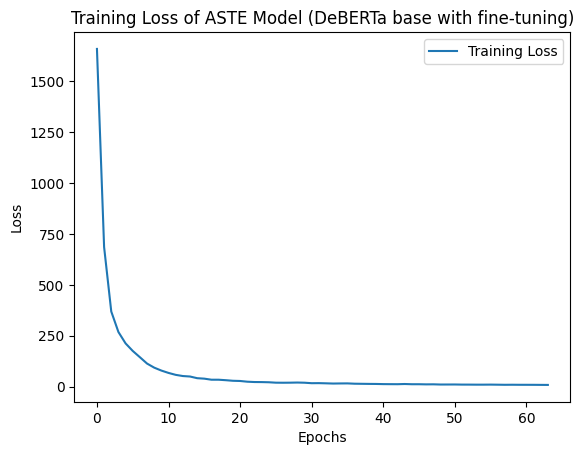

In [ ]:
#Plotting the training loss
epochs = range(len(tracker['train_loss']))
train_loss = tracker['train_loss']
plt.plot(epochs, train_loss, label='Training Loss')
plt.title('Training Loss of ASTE Model (DeBERTa base with fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
tracker.keys()

dict_keys(['train_loss', 'dev_loss', 'aspect_f1', 'opinion_f1', 'aspect_opinion_pair_f1', 'aspect_polarity_pair_f1', 'triplet_f1', 'current_aspect_f1', 'current_opinion_f1', 'current_aspect_opinion_pair_f1', 'current_aspect_polarity_pair_f1', 'current_triplet_f1', 'completed_steps'])

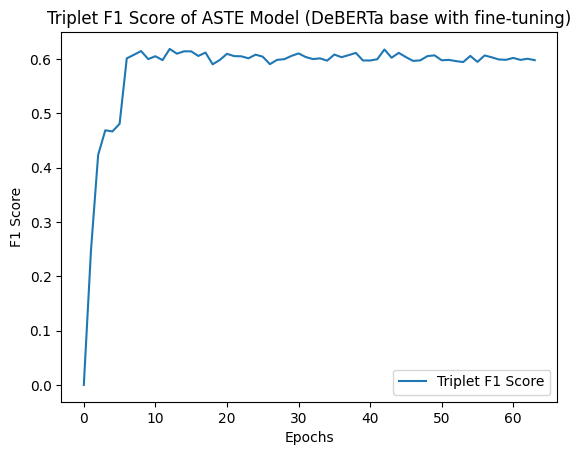

In [ ]:
#Plotting triplets f1 score
epcohs = range(len(tracker['triplet_f1']))
triplet_f1_scores = tracker['triplet_f1']
plt.plot(epochs, triplet_f1_scores, label='Triplet F1 Score')
plt.title('Triplet F1 Score of ASTE Model (DeBERTa base with fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

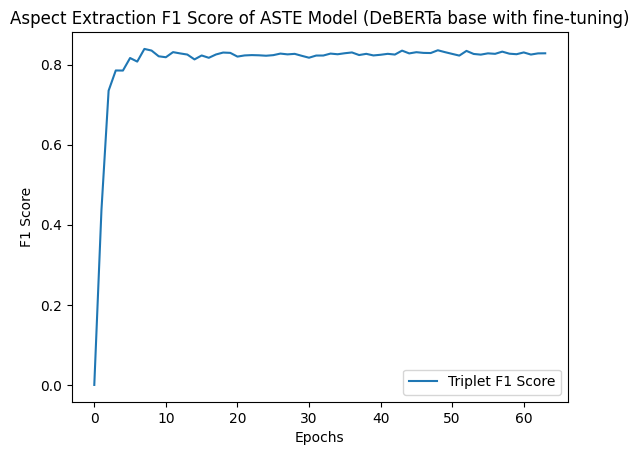

In [ ]:
#Plotting aspect extraction f1 score
epcohs = range(len(tracker['aspect_f1']))
aspect_f1_scores = tracker['aspect_f1']
plt.plot(epochs, aspect_f1_scores, label='Triplet F1 Score')
plt.title('Aspect Extraction F1 Score of ASTE Model (DeBERTa base with fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

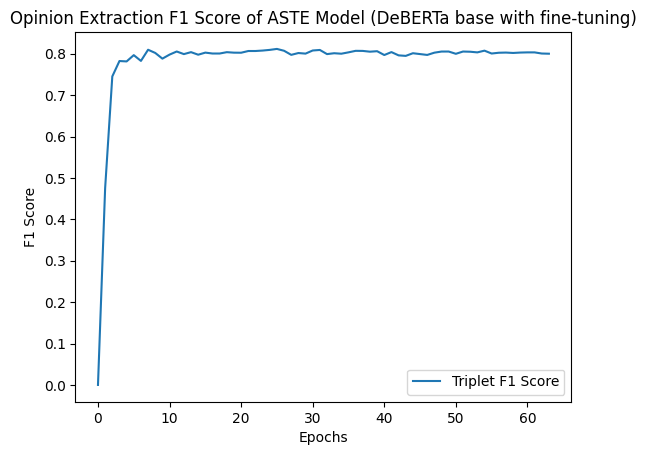

In [ ]:
#Plotting opinion extraction f1 score
epcohs = range(len(tracker['opinion_f1']))
opinion_f1_scores = tracker['opinion_f1']
plt.plot(epochs, opinion_f1_scores, label='Triplet F1 Score')
plt.title('Opinion Extraction F1 Score of ASTE Model (DeBERTa base with fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

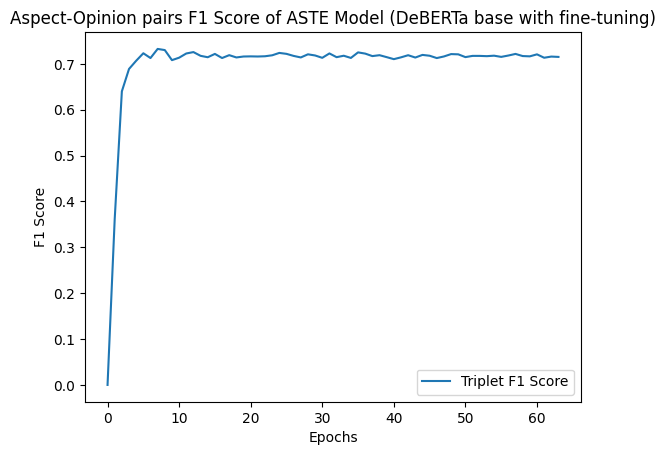

In [ ]:
#Plotting aspect-opinion pairs extraction score
epcohs = range(len(tracker['aspect_opinion_pair_f1']))
aspect_opinion_pair_f1_scores = tracker['aspect_opinion_pair_f1']
plt.plot(epochs, aspect_opinion_pair_f1_scores, label='Triplet F1 Score')
plt.title('Aspect-Opinion pairs F1 Score of ASTE Model (DeBERTa base with fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

It can be seen that during the evaluation process, all three sub-tasks of the Aspect Based Sentiment Analysis problem give very good F1 results. This is due to the "power" of fine-tuning. So if we "freeze" the pre-trained model and only train the Linear layer, what will the results be?

### **2. ASTE I (xsmall) Model**

In [ ]:
#Reading the tracker file
with open('/content/drive/MyDrive/CAP_6640-Project_3/tracker/asteIxsmall_alldata_finetuning_deberta_0.8_tracker.json') as ifile:
    tracker = json.load(ifile)

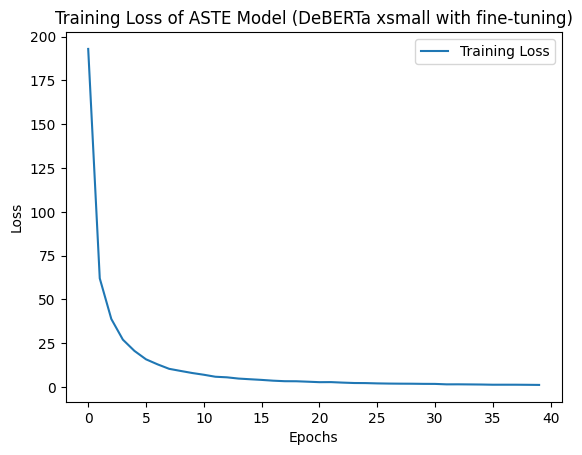

In [ ]:
#Plotting the training loss
epochs = range(len(tracker['train_loss']))
train_loss = tracker['train_loss']
plt.plot(epochs, train_loss, label='Training Loss')
plt.title('Training Loss of ASTE Model (DeBERTa xsmall with fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

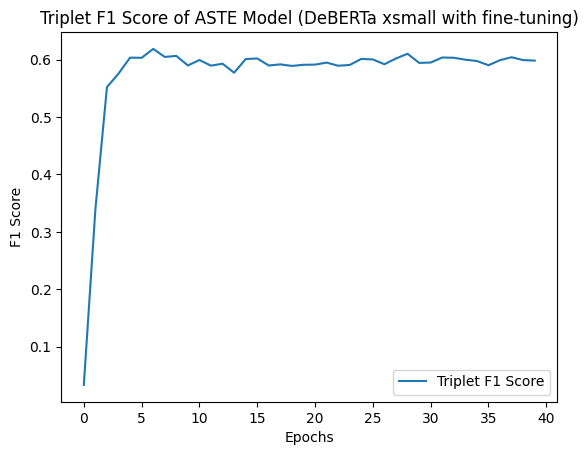

In [ ]:
#Plotting triplets f1 score
epcohs = range(len(tracker['triplet_f1']))
triplet_f1_scores = tracker['triplet_f1']
plt.plot(epochs, triplet_f1_scores, label='Triplet F1 Score')
plt.title('Triplet F1 Score of ASTE Model (DeBERTa xsmall with fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

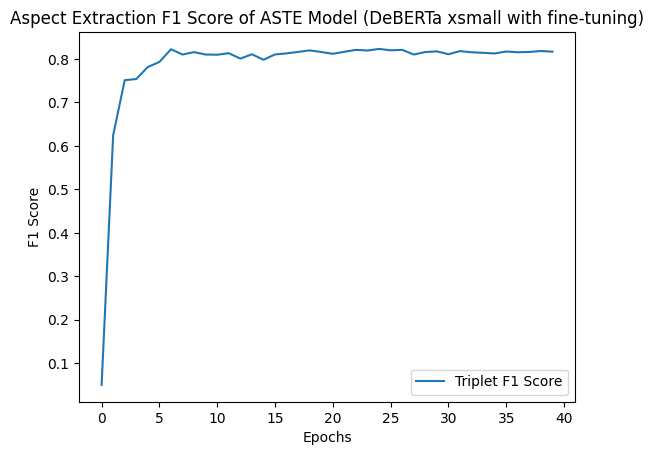

In [ ]:
#Plotting aspect extraction f1 score
epcohs = range(len(tracker['aspect_f1']))
aspect_f1_scores = tracker['aspect_f1']
plt.plot(epochs, aspect_f1_scores, label='Triplet F1 Score')
plt.title('Aspect Extraction F1 Score of ASTE Model (DeBERTa xsmall with fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

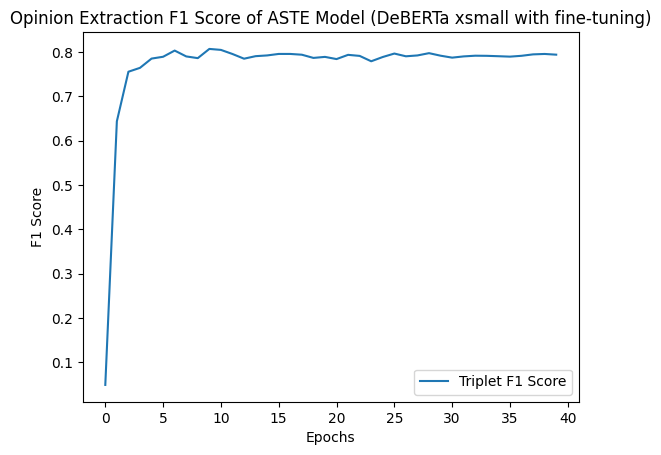

In [ ]:
#Plotting opinion extraction f1 score
epcohs = range(len(tracker['opinion_f1']))
opinion_f1_scores = tracker['opinion_f1']
plt.plot(epochs, opinion_f1_scores, label='Triplet F1 Score')
plt.title('Opinion Extraction F1 Score of ASTE Model (DeBERTa xsmall with fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

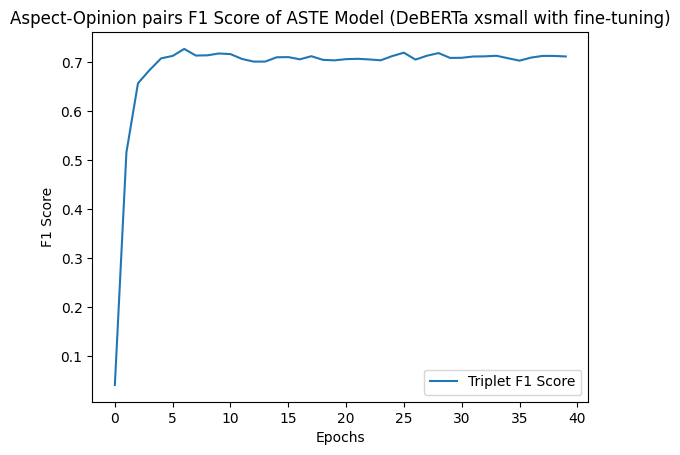

In [ ]:
#Plotting aspect-opinion pairs extraction score
epcohs = range(len(tracker['aspect_opinion_pair_f1']))
aspect_opinion_pair_f1_scores = tracker['aspect_opinion_pair_f1']
plt.plot(epochs, aspect_opinion_pair_f1_scores, label='Triplet F1 Score')
plt.title('Aspect-Opinion pairs F1 Score of ASTE Model (DeBERTa xsmall with fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

### **3. ASTE II Model**

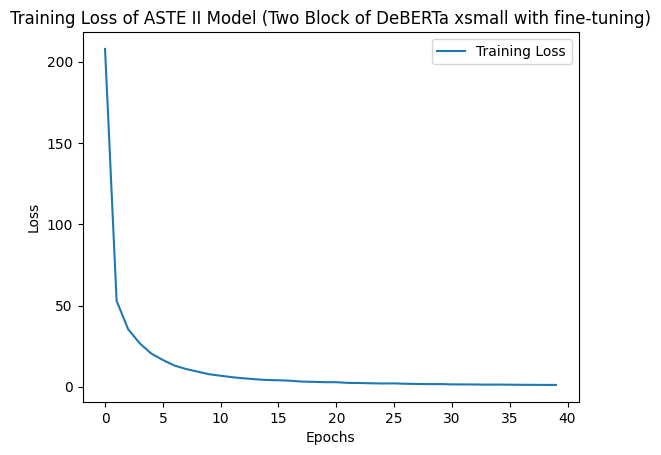

In [ ]:
#Plotting the training loss
epochs = range(len(tracker['train_loss']))
train_loss = tracker['train_loss']
plt.plot(epochs, train_loss, label='Training Loss')
plt.title('Training Loss of ASTE II Model (Two Block of DeBERTa xsmall with fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
tracker.keys()

dict_keys(['train_loss', 'dev_loss', 'aspect_f1', 'opinion_f1', 'aspect_opinion_pair_f1', 'aspect_polarity_pair_f1', 'triplet_f1', 'current_aspect_f1', 'current_opinion_f1', 'current_aspect_opinion_pair_f1', 'current_aspect_polarity_pair_f1', 'current_triplet_f1', 'completed_steps'])

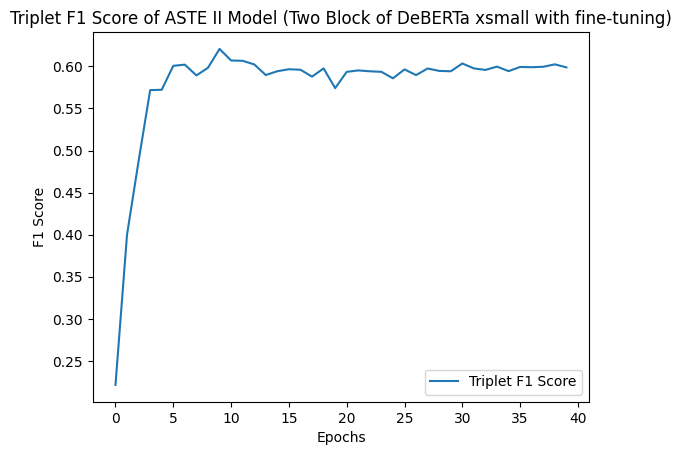

In [ ]:
#Plotting triplets f1 score
epcohs = range(len(tracker['triplet_f1']))
triplet_f1_scores = tracker['triplet_f1']
plt.plot(epochs, triplet_f1_scores, label='Triplet F1 Score')
plt.title('Triplet F1 Score of ASTE II Model (Two Block of DeBERTa xsmall with fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

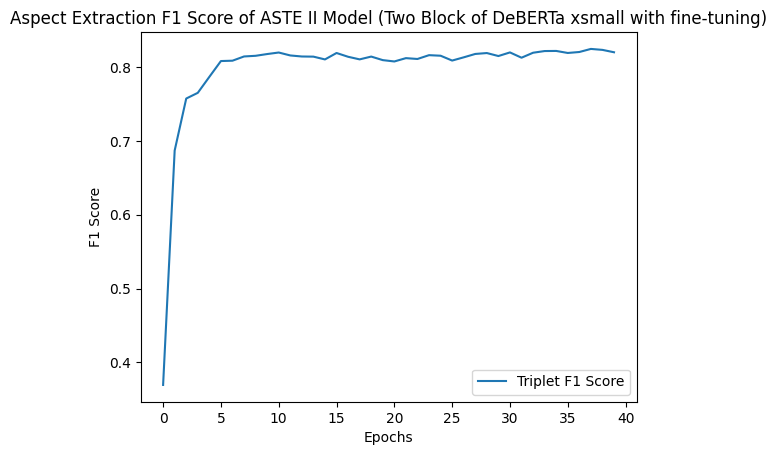

In [ ]:
#Plotting aspect extraction f1 score
epcohs = range(len(tracker['aspect_f1']))
aspect_f1_scores = tracker['aspect_f1']
plt.plot(epochs, aspect_f1_scores, label='Triplet F1 Score')
plt.title('Aspect Extraction F1 Score of ASTE II Model (Two Block of DeBERTa xsmall with fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

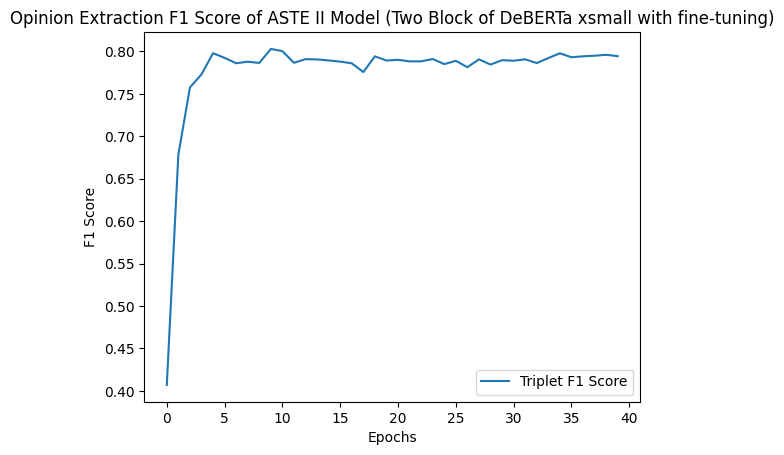

In [ ]:
#Plotting opinion extraction f1 score
epcohs = range(len(tracker['opinion_f1']))
opinion_f1_scores = tracker['opinion_f1']
plt.plot(epochs, opinion_f1_scores, label='Triplet F1 Score')
plt.title('Opinion Extraction F1 Score of ASTE II Model (Two Block of DeBERTa xsmall with fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

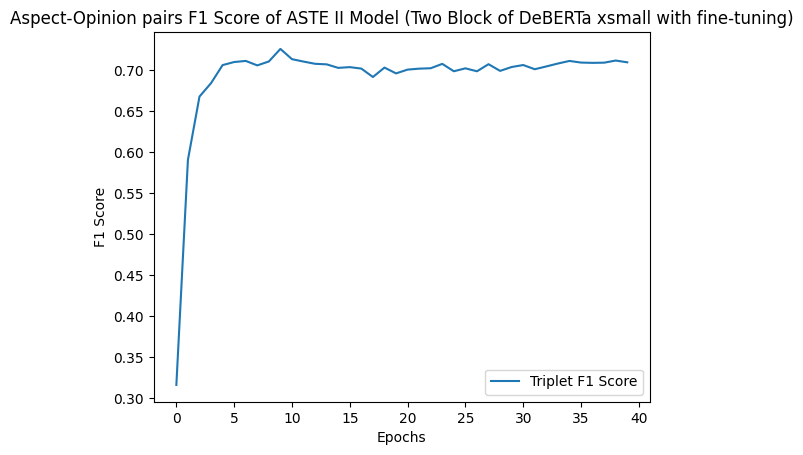

In [ ]:
#Plotting aspect-opinion pairs extraction score
epcohs = range(len(tracker['aspect_opinion_pair_f1']))
aspect_opinion_pair_f1_scores = tracker['aspect_opinion_pair_f1']
plt.plot(epochs, aspect_opinion_pair_f1_scores, label='Triplet F1 Score')
plt.title('Aspect-Opinion pairs F1 Score of ASTE II Model (Two Block of DeBERTa xsmall with fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

### **4. ASTE III Model**

In [ ]:
with open('/content/drive/MyDrive/CAP_6640-Project_3/tracker/asteIII_alldata_finetuning_deberta_0.8_tracker.json', 'r') as ifile:
  tracker = json.load(ifile)

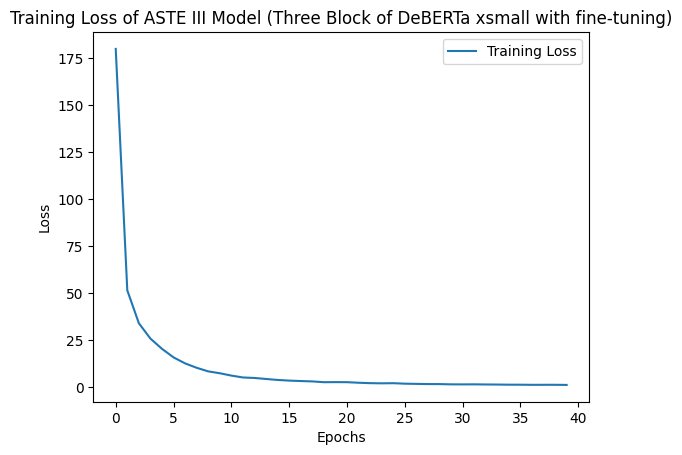

In [ ]:
#Plotting the training loss
epochs = range(len(tracker['train_loss']))
train_loss = tracker['train_loss']
plt.plot(epochs, train_loss, label='Training Loss')
plt.title('Training Loss of ASTE III Model (Three Block of DeBERTa xsmall with fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

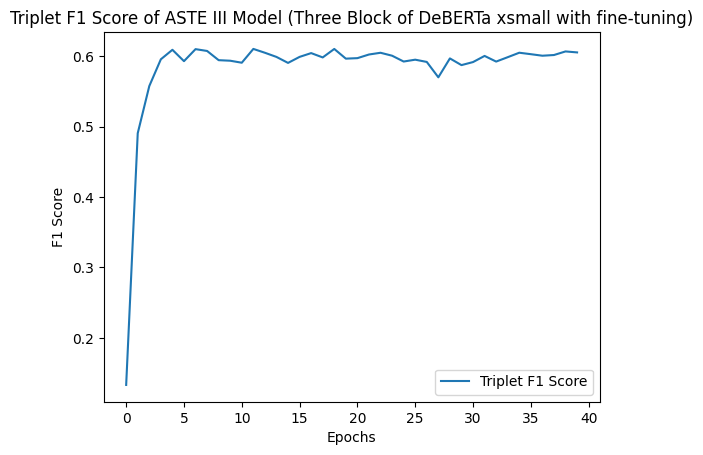

In [ ]:
#Plotting triplets f1 score
epcohs = range(len(tracker['triplet_f1']))
triplet_f1_scores = tracker['triplet_f1']
plt.plot(epochs, triplet_f1_scores, label='Triplet F1 Score')
plt.title('Triplet F1 Score of ASTE III Model (Three Block of DeBERTa xsmall with fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

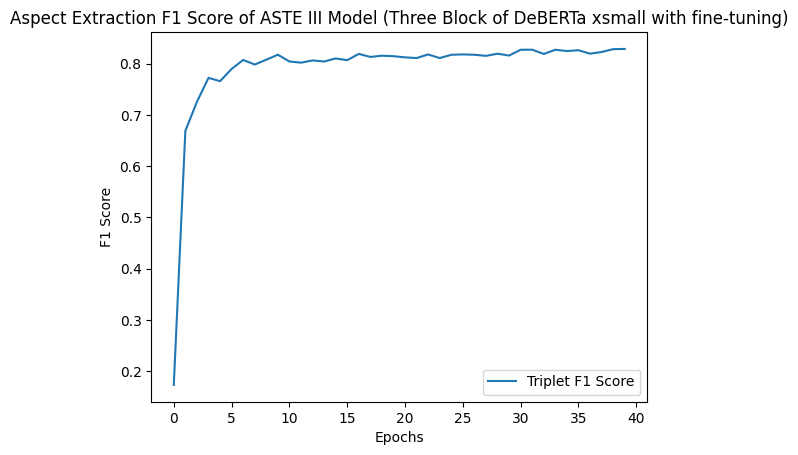

In [ ]:
#Plotting aspect extraction f1 score
epcohs = range(len(tracker['aspect_f1']))
aspect_f1_scores = tracker['aspect_f1']
plt.plot(epochs, aspect_f1_scores, label='Triplet F1 Score')
plt.title('Aspect Extraction F1 Score of ASTE III Model (Three Block of DeBERTa xsmall with fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

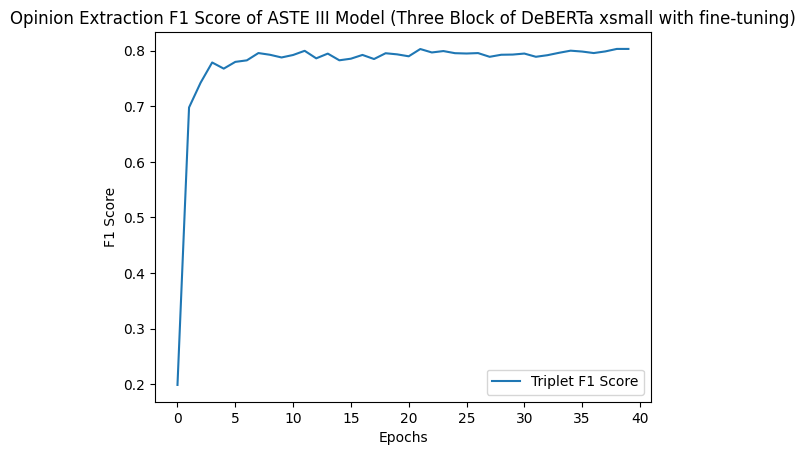

In [ ]:
#Plotting opinion extraction f1 score
epcohs = range(len(tracker['opinion_f1']))
opinion_f1_scores = tracker['opinion_f1']
plt.plot(epochs, opinion_f1_scores, label='Triplet F1 Score')
plt.title('Opinion Extraction F1 Score of ASTE III Model (Three Block of DeBERTa xsmall with fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

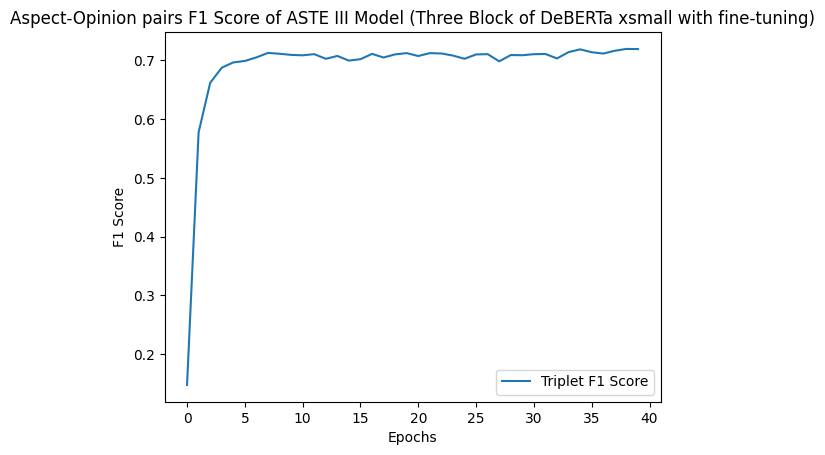

In [ ]:
#Plotting aspect-opinion pairs extraction score
epcohs = range(len(tracker['aspect_opinion_pair_f1']))
aspect_opinion_pair_f1_scores = tracker['aspect_opinion_pair_f1']
plt.plot(epochs, aspect_opinion_pair_f1_scores, label='Triplet F1 Score')
plt.title('Aspect-Opinion pairs F1 Score of ASTE III Model (Three Block of DeBERTa xsmall with fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

It can be seen that most of our models are trained smoothly. The F1 results are very promising and can be used for further expansion in practice, especially for the ASTE I xsmall model with small size but results not inferior to other models.

## **B. Parameters and Triplet F1-score comparison**

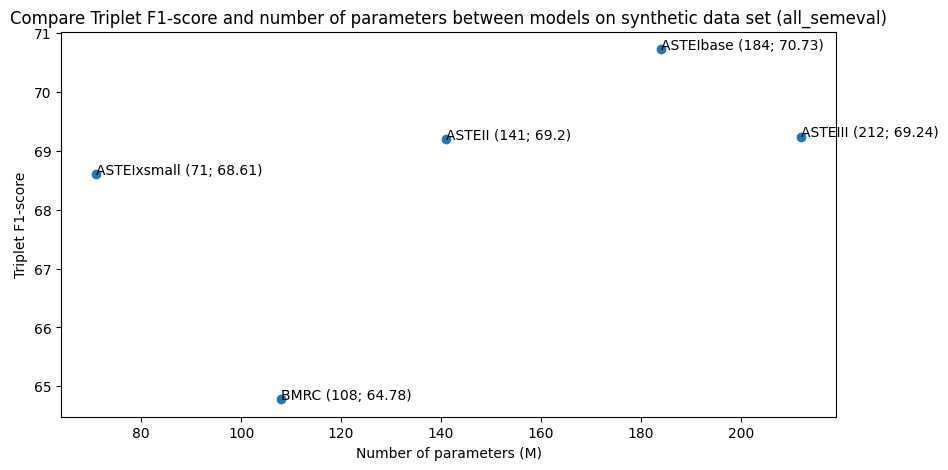

In [ ]:
#
x = [108, 184, 71, 141, 212]
y = [64.78, 70.73, 68.61, 69.20, 69.24]
name = ['BMRC', 'ASTEIbase', 'ASTEIxsmall', 'ASTEII', 'ASTEIII']

fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(111)
plt.scatter(x, y)
plt.title('Compare Triplet F1-score and number of parameters between models on synthetic data set (all_semeval)')
plt.xlabel('Number of parameters (M)')
plt.ylabel('Triplet F1-score')
for i in range(len(x)):
  ax.text(x[i], y[i], f'{name[i]} ({x[i]}; {y[i]})')
plt.show()

plt.show()

* The model that replaced BERT with DeBERTa V3 was found to outperform the baseline model (BMRC).
* The ASTE I xsmall model has even fewer parameters than the BMRC.


## **C. Effect of Threshold to Triplet Precision, Recall and F1-score**

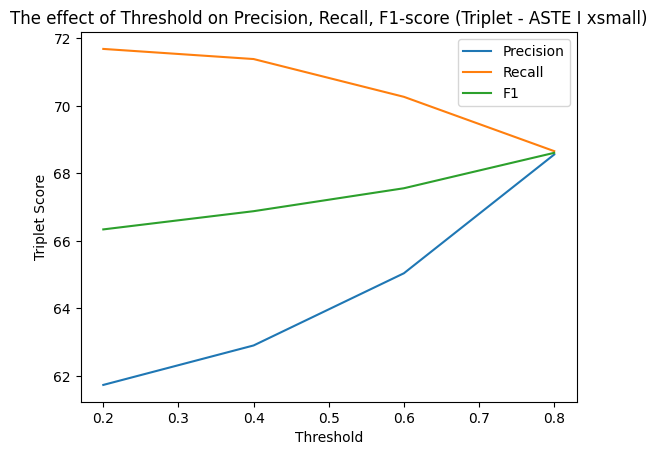

In [ ]:
#Threshold affect precision, recall, F1
thresholds = [0.2, 0.4, 0.6, 0.8]
precisions = [61.73, 62.90, 65.04, 68.56]
recalls = [71.69, 71.39, 70.27, 68.66]
f1s = [66.34, 66.88, 67.56,68.61]

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1')
plt.xlabel('Threshold')
plt.ylabel('Triplet Score')
plt.title('The effect of Threshold on Precision, Recall, F1-score (Triplet - ASTE I xsmall)')
plt.legend()
plt.show()

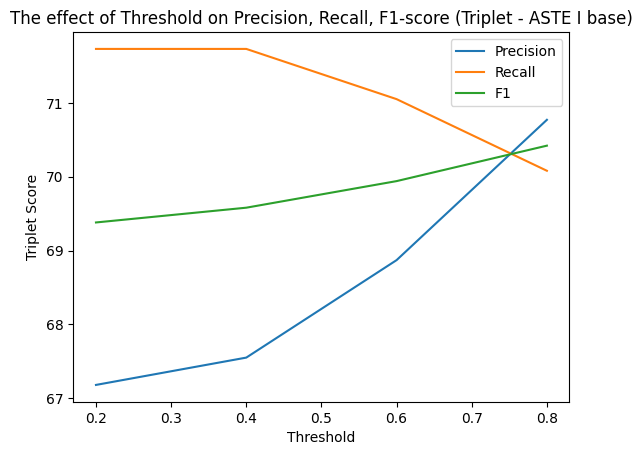

In [ ]:
#Threshold affect precision, recall, F1
thresholds = [0.2, 0.4, 0.6, 0.8]
precisions = [67.18, 67.55, 68.87, 70.77]
recalls = [71.73, 71.73, 71.05, 70.08]
f1s = [69.38, 69.58, 69.94, 70.42]

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1')
plt.xlabel('Threshold')
plt.ylabel('Triplet Score')
plt.title('The effect of Threshold on Precision, Recall, F1-score (Triplet - ASTE I base)')
plt.legend()
plt.show()

As the threshold increases, the precision score increases while the recall decreases. This is reasonable because the higher the threshold, the higher the requirement to select triplets, so there will be fewer triplets (lower recall), but the collected triplets have better quality (higher precision). Thereby, it also helps improve the F1 score.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
